In [1]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
import arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pykalman import KalmanFilter
import statistics

In [2]:
# !pip install pykalman

In [3]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('FR_next.csv')
df

,Date,Prices,Generation forecast,System load forecast
0,2017-01-01 00:00:00,58.82,70810.0,75500.0
1,2017-01-01 01:00:00,58.23,69539.0,73650.0
2,2017-01-01 02:00:00,51.95,67376.0,72350.0
3,2017-01-01 03:00:00,47.27,65412.0,68750.0
4,2017-01-01 04:00:00,45.49,64557.0,65900.0
...,...,...,...,...
52580,2022-12-31 20:00:00,7.60,44648.0,46950.0
52581,2022-12-31 21:00:00,3.69,43841.0,44350.0
52582,2022-12-31 22:00:00,1.88,44578.0,43950.0
52583,2022-12-31 23:00:00,0.10,45135.0,47250.0


In [4]:
dfb = df

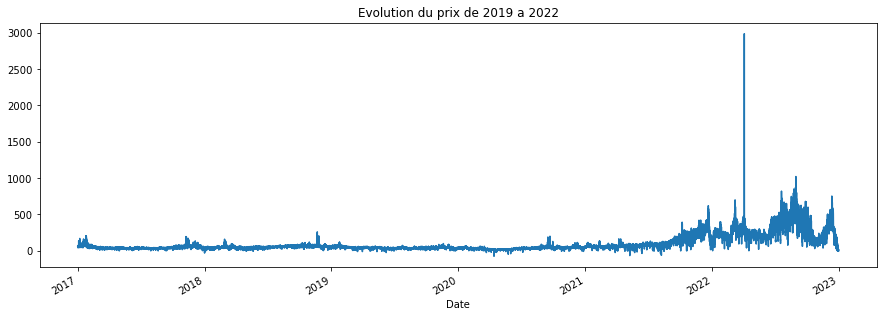

In [5]:
df_date = df

# Convertir la colonne Date en datetime
df_date['Date'] = pd.to_datetime(df_date['Date'])

# Définir la colonne Date comme index du dataframe
df_date.set_index('Date', inplace=True)

# Définir la taille de la figure
plt.figure(figsize=(15, 5))

# Tracer les données en utilisant la méthode plot() de pandas
df_date[' Prices'].plot()

# Ajouter un titre au graphique
plt.title('Evolution du prix de 2019 a 2022')

# Afficher le graphique
plt.show()

In [6]:
dfb = dfb.reset_index()

In [7]:
# Convertir la colonne Date en format datetime
dfb['Date'] = pd.to_datetime(dfb['Date'])

# Définir les bornes de la plage de dates souhaitée
start_date_train = '2017-01-01 00:00:00'
end_date_train = '2020-12-31 23:00:00'

start_date_test = '2021-01-01 00:00:00'
end_date_test = '2022-12-31 23:00:00'

# Sélectionner les lignes entre les bornes de dates
train_data = dfb.loc[(dfb['Date'] >= start_date_train) & (dfb['Date'] <= end_date_train)]

test_data = dfb.loc[(dfb['Date'] >= start_date_test) & (dfb['Date'] <= end_date_test)]

In [8]:
train_data

,Date,Prices,Generation forecast,System load forecast
0,2017-01-01 00:00:00,58.82,70810.0,75500.0
1,2017-01-01 01:00:00,58.23,69539.0,73650.0
2,2017-01-01 02:00:00,51.95,67376.0,72350.0
3,2017-01-01 03:00:00,47.27,65412.0,68750.0
4,2017-01-01 04:00:00,45.49,64557.0,65900.0
...,...,...,...,...
35059,2020-12-31 19:00:00,60.54,70648.0,70850.0
35060,2020-12-31 20:00:00,56.75,69866.0,67800.0
35061,2020-12-31 21:00:00,52.44,68126.0,64900.0
35062,2020-12-31 22:00:00,51.86,67610.0,64800.0


In [9]:

# replace missing values with the mean value of the column
test_data[' Generation forecast'].fillna(test_data[' Generation forecast'].mean(), inplace=True)
display(test_data)

# replace missing values with the mean value of the column
train_data[' Generation forecast'].fillna(train_data[' Generation forecast'].mean(), inplace=True)
display(train_data)

C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\3222748322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[' Generation forecast'].fillna(test_data[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
35064,2021-01-01 00:00:00,50.87,63690.0,66500.0
35065,2021-01-01 01:00:00,48.19,62414.0,64600.0
35066,2021-01-01 02:00:00,44.68,60612.0,63700.0
35067,2021-01-01 03:00:00,42.92,58978.0,60600.0
35068,2021-01-01 04:00:00,40.39,58520.0,58150.0
...,...,...,...,...
52579,2022-12-31 19:00:00,18.11,45503.0,49650.0
52580,2022-12-31 20:00:00,7.60,44648.0,46950.0
52581,2022-12-31 21:00:00,3.69,43841.0,44350.0
52582,2022-12-31 22:00:00,1.88,44578.0,43950.0


C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\3222748322.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[' Generation forecast'].fillna(train_data[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
0,2017-01-01 00:00:00,58.82,70810.0,75500.0
1,2017-01-01 01:00:00,58.23,69539.0,73650.0
2,2017-01-01 02:00:00,51.95,67376.0,72350.0
3,2017-01-01 03:00:00,47.27,65412.0,68750.0
4,2017-01-01 04:00:00,45.49,64557.0,65900.0
...,...,...,...,...
35059,2020-12-31 19:00:00,60.54,70648.0,70850.0
35060,2020-12-31 20:00:00,56.75,69866.0,67800.0
35061,2020-12-31 21:00:00,52.44,68126.0,64900.0
35062,2020-12-31 22:00:00,51.86,67610.0,64800.0


In [10]:
# Set the length of the training set
train_len = len(train_data)
#print(train_len)

# Create an empty array to store the predictions
predictions = []

# Iterate over each point in the test set
for i in range(0, len(test_data), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset = train_data.iloc[:train_len, :]
    else:
        train_data_subset = pd.concat([train_data.iloc[i:, :], test_data.iloc[:i, :]], axis=0)
    #print("train data :", train_data_subset)
        
    # Fit the ARIMA model to the training data
    model = ARIMA(train_data_subset.iloc[:, 1], exog=train_data_subset.iloc[:, 2:], order=(1,1,1))
    result = model.fit()
    
    # Make one-day-ahead forecasts
    forecast = result.forecast(steps=24, exog=test_data.iloc[i:i+24, 2:])
    print("prédictions :", forecast)
    
    # Store the forecasts in the predictions array
    predictions.extend(forecast)
    


prédictions : 35064    46.322009
35065    43.694831
35066    40.526007
35067    36.957694
35068    35.476463
35069    34.267416
35070    34.521808
35071    35.707908
35072    36.243151
35073    38.255480
35074    41.222028
35075    44.044580
35076    46.082078
35077    45.786629
35078    43.536549
35079    42.999284
35080    46.410970
35081    49.238302
35082    52.697528
35083    52.918003
35084    52.377841
35085    50.337130
35086    49.182150
35087    48.643831
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be give

prédictions : 35064    47.134805
35065    43.755257
35066    40.902987
35067    37.959065
35068    37.522324
35069    38.919545
35070    42.486669
35071    46.219432
35072    49.504655
35073    52.865670
35074    56.889684
35075    59.022832
35076    60.249751
35077    59.137529
35078    57.007825
35079    56.037762
35080    56.268819
35081    57.661648
35082    61.007491
35083    61.119053
35084    59.213942
35085    55.635224
35086    54.522556
35087    53.604657
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.468932
35065    36.329925
35066    34.546173
35067    32.221244
35068    30.357849
35069    30.175867
35070    31.655899
35071    33.079085
35072    34.614437
35073    40.372242
35074    44.132960
35075    46.104427
35076    47.777310
35077    46.721993
35078    43.403890
35079    41.781084
35080    43.510115
35081    48.396309
35082    52.588402
35083    54.291966
35084    53.515602
35085    51.074468
35086    49.948716
35087    49.287056
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.225041
35065    46.999851
35066    44.036446
35067    41.522551
35068    41.121944
35069    45.732303
35070    53.647735
35071    58.947615
35072    63.299397
35073    64.226546
35074    65.722600
35075    66.921958
35076    67.049114
35077    65.269344
35078    66.091619
35079    61.836690
35080    63.191314
35081    67.587217
35082    71.560882
35083    72.001677
35084    66.201523
35085    61.036801
35086    59.337344
35087    58.882236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.122996
35065    50.780827
35066    48.464151
35067    44.852324
35068    42.851746
35069    48.591491
35070    54.182324
35071    60.897222
35072    63.587264
35073    66.133264
35074    66.898247
35075    68.034578
35076    70.013752
35077    67.590340
35078    65.141947
35079    62.271609
35080    60.692282
35081    64.829911
35082    70.100168
35083    72.538728
35084    63.934171
35085    56.555199
35086    54.354669
35087    55.296808
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    51.225200
35065    48.194168
35066    47.808194
35067    45.752022
35068    43.616701
35069    46.353576
35070    53.480931
35071    59.969888
35072    63.995227
35073    68.862578
35074    69.803919
35075    71.181175
35076    70.939288
35077    69.510025
35078    66.997890
35079    64.376442
35080    62.886175
35081    66.438347
35082    71.520811
35083    71.526337
35084    65.124205
35085    58.462042
35086    55.787266
35087    56.979527
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.799554
35065    53.878349
35066    52.153453
35067    49.672840
35068    50.763170
35069    52.587686
35070    60.290900
35071    67.839568
35072    73.975029
35073    77.641354
35074    79.284094
35075    79.591315
35076    79.632543
35077    78.467303
35078    74.903047
35079    73.175511
35080    73.356516
35081    77.211726
35082    80.596676
35083    80.893066
35084    76.099603
35085    67.831784
35086    63.780571
35087    63.382131
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    60.845562
35065    58.866883
35066    57.651913
35067    55.156017
35068    54.685554
35069    56.991860
35070    64.582233
35071    73.636868
35072    80.147449
35073    82.948669
35074    84.535953
35075    85.211248
35076    85.072014
35077    82.684518
35078    79.298361
35079    75.550757
35080    74.676760
35081    77.511355
35082    81.154096
35083    81.601423
35084    76.836484
35085    69.888562
35086    65.187102
35087    65.888367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.923313
35065    60.995529
35066    59.604907
35067    56.013977
35068    53.520733
35069    54.097276
35070    57.549888
35071    62.205712
35072    66.009203
35073    69.093400
35074    71.504345
35075    73.605668
35076    73.399061
35077    72.702280
35078    70.112051
35079    68.764480
35080    68.030199
35081    74.993250
35082    75.773863
35083    77.738831
35084    72.589918
35085    69.529163
35086    68.836101
35087    70.109488
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.113083
35065    46.478386
35066    41.346577
35067    39.073723
35068    36.489400
35069    36.495180
35070    38.617960
35071    40.371938
35072    43.662372
35073    49.241695
35074    53.492718
35075    54.971947
35076    56.546769
35077    53.950961
35078    49.204607
35079    46.393638
35080    45.565261
35081    49.941906
35082    54.577466
35083    57.360111
35084    54.596763
35085    49.611720
35086    49.381884
35087    50.030208
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.704506
35065    54.750753
35066    52.651852
35067    49.544350
35068    49.313109
35069    53.377185
35070    61.622560
35071    72.258063
35072    78.520218
35073    80.977816
35074    81.989777
35075    81.758928
35076    81.058642
35077    79.629386
35078    77.523881
35079    75.762044
35080    73.964123
35081    79.428164
35082    83.265322
35083    84.909006
35084    80.405526
35085    73.288064
35086    71.007391
35087    71.858431
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    59.047091
35065    56.915327
35066    55.704191
35067    50.292111
35068    49.902422
35069    52.191408
35070    59.793951
35071    69.996987
35072    71.886860
35073    75.337291
35074    75.903731
35075    76.296702
35076    75.947125
35077    72.573743
35078    70.150409
35079    67.027689
35080    64.690173
35081    66.237386
35082    70.566063
35083    69.028070
35084    61.719432
35085    55.605983
35086    54.527152
35087    54.460600
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.357905
35065    53.698231
35066    51.078011
35067    48.144301
35068    47.015257
35069    50.745051
35070    57.585390
35071    65.605458
35072    69.907592
35073    72.162622
35074    73.304931
35075    73.523749
35076    74.002114
35077    72.427725
35078    70.461769
35079    68.405988
35080    67.417892
35081    69.420646
35082    72.345080
35083    72.553910
35084    65.459018
35085    60.181802
35086    59.515705
35087    60.491318
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    62.392330
35065    58.141086
35066    55.400558
35067    50.325903
35068    48.809942
35069    51.219958
35070    63.346384
35071    72.232914
35072    76.529277
35073    79.732764
35074    81.320566
35075    83.144515
35076    84.297773
35077    82.735509
35078    79.118895
35079    76.895274
35080    77.664853
35081    81.583308
35082    85.183552
35083    83.109213
35084    75.857647
35085    70.058724
35086    67.333873
35087    66.795451
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    51.068328
35065    46.362904
35066    43.331633
35067    41.187720
35068    41.321745
35069    46.243789
35070    56.211583
35071    65.547741
35072    71.036489
35073    72.502822
35074    73.615386
35075    74.439099
35076    73.400626
35077    70.861351
35078    67.375869
35079    64.451527
35080    64.486742
35081    64.953857
35082    68.031065
35083    68.768333
35084    61.403787
35085    53.680563
35086    51.406800
35087    51.522826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.610576
35065    50.569597
35066    46.375003
35067    42.959311
35068    41.351215
35069    41.254459
35070    42.958865
35071    48.030811
35072    52.315806
35073    55.815011
35074    58.939841
35075    59.548972
35076    61.819848
35077    59.800388
35078    56.727132
35079    55.260880
35080    55.805029
35081    58.325945
35082    62.256122
35083    62.521892
35084    59.551630
35085    53.361696
35086    51.954011
35087    51.826021
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.329534
35065    42.782578
35066    40.643896
35067    35.615569
35068    33.814807
35069    34.367401
35070    35.416201
35071    39.922683
35072    41.946481
35073    49.276353
35074    52.793789
35075    55.568839
35076    57.610794
35077    56.044810
35078    53.062644
35079    51.985002
35080    50.781075
35081    53.612762
35082    58.150298
35083    58.957842
35084    56.001564
35085    52.486400
35086    51.114769
35087    51.299645
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.188209
35065    49.797915
35066    47.165471
35067    44.456308
35068    45.503422
35069    49.453669
35070    58.939744
35071    67.058254
35072    71.448282
35073    73.448421
35074    73.657240
35075    73.416584
35076    73.376237
35077    71.891505
35078    69.119000
35079    65.729601
35080    65.202932
35081    68.961645
35082    74.272107
35083    74.548181
35084    69.491315
35085    64.390488
35086    63.337480
35087    64.536344
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.394253
35065    58.567992
35066    55.850445
35067    50.536334
35068    49.657124
35069    52.637924
35070    63.504524
35071    72.509516
35072    76.480812
35073    77.787582
35074    78.255752
35075    78.871424
35076    79.118782
35077    76.509815
35078    70.888399
35079    66.789291
35080    65.460720
35081    69.195906
35082    74.637122
35083    76.902039
35084    70.891565
35085    62.338753
35086    61.164361
35087    61.960416
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.537624
35065    45.458947
35066    41.572783
35067    36.887353
35068    36.256660
35069    38.397421
35070    46.690851
35071    54.886950
35072    59.017684
35073    61.125267
35074    62.324597
35075    61.972600
35076    61.410597
35077    58.818642
35078    56.184900
35079    53.970706
35080    53.682815
35081    56.953196
35082    60.940344
35083    60.346845
35084    53.472507
35085    46.230496
35086    45.075050
35087    45.421274
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.282375
35065    35.495484
35066    33.198029
35067    29.102700
35068    28.614007
35069    30.179128
35070    37.136022
35071    46.010771
35072    49.127019
35073    49.832037
35074    50.789091
35075    50.356815
35076    49.017169
35077    47.468830
35078    45.622909
35079    44.144514
35080    44.301610
35081    47.186608
35082    51.074439
35083    52.023101
35084    48.330537
35085    43.737649
35086    41.741502
35087    40.256838
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    33.418931
35065    28.868243
35066    26.856965
35067    24.926713
35068    24.057201
35069    25.942612
35070    34.771476
35071    46.053918
35072    49.698194
35073    50.525271
35074    49.060057
35075    50.351428
35076    51.827653
35077    50.986431
35078    47.986204
35079    46.304115
35080    46.818328
35081    49.947726
35082    53.694471
35083    53.969233
35084    49.199758
35085    44.699340
35086    41.899841
35087    42.690463
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.980530
35065    35.185122
35066    33.499314
35067    31.776012
35068    30.077730
35069    30.217579
35070    31.427383
35071    35.889703
35072    41.625410
35073    46.448129
35074    49.023890
35075    50.417378
35076    51.147486
35077    49.897010
35078    46.230136
35079    45.341456
35080    44.574159
35081    45.782481
35082    48.596920
35083    49.063547
35084    45.847813
35085    40.628484
35086    38.788550
35087    40.711048
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.582452
35065    38.433124
35066    36.931650
35067    34.015857
35068    32.943124
35069    33.143568
35070    35.071931
35071    36.334895
35072    40.283193
35073    46.294846
35074    50.746366
35075    52.631181
35076    54.416627
35077    52.833011
35078    49.805662
35079    49.149117
35080    49.795767
35081    51.731088
35082    56.854647
35083    57.627795
35084    54.809688
35085    51.336005
35086    50.182652
35087    52.020635
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.040498
35065    39.688027
35066    39.337051
35067    38.401855
35068    38.503635
35069    43.386424
35070    52.245513
35071    61.964294
35072    65.495803
35073    67.733372
35074    68.952029
35075    69.860779
35076    69.545930
35077    68.219370
35078    64.864673
35079    61.601428
35080    60.251672
35081    61.540172
35082    64.462479
35083    64.374456
35084    58.733095
35085    53.602755
35086    52.930446
35087    52.987699
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.417260
35065    46.883328
35066    44.472292
35067    41.508772
35068    40.644725
35069    44.435975
35070    53.092630
35071    62.139261
35072    67.104080
35073    69.308225
35074    70.279043
35075    70.572867
35076    67.601573
35077    65.229668
35078    62.034283
35079    59.278203
35080    57.876776
35081    60.502104
35082    65.713330
35083    67.308118
35084    60.688984
35085    54.397594
35086    53.186952
35087    53.252440
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.275438
35065    36.153066
35066    34.459095
35067    31.809445
35068    30.945230
35069    33.103633
35070    43.010726
35071    50.691758
35072    53.880969
35073    54.996955
35074    55.945739
35075    56.468847
35076    56.767776
35077    55.476382
35078    52.125881
35079    49.725381
35080    49.649485
35081    51.569412
35082    55.730626
35083    56.769855
35084    51.547839
35085    45.656583
35086    43.283282
35087    43.028786
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.968792
35065    43.415971
35066    42.478959
35067    40.977512
35068    41.105903
35069    45.702483
35070    54.322378
35071    62.148150
35072    65.580671
35073    67.941900
35074    69.181926
35075    69.814535
35076    68.970194
35077    68.205074
35078    65.504747
35079    62.524410
35080    60.931493
35081    60.601496
35082    63.844524
35083    63.822756
35084    58.884171
35085    52.558500
35086    50.095975
35087    49.852407
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.120532
35065    34.884753
35066    32.423801
35067    31.277911
35068    31.077091
35069    33.121215
35070    40.045235
35071    48.369268
35072    50.142579
35073    53.291684
35074    54.295508
35075    55.662535
35076    56.244940
35077    54.654471
35078    51.637721
35079    49.648875
35080    48.503791
35081    48.656315
35082    50.054794
35083    49.502803
35084    45.258673
35085    39.819954
35086    36.209461
35087    34.611953
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.508437
35065    32.935724
35066    30.332652
35067    26.702962
35068    25.433562
35069    25.854977
35070    29.256304
35071    32.347483
35072    37.287798
35073    42.487182
35074    45.431150
35075    46.041676
35076    48.195934
35077    50.013381
35078    47.143985
35079    45.783975
35080    45.221282
35081    47.719159
35082    51.627560
35083    51.907824
35084    48.560620
35085    43.226378
35086    41.867296
35087    43.347647
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.631968
35065    33.541864
35066    31.716432
35067    29.137315
35068    27.642608
35069    27.397542
35070    27.573111
35071    28.232523
35072    30.399436
35073    37.326257
35074    39.910983
35075    41.968013
35076    43.725173
35077    41.008163
35078    38.282522
35079    37.967195
35080    39.066234
35081    41.581498
35082    46.063977
35083    47.078834
35084    45.173285
35085    42.007221
35086    40.290273
35087    40.022668
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.951629
35065    39.008446
35066    38.366173
35067    36.773307
35068    36.369090
35069    40.201613
35070    48.729049
35071    56.556623
35072    59.533051
35073    60.879527
35074    61.821035
35075    62.994475
35076    63.974246
35077    62.828574
35078    60.838535
35079    59.821075
35080    58.270642
35081    59.214863
35082    63.050114
35083    63.920672
35084    58.866216
35085    54.970623
35086    53.359567
35087    51.272581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.666714
35065    42.208731
35066    40.099520
35067    38.240899
35068    36.536474
35069    38.958164
35070    48.529336
35071    58.420872
35072    62.284896
35073    63.866302
35074    64.213170
35075    63.987371
35076    65.190268
35077    63.292873
35078    59.375541
35079    56.381068
35080    54.756351
35081    55.119590
35082    58.163432
35083    57.160254
35084    51.226903
35085    47.227375
35086    45.538527
35087    45.814405
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.231431
35065    32.095346
35066    28.336520
35067    26.809877
35068    25.967548
35069    27.470461
35070    35.757808
35071    42.973683
35072    45.894170
35073    48.188835
35074    50.265411
35075    52.988349
35076    53.690024
35077    52.011695
35078    49.043799
35079    46.621124
35080    43.702222
35081    43.601081
35082    46.946685
35083    46.791815
35084    42.132945
35085    36.736052
35086    33.094929
35087    32.398001
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.354081
35065    34.655577
35066    33.178318
35067    32.797212
35068    32.258065
35069    34.239080
35070    42.199473
35071    50.610502
35072    52.188404
35073    52.675352
35074    54.153561
35075    54.371726
35076    55.623870
35077    55.133744
35078    52.918730
35079    51.361393
35080    50.490239
35081    51.781918
35082    57.027757
35083    58.317901
35084    54.490227
35085    49.793002
35086    46.602509
35087    46.300615
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.540520
35065    38.836102
35066    37.818717
35067    36.339941
35068    36.205397
35069    38.047760
35070    46.058804
35071    53.119778
35072    54.967040
35073    55.653333
35074    55.401789
35075    55.705283
35076    56.266658
35077    55.210286
35078    52.066407
35079    50.012100
35080    48.486007
35081    49.592956
35082    53.502288
35083    53.570546
35084    50.543684
35085    44.547203
35086    41.030353
35087    41.930390
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.400561
35065    38.121121
35066    35.301224
35067    33.055132
35068    32.341085
35069    32.947837
35070    34.486402
35071    35.900582
35072    37.805930
35073    40.635964
35074    42.548914
35075    42.620262
35076    43.038535
35077    41.197952
35078    39.043208
35079    36.992513
35080    37.027618
35081    38.538179
35082    42.647723
35083    44.682186
35084    42.146006
35085    39.212814
35086    37.978007
35087    38.724882
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.387333
35065    20.270174
35066    18.027691
35067    14.707541
35068    13.123909
35069    13.769307
35070    15.294021
35071    16.722910
35072    18.364943
35073    23.288746
35074    28.134634
35075    30.941189
35076    32.917844
35077    30.965293
35078    27.007248
35079    24.403276
35080    23.565400
35081    26.052485
35082    31.124025
35083    33.751211
35084    31.835655
35085    27.376420
35086    25.627228
35087    26.161300
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.049825
35065    32.816292
35066    30.601380
35067    28.456870
35068    28.812943
35069    33.446191
35070    44.761434
35071    52.971884
35072    57.879269
35073    60.961218
35074    63.156523
35075    64.342143
35076    63.838299
35077    61.771148
35078    59.647186
35079    57.412314
35080    56.099284
35081    57.313912
35082    62.387849
35083    64.534134
35084    60.436428
35085    53.909593
35086    51.556417
35087    50.489858
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.201050
35065    41.137668
35066    39.045411
35067    37.438922
35068    37.382113
35069    40.356701
35070    50.787633
35071    58.341680
35072    61.892827
35073    63.902274
35074    64.989144
35075    66.044436
35076    66.061820
35077    64.848574
35078    61.990893
35079    60.417568
35080    59.471358
35081    61.471334
35082    66.177204
35083    66.880042
35084    62.060413
35085    57.277164
35086    54.500055
35087    54.294510
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.684450
35065    43.616927
35066    42.546525
35067    40.703714
35068    40.070563
35069    43.505058
35070    52.557227
35071    58.908405
35072    63.098947
35073    65.929762
35074    67.489250
35075    68.717086
35076    69.276256
35077    67.751775
35078    64.568964
35079    62.132180
35080    60.668009
35081    60.389771
35082    62.982437
35083    64.605206
35084    59.242112
35085    53.787635
35086    52.737660
35087    53.024029
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    55.137936
35065    52.583077
35066    50.712366
35067    48.883677
35068    48.462330
35069    51.735426
35070    60.393467
35071    69.773252
35072    71.851311
35073    74.620709
35074    76.194727
35075    76.991384
35076    76.547580
35077    74.972821
35078    72.338503
35079    69.582794
35080    70.129846
35081    71.420281
35082    73.439542
35083    75.531591
35084    69.194089
35085    63.171227
35086    60.920608
35087    60.576479
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.745679
35065    48.977149
35066    47.363010
35067    43.579156
35068    44.331496
35069    46.105837
35070    55.441897
35071    62.137079
35072    66.682720
35073    67.939455
35074    67.839436
35075    66.445846
35076    65.118501
35077    63.108525
35078    59.804227
35079    57.244080
35080    56.911024
35081    59.294060
35082    62.273755
35083    63.461786
35084    58.694961
35085    52.570037
35086    50.896286
35087    51.752446
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.546470
35065    39.438940
35066    37.712483
35067    34.893200
35068    34.500746
35069    35.468151
35070    36.944328
35071    41.033533
35072    45.744824
35073    49.583511
35074    51.748604
35075    52.345067
35076    53.660413
35077    51.100807
35078    46.702664
35079    43.760651
35080    43.765780
35081    44.921966
35082    49.478378
35083    51.496185
35084    48.011008
35085    44.844786
35086    43.984405
35087    43.727357
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    43.649887
35065    40.400118
35066    37.719033
35067    34.618677
35068    33.874565
35069    34.408238
35070    36.465400
35071    38.207160
35072    40.558958
35073    44.684255
35074    47.936369
35075    48.790582
35076    49.120997
35077    46.448361
35078    42.692353
35079    41.118537
35080    40.128073
35081    43.055293
35082    49.292950
35083    52.936630
35084    50.265873
35085    46.312692
35086    45.428503
35087    46.207329
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.799652
35065    38.006436
35066    36.848084
35067    34.314711
35068    33.715368
35069    37.150099
35070    47.022665
35071    56.463052
35072    58.682032
35073    61.321382
35074    63.075811
35075    64.489078
35076    63.522239
35077    60.978609
35078    57.704075
35079    54.254170
35080    52.198749
35081    53.241189
35082    57.291638
35083    59.999683
35084    53.571153
35085    49.825372
35086    47.897017
35087    45.733170
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.327732
35065    40.174866
35066    39.445649
35067    37.124572
35068    35.962550
35069    40.397554
35070    46.953315
35071    55.430868
35072    58.039402
35073    59.834420
35074    59.275195
35075    58.499074
35076    58.228845
35077    55.814352
35078    52.499610
35079    50.120239
35080    47.954837
35081    48.270221
35082    52.614355
35083    56.527433
35084    51.700214
35085    46.336998
35086    41.496163
35087    40.619833
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.298699
35065    35.934695
35066    32.832941
35067    31.518076
35068    30.465180
35069    33.913338
35070    40.461694
35071    47.221073
35072    51.143762
35073    53.651096
35074    55.059767
35075    56.018067
35076    56.627560
35077    55.336390
35078    52.435442
35079    49.715688
35080    48.646404
35081    50.380991
35082    53.951825
35083    55.862865
35084    51.531907
35085    44.867334
35086    43.270318
35087    42.180765
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.268142
35065    38.473570
35066    36.629177
35067    34.207571
35068    34.883527
35069    38.967160
35070    46.994256
35071    54.515898
35072    57.408241
35073    57.441465
35074    56.057042
35075    55.424812
35076    55.555982
35077    54.188928
35078    51.171589
35079    48.656876
35080    47.514158
35081    46.984855
35082    50.716649
35083    55.019392
35084    50.360082
35085    44.909007
35086    40.886921
35087    39.833589
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.410318
35065    32.285646
35066    30.797738
35067    29.681158
35068    28.971187
35069    32.263442
35070    40.745006
35071    50.701463
35072    53.300256
35073    55.437162
35074    54.010007
35075    53.317624
35076    54.640413
35077    52.481366
35078    51.879923
35079    50.598678
35080    50.838203
35081    51.927021
35082    55.970305
35083    57.757781
35084    51.890595
35085    45.996198
35086    43.517622
35087    41.767402
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.048491
35065    22.340076
35066    22.154959
35067    21.245337
35068    20.733680
35069    20.719467
35070    21.088997
35071    21.643292
35072    22.055460
35073    22.623967
35074    22.695031
35075    22.453415
35076    22.510266
35077    22.311288
35078    21.145848
35079    20.349937
35080    19.880919
35081    19.866706
35082    20.833169
35083    22.467628
35084    21.984396
35085    21.160060
35086    20.989508
35087    21.899120
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.356776
35065    32.854400
35066    30.234028
35067    28.161350
35068    27.106226
35069    27.956815
35070    30.146094
35071    31.717316
35072    34.550236
35073    37.468515
35074    39.845349
35075    40.723703
35076    41.004610
35077    39.627005
35078    36.816978
35079    35.998139
35080    35.181731
35081    39.734620
35082    45.661620
35083    48.652297
35084    45.540896
35085    43.183575
35086    42.152700
35087    42.296379
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.276619
35065    35.435822
35066    34.399381
35067    31.002697
35068    32.335512
35069    37.067853
35070    45.788547
35071    53.868842
35072    54.257061
35073    54.675430
35074    51.618463
35075    51.518557
35076    52.073845
35077    50.533969
35078    48.856990
35079    49.447984
35080    47.744656
35081    48.671315
35082    55.718597
35083    60.427176
35084    55.919152
35085    49.343294
35086    46.712891
35087    45.206082
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.134820
35065    34.288322
35066    32.764542
35067    30.681806
35068    30.422250
35069    33.729096
35070    41.090301
35071    48.887380
35072    51.460973
35073    53.436448
35074    52.503156
35075    51.773652
35076    52.050884
35077    51.625934
35078    48.279570
35079    47.010082
35080    44.741531
35081    43.929869
35082    49.572456
35083    53.143712
35084    49.511061
35085    44.118293
35086    38.594822
35087    37.925305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    29.229502
35065    27.518419
35066    26.137235
35067    23.308394
35068    22.452408
35069    24.589041
35070    30.357644
35071    37.439621
35072    39.334398
35073    39.924025
35074    39.485041
35075    39.583514
35076    40.555796
35077    39.378391
35078    37.792209
35079    35.892540
35080    36.784036
35081    36.511655
35082    42.460312
35083    45.161685
35084    41.380660
35085    37.823270
35086    34.746793
35087    34.292645
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    31.537607
35065    28.715679
35066    26.763228
35067    24.460376
35068    23.392008
35069    25.860648
35070    34.129487
35071    40.766656
35072    41.755033
35073    42.446928
35074    41.812985
35075    41.873799
35076    42.508132
35077    41.829908
35078    40.335653
35079    40.837617
35080    41.782848
35081    43.759823
35082    48.852052
35083    53.446705
35084    48.371297
35085    44.348486
35086    41.739075
35087    40.129934
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.678645
35065    37.148381
35066    36.129775
35067    33.752844
35068    33.658930
35069    38.716517
35070    48.586852
35071    53.632033
35072    55.241509
35073    56.279028
35074    54.008792
35075    52.405804
35076    52.354285
35077    50.827082
35078    47.947853
35079    46.687368
35080    46.231694
35081    46.950626
35082    52.080709
35083    55.579952
35084    52.477943
35085    46.854392
35086    43.982752
35087    43.063764
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    35.872973
35065    33.719380
35066    32.450836
35067    30.583317
35068    28.856615
35069    31.776613
35070    33.936927
35071    38.414941
35072    41.013960
35073    44.075089
35074    45.661154
35075    44.794814
35076    45.337266
35077    43.291873
35078    39.760978
35079    37.121426
35080    35.073101
35081    38.205537
35082    45.561429
35083    50.410049
35084    47.019227
35085    41.718626
35086    39.872014
35087    42.598830
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.301219
35065    36.434872
35066    34.763889
35067    32.488790
35068    31.252817
35069    32.201999
35070    33.777255
35071    35.384201
35072    37.559337
35073    38.562687
35074    39.071513
35075    39.410797
35076    40.983680
35077    36.144696
35078    33.058622
35079    31.437574
35080    31.337199
35081    33.023116
35082    43.207562
35083    46.940675
35084    45.348108
35085    42.707850
35086    41.280456
35087    41.630926
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    36.259095
35065    34.500315
35066    33.084500
35067    31.926478
35068    31.562295
35069    35.397387
35070    46.824740
35071    52.856852
35072    55.909721
35073    56.369976
35074    54.136128
35075    52.964317
35076    52.367732
35077    50.245000
35078    46.807474
35079    46.296378
35080    44.388002
35081    47.830150
35082    51.963145
35083    55.824452
35084    52.440298
35085    47.081281
35086    44.185569
35087    47.756083
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.068397
35065    34.405309
35066    33.577887
35067    32.075739
35068    32.064108
35069    34.900089
35070    42.998044
35071    48.309360
35072    50.011997
35073    49.319089
35074    46.154682
35075    44.716184
35076    44.472852
35077    42.636117
35078    40.494967
35079    38.825894
35080    38.176368
35081    41.397069
35082    45.648717
35083    49.589951
35084    47.214591
35085    42.104508
35086    39.931196
35087    45.146228
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.455468
35065    41.287307
35066    39.882137
35067    37.775050
35068    37.694375
35069    39.925819
35070    47.881823
35071    53.740370
35072    54.215209
35073    54.477138
35074    52.122686
35075    51.054494
35076    50.767771
35077    49.047788
35078    47.032036
35079    45.258736
35080    44.720516
35081    46.654231
35082    50.395671
35083    53.951512
35084    50.444649
35085    44.340678
35086    44.343646
35087    47.362860
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    48.820357
35065    47.078125
35066    45.461021
35067    43.720252
35068    43.122568
35069    45.624897
35070    52.064113
35071    58.507954
35072    60.880699
35073    61.753515
35074    60.999432
35075    61.198993
35076    61.890585
35077    61.153602
35078    59.438080
35079    57.772453
35080    56.515585
35081    56.862217
35082    60.789101
35083    64.310660
35084    59.680171
35085    54.724585
35086    52.841425
35087    53.032237
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    46.024229
35065    42.862025
35066    41.453563
35067    39.115621
35068    39.350768
35069    43.743205
35070    51.066006
35071    57.070501
35072    61.696024
35073    63.898539
35074    63.521902
35075    61.844762
35076    61.973017
35077    61.147047
35078    58.642391
35079    56.488283
35080    56.550186
35081    57.217081
35082    61.449516
35083    64.620133
35084    60.773784
35085    56.995176
35086    55.526392
35087    56.180634
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.945103
35065    37.224975
35066    34.787863
35067    32.650745
35068    32.165842
35069    33.001499
35070    35.291231
35071    35.471852
35072    36.726257
35073    38.685856
35074    37.148358
35075    37.773116
35076    38.512442
35077    37.986431
35078    35.134915
35079    34.505334
35080    35.641620
35081    39.608739
35082    43.289310
35083    47.354693
35084    46.501701
35085    42.414584
35086    41.511735
35087    41.411678
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.588354
35065    36.287351
35066    34.651453
35067    32.209736
35068    30.745198
35069    31.879820
35070    34.130336
35071    34.043355
35072    35.652016
35073    37.675384
35074    38.800576
35075    40.026136
35076    40.786786
35077    38.256740
35078    34.303483
35079    31.780076
35080    32.571818
35081    38.928422
35082    45.473026
35083    49.889697
35084    48.880056
35085    46.870689
35086    45.982295
35087    46.134965
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.358100
35065    42.331912
35066    41.356334
35067    39.632962
35068    38.624258
35069    42.578502
35070    51.211773
35071    59.821645
35072    62.079066
35073    63.518780
35074    60.690880
35075    60.008820
35076    59.905637
35077    58.588694
35078    56.201407
35079    54.698609
35080    53.709628
35081    56.977873
35082    58.666790
35083    62.718410
35084    60.747933
35085    55.679307
35086    51.590724
35087    51.039561
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.482258
35065    46.265497
35066    45.011791
35067    43.767285
35068    43.965403
35069    46.578178
35070    53.137447
35071    61.224293
35072    62.773882
35073    64.145142
35074    63.713939
35075    63.986054
35076    64.590422
35077    63.507575
35078    61.134457
35079    59.122192
35080    57.021956
35081    58.205755
35082    60.598584
35083    63.787162
35084    61.522214
35085    56.076744
35086    53.349234
35087    53.103317
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.519516
35065    50.757754
35066    49.397013
35067    48.017203
35068    47.576800
35069    50.957355
35070    58.650629
35071    63.974571
35072    66.509898
35073    67.612496
35074    66.578581
35075    66.144795
35076    66.929216
35077    65.210743
35078    62.346849
35079    60.026054
35080    59.417744
35081    60.944059
35082    64.649400
35083    69.156151
35084    65.612733
35085    60.432437
35086    57.001478
35087    55.643371
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.065651
35065    34.294843
35066    31.630549
35067    27.911784
35068    26.418099
35069    29.598194
35070    37.500276
35071    44.533973
35072    48.192215
35073    48.672253
35074    47.916899
35075    47.691664
35076    48.492042
35077    46.607787
35078    43.433944
35079    40.637478
35080    39.988909
35081    42.055822
35082    46.664707
35083    51.552468
35084    49.485461
35085    43.998031
35086    42.600408
35087    42.304727
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.127233
35065    31.638190
35066    29.347834
35067    26.433343
35068    26.530650
35069    30.639031
35070    38.561931
35071    47.542208
35072    51.758065
35073    53.936002
35074    52.887894
35075    52.171126
35076    50.549973
35077    48.100913
35078    45.724635
35079    43.207648
35080    43.879235
35081    46.728586
35082    50.667720
35083    53.114736
35084    52.592591
35085    45.996103
35086    44.666713
35087    45.911749
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    37.216526
35065    34.754662
35066    31.302534
35067    26.653445
35068    23.573371
35069    23.563558
35070    27.657131
35071    30.018458
35072    34.447587
35073    37.737114
35074    38.069689
35075    38.038349
35076    38.963046
35077    37.984929
35078    30.966443
35079    28.344182
35080    26.287592
35081    27.690250
35082    35.546761
35083    39.514886
35084    38.125022
35085    33.238619
35086    32.948780
35087    35.220581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    26.950448
35065    22.049087
35066    19.982658
35067    17.393912
35068    15.989203
35069    16.000410
35070    17.625043
35071    20.041181
35072    22.632298
35073    25.374898
35074    26.364384
35075    27.648148
35076    28.933701
35077    26.475113
35078    20.879680
35079    18.573633
35080    18.775287
35081    25.801444
35082    30.951988
35083    35.379543
35084    35.017271
35085    31.933753
35086    30.789347
35087    30.271238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    41.931533
35065    40.227386
35066    38.534863
35067    37.371755
35068    37.628090
35069    41.233193
35070    50.699359
35071    54.638519
35072    58.113756
35073    58.189615
35074    57.220435
35075    56.789686
35076    57.815155
35077    56.096376
35078    52.546861
35079    49.966562
35080    48.298939
35081    49.819502
35082    53.703908
35083    56.883833
35084    52.569949
35085    47.939236
35086    45.858736
35087    45.974639
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.706802
35065    41.951825
35066    39.581548
35067    37.373027
35068    37.894017
35069    41.509920
35070    50.326948
35071    55.940995
35072    59.268972
35073    60.703227
35074    60.674435
35075    61.871589
35076    61.951498
35077    60.446526
35078    58.732295
35079    57.310441
35080    58.354585
35081    60.041286
35082    64.212419
35083    67.665344
35084    63.863164
35085    60.268976
35086    57.375684
35087    56.252069
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    45.599615
35065    43.217194
35066    39.946835
35067    36.273335
35068    36.480720
35069    39.337834
35070    48.129513
35071    55.782751
35072    58.445129
35073    59.987918
35074    59.581167
35075    59.425080
35076    60.043660
35077    57.906010
35078    55.904906
35079    54.262514
35080    52.870185
35081    53.018383
35082    56.769202
35083    61.119133
35084    58.000728
35085    52.769929
35086    49.131063
35087    49.796429
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    55.484336
35065    53.428586
35066    52.004678
35067    50.509880
35068    50.673024
35069    53.075613
35070    60.115036
35071    64.550607
35072    67.400859
35073    69.914642
35074    69.597901
35075    68.661881
35076    69.538070
35077    68.957608
35078    66.307008
35079    64.907698
35080    63.894075
35081    65.134615
35082    67.618613
35083    70.850341
35084    67.787916
35085    61.335924
35086    59.558672
35087    59.710767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    47.571087
35065    45.654664
35066    45.105995
35067    43.779335
35068    43.683759
35069    46.068644
35070    53.885542
35071    58.198440
35072    61.014661
35073    62.184584
35074    59.862275
35075    58.270450
35076    60.054476
35077    59.306551
35078    54.846544
35079    52.357109
35080    50.484490
35081    52.886138
35082    58.261134
35083    62.645173
35084    59.063238
35085    53.386332
35086    51.705002
35087    53.151907
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.708137
35065    51.662986
35066    49.105906
35067    46.450793
35068    45.183518
35069    46.368166
35070    47.152616
35071    49.986630
35072    51.293136
35073    53.130461
35074    54.103150
35075    55.257328
35076    54.553066
35077    53.506656
35078    48.716909
35079    47.607987
35080    48.303625
35081    49.708559
35082    52.664001
35083    56.111328
35084    52.272582
35085    46.940523
35086    46.421916
35087    47.112823
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    47.066094
35065    41.858262
35066    38.083715
35067    35.025626
35068    33.879886
35069    33.939095
35070    35.130196
35071    36.060800
35072    39.344439
35073    43.831174
35074    44.530504
35075    46.128707
35076    46.974260
35077    44.516819
35078    39.263096
35079    37.511582
35080    37.379044
35081    43.335642
35082    49.962565
35083    55.707024
35084    54.490680
35085    52.265386
35086    50.485794
35087    51.328948
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    48.908243
35065    46.352576
35066    45.082850
35067    43.600061
35068    43.489132
35069    48.522568
35070    56.832527
35071    63.496609
35072    66.099839
35073    68.421400
35074    68.743405
35075    67.638297
35076    68.545321
35077    66.836751
35078    64.192243
35079    62.061118
35080    60.756031
35081    61.378027
35082    62.450787
35083    65.615861
35084    63.808802
35085    58.152921
35086    55.161575
35087    55.027006
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.388511
35065    51.214656
35066    51.027186
35067    49.433957
35068    49.190919
35069    51.779900
35070    57.385038
35071    63.091350
35072    65.462356
35073    66.077695
35074    65.031087
35075    64.797414
35076    64.491459
35077    62.477193
35078    59.248468
35079    57.280234
35080    55.878867
35081    55.299800
35082    57.814913
35083    61.816479
35084    60.710119
35085    56.392908
35086    53.291738
35087    54.057256
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.163412
35065    56.482479
35066    54.853468
35067    53.609404
35068    54.020354
35069    56.378061
35070    61.451461
35071    66.756210
35072    69.154950
35073    69.803094
35074    68.709289
35075    69.099657
35076    68.422895
35077    65.648882
35078    62.255211
35079    60.310645
35080    60.112898
35081    60.539798
35082    64.229109
35083    68.229899
35084    67.214271
35085    63.227855
35086    60.731826
35087    60.264019
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.387152
35065    52.576495
35066    51.483919
35067    50.351673
35068    50.526322
35069    54.993859
35070    61.305284
35071    65.218044
35072    67.027461
35073    67.798334
35074    66.350706
35075    64.669712
35076    65.266877
35077    64.466279
35078    61.587316
35079    60.508699
35080    60.234018
35081    62.016060
35082    65.464218
35083    69.259293
35084    67.937054
35085    63.322273
35086    59.433000
35087    57.664051
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    44.746540
35065    41.338503
35066    39.644524
35067    37.260221
35068    37.281244
35069    41.346846
35070    48.159101
35071    53.527747
35072    55.834424
35073    57.482379
35074    55.293345
35075    55.658064
35076    56.814861
35077    53.727462
35078    49.920679
35079    49.771608
35080    49.189115
35081    52.199385
35082    53.155515
35083    57.692181
35084    56.547857
35085    52.121991
35086    50.459148
35087    48.484015
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    45.093686
35065    41.327956
35066    38.327008
35067    36.043162
35068    35.171305
35069    34.835861
35070    36.105299
35071    38.785217
35072    43.582528
35073    46.455236
35074    46.995224
35075    46.603747
35076    48.265883
35077    45.072786
35078    40.942048
35079    37.162738
35080    33.956273
35081    37.906473
35082    43.097063
35083    45.521052
35084    47.424832
35085    43.205074
35086    42.589362
35087    42.676216
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    43.155880
35065    41.387236
35066    39.932278
35067    37.270225
35068    36.498985
35069    37.722722
35070    38.483621
35071    40.000091
35072    43.006960
35073    44.966620
35074    45.749384
35075    46.753210
35076    40.577921
35077    35.900067
35078    32.843739
35079    30.305442
35080    36.516051
35081    41.165995
35082    45.318877
35083    48.075845
35084    49.240613
35085    48.188335
35086    47.832020
35087    44.944064
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    24.010423
35065    21.789275
35066    20.531159
35067    21.250684
35068    24.169223
35069    33.244561
35070    39.779002
35071    42.576621
35072    44.334123
35073    44.041417
35074    43.638616
35075    41.676718
35076    35.906854
35077    33.190759
35078    30.926141
35079    29.238564
35080    28.429615
35081    33.264369
35082    35.034519
35083    35.946254
35084    34.545928
35085    33.973364
35086    34.000786
35087    30.880272
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.480132
35065    42.526060
35066    41.441884
35067    43.054062
35068    45.697895
35069    52.422980
35070    59.689577
35071    60.645473
35072    60.429095
35073    58.594756
35074    56.863501
35075    57.776309
35076    55.347718
35077    54.017129
35078    52.784522
35079    51.224171
35080    51.812637
35081    53.891029
35082    55.856805
35083    56.909326
35084    53.971431
35085    51.511770
35086    51.180844
35087    47.411683
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    54.896391
35065    54.104251
35066    52.643134
35067    52.742341
35068    54.600122
35069    59.680395
35070    66.282094
35071    66.631426
35072    65.510803
35073    65.872126
35074    65.047126
35075    64.399592
35076    62.166196
35077    60.358558
35078    58.770587
35079    56.416898
35080    59.988385
35081    62.310638
35082    63.808932
35083    63.220496
35084    60.253209
35085    58.564263
35086    58.758299
35087    55.233584
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    51.825960
35065    47.819191
35066    46.822258
35067    46.231343
35068    48.257997
35069    53.436427
35070    59.173407
35071    61.040990
35072    61.919190
35073    60.889167
35074    59.793324
35075    59.753348
35076    59.148556
35077    56.230978
35078    54.437667
35079    54.691826
35080    53.712159
35081    58.176859
35082    59.516446
35083    60.555655
35084    60.551711
35085    59.829978
35086    59.772633
35087    52.962710
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.445655
35065    50.689876
35066    47.500658
35067    47.430091
35068    49.030930
35069    53.840728
35070    57.597645
35071    60.377135
35072    62.157118
35073    62.505033
35074    62.715649
35075    62.898060
35076    59.037892
35077    55.520666
35078    53.766516
35079    52.639911
35080    53.810931
35081    55.149972
35082    58.311017
35083    58.236487
35084    58.627723
35085    57.402602
35086    56.473759
35087    54.883410
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    39.939435
35065    38.884160
35066    37.923719
35067    37.137536
35068    37.136698
35069    38.627622
35070    40.100298
35071    42.662772
35072    45.716026
35073    47.197326
35074    48.796408
35075    49.398602
35076    49.302003
35077    45.994865
35078    41.216132
35079    38.923870
35080    38.164806
35081    41.395773
35082    41.963303
35083    44.891835
35084    45.467077
35085    45.916676
35086    47.574590
35087    43.754979
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    45.122166
35065    43.440375
35066    41.074632
35067    38.655806
35068    38.394426
35069    39.173846
35070    38.883621
35071    40.201899
35072    41.363710
35073    43.056061
35074    41.578756
35075    39.237710
35076    34.758097
35077    28.540002
35078    25.751078
35079    25.264293
35080    29.294536
35081    33.317323
35082    35.559635
35083    37.435703
35084    38.963711
35085    38.187321
35086    38.357024
35087    34.997314
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    16.791996
35065    15.678555
35066    12.527769
35067    11.508935
35068    12.330669
35069    15.054904
35070    17.537039
35071    21.548456
35072    26.365075
35073    28.912446
35074    29.981931
35075    30.823171
35076    26.790586
35077    21.519137
35078    18.497816
35079    17.531248
35080    20.397798
35081    27.579953
35082    29.493687
35083    30.816120
35084    31.229436
35085    30.187032
35086    29.852475
35087    26.341284
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.401158
35065    57.234962
35066    54.960651
35067    54.730743
35068    58.605862
35069    66.130245
35070    72.082521
35071    76.515368
35072    79.377481
35073    80.600458
35074    81.947237
35075    83.118092
35076    82.442339
35077    80.763413
35078    79.632236
35079    78.228861
35080    79.235635
35081    79.293915
35082    79.819988
35083    79.983435
35084    77.990313
35085    75.492671
35086    73.016747
35087    68.238534
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.069645
35065    72.926596
35066    70.721454
35067    71.322698
35068    73.854146
35069    78.904324
35070    83.359846
35071    87.295902
35072    90.705720
35073    91.804272
35074    92.382000
35075    93.134164
35076    92.367665
35077    90.540786
35078    88.381411
35079    86.127880
35080    83.863207
35081    83.780214
35082    84.450396
35083    85.493436
35084    83.947510
35085    81.158835
35086    79.604604
35087    77.183426
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.902211
35065    54.994801
35066    53.191431
35067    53.089529
35068    54.674474
35069    59.229680
35070    66.295814
35071    70.131955
35072    71.633345
35073    69.946229
35074    69.581814
35075    69.621273
35076    68.499754
35077    66.003033
35078    63.005640
35079    60.057027
35080    60.200661
35081    61.134170
35082    62.483512
35083    62.547226
35084    62.108596
35085    60.393106
35086    60.695729
35087    55.707449
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.915492
35065    72.104641
35066    70.599040
35067    70.456229
35068    71.771288
35069    77.956134
35070    81.843102
35071    84.624641
35072    87.588121
35073    87.334755
35074    87.092366
35075    89.926822
35076    87.831176
35077    84.556816
35078    81.323826
35079    79.451301
35080    79.820032
35081    79.967902
35082    82.057814
35083    82.059667
35084    81.014167
35085    80.308971
35086    79.997691
35087    73.285430
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    65.555829
35065    65.147515
35066    64.276714
35067    63.872262
35068    63.887818
35069    64.323394
35070    64.634519
35071    65.350107
35072    66.159033
35073    66.485715
35074    66.485715
35075    66.781284
35076    66.765727
35077    65.863464
35078    64.976757
35079    64.401175
35080    64.074494
35081    64.510069
35082    65.132320
35083    65.272326
35084    65.583451
35085    65.427889
35086    66.470158
35087    66.003470
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.818934
35065    58.538350
35066    57.604748
35067    57.091032
35068    56.997627
35069    57.231140
35070    57.324546
35071    58.025087
35072    58.943573
35073    59.597411
35074    60.033303
35075    60.531465
35076    60.547033
35077    59.410600
35078    58.678925
35079    58.134060
35080    57.962816
35081    58.663357
35082    59.768654
35083    60.251249
35084    60.531465
35085    60.438060
35086    61.278709
35087    60.733844
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    62.155237
35065    62.050539
35066    61.363632
35067    61.145032
35068    61.816459
35069    63.409145
35070    65.033060
35071    66.094851
35072    66.469601
35073    66.219768
35074    66.048008
35075    66.157310
35076    66.126080
35077    65.048675
35078    64.314790
35079    63.940041
35080    63.658978
35081    64.158645
35082    65.079904
35083    64.986217
35084    64.861300
35085    64.486550
35086    65.251664
35087    63.322304
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.527127
35065    74.722106
35066    73.413631
35067    73.162176
35068    75.661839
35069    79.506656
35070    85.265114
35071    89.041277
35072    91.798367
35073    91.504426
35074    91.479252
35075    90.891279
35076    90.427102
35077    88.395130
35078    85.617488
35079    83.062407
35080    81.022379
35081    81.552229
35082    82.577346
35083    83.072880
35084    82.823114
35085    82.042331
35086    82.472159
35087    81.574826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    75.149721
35065    74.190401
35066    71.892923
35067    70.898208
35068    73.661091
35069    77.716580
35070    82.469628
35071    86.989961
35072    88.578956
35073    87.999441
35074    87.156770
35075    88.560545
35076    88.197457
35077    86.361194
35078    84.013326
35079    81.639118
35080    79.640459
35081    80.206044
35082    82.127004
35083    81.668961
35084    79.548935
35085    78.418461
35086    80.280863
35087    78.129057
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    65.498461
35065    63.153068
35066    61.624724
35067    61.385374
35068    64.127678
35069    70.590062
35070    75.846084
35071    79.370527
35072    80.648697
35073    79.773156
35074    79.365863
35075    80.727955
35076    80.434598
35077    77.464633
35078    75.207305
35079    72.390871
35080    69.286042
35081    70.506523
35082    72.011320
35083    71.014925
35084    70.539200
35085    69.395798
35086    69.396138
35087    67.597379
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.586370
35065    72.873947
35066    70.868207
35067    70.369288
35068    71.933313
35069    76.383014
35070    81.462918
35071    86.057454
35072    87.708871
35073    86.317461
35074    85.528814
35075    86.217094
35076    85.569204
35077    83.473733
35078    80.567548
35079    77.352098
35080    76.102713
35081    77.289622
35082    78.897213
35083    79.075836
35084    77.889885
35085    76.511115
35086    74.195740
35087    69.429537
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.189701
35065    67.923735
35066    65.814970
35067    64.950833
35068    65.144079
35069    67.686245
35070    69.566151
35071    72.489756
35072    75.785280
35073    76.156658
35074    75.226314
35075    76.273384
35076    76.077806
35077    73.652863
35078    70.961607
35079    68.215485
35080    67.824048
35081    70.606552
35082    71.936536
35083    72.149646
35084    72.296836
35085    72.407926
35086    72.805600
35087    69.376704
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    70.317644
35065    67.659537
35066    65.168217
35067    64.046476
35068    65.494949
35069    65.987888
35070    66.561217
35071    69.385491
35072    72.766949
35073    74.678803
35074    75.801436
35075    77.203112
35076    76.112882
35077    72.032820
35078    70.695935
35079    68.801431
35080    68.252401
35081    70.948250
35082    71.962369
35083    73.142961
35084    73.785456
35085    74.039572
35086    74.721114
35087    72.828284
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.115004
35065    69.621866
35066    67.910814
35067    67.588520
35068    71.518007
35069    76.324018
35070    83.183520
35071    87.892371
35072    89.501276
35073    88.363124
35074    87.665201
35075    87.728351
35076    86.568300
35077    84.225964
35078    81.482115
35079    79.223163
35080    77.905282
35081    78.381901
35082    79.707010
35083    79.353373
35084    78.044966
35085    76.573389
35086    76.450631
35087    73.703764
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.353123
35065    74.650653
35066    73.298466
35067    72.598753
35068    74.371135
35069    80.042861
35070    86.368590
35071    89.243596
35072    88.920011
35073    89.035545
35074    88.474503
35075    88.263339
35076    87.129206
35077    84.610341
35078    81.855623
35079    80.178327
35080    79.667190
35081    81.755277
35082    85.095190
35083    85.092579
35084    83.058607
35085    80.651660
35086    80.869709
35087    78.452257
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    79.290093
35065    77.702842
35066    75.918073
35067    75.570522
35068    78.036114
35069    81.936819
35070    85.710193
35071    89.156051
35072    90.604309
35073    90.441053
35074    91.325819
35075    92.869476
35076    92.423822
35077    90.339615
35078    88.776267
35079    87.610304
35080    86.354615
35081    86.782192
35082    88.285834
35083    88.201775
35084    87.307111
35085    85.894809
35086    86.538069
35087    84.781847
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.664168
35065    68.569386
35066    66.183177
35067    65.252265
35068    69.010634
35069    72.553903
35070    76.264187
35071    80.798319
35072    82.394316
35073    83.193113
35074    83.525548
35075    84.434662
35076    83.035346
35077    80.073467
35078    76.928634
35079    73.904001
35080    71.914778
35081    73.562281
35082    75.714674
35083    75.695486
35084    75.302817
35085    74.760379
35086    74.301303
35087    71.937406
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.261099
35065    67.564561
35066    64.754126
35067    65.178307
35068    66.940613
35069    70.159350
35070    74.169857
35071    77.642926
35072    77.924590
35073    77.550811
35074    75.029207
35075    75.731820
35076    74.092526
35077    71.913616
35078    71.254360
35079    69.289179
35080    68.428430
35081    69.338587
35082    72.571123
35083    72.605451
35084    72.768271
35085    72.641651
35086    72.194661
35087    68.057916
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    66.694564
35065    63.606481
35066    61.586421
35067    60.655442
35068    61.857616
35069    62.419049
35070    63.724141
35071    65.949901
35072    67.477854
35073    67.034788
35074    66.712746
35075    67.935876
35076    66.662663
35077    61.319500
35078    59.083310
35079    58.991215
35080    62.036103
35081    64.419785
35082    66.549021
35083    67.159847
35084    68.003080
35085    68.375992
35086    69.960520
35087    67.491236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    47.494052
35065    45.585924
35066    43.513053
35067    42.664625
35068    42.452850
35069    43.918783
35070    42.509429
35071    44.450695
35072    45.233523
35073    44.869812
35074    45.023824
35075    44.964280
35076    39.624445
35077    35.798628
35078    33.691657
35079    33.300732
35080    44.355004
35081    47.311588
35082    50.743614
35083    51.699877
35084    51.852734
35085    52.733787
35086    53.593362
35087    49.709861
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.066082
35065    48.694291
35066    46.870597
35067    46.475691
35068    50.099295
35069    56.783174
35070    61.221979
35071    64.049535
35072    64.326857
35073    63.645147
35074    64.215751
35075    65.703224
35076    65.036381
35077    62.330580
35078    60.460995
35079    58.405632
35080    58.464659
35081    60.224575
35082    62.406112
35083    61.700822
35084    60.209232
35085    58.778849
35086    57.994395
35087    55.051282
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    49.381483
35065    47.540385
35066    45.027848
35067    45.037347
35068    46.597227
35069    49.738040
35070    52.748243
35071    54.945843
35072    55.995413
35073    56.327738
35074    56.632159
35075    58.245255
35076    57.059774
35077    55.571538
35078    53.633020
35079    50.965609
35080    49.794388
35081    50.529022
35082    51.559593
35083    51.054561
35084    50.200373
35085    49.274567
35086    49.954917
35087    46.865664
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.737704
35065    68.777782
35066    67.260629
35067    66.439328
35068    70.730098
35069    73.829351
35070    77.305734
35071    80.820286
35072    81.966910
35073    82.589242
35074    82.930690
35075    83.798645
35076    83.829476
35077    82.035777
35078    80.710428
35079    78.912471
35080    77.786375
35081    78.289754
35082    79.407992
35083    77.974995
35084    76.105055
35085    75.299609
35086    75.582782
35087    75.198296
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    65.419549
35065    63.939917
35066    61.779191
35067    61.220950
35068    64.157443
35069    69.021703
35070    73.388037
35071    77.989398
35072    80.174781
35073    81.525328
35074    82.565840
35075    82.976942
35076    82.839794
35077    80.964825
35078    78.830869
35079    75.165687
35080    72.604286
35081    73.811227
35082    74.861792
35083    73.561164
35084    73.065198
35085    73.252335
35086    74.702294
35087    68.811043
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.127070
35065    68.864108
35066    66.481542
35067    65.966118
35068    68.317533
35069    72.114446
35070    75.678015
35071    79.957965
35072    81.018304
35073    80.783413
35074    81.230532
35075    82.541082
35076    82.436328
35077    80.767973
35078    79.010619
35079    77.826552
35080    76.863698
35081    77.225084
35082    77.556350
35083    76.380377
35084    75.395656
35085    76.097596
35086    77.749805
35087    73.818188
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    66.253824
35065    62.944587
35066    60.941384
35067    59.436553
35068    59.611086
35069    60.029967
35070    59.304587
35071    61.305323
35072    64.290925
35073    64.822236
35074    65.432748
35075    67.566359
35076    67.769660
35077    65.907777
35078    64.457852
35079    63.220722
35080    64.322655
35081    67.732172
35082    69.480418
35083    69.409431
35084    69.261431
35085    69.892437
35086    68.713923
35087    65.211683
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    59.018873
35065    56.821955
35066    54.824462
35067    54.254324
35068    54.052388
35069    54.053174
35070    54.953235
35071    58.064031
35072    62.600639
35073    63.454856
35074    63.443592
35075    64.373779
35076    61.343535
35077    54.906665
35078    52.633312
35079    50.905646
35080    55.734656
35081    59.781453
35082    61.320302
35083    61.163124
35084    60.801075
35085    62.591950
35086    62.987558
35087    60.462694
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    54.659981
35065    52.300028
35066    50.980082
35067    51.018730
35068    56.499229
35069    61.516326
35070    65.532966
35071    69.633316
35072    70.879324
35073    72.906912
35074    74.964840
35075    76.095797
35076    75.088415
35077    73.136450
35078    71.830082
35079    71.803024
35080    70.919578
35081    71.556392
35082    71.477106
35083    70.210144
35084    70.146103
35085    70.638205
35086    72.608323
35087    67.817588
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    40.545943
35065    39.427600
35066    36.333614
35067    35.009495
35068    38.516884
35069    43.888232
35070    49.845268
35071    53.647174
35072    55.555769
35073    56.261466
35074    56.693412
35075    57.306108
35076    57.072380
35077    54.430351
35078    52.203119
35079    49.929164
35080    47.912957
35081    48.805783
35082    49.409078
35083    47.109263
35084    44.803291
35085    45.028406
35086    45.503400
35087    43.967109
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    60.083506
35065    55.608797
35066    53.688630
35067    53.251654
35068    55.634897
35069    60.677742
35070    65.117180
35071    69.790565
35072    72.198526
35073    74.425244
35074    75.598302
35075    76.819432
35076    75.315572
35077    74.168651
35078    72.111966
35079    69.956573
35080    68.628460
35081    69.132122
35082    69.005644
35083    66.557340
35084    64.682334
35085    64.303131
35086    64.775431
35087    60.771818
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.368376
35065    67.317944
35066    65.595668
35067    64.440211
35068    67.940729
35069    72.489952
35070    76.391736
35071    80.017491
35072    81.544834
35073    82.127459
35074    83.244394
35075    85.135565
35076    85.160113
35077    83.450787
35078    81.767449
35079    81.472494
35080    81.063856
35081    81.641466
35082    82.116219
35083    80.691665
35084    78.050701
35085    77.804460
35086    77.290134
35087    73.681240
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.390106
35065    71.601418
35066    69.149895
35067    68.650036
35068    71.930692
35069    76.511679
35070    80.283887
35071    82.363675
35072    84.271656
35073    84.210671
35074    85.037691
35075    85.126264
35076    83.843494
35077    81.149792
35078    77.550119
35079    74.718454
35080    73.044902
35081    76.562144
35082    78.242258
35083    76.815135
35084    75.892981
35085    74.783779
35086    75.327548
35087    72.216502
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.090258
35065    71.172334
35066    69.365842
35067    68.568942
35068    69.059392
35069    68.998576
35070    70.098314
35071    73.734727
35072    77.047178
35073    78.939419
35074    80.676849
35075    82.486627
35076    79.828678
35077    74.585439
35078    73.017177
35079    71.259391
35080    71.041942
35081    74.806877
35082    74.079700
35083    71.635931
35084    71.476822
35085    72.692896
35086    73.126648
35087    66.734893
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     6.050610
35065     1.758007
35066    -0.358357
35067    -1.476469
35068    -1.909446
35069    -2.095565
35070    -0.750713
35071     2.479348
35072     5.295742
35073     6.531851
35074     5.973978
35075     7.366921
35076     6.773344
35077     4.917550
35078     2.810391
35079     1.526903
35080     4.086861
35081    16.799162
35082    19.333461
35083    17.989821
35084    18.108391
35085    19.178074
35086    19.257011
35087    19.838339
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    42.809612
35065    41.155797
35066    39.972965
35067    39.519438
35068    41.818338
35069    46.132154
35070    50.237698
35071    53.511644
35072    54.220629
35073    54.472922
35074    55.469281
35075    57.232268
35076    56.230923
35077    54.258302
35078    51.970253
35079    49.885991
35080    49.271709
35081    49.802990
35082    51.194507
35083    48.698898
35084    47.020489
35085    47.062046
35086    47.754472
35087    45.199258
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.522397
35065    66.693025
35066    64.785216
35067    63.223732
35068    65.401485
35069    70.117633
35070    73.908453
35071    77.140245
35072    79.698614
35073    81.158327
35074    83.486661
35075    85.430307
35076    86.332262
35077    84.685498
35078    83.116346
35079    82.702139
35080    82.206404
35081    82.257426
35082    81.334978
35083    78.533890
35084    75.933759
35085    76.247086
35086    76.407834
35087    73.789727
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.227971
35065    57.074115
35066    53.262102
35067    52.448378
35068    54.331125
35069    59.654588
35070    64.121246
35071    67.194493
35072    69.307887
35073    70.093263
35074    70.789719
35075    71.552126
35076    71.399117
35077    69.391958
35078    67.624379
35079    65.669762
35080    65.145132
35081    65.437393
35082    66.295057
35083    65.258880
35084    64.778675
35085    65.514543
35086    66.801801
35087    61.497317
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.384055
35065    61.900524
35066    58.531535
35067    57.878770
35068    57.669001
35069    58.579256
35070    60.823381
35071    64.457897
35072    66.685949
35073    67.494474
35074    69.763823
35075    71.740487
35076    71.234126
35077    68.823610
35078    66.702441
35079    65.125090
35080    64.135094
35081    65.441241
35082    65.913712
35083    65.338174
35084    65.607879
35085    66.107661
35086    65.953316
35087    65.424983
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.091392
35065    71.867701
35066    70.919795
35067    71.497210
35068    73.319257
35069    75.657241
35070    79.073703
35071    82.861217
35072    85.534577
35073    87.067364
35074    88.364126
35075    90.129800
35076    89.645329
35077    86.356519
35078    83.618763
35079    82.796637
35080    85.184042
35081    85.540371
35082    85.565300
35083    83.693090
35084    83.344178
35085    83.379503
35086    83.459480
35087    79.905131
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.540454
35065    67.356090
35066    64.489960
35067    63.420164
35068    62.588409
35069    63.323414
35070    65.659836
35071    68.217408
35072    70.148239
35073    70.170955
35074    71.285258
35075    73.291212
35076    73.060711
35077    70.900007
35078    69.119553
35079    67.445974
35080    68.009343
35081    71.003114
35082    73.639732
35083    72.826757
35084    72.060448
35085    72.147600
35086    72.132453
35087    70.308933
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    48.875360
35065    46.289474
35066    44.339573
35067    42.447460
35068    42.069752
35069    41.251672
35070    41.473195
35071    43.948477
35072    46.596614
35073    48.500380
35074    50.490191
35075    52.799845
35076    49.980175
35077    45.288757
35078    44.352626
35079    44.565461
35080    44.460262
35081    49.935087
35082    55.838137
35083    56.955226
35084    58.237058
35085    60.021439
35086    61.374463
35087    57.369245
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.541291
35065    57.172628
35066    55.170451
35067    55.180326
35068    56.905365
35069    63.201951
35070    69.127544
35071    72.346836
35072    73.763228
35073    74.292171
35074    74.480349
35075    76.125939
35076    75.855121
35077    74.350046
35078    72.343710
35079    71.279524
35080    70.495378
35081    69.307164
35082    68.067397
35083    65.086780
35084    62.791805
35085    62.742856
35086    62.413802
35087    61.154767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    64.214488
35065    62.355697
35066    59.924923
35067    58.848489
35068    59.798205
35069    63.931093
35070    67.616265
35071    69.568154
35072    71.060941
35073    71.788104
35074    71.375307
35075    72.269529
35076    71.783850
35077    70.363304
35078    69.131746
35079    68.475829
35080    69.140849
35081    70.012644
35082    69.813395
35083    67.705088
35084    66.928831
35085    67.694762
35086    67.480435
35087    64.952061
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    69.952883
35065    67.902999
35066    64.966089
35067    65.348719
35068    68.886883
35069    73.954263
35070    78.195660
35071    81.658613
35072    83.711018
35073    84.029234
35074    85.831929
35075    87.327318
35076    87.005567
35077    85.667548
35078    84.006925
35079    82.979137
35080    83.765382
35081    84.800117
35082    84.178863
35083    81.163399
35084    79.414095
35085    79.780644
35086    79.287505
35087    67.453055
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.300019
35065    71.132704
35066    70.334247
35067    70.084619
35068    70.500682
35069    71.565804
35070    73.463052
35071    74.444961
35072    74.694599
35073    74.461604
35074    74.195323
35075    74.045541
35076    73.829188
35077    73.180129
35078    72.580998
35079    71.998510
35080    71.499234
35081    71.882012
35082    72.647568
35083    71.998510
35084    71.399379
35085    71.632374
35086    72.414573
35087    77.612324
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    29.470085
35065    26.371723
35066    23.294969
35067    22.917941
35068    25.947725
35069    32.018073
35070    37.860169
35071    41.843514
35072    44.127811
35073    44.220532
35074    42.896087
35075    42.654424
35076    39.683492
35077    38.376106
35078    36.278308
35079    34.173157
35080    39.316720
35081    42.653578
35082    41.700846
35083    38.549694
35084    37.511302
35085    38.161714
35086    37.850467
35087    29.331142
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    11.351639
35065     7.897911
35066     5.611107
35067     6.507587
35068     6.082337
35069     5.822852
35070     7.580723
35071    10.211205
35072    14.425540
35073    16.667342
35074    18.584580
35075    20.182989
35076    18.422045
35077    14.798061
35078    12.325451
35079    11.071765
35080    11.952533
35081    16.521038
35082    17.855576
35083    18.433902
35084    18.265294
35085    19.811312
35086    20.673318
35087    16.156879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.533805
35065    48.484796
35066    44.558830
35067    41.717903
35068    40.773108
35069    40.324328
35070    41.600720
35071    43.945949
35072    46.687726
35073    48.065115
35074    47.331290
35075    47.468157
35076    47.440957
35077    45.229862
35078    43.695902
35079    44.443185
35080    46.344908
35081    54.784205
35082    58.148283
35083    58.396342
35084    58.768238
35085    61.010301
35086    61.121196
35087    58.085195
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.049841
35065    46.279187
35066    42.534747
35067    42.642884
35068    42.262697
35069    42.433082
35070    43.369685
35071    47.033193
35072    51.318882
35073    53.608266
35074    55.312976
35075    56.253325
35076    54.229714
35077    53.346428
35078    52.601930
35079    53.791395
35080    56.777381
35081    61.872229
35082    62.657420
35083    61.421368
35084    60.387317
35085    60.782221
35086    61.066831
35087    49.826541
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    53.629227
35065    53.385283
35066    52.671159
35067    52.466820
35068    53.028838
35069    54.220996
35070    56.128450
35071    57.218423
35072    57.593102
35073    57.507948
35074    57.422793
35075    57.507948
35076    57.507948
35077    56.962961
35078    56.247666
35079    55.702679
35080    55.276908
35081    55.549402
35082    56.162512
35083    55.651587
35084    55.259877
35085    55.498309
35086    56.247666
35087    58.395201
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.111317
35065    69.459687
35066    68.164508
35067    67.756954
35068    70.817238
35069    75.953203
35070    80.744226
35071    84.962125
35072    87.191813
35073    88.437708
35074    89.045998
35075    89.525845
35076    89.600415
35077    87.039377
35078    83.001402
35079    80.435149
35080    78.481411
35081    79.433072
35082    78.917299
35083    75.661499
35084    74.577637
35085    75.223393
35086    76.584968
35087    72.591138
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.487053
35065    58.127916
35066    56.124630
35067    55.775777
35068    58.506890
35069    63.075832
35070    67.875630
35071    72.243012
35072    74.599980
35073    75.616940
35074    76.743266
35075    77.312560
35076    76.062100
35077    74.152417
35078    72.024140
35079    68.232565
35080    69.927865
35081    71.131116
35082    71.270297
35083    68.304040
35084    66.957559
35085    68.002611
35086    69.281103
35087    63.150762
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    70.061468
35065    69.779001
35066    68.951763
35067    68.572693
35068    68.951757
35069    69.968340
35070    71.605211
35071    72.621794
35072    72.983629
35073    72.828557
35074    72.759636
35075    72.914708
35076    72.845787
35077    72.035967
35078    71.277837
35079    70.743700
35080    70.364635
35081    70.709240
35082    71.191686
35083    70.623089
35084    70.209563
35085    70.519707
35086    71.467370
35087    71.567667
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    66.662620
35065    64.393674
35066    61.621295
35067    60.787875
35068    60.244701
35069    60.669024
35070    62.527367
35071    65.471427
35072    67.393220
35073    69.031942
35074    69.889468
35075    73.384141
35076    72.577986
35077    68.843040
35078    67.840323
35079    68.163375
35080    70.252639
35081    69.296843
35082    71.013795
35083    69.949148
35084    69.533075
35085    70.889994
35086    71.014796
35087    67.201409
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.716324
35065    55.904350
35066    54.315779
35067    52.189866
35068    51.417989
35069    51.069888
35070    52.528550
35071    55.817251
35072    58.508523
35073    57.891819
35074    56.015163
35075    54.237575
35076    51.387995
35077    48.585853
35078    47.899790
35079    48.919331
35080    54.418366
35081    59.074627
35082    61.968840
35083    61.353598
35084    62.348694
35085    64.703074
35086    65.305068
35087    59.721547
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.137223
35065    55.583860
35066    53.992166
35067    53.674346
35068    57.504557
35069    62.209958
35070    66.790357
35071    70.595547
35072    72.387208
35073    72.008550
35074    72.468346
35075    74.310900
35076    74.680237
35077    74.004366
35078    72.518122
35079    72.819452
35080    73.760117
35081    74.666642
35082    74.832223
35083    72.074625
35084    71.038117
35085    72.474112
35086    72.165201
35087    64.011308
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    58.585394
35065    57.742497
35066    55.792868
35067    55.495237
35068    57.384610
35069    62.949160
35070    66.660525
35071    69.278242
35072    70.144581
35073    69.817168
35074    69.100207
35075    70.973293
35076    72.302514
35077    71.648785
35078    69.535191
35079    68.118915
35080    67.960225
35081    69.114200
35082    69.511210
35083    67.714813
35084    66.549340
35085    67.569396
35086    67.134184
35087    60.569673
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    62.347334
35065    60.438298
35066    57.416817
35067    57.365859
35068    58.679441
35069    63.442900
35070    67.988762
35071    70.008450
35072    71.006149
35073    69.550337
35074    71.117103
35075    72.679630
35076    71.935532
35077    70.291352
35078    68.879998
35079    69.202928
35080    69.004523
35081    70.796684
35082    70.093531
35083    67.252820
35084    64.985140
35085    65.151742
35086    66.163468
35087    59.946435
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.982185
35065    56.111322
35066    54.033667
35067    52.525738
35068    54.057136
35069    57.107485
35070    62.027883
35071    65.674668
35072    68.006462
35073    69.296952
35074    70.745666
35075    72.324223
35076    71.811019
35077    71.209219
35078    68.834626
35079    67.047485
35080    67.826520
35081    69.486858
35082    69.349124
35083    67.088313
35084    65.550065
35085    65.882643
35086    65.659638
35087    60.962397
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.160876
35065    60.626768
35066    58.005197
35067    58.451563
35068    61.147714
35069    67.136322
35070    72.335813
35071    74.972888
35072    75.943076
35073    76.244549
35074    76.377822
35075    77.461297
35076    76.180045
35077    74.187018
35078    73.294372
35079    73.162468
35080    74.276133
35081    76.281990
35082    76.545067
35083    75.552784
35084    74.423677
35085    74.705912
35086    75.238472
35087    69.838864
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.004449
35065    67.499100
35066    65.771080
35067    65.183400
35068    65.073012
35069    65.220362
35070    67.718011
35071    71.863840
35072    76.475511
35073    78.673363
35074    79.942324
35075    81.522950
35076    81.152229
35077    79.256768
35078    77.866961
35079    76.733856
35080    75.912042
35081    77.045637
35082    77.069489
35083    75.371328
35084    73.765553
35085    74.170352
35086    74.686721
35087    69.870143
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.646385
35065    60.920675
35066    58.487337
35067    57.362281
35068    55.381993
35069    55.925955
35070    57.088390
35071    61.071651
35072    64.794659
35073    68.524465
35074    70.063757
35075    71.586108
35076    71.437372
35077    69.586449
35078    68.254662
35079    68.020192
35080    67.658692
35081    67.474174
35082    69.964116
35083    70.748401
35084    70.042511
35085    71.163591
35086    71.578694
35087    65.616415
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    63.012467
35065    61.625974
35066    60.206157
35067    60.138609
35068    62.911375
35069    69.240037
35070    74.401399
35071    78.548311
35072    80.615139
35073    83.366212
35074    84.527430
35075    85.824890
35076    85.183520
35077    83.246526
35078    82.026764
35079    81.725294
35080    81.239315
35081    81.131364
35082    80.948065
35083    78.313568
35084    76.408414
35085    76.358307
35086    77.818143
35087    72.532216
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.521153
35065    65.413363
35066    63.685292
35067    63.493904
35068    66.705624
35069    71.200423
35070    74.135942
35071    77.828869
35072    80.332357
35073    82.521565
35074    84.096649
35075    85.711220
35076    86.045272
35077    85.014857
35078    83.107918
35079    81.998015
35080    82.267545
35081    82.086801
35082    81.090787
35083    78.062009
35084    76.180528
35085    76.524146
35086    76.919032
35087    71.289924
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    64.752806
35065    62.324734
35066    59.550551
35067    57.985883
35068    60.331596
35069    65.839877
35070    70.243391
35071    74.433680
35072    76.657404
35073    77.246458
35074    79.317609
35075    80.857894
35076    81.352326
35077    80.240014
35078    78.443383
35079    78.079106
35080    77.645389
35081    78.140293
35082    77.034433
35083    73.442222
35084    71.499983
35085    72.560794
35086    73.535258
35087    68.164290
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.981797
35065    73.889569
35066    72.123775
35067    71.077672
35068    73.469981
35069    79.308432
35070    83.079985
35071    87.004031
35072    88.655409
35073    89.900544
35074    91.421968
35075    92.610689
35076    91.460359
35077    89.914634
35078    88.973436
35079    88.134700
35080    88.391467
35081    89.230410
35082    87.705209
35083    84.836378
35084    83.184982
35085    84.025701
35086    83.806412
35087    79.534433
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    79.558558
35065    77.209679
35066    75.115537
35067    73.587373
35068    74.978824
35069    80.276364
35070    84.075400
35071    88.591368
35072    90.847340
35073    92.114721
35074    93.332533
35075    94.124881
35076    92.816315
35077    90.929597
35078    89.477600
35079    89.431005
35080    89.757688
35081    91.305202
35082    90.271379
35083    87.829428
35084    85.763349
35085    87.015235
35086    87.797522
35087    81.163982
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    76.090893
35065    74.522444
35066    71.810513
35067    70.183705
35068    69.422431
35069    69.714462
35070    71.777219
35071    75.174018
35072    78.624780
35073    80.479080
35074    79.754170
35075    78.298773
35076    73.551368
35077    71.419912
35078    69.958900
35079    69.322649
35080    73.559816
35081    77.152926
35082    77.242483
35083    76.052823
35084    75.216866
35085    77.766418
35086    79.340609
35087    74.260416
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.263645
35065    53.304987
35066    50.041481
35067    48.399873
35068    47.826401
35069    47.690179
35070    49.187866
35071    51.549314
35072    52.076356
35073    53.580558
35074    53.343319
35075    53.360674
35076    52.346228
35077    50.668618
35078    50.045728
35079    51.682862
35080    56.961421
35081    62.963346
35082    65.576305
35083    65.001939
35084    63.761083
35085    65.920982
35086    66.554315
35087    63.700878
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    65.273158
35065    63.680488
35066    61.267752
35067    61.076454
35068    63.932345
35069    68.859680
35070    73.753395
35071    78.362876
35072    78.772795
35073    79.289421
35074    80.762830
35075    82.057230
35076    82.121477
35077    80.859350
35078    80.709637
35079    80.164903
35080    79.632358
35081    80.421051
35082    81.621201
35083    78.849527
35084    76.752513
35085    76.331056
35086    75.776463
35087    69.117625
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.892743
35065    73.603897
35066    71.884028
35067    71.533015
35068    73.253019
35069    77.572346
35070    81.974426
35071    85.887831
35072    87.493073
35073    88.073614
35074    88.802765
35075    89.428368
35076    89.609956
35077    88.738255
35078    88.532396
35079    87.845513
35080    88.027178
35081    88.886763
35082    87.828170
35083    84.924118
35084    82.711051
35085    81.868009
35086    82.740468
35087    76.230818
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.892694
35065    72.741578
35066    70.510892
35067    70.017226
35068    73.134588
35069    76.900925
35070    81.352890
35071    86.029403
35072    88.176573
35073    89.593074
35074    90.808858
35075    92.309523
35076    92.419832
35077    91.609309
35078    90.800338
35079    90.579673
35080    90.479537
35081    90.260174
35082    89.733363
35083    86.771016
35084    84.617938
35085    85.192829
35086    86.361585
35087    79.299690
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    59.619181
35065    58.637990
35066    57.257844
35067    57.082345
35068    58.191941
35069    65.086695
35070    70.497371
35071    73.757746
35072    75.412519
35073    76.254143
35074    76.706176
35075    78.107503
35076    78.429304
35077    77.739862
35078    76.335619
35079    75.118290
35080    75.413220
35081    76.894779
35082    77.361401
35083    74.469428
35084    72.454580
35085    73.051922
35086    71.778164
35087    64.848423
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.767888
35065    72.278388
35066    70.331453
35067    69.017913
35068    71.959972
35069    77.789732
35070    82.604927
35071    85.626301
35072    87.900402
35073    89.097567
35074    88.822581
35075    90.049159
35076    90.092326
35077    88.937051
35078    87.561782
35079    86.003614
35080    86.915866
35081    85.894253
35082    84.566955
35083    81.485157
35084    79.199867
35085    79.395242
35086    79.528917
35087    71.377415
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    75.583568
35065    73.166743
35066    70.963219
35067    69.153211
35068    69.260218
35069    71.987966
35070    75.396436
35071    78.013157
35072    81.156320
35073    83.888949
35074    84.501781
35075    84.658325
35076    83.591861
35077    82.120568
35078    80.827340
35079    80.465449
35080    83.564208
35081    86.386735
35082    87.631563
35083    85.785762
35084    84.683787
35085    85.677281
35086    87.767858
35087    81.176325
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    74.014783
35065    72.259228
35066    69.419272
35067    68.027549
35068    67.621519
35069    67.394899
35070    68.198965
35071    70.343458
35072    74.580062
35073    77.488810
35074    78.889241
35075    80.098339
35076    78.249167
35077    76.503708
35078    75.312804
35079    76.530424
35080    77.622013
35081    80.638760
35082    80.869504
35083    79.647260
35084    79.764244
35085    80.923885
35086    81.178945
35087    76.902692
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.230814
35065    60.215945
35066    59.404376
35067    59.235525
35068    62.118708
35069    66.508329
35070    72.750104
35071    78.715235
35072    80.885040
35073    82.967024
35074    84.447786
35075    85.882863
35076    85.901954
35077    83.936136
35078    82.129293
35079    80.988422
35080    81.605003
35081    81.096981
35082    81.113620
35083    78.577704
35084    76.366391
35085    76.193181
35086    76.008140
35087    68.755724
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.372801
35065    70.111878
35066    67.452866
35067    68.174357
35068    70.124675
35069    76.652483
35070    81.264398
35071    85.166630
35072    88.030832
35073    89.389753
35074    90.827684
35075    92.817580
35076    92.861663
35077    91.668317
35078    90.499739
35079    89.545723
35080    88.844797
35081    88.386102
35082    87.555126
35083    84.637884
35084    83.391899
35085    83.685320
35086    83.525346
35087    78.777227
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.065046
35065    66.779729
35066    64.543846
35067    63.924792
35068    65.335131
35069    69.258441
35070    75.039520
35071    78.737540
35072    82.141618
35073    83.775631
35074    84.961360
35075    86.027055
35076    85.398525
35077    84.129981
35078    82.644461
35079    82.038838
35080    81.947930
35081    81.815268
35082    80.557072
35083    77.678168
35084    76.218945
35085    77.370852
35086    78.397139
35087    72.204879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.061345
35065    75.013950
35066    71.201361
35067    70.335224
35068    72.319697
35069    77.585883
35070    83.086247
35071    86.799890
35072    89.028795
35073    90.332445
35074    91.879422
35075    93.445825
35076    93.153328
35077    92.071533
35078    91.206016
35079    89.872621
35080    89.471009
35081    89.375247
35082    88.772062
35083    85.735409
35084    83.753805
35085    84.038549
35086    84.739719
35087    79.649619
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     81.822383
35065     80.015762
35066     77.436514
35067     75.587572
35068     77.630581
35069     82.444028
35070     87.067859
35071     91.810163
35072     94.943219
35073     97.171336
35074     99.273408
35075    100.534054
35076    100.160464
35077     98.856717
35078     97.168837
35079     96.135919
35080     95.231989
35081     94.157281
35082     92.938464
35083     90.444853
35084     88.093912
35085     89.053270
35086     90.216598
35087     85.455735
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    86.825631
35065    84.033328
35066    80.965938
35067    79.028368
35068    78.679441
35069    79.908572
35070    82.189395
35071    86.013460
35072    88.795274
35073    91.486785
35074    92.163798
35075    94.109712
35076    93.731415
35077    92.274534
35078    90.488333
35079    88.786478
35080    89.416483
35081    89.601990
35082    89.757900
35083    88.144194
35084    87.852670
35085    90.216143
35086    91.689382
35087    87.278699
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.356855
35065    70.913337
35066    68.541271
35067    66.464213
35068    65.957998
35069    65.524788
35070    66.542024
35071    69.503943
35072    72.221886
35073    73.218189
35074    74.537845
35075    76.070890
35076    75.644046
35077    73.839914
35078    69.709015
35079    68.337953
35080    69.162720
35081    72.046894
35082    75.128357
35083    76.164929
35084    77.000961
35085    78.834116
35086    78.575605
35087    73.023989
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     78.906396
35065     77.930187
35066     76.894103
35067     76.831397
35068     79.502261
35069     83.939039
35070     88.551572
35071     92.306190
35072     95.494808
35073     97.383187
35074     98.874247
35075    100.721286
35076    100.675972
35077     98.723724
35078     97.115302
35079     96.841720
35080     96.813777
35081     96.294638
35082     96.296440
35083     92.842613
35084     90.380789
35085     90.971128
35086     92.393321
35087     86.122673
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.988510
35065    76.442779
35066    74.834202
35067    74.219384
35068    77.584958
35069    81.815950
35070    85.243671
35071    88.182934
35072    91.594947
35073    93.665381
35074    95.855255
35075    98.035863
35076    98.357402
35077    96.830652
35078    95.030593
35079    94.145600
35080    93.919005
35081    93.621017
35082    92.333636
35083    89.320614
35084    86.709042
35085    87.044580
35086    87.557352
35087    80.617764
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     78.268148
35065     76.653051
35066     74.352270
35067     74.336601
35068     76.881876
35069     82.105444
35070     86.767267
35071     90.816706
35072     93.744900
35073     95.762163
35074     98.626594
35075    100.755367
35076    100.444249
35077     98.546795
35078     97.119561
35079     95.770167
35080     94.495096
35081     93.885973
35082     93.087690
35083     89.423535
35084     86.621628
35085     87.074203
35086     86.717240
35087     83.911767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     79.292480
35065     77.445200
35066     75.580208
35067     75.214534
35068     76.223128
35069     83.240874
35070     87.796247
35071     91.049985
35072     94.262614
35073     96.103970
35074     98.414409
35075    100.315737
35076    100.035904
35077     98.504021
35078     96.762873
35079     94.614866
35080     93.799175
35081     93.616730
35082     92.932840
35083     89.409767
35084     86.874123
35085     88.137592
35086     88.103088
35087     78.963904
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     88.476139
35065     86.838126
35066     85.216095
35067     84.316112
35068     86.369787
35069     91.906383
35070     96.284054
35071    100.261957
35072    102.679232
35073    105.219766
35074    106.164946
35075    107.001075
35076    107.285543
35077    105.098737
35078    103.274846
35079    101.460312
35080     99.965361
35081    100.685311
35082     99.870627
35083     97.098486
35084     95.045886
35085     96.175582
35086     99.491485
35087     89.399878
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    89.523900
35065    86.873055
35066    84.648810
35067    82.429506
35068    82.043493
35069    82.101424
35070    86.160642
35071    88.593738
35072    91.052393
35073    92.049055
35074    92.954840
35075    94.970491
35076    94.802002
35077    91.258856
35078    91.665025
35079    92.681550
35080    93.724107
35081    94.686403
35082    95.115113
35083    92.937692
35084    91.853664
35085    93.654818
35086    97.145815
35087    92.146543
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    91.023859
35065    88.979754
35066    86.547347
35067    84.698153
35068    84.370334
35069    84.287405
35070    85.683201
35071    85.774130
35072    87.021838
35073    88.480058
35074    90.383276
35075    93.029802
35076    93.740889
35077    92.846761
35078    92.651266
35079    91.926713
35080    92.237775
35081    94.094778
35082    95.871774
35083    94.938248
35084    94.840988
35085    96.356247
35086    97.857055
35087    93.513083
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     77.391727
35065     75.972178
35066     74.252686
35067     73.665652
35068     75.314069
35069     79.397880
35070     84.542541
35071     89.526343
35072     91.908558
35073     94.040257
35074     96.693388
35075    100.521748
35076    102.089200
35077    101.558658
35078    100.296527
35079     99.409036
35080     98.821146
35081     97.856329
35082     96.930747
35083     92.315971
35084     91.049920
35085     93.218927
35086     94.081822
35087     88.451871
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    84.554620
35065    83.474976
35066    81.305986
35067    79.934712
35068    80.917275
35069    84.218591
35070    89.661573
35071    93.090134
35072    95.197901
35073    95.939840
35074    97.533876
35075    99.775139
35076    99.895643
35077    98.725541
35078    96.708062
35079    94.587658
35080    93.352541
35081    92.140678
35082    89.956540
35083    86.509146
35084    83.778170
35085    84.896414
35086    86.778048
35087    84.617112
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    78.551811
35065    76.639138
35066    74.178656
35067    72.677618
35068    73.886449
35069    79.249073
35070    82.779600
35071    86.556409
35072    88.986070
35073    91.223574
35074    92.450167
35075    93.811842
35076    93.294345
35077    91.959973
35078    90.962107
35079    90.192828
35080    90.661373
35081    91.657795
35082    91.349339
35083    88.369112
35084    85.660136
35085    87.026007
35086    88.858354
35087    83.388828
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     84.617497
35065     81.710502
35066     79.727917
35067     79.093386
35068     81.088652
35069     84.746540
35070     89.766971
35071     93.724340
35072     95.830183
35073     97.532395
35074     99.768181
35075    102.092964
35076    101.522366
35077    100.068736
35078     98.831363
35079     97.336250
35080     95.816603
35081     95.684495
35082     94.264224
35083     91.305323
35084     88.890414
35085     90.139740
35086     91.406809
35087     86.751470
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     82.271819
35065     80.230280
35066     78.714721
35067     78.024293
35068     80.277620
35069     83.707471
35070     88.072651
35071     92.376153
35072     96.345276
35073     97.812044
35074     99.779812
35075    100.547706
35076     99.607983
35077     98.460672
35078     96.963046
35079     95.270892
35080     94.116654
35081     93.860484
35082     92.540982
35083     89.458714
35084     87.705497
35085     87.463924
35086     85.252178
35087     74.782530
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    82.111801
35065    79.864068
35066    77.003032
35067    76.063077
35068    76.100098
35069    76.731010
35070    78.651538
35071    82.303079
35072    86.342300
35073    89.066097
35074    91.197351
35075    92.883615
35076    92.696888
35077    91.195396
35078    89.969613
35079    90.086644
35080    91.431326
35081    93.135151
35082    93.176940
35083    91.077014
35084    89.711178
35085    91.413019
35086    91.558935
35087    85.411280
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    84.807790
35065    82.532289
35066    79.852184
35067    78.957795
35068    78.293966
35069    78.006787
35070    79.061587
35071    82.508155
35072    86.783246
35073    90.537692
35074    92.273865
35075    94.181456
35076    94.096237
35077    92.245796
35078    90.923768
35079    89.324288
35080    87.961792
35081    89.704057
35082    90.311896
35083    89.548591
35084    89.269860
35085    91.920389
35086    92.704145
35087    88.977518
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    79.411750
35065    78.024129
35066    75.895989
35067    75.239356
35068    77.880887
35069    82.175812
35070    87.240302
35071    91.248743
35072    91.817527
35073    92.908390
35074    94.363911
35075    96.385880
35076    97.370509
35077    97.020834
35078    95.684920
35079    94.782774
35080    96.060222
35081    98.474609
35082    98.499565
35083    95.558046
35084    93.388895
35085    93.641994
35086    94.016025
35087    87.784937
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     84.897291
35065     83.607400
35066     81.326250
35067     81.676532
35068     83.532695
35069     87.437997
35070     91.874518
35071     95.932046
35072     98.167499
35073     99.554385
35074    101.229245
35075    104.431518
35076    105.075502
35077    104.301064
35078    103.312998
35079    101.996918
35080    101.470645
35081    101.986469
35082    102.386295
35083     99.693494
35084     96.703661
35085     98.648897
35086     97.859619
35087     91.797452
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.880177
35065    75.306783
35066    71.454729
35067    68.839235
35068    67.898327
35069    67.754821
35070    70.371654
35071    75.321438
35072    78.695580
35073    81.442263
35074    84.106071
35075    87.272542
35076    87.783995
35077    85.636849
35078    82.991077
35079    81.368242
35080    80.280857
35081    81.367757
35082    81.268926
35083    79.653944
35084    79.178845
35085    80.251385
35086    81.243554
35087    77.974734
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.824207
35065    70.793414
35066    68.739474
35067    68.254316
35068    69.161002
35069    74.602975
35070    81.801535
35071    87.169337
35072    90.622517
35073    91.932031
35074    94.478289
35075    96.097335
35076    95.175047
35077    93.583395
35078    92.139892
35079    91.220221
35080    90.198133
35081    89.645535
35082    88.312002
35083    85.966322
35084    84.280580
35085    85.036060
35086    83.911566
35087    78.921401
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.917571
35065    74.185381
35066    71.324500
35067    70.243545
35068    71.838496
35069    76.241955
35070    80.307478
35071    83.720888
35072    87.101915
35073    88.802077
35074    90.554339
35075    92.046549
35076    91.510196
35077    90.161332
35078    89.263091
35079    88.394881
35080    87.930318
35081    87.915566
35082    87.478145
35083    84.256295
35084    82.938524
35085    83.756000
35086    83.013510
35087    75.449600
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    68.714514
35065    67.753699
35066    65.998210
35067    65.165425
35068    65.349498
35069    65.961517
35070    67.874162
35071    72.357509
35072    76.326290
35073    79.242867
35074    81.287927
35075    82.898560
35076    82.722723
35077    79.234997
35078    76.963378
35079    75.866375
35080    77.718536
35081    77.077328
35082    75.658507
35083    73.454169
35084    73.242248
35085    75.255429
35086    76.629473
35087    71.884469
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    60.908972
35065    59.679451
35066    57.644421
35067    56.356458
35068    56.669947
35069    56.646853
35070    58.344738
35071    61.283913
35072    62.725248
35073    65.331658
35074    66.691154
35075    66.922376
35076    66.301901
35077    65.351723
35078    64.527367
35079    64.224049
35080    65.257360
35081    70.483341
35082    70.189671
35083    71.259332
35084    70.988733
35085    71.616262
35086    71.950815
35087    66.874725
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    72.348089
35065    70.413946
35066    69.093207
35067    68.795706
35068    72.315724
35069    77.113722
35070    80.540044
35071    84.896952
35072    87.682281
35073    89.670956
35074    91.601889
35075    93.546507
35076    94.050795
35077    93.159645
35078    91.958516
35079    90.513749
35080    90.226053
35081    89.986021
35082    88.362710
35083    85.130372
35084    83.055476
35085    84.070433
35086    83.832851
35087    76.967676
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.554170
35065    80.023535
35066    77.855444
35067    77.507645
35068    79.791375
35069    82.742419
35070    87.146084
35071    92.111055
35072    95.387128
35073    96.984117
35074    98.792849
35075    99.056419
35076    98.946551
35077    98.345613
35078    96.812943
35079    95.072247
35080    95.177585
35081    97.092591
35082    96.373416
35083    93.730299
35084    91.960691
35085    92.568206
35086    92.696366
35087    86.095638
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    78.399145
35065    76.759127
35066    73.446508
35067    73.514274
35068    75.174580
35069    79.170175
35070    83.950930
35071    88.366567
35072    89.679499
35073    92.548135
35074    95.268889
35075    97.563591
35076    98.424642
35077    97.739667
35078    96.529302
35079    95.936065
35080    96.547930
35081    96.243833
35082    95.959111
35083    92.750669
35084    91.189369
35085    91.567852
35086    91.513502
35087    83.136273
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    78.790785
35065    76.795002
35066    75.185075
35067    74.888557
35068    77.149338
35069    79.748133
35070    84.941687
35071    89.630955
35072    90.501143
35073    92.548493
35074    93.570464
35075    94.754338
35076    95.464379
35077    95.221390
35078    93.419314
35079    92.021770
35080    92.810286
35081    94.110728
35082    93.655094
35083    91.443886
35084    90.077919
35085    91.017679
35086    91.194771
35087    80.946793
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     84.662270
35065     83.835334
35066     80.399179
35067     80.415892
35068     82.350615
35069     87.668127
35070     91.278849
35071     95.732980
35072     96.752233
35073     98.075906
35074     99.972047
35075    103.281551
35076    102.868314
35077    101.714339
35078    100.507220
35079     99.537161
35080     99.707198
35081     99.613703
35082     99.201008
35083     97.087969
35084     96.114663
35085     95.685581
35086     95.860347
35087     87.882713
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    82.419735
35065    79.475317
35066    76.779635
35067    74.603186
35068    74.528830
35069    75.156036
35070    76.084619
35071    78.646864
35072    81.900794
35073    84.230744
35074    85.880480
35075    87.085277
35076    87.897016
35077    86.926748
35078    86.042349
35079    86.318910
35080    85.660995
35081    85.127953
35082    83.587960
35083    81.598622
35084    80.460342
35085    81.457478
35086    82.180387
35087    78.391345
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.377861
35065    57.770248
35066    55.856393
35067    54.852198
35068    54.783943
35069    54.609283
35070    56.251613
35071    59.529814
35072    62.360518
35073    65.266504
35074    67.705339
35075    70.247806
35076    70.558913
35077    69.111691
35078    67.827983
35079    66.892487
35080    67.081993
35081    68.795135
35082    69.334353
35083    69.366100
35084    69.358569
35085    71.062313
35086    70.677974
35087    66.900048
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     81.725601
35065     80.884412
35066     78.910987
35067     79.441415
35068     82.814076
35069     86.522865
35070     91.638852
35071     95.259990
35072     98.830125
35073    101.261634
35074    102.667536
35075    104.228672
35076    104.884039
35077    104.497234
35078    102.881858
35079    101.626968
35080    101.841931
35081    101.750353
35082    100.159044
35083     96.374587
35084     94.580252
35085     94.594875
35086     94.176963
35087     87.750888
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.872169
35065    76.861834
35066    74.874652
35067    74.194027
35068    76.362391
35069    78.268250
35070    81.933015
35071    85.646906
35072    87.844653
35073    89.001788
35074    90.661048
35075    93.143008
35076    93.777544
35077    92.832340
35078    92.933183
35079    92.315294
35080    92.684452
35081    92.446565
35082    91.574336
35083    88.657500
35084    86.386848
35085    87.237556
35086    87.341789
35087    82.673017
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.164308
35065    79.865147
35066    76.471167
35067    75.856092
35068    76.979507
35069    80.602352
35070    85.359121
35071    89.171746
35072    93.621800
35073    96.007258
35074    97.791985
35075    99.096522
35076    98.404551
35077    98.152709
35078    95.387099
35079    93.691511
35080    92.799465
35081    95.484694
35082    94.233676
35083    91.602170
35084    89.898544
35085    88.555526
35086    86.849367
35087    83.908299
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    50.303550
35065    47.512232
35066    42.793854
35067    42.069718
35068    44.270238
35069    47.502000
35070    51.804309
35071    55.592084
35072    58.691790
35073    60.884415
35074    63.104773
35075    63.665185
35076    63.741680
35077    62.128352
35078    60.766700
35079    58.630330
35080    57.492410
35081    56.962149
35082    58.436812
35083    56.392568
35084    55.115823
35085    55.249218
35086    54.953518
35087    49.926205
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    57.293217
35065    55.651126
35066    53.197683
35067    52.841352
35068    54.664016
35069    58.082455
35070    63.731244
35071    67.646721
35072    70.643345
35073    70.981319
35074    73.351339
35075    75.722499
35076    77.448142
35077    75.866756
35078    74.122893
35079    72.098528
35080    71.349174
35081    74.320839
35082    72.088438
35083    68.933876
35084    66.965953
35085    68.276136
35086    68.450146
35087    60.356090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    22.406064
35065    19.694757
35066    15.053527
35067    12.744341
35068    12.850781
35069    13.279195
35070    15.241195
35071    18.702864
35072    20.053870
35073    21.086648
35074    24.352881
35075    26.571140
35076    27.070720
35077    23.895590
35078    21.384825
35079    19.898833
35080    22.161717
35081    28.217730
35082    28.659343
35083    29.432195
35084    28.762344
35085    29.990113
35086    30.628904
35087    26.852787
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.197648
35065    49.735519
35066    46.007459
35067    44.081847
35068    43.914286
35069    44.329507
35070    45.370715
35071    49.664886
35072    53.500358
35073    56.601010
35074    59.003914
35075    60.320244
35076    59.520585
35077    56.833778
35078    55.051957
35079    54.389766
35080    55.228381
35081    56.413623
35082    56.355326
35083    55.193723
35084    54.952809
35085    56.105252
35086    55.770238
35087    51.060194
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    55.591034
35065    54.353016
35066    52.824443
35067    52.456258
35068    53.787401
35069    58.343320
35070    61.503143
35071    65.375844
35072    67.282358
35073    68.342965
35074    70.526698
35075    72.457584
35076    72.586226
35077    71.640160
35078    69.656649
35079    68.874665
35080    69.620645
35081    69.441061
35082    68.432009
35083    66.004066
35084    64.847130
35085    65.526761
35086    66.353852
35087    61.974709
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    82.176086
35065    80.226949
35066    77.439229
35067    76.967642
35068    79.343979
35069    80.574224
35070    84.462544
35071    89.108510
35072    91.381998
35073    92.783889
35074    94.496940
35075    96.393129
35076    96.352802
35077    94.910023
35078    93.898348
35079    92.861109
35080    92.178126
35081    93.239867
35082    92.432224
35083    89.073672
35084    88.335599
35085    88.668133
35086    88.348401
35087    82.801511
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    83.848196
35065    82.157542
35066    78.856283
35067    78.007126
35068    79.778508
35069    83.898868
35070    87.161968
35071    90.505885
35072    92.943147
35073    93.489868
35074    94.567246
35075    96.609557
35076    96.684206
35077    95.463277
35078    94.556060
35079    93.793717
35080    93.965829
35081    94.972668
35082    95.153213
35083    92.975851
35084    92.135832
35085    92.976652
35086    93.514145
35087    90.272743
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.013129
35065    79.648627
35066    76.993057
35067    75.766924
35068    77.080427
35069    80.878224
35070    84.357103
35071    87.272946
35072    89.802348
35073    91.943339
35074    93.982653
35075    96.542926
35076    97.384570
35077    96.915002
35078    95.719164
35079    94.119648
35080    93.328018
35081    94.121549
35082    93.699453
35083    91.904258
35084    91.467797
35085    91.746139
35086    91.035217
35087    84.435581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    -5.488785
35065    -9.898020
35066   -11.274945
35067   -11.107225
35068   -10.531519
35069    -8.867990
35070    -4.193641
35071     2.528636
35072     8.073826
35073    10.184691
35074    12.088907
35075    13.817864
35076    11.598658
35077    10.791000
35078     9.565740
35079     5.454368
35080     3.376236
35081     6.111996
35082     9.959860
35083     7.640625
35084     6.774977
35085     6.749613
35086     4.841738
35087    -1.007978
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    61.707582
35065    58.968751
35066    56.680032
35067    55.678156
35068    55.594730
35069    56.643550
35070    58.735762
35071    62.985054
35072    67.098640
35073    69.092000
35074    71.393741
35075    73.887464
35076    74.405374
35077    72.010237
35078    69.308606
35079    67.717905
35080    66.301510
35081    68.506692
35082    69.710760
35083    66.976686
35084    66.660880
35085    67.399421
35086    69.741662
35087    58.334391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    -8.446324
35065   -14.043132
35066   -18.244724
35067   -20.305162
35068   -20.516075
35069   -19.825982
35070   -19.466876
35071   -17.468883
35072   -14.655726
35073   -11.839623
35074    -9.593278
35075    -7.404231
35076    -7.164603
35077    -8.134740
35078    -9.354179
35079   -10.453414
35080    -9.011374
35081    -2.941449
35082    -1.225935
35083    -3.112643
35084    -3.494809
35085    -3.013962
35086    -2.834340
35087    -2.635439
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    38.726906
35065    36.246815
35066    34.469097
35067    34.476675
35068    36.605403
35069    39.723639
35070    43.878718
35071    47.591485
35072    50.106887
35073    52.791404
35074    55.101423
35075    57.471637
35076    57.494495
35077    57.603583
35078    56.514968
35079    53.797051
35080    53.525695
35081    53.487683
35082    51.549967
35083    48.906893
35084    47.462660
35085    47.293082
35086    46.625087
35087    42.872368
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    70.229069
35065    68.074196
35066    66.824854
35067    65.220682
35068    66.253854
35069    69.381848
35070    72.414834
35071    77.215051
35072    80.543603
35073    81.785954
35074    84.256038
35075    86.568898
35076    86.149196
35077    85.077269
35078    83.143954
35079    81.777843
35080    81.625294
35081    82.344449
35082    82.742238
35083    79.323835
35084    78.803819
35085    78.891797
35086    77.564043
35087    74.279236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     89.540011
35065     87.681012
35066     86.421584
35067     85.930320
35068     86.573130
35069     90.086463
35070     92.200183
35071     96.839542
35072     98.993138
35073    101.204631
35074    102.483768
35075    103.982694
35076    104.318133
35077    103.650799
35078    102.300498
35079    102.164343
35080    101.598307
35081    101.522405
35082    100.989776
35083     98.294346
35084     97.616118
35085     98.112593
35086     99.300408
35087     92.519761
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     93.867999
35065     92.504047
35066     90.218005
35067     89.997475
35068     91.516167
35069     95.939741
35070     97.820921
35071    101.046433
35072    103.332621
35073    105.154333
35074    105.416622
35075    106.863820
35076    107.265285
35077    106.406051
35078    105.748369
35079    106.642267
35080    107.349288
35081    108.355923
35082    107.291218
35083    105.546308
35084    104.945439
35085    104.338624
35086    101.942874
35087     94.453594
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     90.600516
35065     88.615772
35066     86.620632
35067     86.062200
35068     87.559429
35069     90.915844
35070     94.487200
35071     98.375175
35072    100.531099
35073    102.234945
35074    102.829360
35075    104.540377
35076    103.820167
35077    103.043900
35078    101.167789
35079    100.733370
35080    101.126683
35081    101.827639
35082    100.402144
35083     98.310376
35084     97.059351
35085     95.980777
35086     95.105402
35087     91.614326
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.623218
35065    72.800394
35066    70.888491
35067    69.041098
35068    68.903488
35069    70.784761
35070    71.841571
35071    74.895174
35072    79.995242
35073    81.404519
35074    82.782330
35075    84.700563
35076    84.000654
35077    83.517337
35078    82.427033
35079    81.284904
35080    81.029497
35081    80.675890
35082    79.129637
35083    77.836300
35084    78.275691
35085    78.816070
35086    77.985945
35087    76.027883
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    71.008943
35065    69.748181
35066    68.164985
35067    66.143480
35068    64.500364
35069    64.697162
35070    65.287745
35071    69.087261
35072    74.148071
35073    78.220929
35074    80.201072
35075    81.459250
35076    79.738529
35077    77.989011
35078    77.488890
35079    78.825898
35080    79.328406
35081    82.806189
35082    82.968244
35083    82.093994
35084    82.327763
35085    82.238405
35086    82.083622
35087    78.781973
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.808497
35065    18.182831
35066    16.078109
35067    15.343766
35068    17.416785
35069    21.517590
35070    27.959126
35071    33.589646
35072    38.090861
35073    39.916137
35074    41.707722
35075    44.004509
35076    44.645184
35077    43.000421
35078    40.395607
35079    38.887328
35080    40.816486
35081    41.226307
35082    39.091010
35083    36.246918
35084    34.866612
35085    34.575341
35086    33.738424
35087    29.851700
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    52.858700
35065    49.022390
35066    46.240344
35067    45.456291
35068    48.923336
35069    51.190880
35070    54.311452
35071    58.549854
35072    61.918428
35073    64.216827
35074    66.303162
35075    69.422467
35076    70.249938
35077    69.827459
35078    68.550311
35079    67.132128
35080    66.536295
35081    65.567265
35082    64.590973
35083    62.316647
35084    61.367683
35085    60.995743
35086    59.990188
35087    56.157455
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    56.739322
35065    54.632716
35066    52.622922
35067    52.180944
35068    53.473829
35069    56.680426
35070    59.411703
35071    62.635781
35072    65.953642
35073    67.850673
35074    69.298591
35075    71.797255
35076    72.089673
35077    71.014949
35078    70.289245
35079    69.328789
35080    68.334353
35081    67.577674
35082    66.283437
35083    64.356505
35084    63.970400
35085    63.588082
35086    62.740044
35087    60.412738
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    67.795555
35065    66.798897
35066    64.375430
35067    64.236231
35068    66.288354
35069    68.520149
35070    70.244350
35071    75.163491
35072    78.705653
35073    82.120192
35074    84.279005
35075    85.282941
35076    84.432470
35077    83.555865
35078    82.798914
35079    81.524705
35080    80.960341
35081    81.201725
35082    81.128098
35083    79.377921
35084    78.388089
35085    77.053307
35086    75.667999
35087    71.416696
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.404121
35065     90.693726
35066     88.014606
35067     86.974901
35068     89.434873
35069     91.994320
35070     95.088772
35071     98.886988
35072    103.209210
35073    105.698290
35074    107.546821
35075    109.393144
35076    108.734979
35077    106.724814
35078    105.456916
35079    103.904756
35080    104.194001
35081    102.715449
35082    101.832923
35083     99.822200
35084     97.614048
35085     97.213776
35086     96.782080
35087     91.690107
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     99.699646
35065     97.638745
35066     95.696120
35067     95.233036
35068     95.203446
35069     95.410032
35070     95.816176
35071     99.411908
35072    103.436579
35073    106.007846
35074    107.193234
35075    109.060809
35076    109.445234
35077    108.040861
35078    107.735931
35079    108.194331
35080    108.012118
35081    108.485785
35082    108.134548
35083    106.308476
35084    105.088394
35085    104.635586
35086    103.675849
35087     99.758843
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    81.154138
35065    80.069845
35066    78.486892
35067    76.905853
35068    76.595063
35069    76.754494
35070    77.071513
35071    80.881087
35072    84.501203
35073    88.532105
35074    91.420093
35075    94.327005
35076    93.271019
35077    91.075047
35078    90.169987
35079    88.636418
35080    88.309681
35081    89.448847
35082    88.245336
35083    86.628508
35084    86.040631
35085    86.892597
35086    88.225544
35087    88.027173
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    72.629700
35065    70.154292
35066    68.391132
35067    67.308857
35068    69.528266
35069    74.097891
35070    76.911599
35071    81.350742
35072    85.124565
35073    87.132777
35074    89.830411
35075    91.738193
35076    91.544371
35077    90.734517
35078    90.136418
35079    88.275592
35080    87.425253
35081    87.419376
35082    86.930074
35083    84.827732
35084    83.105141
35085    82.357963
35086    82.650890
35087    79.371832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.790065
35065    74.613226
35066    70.688159
35067    69.925352
35068    71.968497
35069    77.919186
35070    81.478291
35071    85.990959
35072    90.313719
35073    92.299359
35074    93.973342
35075    96.446460
35076    96.971808
35077    95.433130
35078    94.100137
35079    92.306207
35080    90.661822
35081    91.493249
35082    91.827064
35083    88.951881
35084    88.298126
35085    86.750660
35086    85.880028
35087    83.430076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    77.191924
35065    73.730785
35066    70.797619
35067    69.926743
35068    73.549658
35069    76.964790
35070    81.212296
35071    84.644031
35072    87.596769
35073    89.411552
35074    90.214862
35075    91.864963
35076    92.288142
35077    90.640098
35078    89.489375
35079    87.725307
35080    86.505950
35081    85.975478
35082    85.816913
35083    83.204429
35084    82.312686
35085    81.602048
35086    80.929789
35087    77.645604
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.834036
35065    71.228322
35066    68.749611
35067    68.555516
35068    70.440199
35069    74.493221
35070    77.784619
35071    82.667605
35072    86.627133
35073    88.704745
35074    90.172401
35075    92.532817
35076    93.138628
35077    91.160935
35078    89.089334
35079    86.887064
35080    86.731894
35081    86.347900
35082    84.940858
35083    83.225722
35084    81.552493
35085    81.198572
35086    80.713663
35087    77.567035
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     83.868032
35065     81.290739
35066     78.336481
35067     78.358786
35068     81.930901
35069     85.022135
35070     87.486937
35071     90.846535
35072     94.439326
35073     96.660613
35074     98.530989
35075    100.492198
35076    100.501122
35077     99.385939
35078     97.634432
35079     96.417840
35080     96.403871
35081     96.189169
35082     94.486455
35083     92.918974
35084     91.184785
35085     90.444005
35086     89.583911
35087     84.566500
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    86.322010
35065    84.486651
35066    80.207514
35067    78.855747
35068    79.164694
35069    82.613720
35070    83.541591
35071    88.520907
35072    93.980489
35073    97.118669
35074    98.324588
35075    99.634062
35076    99.434166
35077    98.441883
35078    94.887080
35079    93.575838
35080    94.214768
35081    94.282959
35082    94.826003
35083    93.612952
35084    91.382033
35085    89.626394
35086    90.489245
35087    86.704205
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    75.290256
35065    73.785055
35066    71.642371
35067    69.813946
35068    68.110909
35069    67.339771
35070    67.841264
35071    71.352984
35072    76.961171
35073    82.278841
35074    85.783678
35075    88.426960
35076    86.861001
35077    80.965975
35078    79.355359
35079    77.983083
35080    77.206887
35081    80.864948
35082    81.855777
35083    82.021017
35084    80.982876
35085    80.876153
35086    80.625656
35087    78.380793
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     77.176169
35065     75.020675
35066     73.382059
35067     73.841915
35068     77.338369
35069     82.741027
35070     86.456100
35071     91.338793
35072     95.216931
35073     97.282879
35074     99.262995
35075    100.634229
35076    100.196788
35077     99.727090
35078     98.199948
35079     96.990575
35080     95.644245
35081     96.060409
35082     95.504277
35083     93.720954
35084     91.596585
35085     90.323635
35086     90.113369
35087     85.390659
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     91.846685
35065     91.081623
35066     90.041672
35067     89.732473
35068     92.126246
35069     97.993230
35070    103.076973
35071    106.298367
35072    109.323319
35073    110.463965
35074    111.658637
35075    112.335678
35076    112.539316
35077    111.384121
35078    109.747132
35079    108.506489
35080    107.959659
35081    108.405072
35082    107.897018
35083    106.280756
35084    103.737254
35085    102.421218
35086    102.676415
35087     97.304781
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     91.493436
35065     89.179414
35066     86.574717
35067     85.986682
35068     87.545239
35069     93.932609
35070    100.262678
35071    104.996804
35072    107.360956
35073    108.848958
35074    110.698777
35075    111.688274
35076    111.944662
35077    110.448519
35078    108.944861
35079    108.203930
35080    107.291996
35081    107.013064
35082    107.430783
35083    105.965815
35084    103.807005
35085    102.454404
35086    101.854664
35087     95.930470
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     90.613479
35065     87.264414
35066     83.765260
35067     82.973790
35068     85.143874
35069     91.690618
35070     99.559604
35071    103.610542
35072    105.120137
35073    105.072147
35074    105.230359
35075    106.423886
35076    105.561141
35077    104.107205
35078    103.044025
35079    103.366041
35080    103.269508
35081    106.514084
35082    106.128552
35083    105.392611
35084    103.528414
35085    101.553482
35086    100.541825
35087     94.023076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     96.267593
35065     93.481071
35066     91.304688
35067     90.959859
35068     93.395711
35069     98.855726
35070    102.264519
35071    104.946874
35072    104.536447
35073    104.912920
35074    104.668026
35075    106.025166
35076    105.022641
35077    103.681513
35078    102.414863
35079    102.821668
35080    104.204057
35081    106.159776
35082    106.493429
35083    106.321255
35084    102.188343
35085    101.089185
35086    100.096823
35087     93.202794
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    111.286318
35065    109.885438
35066    107.848118
35067    105.971542
35068    106.419619
35069    108.751598
35070    109.568666
35071    111.965728
35072    115.381698
35073    117.130192
35074    118.436489
35075    119.513870
35076    118.852615
35077    117.080182
35078    117.102389
35079    117.148805
35080    117.960427
35081    118.275578
35082    118.728370
35083    117.082125
35084    116.423230
35085    115.050722
35086    114.654569
35087    109.125629
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    121.421716
35065    120.231074
35066    117.987961
35067    116.900010
35068    117.063913
35069    117.451046
35070    117.630150
35071    120.723781
35072    124.126238
35073    126.667206
35074    129.406211
35075    132.790246
35076    131.943597
35077    129.763140
35078    128.477048
35079    130.721090
35080    130.304163
35081    133.684104
35082    133.916169
35083    133.497834
35084    132.977665
35085    132.489865
35086    131.788801
35087    127.770228
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    101.637194
35065    100.828569
35066     99.383599
35067     98.925966
35068    103.656271
35069    110.362921
35070    114.899939
35071    118.841583
35072    120.895298
35073    122.168675
35074    123.848353
35075    124.470576
35076    124.922013
35077    123.352596
35078    123.005613
35079    123.524896
35080    123.203707
35081    123.687594
35082    122.757221
35083    121.909496
35084    120.853725
35085    120.052805
35086    120.479038
35087    112.583853
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    109.389726
35065    108.613657
35066    106.544981
35067    105.949984
35068    108.799950
35069    113.419655
35070    118.608428
35071    121.777885
35072    123.679541
35073    124.795561
35074    124.328183
35075    125.405253
35076    126.240026
35077    125.556376
35078    124.082173
35079    124.279607
35080    124.825235
35081    125.581253
35082    125.827614
35083    124.906739
35084    123.810621
35085    121.258996
35086    120.232518
35087    113.944088
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    114.933161
35065    112.718604
35066    109.951975
35067    109.592969
35068    112.507200
35069    120.066311
35070    124.964857
35071    127.819782
35072    128.708877
35073    127.958042
35074    127.817761
35075    129.619823
35076    129.249612
35077    128.163107
35078    126.512505
35079    126.029894
35080    128.775261
35081    129.199414
35082    129.765291
35083    128.586993
35084    125.977216
35085    120.900375
35086    119.826580
35087    114.089358
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    104.377211
35065    102.711940
35066    101.571957
35067    100.465953
35068    103.853254
35069    111.664235
35070    116.903113
35071    120.201382
35072    121.144320
35073    121.325961
35074    122.286037
35075    124.410003
35076    124.863109
35077    123.877139
35078    122.710767
35079    122.010868
35080    121.178583
35081    121.573220
35082    121.419517
35083    121.109251
35084    118.023955
35085    115.634822
35086    113.737992
35087    107.620022
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    116.942962
35065    115.075345
35066    113.966237
35067    114.170495
35068    117.131761
35069    124.754653
35070    129.845895
35071    132.397639
35072    134.121121
35073    134.685957
35074    135.335964
35075    136.458260
35076    136.793025
35077    136.265076
35078    135.623108
35079    135.967947
35080    134.525167
35081    133.969518
35082    132.743340
35083    132.487279
35084    127.021601
35085    123.806430
35086    122.999476
35087    116.821938
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    137.336056
35065    134.995337
35066    132.271405
35067    130.727049
35068    131.313016
35069    134.932510
35070    139.545556
35071    142.428245
35072    146.951984
35073    148.872670
35074    150.402398
35075    149.704306
35076    148.459380
35077    146.561258
35078    144.237696
35079    143.502380
35080    146.067862
35081    147.921863
35082    147.638593
35083    146.497285
35084    145.007955
35085    143.720669
35086    142.363007
35087    133.209921
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    123.927499
35065    121.554977
35066    120.052665
35067    119.382713
35068    119.338670
35069    120.125530
35070    120.650424
35071    125.017030
35072    129.686455
35073    132.182372
35074    134.502241
35075    137.142673
35076    137.132135
35077    135.543447
35078    134.473141
35079    133.312386
35080    133.740161
35081    136.901914
35082    138.114774
35083    138.089622
35084    137.260408
35085    135.939861
35086    134.605281
35087    131.906962
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    109.770056
35065    108.730210
35066    106.890978
35067    107.228669
35068    112.683001
35069    120.737307
35070    126.202294
35071    128.609647
35072    131.987144
35073    132.532079
35074    134.411023
35075    135.722724
35076    135.559790
35077    134.377039
35078    133.736411
35079    132.797689
35080    131.417800
35081    131.633092
35082    132.122020
35083    132.485235
35084    130.046032
35085    128.372869
35086    127.075861
35087    120.129210
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    118.670899
35065    117.258883
35066    115.580496
35067    115.398135
35068    118.734991
35069    127.379435
35070    133.096112
35071    135.434139
35072    135.794858
35073    135.775089
35074    136.245693
35075    136.908850
35076    136.833821
35077    136.065460
35078    136.293787
35079    135.927154
35080    136.386149
35081    136.091713
35082    136.816456
35083    136.171091
35084    131.648874
35085    127.454796
35086    126.006815
35087    117.925209
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    136.157337
35065    133.761343
35066    131.509026
35067    132.057288
35068    136.099119
35069    145.060342
35070    150.156809
35071    152.508398
35072    153.893863
35073    154.394024
35074    155.561701
35075    157.000056
35076    157.409001
35077    156.089199
35078    155.219055
35079    154.051126
35080    153.083198
35081    154.118696
35082    154.408984
35083    152.645718
35084    150.507505
35085    148.883382
35086    147.576050
35087    137.060090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    126.407936
35065    125.269047
35066    122.494173
35067    122.396109
35068    125.414325
35069    137.095641
35070    142.167926
35071    144.676422
35072    146.353022
35073    147.936651
35074    148.968696
35075    150.289980
35076    149.869626
35077    149.098884
35078    147.525169
35079    146.474926
35080    145.428391
35081    145.626915
35082    145.835580
35083    145.645924
35084    143.337230
35085    138.245573
35086    137.636540
35087    133.684342
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    143.208791
35065    139.711372
35066    137.088568
35067    137.405215
35068    142.412247
35069    150.032024
35070    154.974954
35071    157.811968
35072    160.658528
35073    162.552239
35074    163.190809
35075    162.436690
35076    161.222324
35077    160.050376
35078    158.672599
35079    157.945129
35080    158.274218
35081    158.431713
35082    158.710370
35083    158.595336
35084    155.000014
35085    153.000713
35086    150.457703
35087    144.526137
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    146.624676
35065    143.358306
35066    141.428421
35067    140.180928
35068    140.872750
35069    144.648276
35070    148.299014
35071    150.198324
35072    153.396484
35073    152.047909
35074    152.180996
35075    155.639261
35076    154.491870
35077    151.524786
35078    149.473584
35079    148.294598
35080    150.366655
35081    152.859979
35082    154.798109
35083    155.228247
35084    153.340603
35085    149.595367
35086    150.465260
35087    146.283599
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    76.794114
35065    75.080597
35066    72.990841
35067    72.328048
35068    72.178461
35069    72.784904
35070    73.519753
35071    74.658378
35072    76.361421
35073    80.165761
35074    84.255472
35075    85.863909
35076    85.423054
35077    83.486857
35078    82.587974
35079    82.545598
35080    82.516835
35081    86.572749
35082    90.211570
35083    90.782725
35084    88.584966
35085    87.706421
35086    87.130678
35087    78.121884
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    125.919614
35065    124.969549
35066    122.807330
35067    123.121064
35068    128.475570
35069    138.342422
35070    144.979009
35071    147.884051
35072    152.563904
35073    153.603230
35074    154.319731
35075    154.637356
35076    154.300959
35077    153.107823
35078    152.237597
35079    151.838935
35080    151.886466
35081    152.663875
35082    154.514397
35083    153.828226
35084    150.904677
35085    147.347166
35086    146.256570
35087    140.260101
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    126.816683
35065    125.654551
35066    123.086463
35067    122.705668
35068    125.868534
35069    133.446185
35070    140.524787
35071    142.034778
35072    143.596266
35073    144.376892
35074    142.078399
35075    142.954540
35076    142.600457
35077    141.176782
35078    140.062027
35079    140.022126
35080    139.939743
35081    141.366363
35082    143.740674
35083    143.571134
35084    139.798544
35085    134.668408
35086    133.229175
35087    125.892390
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.911229
35065    133.803924
35066    132.885852
35067    133.760416
35068    136.059839
35069    148.067804
35070    154.098037
35071    156.101622
35072    157.840423
35073    158.625586
35074    158.977435
35075    156.764066
35076    155.540862
35077    153.055934
35078    151.951285
35079    150.325537
35080    153.177937
35081    153.093798
35082    154.350692
35083    153.918867
35084    149.738078
35085    144.004986
35086    143.624674
35087    137.882186
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    128.460701
35065    127.040659
35066    125.274649
35067    124.620641
35068    126.051751
35069    130.805893
35070    137.942971
35071    140.722224
35072    142.623130
35073    144.904448
35074    147.097773
35075    148.739771
35076    148.620926
35077    146.708251
35078    143.512096
35079    142.534889
35080    141.811981
35081    141.039211
35082    142.548557
35083    142.633538
35084    139.627437
35085    138.483771
35086    138.564111
35087    129.960706
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    138.566138
35065    136.287132
35066    133.589711
35067    133.169135
35068    135.703942
35069    144.569772
35070    151.034157
35071    154.669085
35072    156.766795
35073    157.981079
35074    158.968968
35075    160.808877
35076    159.762823
35077    157.143164
35078    154.901245
35079    152.616553
35080    153.312664
35081    154.794789
35082    155.089970
35083    154.698333
35084    151.043324
35085    149.071610
35086    148.204450
35087    141.581832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    160.914756
35065    159.204965
35066    157.974466
35067    157.257957
35068    157.471335
35069    158.872605
35070    161.303211
35071    164.542347
35072    167.696586
35073    167.942450
35074    169.259143
35075    172.427636
35076    171.198387
35077    169.146791
35078    167.351715
35079    167.075218
35080    170.396080
35081    174.119140
35082    176.467834
35083    176.533310
35084    174.248014
35085    173.574188
35086    172.409369
35087    166.548207
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    139.204035
35065    137.075646
35066    134.009292
35067    132.220163
35068    131.905553
35069    132.708114
35070    133.660904
35071    134.793382
35072    137.685922
35073    139.025229
35074    140.724671
35075    142.805542
35076    141.939828
35077    141.223713
35078    141.502439
35079    142.080821
35080    145.135354
35081    149.730977
35082    151.557292
35083    151.889763
35084    149.354519
35085    147.737506
35086    147.096827
35087    139.264918
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    129.988874
35065    129.742978
35066    128.903313
35067    129.997754
35068    134.275467
35069    146.024620
35070    151.429372
35071    154.529581
35072    156.167570
35073    157.833993
35074    158.816068
35075    156.659092
35076    155.506416
35077    152.819883
35078    150.797926
35079    151.853353
35080    154.205569
35081    154.358678
35082    154.897969
35083    151.419564
35084    146.826655
35085    143.439293
35086    140.841750
35087    133.476402
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    127.828071
35065    125.982817
35066    124.595977
35067    124.583535
35068    126.781696
35069    138.129033
35070    145.506090
35071    149.285013
35072    151.183901
35073    152.200217
35074    151.747020
35075    152.571404
35076    152.657223
35077    150.525304
35078    149.990141
35079    149.595550
35080    149.304145
35081    152.392196
35082    155.142960
35083    154.171133
35084    149.079334
35085    143.132456
35086    141.444493
35087    134.741775
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    115.855239
35065    115.543479
35066    115.333754
35067    115.793426
35068    117.913685
35069    125.201841
35070    130.780945
35071    134.190112
35072    136.539567
35073    136.900032
35074    138.616753
35075    140.102198
35076    137.574550
35077    135.885221
35078    134.435060
35079    132.636666
35080    131.135461
35081    131.841281
35082    132.678043
35083    130.406616
35084    127.128605
35085    125.893960
35086    126.536313
35087    119.535706
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.317924
35065    133.189418
35066    130.253455
35067    130.479861
35068    133.028863
35069    141.476144
35070    149.704049
35071    151.703747
35072    154.722943
35073    156.796480
35074    158.017020
35075    159.282428
35076    157.932313
35077    156.429264
35078    154.473981
35079    152.597081
35080    152.156201
35081    152.971227
35082    155.265771
35083    152.487891
35084    148.915854
35085    145.652101
35086    146.158500
35087    139.132879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     93.223807
35065     90.900651
35066     89.118511
35067     88.552846
35068     90.926888
35069     96.892335
35070    107.208305
35071    109.395887
35072    110.620889
35073    111.751756
35074    112.329102
35075    112.449627
35076    110.965572
35077    107.918484
35078    105.292812
35079    104.308018
35080    104.602138
35081    106.663713
35082    108.502307
35083    106.005294
35084    101.977327
35085    100.548066
35086    100.462849
35087     95.406701
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     98.781873
35065     95.848500
35066     94.225514
35067     92.593604
35068     93.120402
35069     96.791466
35070    101.093155
35071    105.957473
35072    110.987406
35073    110.940673
35074    109.972564
35075    110.072741
35076    110.668239
35077    108.738583
35078    108.178281
35079    105.888982
35080    105.243861
35081    105.350466
35082    108.327775
35083    107.475545
35084    103.245581
35085    101.645499
35086    101.166230
35087     92.001749
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064   -10.601264
35065   -12.688915
35066   -15.400484
35067   -16.375837
35068   -16.931134
35069   -16.615076
35070   -10.044004
35071    -6.741959
35072    -2.604727
35073     2.520622
35074     4.998992
35075     7.590751
35076     5.871469
35077     1.722693
35078    -0.803716
35079    -2.876369
35080    -2.600257
35081     2.213416
35082     6.958312
35083     7.313412
35084     3.085434
35085     1.249400
35086     2.198702
35087    -0.631769
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    60.343977
35065    58.069321
35066    57.087323
35067    57.354477
35068    59.355544
35069    72.120525
35070    82.450282
35071    85.965031
35072    88.539019
35073    91.328125
35074    90.467596
35075    90.843840
35076    90.436921
35077    87.643617
35078    85.348219
35079    85.494290
35080    88.756526
35081    90.259719
35082    93.351188
35083    91.015035
35084    85.167915
35085    79.805151
35086    78.551010
35087    75.322159
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    118.150195
35065    116.601459
35066    115.846357
35067    115.914896
35068    119.189782
35069    126.856112
35070    135.046358
35071    137.452709
35072    137.790903
35073    138.020341
35074    138.642266
35075    139.922330
35076    138.050277
35077    136.018592
35078    133.726019
35079    133.705242
35080    135.187853
35081    135.448724
35082    137.407188
35083    134.428575
35084    124.665963
35085    123.201223
35086    122.668479
35087    117.223789
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     74.755515
35065     73.889140
35066     72.688730
35067     72.286456
35068     73.590486
35069     81.829245
35070     91.634642
35071     94.178993
35072     95.903618
35073     97.770766
35074     99.482005
35075    101.090056
35076     99.714952
35077     97.583946
35078     97.917478
35079     96.598987
35080     96.504895
35081     98.744765
35082    101.437618
35083     97.204014
35084     90.278276
35085     87.995921
35086     89.758544
35087     80.056549
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    272.687284
35065    271.810678
35066    270.203134
35067    272.081032
35068    275.909627
35069    285.372828
35070    293.917661
35071    295.242924
35072    296.658291
35073    297.718293
35074    297.680848
35075    295.892913
35076    295.380083
35077    292.580410
35078    290.878845
35079    288.631977
35080    288.633486
35081    293.139065
35082    296.470822
35083    296.064961
35084    290.468468
35085    284.601783
35086    286.500678
35087    277.005712
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    155.453992
35065    150.095911
35066    147.226473
35067    146.638202
35068    151.156507
35069    159.628589
35070    167.994721
35071    172.514525
35072    171.201108
35073    170.620276
35074    169.250357
35075    168.007770
35076    167.862805
35077    165.131668
35078    162.702577
35079    163.132663
35080    163.956224
35081    164.954169
35082    168.008439
35083    166.340228
35084    161.723692
35085    159.253747
35086    160.560154
35087    149.630742
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.241400
35065    183.390628
35066    180.685665
35067    179.625328
35068    180.147268
35069    184.300466
35070    188.379481
35071    190.425992
35072    193.879534
35073    195.480245
35074    196.157326
35075    196.715945
35076    196.518727
35077    193.615375
35078    190.948235
35079    189.767437
35080    190.799192
35081    194.865345
35082    198.512011
35083    197.787747
35084    193.340290
35085    192.454196
35086    194.044994
35087    187.403286
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    139.677859
35065    136.893328
35066    134.494071
35067    133.627248
35068    133.872621
35069    134.869755
35070    137.539589
35071    139.092253
35072    142.105076
35073    144.999475
35074    147.786692
35075    149.615137
35076    148.737727
35077    146.594754
35078    144.958484
35079    144.352802
35080    145.650418
35081    148.709798
35082    152.901614
35083    152.992220
35084    149.453797
35085    147.806857
35086    147.697655
35087    143.298834
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    145.776260
35065    143.910675
35066    141.367232
35067    141.384420
35068    146.108371
35069    158.882259
35070    166.722273
35071    170.094471
35072    171.753206
35073    171.941782
35074    169.998117
35075    169.992734
35076    169.990482
35077    168.500067
35078    166.419012
35079    164.669061
35080    165.519197
35081    166.127485
35082    170.318368
35083    167.440986
35084    161.777336
35085    158.325615
35086    156.338922
35087    153.256719
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    164.423949
35065    161.772562
35066    159.431388
35067    159.039897
35068    161.161166
35069    171.279924
35070    179.532685
35071    182.401926
35072    183.748489
35073    186.092293
35074    187.515370
35075    185.222451
35076    184.278794
35077    181.332694
35078    179.026288
35079    177.561979
35080    179.704648
35081    180.756529
35082    184.516295
35083    182.189656
35084    177.811964
35085    173.546331
35086    174.122099
35087    167.452573
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    164.724038
35065    163.867424
35066    162.277703
35067    161.567372
35068    163.915599
35069    174.941944
35070    181.679642
35071    185.374510
35072    186.561700
35073    187.771470
35074    188.687201
35075    189.038085
35076    188.654502
35077    186.808731
35078    184.991885
35079    183.196300
35080    184.058487
35081    184.666476
35082    188.550457
35083    185.247705
35084    180.340411
35085    178.069694
35086    175.594053
35087    170.319986
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    176.800789
35065    174.998401
35066    171.971406
35067    171.835590
35068    174.313919
35069    185.305333
35070    192.688424
35071    195.894518
35072    197.318619
35073    198.604936
35074    199.472253
35075    198.387930
35076    197.318229
35077    194.854908
35078    191.610475
35079    189.129864
35080    188.897290
35081    190.401536
35082    194.230059
35083    192.658936
35084    187.896872
35085    185.352365
35086    185.292665
35087    179.602032
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.427264
35065    188.770224
35066    186.466154
35067    185.186620
35068    189.396367
35069    198.674412
35070    205.096318
35071    207.224850
35072    208.146923
35073    208.521133
35074    209.368055
35075    209.290945
35076    208.970570
35077    206.329709
35078    203.796229
35079    202.551572
35080    202.623746
35081    204.272534
35082    208.985958
35083    208.362052
35084    202.887207
35085    199.466398
35086    199.064403
35087    191.422098
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    202.181013
35065    200.444389
35066    197.961919
35067    195.969625
35068    196.707011
35069    199.464698
35070    204.235389
35071    208.687305
35072    211.445837
35073    211.805801
35074    213.150967
35075    213.349811
35076    212.753965
35077    209.575776
35078    207.383363
35079    205.216079
35080    206.528756
35081    211.012700
35082    214.784898
35083    213.087089
35084    208.635148
35085    206.243239
35086    206.984222
35087    206.393387
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.271773
35065    186.303127
35066    182.464286
35067    181.381944
35068    181.468460
35069    183.299812
35070    185.270368
35071    187.976507
35072    191.514140
35073    193.785056
35074    195.999803
35075    197.216056
35076    196.950373
35077    193.405145
35078    190.638632
35079    188.597092
35080    190.978812
35081    196.011638
35082    199.875277
35083    199.930094
35084    195.614846
35085    194.048703
35086    195.671778
35087    190.259837
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    155.992074
35065    154.042034
35066    151.593181
35067    151.462965
35068    154.184108
35069    165.837664
35070    174.481125
35071    178.943341
35072    179.507994
35073    180.862110
35074    181.872879
35075    180.046032
35076    178.155434
35077    175.184922
35078    173.622092
35079    172.787098
35080    174.963187
35081    179.924408
35082    184.176791
35083    180.022294
35084    174.288803
35085    169.367888
35086    167.266351
35087    163.810143
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    101.570342
35065     99.268997
35066     97.495498
35067     96.868709
35068     98.625957
35069    108.322990
35070    116.564661
35071    119.868731
35072    120.773543
35073    120.670965
35074    122.442792
35075    123.022953
35076    120.541768
35077    118.033550
35078    115.831799
35079    113.546096
35080    112.158890
35081    113.829351
35082    119.099786
35083    115.557200
35084    108.208800
35085    104.203299
35086    106.078393
35087     99.923832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    31.459180
35065    28.979431
35066    29.659679
35067    28.832022
35068    30.898810
35069    37.530624
35070    48.840115
35071    52.270789
35072    53.944762
35073    54.661639
35074    56.732108
35075    56.381218
35076    53.717471
35077    50.719445
35078    49.111030
35079    47.328594
35080    47.313549
35081    52.579794
35082    56.363849
35083    52.396436
35084    45.561347
35085    44.588067
35086    44.877525
35087    42.217106
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    11.741978
35065     8.722450
35066     6.874032
35067     5.385020
35068     9.448635
35069    16.942403
35070    28.528643
35071    32.034782
35072    32.543849
35073    33.323542
35074    34.353556
35075    34.809162
35076    34.441831
35077    31.224415
35078    28.441605
35079    25.607544
35080    24.786126
35081    28.500869
35082    33.632728
35083    30.106557
35084    24.580026
35085    23.092879
35086    23.024097
35087    13.027186
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    192.594575
35065    190.242521
35066    188.692376
35067    188.581574
35068    191.546719
35069    202.668185
35070    213.860993
35071    217.081558
35072    218.883589
35073    221.144525
35074    221.614713
35075    221.457999
35076    221.014294
35077    217.802974
35078    213.360627
35079    212.408367
35080    214.944906
35081    217.656002
35082    221.445855
35083    219.840133
35084    214.879159
35085    212.405522
35086    211.972492
35087    207.746115
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    237.963971
35065    235.913799
35066    233.523667
35067    232.544192
35068    232.918199
35069    234.775980
35070    239.117062
35071    240.647423
35072    242.793160
35073    246.077038
35074    246.477982
35075    245.776549
35076    245.047722
35077    241.984080
35078    238.594987
35079    237.775605
35080    242.789556
35081    245.548854
35082    250.728165
35083    248.768816
35084    244.631762
35085    243.702200
35086    243.903945
35087    234.937639
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.019479
35065    178.656393
35066    175.875494
35067    174.347662
35068    174.634829
35069    178.120458
35070    180.361021
35071    183.038590
35072    185.380979
35073    187.809514
35074    188.822908
35075    189.724425
35076    185.940341
35077    182.266676
35078    179.363460
35079    179.347674
35080    182.889126
35081    189.415104
35082    195.928410
35083    196.064038
35084    193.447462
35085    192.041340
35086    190.997135
35087    184.290020
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    171.172622
35065    168.406230
35066    166.578665
35067    166.551403
35068    170.133617
35069    181.911188
35070    189.810773
35071    193.089328
35072    195.071359
35073    197.060337
35074    198.221713
35075    198.849611
35076    198.369100
35077    196.818239
35078    194.529571
35079    192.868802
35080    192.674821
35081    196.239261
35082    200.871223
35083    196.907308
35084    191.273943
35085    189.008716
35086    188.490645
35087    186.935373
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.983505
35065    196.542062
35066    192.691026
35067    192.300101
35068    194.752277
35069    203.658588
35070    209.100937
35071    213.849651
35072    215.738841
35073    217.965076
35074    218.049253
35075    218.544807
35076    218.021444
35077    215.291372
35078    212.878570
35079    211.149159
35080    210.303573
35081    212.570189
35082    217.918511
35083    214.851312
35084    209.738287
35085    207.964832
35086    206.773852
35087    199.525160
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.429558
35065    190.308929
35066    187.294004
35067    185.959046
35068    189.794127
35069    201.320567
35070    210.364643
35071    213.141790
35072    214.868100
35073    216.042886
35074    216.105170
35075    215.580724
35076    215.229391
35077    213.531057
35078    210.054899
35079    206.702427
35080    205.074158
35081    208.751266
35082    214.503789
35083    211.343395
35084    205.115213
35085    203.694107
35086    203.935162
35087    199.173767
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.387823
35065    191.105884
35066    188.119398
35067    187.604597
35068    191.264312
35069    202.057565
35070    210.412497
35071    214.797847
35072    216.238237
35073    216.542825
35074    215.716953
35075    215.636894
35076    214.218545
35077    211.255587
35078    208.618484
35079    206.270126
35080    207.882589
35081    210.945165
35082    216.001246
35083    214.184125
35084    205.187167
35085    202.332866
35086    201.913777
35087    196.354367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    100.088805
35065     95.648677
35066     91.901846
35067     92.178707
35068     94.588472
35069    104.121653
35070    111.766657
35071    117.542527
35072    117.534251
35073    116.588105
35074    115.470946
35075    115.806475
35076    113.585063
35077    110.379785
35078    108.264807
35079    106.818025
35080    105.882559
35081    109.698863
35082    114.610604
35083    111.461042
35084    106.242221
35085    104.945321
35086    102.981273
35087     97.453463
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    80.784414
35065    75.486947
35066    73.236563
35067    72.917881
35068    73.923659
35069    76.269760
35070    79.983639
35071    83.089336
35072    86.922004
35073    89.992525
35074    91.963434
35075    93.090512
35076    90.297432
35077    85.540918
35078    82.304084
35079    80.095939
35080    79.888406
35081    84.774320
35082    88.417396
35083    87.034756
35084    83.290330
35085    81.474064
35086    82.892560
35087    76.823481
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    130.430203
35065    130.090610
35066    130.043853
35067    127.686108
35068    126.439593
35069    127.552678
35070    129.652459
35071    131.649819
35072    134.579332
35073    139.789398
35074    143.599450
35075    144.949087
35076    145.162086
35077    144.056959
35078    141.339775
35079    139.367517
35080    137.675778
35081    139.313692
35082    144.725360
35083    146.381184
35084    144.202821
35085    140.022989
35086    137.931876
35087    138.326557
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    108.086819
35065    105.980564
35066    105.863175
35067    102.806566
35068    101.683490
35069    102.665171
35070    105.733670
35071    108.174249
35072    112.620883
35073    116.243970
35074    118.894138
35075    121.057714
35076    122.545687
35077    120.941418
35078    116.487027
35079    114.280755
35080    115.982294
35081    122.557394
35082    128.708856
35083    129.768579
35084    127.367443
35085    122.955105
35086    122.350761
35087    119.211997
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    130.219380
35065    127.139099
35066    126.299993
35067    124.940954
35068    125.027719
35069    130.620106
35070    140.052869
35071    147.617904
35072    152.286766
35073    153.901130
35074    154.326936
35075    155.131867
35076    155.721827
35077    154.527882
35078    153.300811
35079    152.885776
35080    153.325321
35081    156.097414
35082    160.733884
35083    158.888678
35084    152.391159
35085    146.963872
35086    143.648978
35087    143.547525
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    158.313077
35065    154.695207
35066    153.327184
35067    151.215344
35068    151.492911
35069    154.678032
35070    165.410860
35071    170.838613
35072    174.721977
35073    176.785876
35074    176.706109
35075    176.802879
35076    176.215065
35077    175.198148
35078    172.726661
35079    170.978895
35080    170.678909
35081    174.234150
35082    178.924193
35083    178.308193
35084    171.536127
35085    166.327961
35086    163.534169
35087    162.957826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.491876
35065    130.474813
35066    127.663956
35067    125.117581
35068    125.043755
35069    131.869215
35070    140.334025
35071    148.139188
35072    151.449763
35073    153.886354
35074    153.980841
35075    154.444080
35076    152.753353
35077    151.373328
35078    149.183628
35079    145.691903
35080    144.501351
35081    147.091113
35082    154.440616
35083    154.963535
35084    150.207788
35085    144.032984
35086    143.822732
35087    143.741497
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    159.643833
35065    154.989833
35066    150.928837
35067    148.125890
35068    148.195677
35069    152.140917
35070    164.537230
35071    171.160353
35072    176.041685
35073    178.940043
35074    179.053064
35075    178.227211
35076    178.300754
35077    176.404330
35078    173.582356
35079    171.047293
35080    169.347039
35081    172.458383
35082    177.036879
35083    177.561833
35084    171.903681
35085    166.995648
35086    165.940733
35087    163.874100
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    178.031834
35065    175.929971
35066    173.493155
35067    169.070368
35068    163.754973
35069    163.360794
35070    165.684501
35071    170.058535
35072    173.144169
35073    178.935141
35074    182.727812
35075    182.781118
35076    184.744964
35077    180.172712
35078    175.506919
35079    172.953644
35080    174.310984
35081    179.213142
35082    188.314428
35083    187.393994
35084    184.787924
35085    179.107499
35086    176.948950
35087    177.199581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    148.481080
35065    145.905147
35066    144.491895
35067    141.610087
35068    140.424549
35069    140.854093
35070    142.677539
35071    143.270640
35072    144.656669
35073    147.455923
35074    150.393589
35075    152.140607
35076    151.924612
35077    149.746761
35078    146.604382
35079    144.597500
35080    146.441053
35081    153.726543
35082    162.131294
35083    164.388685
35084    162.412488
35085    159.558831
35086    158.080912
35087    158.015050
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    172.610065
35065    170.275457
35066    168.100654
35067    165.777540
35068    166.288557
35069    170.662152
35070    181.338740
35071    188.871117
35072    192.918663
35073    194.103580
35074    194.358884
35075    194.388192
35076    194.412400
35077    193.571948
35078    192.187943
35079    190.603441
35080    191.227663
35081    197.133258
35082    201.369696
35083    200.515978
35084    190.744225
35085    184.275045
35086    182.461292
35087    182.079171
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    165.817135
35065    160.715982
35066    158.732161
35067    155.696664
35068    156.218062
35069    160.364083
35070    174.049277
35071    181.056269
35072    183.798309
35073    185.135668
35074    183.726386
35075    183.875105
35076    184.271801
35077    183.573702
35078    180.972772
35079    178.321696
35080    176.506269
35081    181.986533
35082    188.687409
35083    187.852910
35084    181.424456
35085    175.162397
35086    174.301481
35087    174.594723
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    185.981472
35065    183.026740
35066    180.438005
35067    178.579010
35068    178.367595
35069    182.972067
35070    189.666314
35071    197.445553
35072    200.828930
35073    202.901297
35074    201.903739
35075    201.350678
35076    200.156473
35077    197.083030
35078    194.830924
35079    195.006988
35080    196.856762
35081    203.098667
35082    207.598581
35083    207.123422
35084    199.958543
35085    192.225218
35086    189.796544
35087    189.388972
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    179.087622
35065    175.205158
35066    171.062435
35067    168.793632
35068    167.758090
35069    169.557630
35070    176.017721
35071    179.877876
35072    182.318726
35073    185.081926
35074    185.007558
35075    185.120529
35076    186.270944
35077    184.680383
35078    181.001187
35079    178.189367
35080    178.198759
35081    184.102000
35082    190.409256
35083    189.898236
35084    185.257678
35085    181.347399
35086    179.208653
35087    178.570316
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    156.000444
35065    151.697527
35066    148.758218
35067    147.437363
35068    147.823010
35069    150.941478
35070    159.543218
35071    166.288906
35072    169.122495
35073    170.050539
35074    169.479162
35075    170.313606
35076    171.074249
35077    169.870021
35078    167.202450
35079    164.518416
35080    163.234032
35081    166.912132
35082    172.619484
35083    173.097148
35084    169.363007
35085    166.780565
35086    164.455415
35087    164.432320
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    159.932262
35065    153.733496
35066    148.614731
35067    145.203479
35068    143.115752
35069    144.157042
35070    146.965250
35071    152.877809
35072    160.928704
35073    166.486240
35074    168.058861
35075    168.842045
35076    170.398025
35077    170.218215
35078    166.563539
35079    163.453091
35080    162.069670
35081    165.322761
35082    168.975619
35083    167.790772
35084    163.603287
35085    158.796015
35086    158.978732
35087    159.145685
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    165.747012
35065    158.869515
35066    155.963544
35067    153.524661
35068    151.667295
35069    151.653711
35070    152.537060
35071    154.569595
35072    157.834102
35073    161.798282
35074    165.118062
35075    167.120802
35076    169.190611
35077    167.749168
35078    164.699995
35079    162.839309
35080    163.895750
35081    170.731729
35082    175.483621
35083    177.037990
35084    174.162019
35085    170.131122
35086    169.134842
35087    168.032536
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    153.798499
35065    151.004919
35066    150.205829
35067    148.100190
35068    148.148593
35069    155.010390
35070    167.052266
35071    175.233697
35072    179.509654
35073    180.911898
35074    181.181827
35075    182.141317
35076    182.175413
35077    181.521661
35078    179.359698
35079    181.201095
35080    183.182290
35081    186.397681
35082    189.345143
35083    187.294985
35084    178.299944
35085    171.346349
35086    168.756700
35087    169.065889
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    169.581738
35065    165.018909
35066    160.930867
35067    158.843686
35068    158.353820
35069    165.981427
35070    172.585625
35071    181.271159
35072    186.897176
35073    189.300779
35074    189.445758
35075    189.627251
35076    188.320245
35077    187.381491
35078    186.128812
35079    184.340086
35080    186.122497
35081    189.130773
35082    192.544206
35083    190.650405
35084    182.214747
35085    176.897528
35086    175.201153
35087    174.614971
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.435659
35065    177.048146
35066    174.505004
35067    170.501782
35068    169.755550
35069    172.403839
35070    185.790978
35071    192.722061
35072    196.663064
35073    197.609089
35074    197.980342
35075    198.038465
35076    197.290409
35077    195.344789
35078    192.474254
35079    189.882987
35080    190.224325
35081    196.387318
35082    200.540609
35083    197.770634
35084    193.774583
35085    190.117808
35086    188.999975
35087    187.953178
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.226760
35065    190.652004
35066    187.090396
35067    183.347191
35068    182.686932
35069    188.793810
35070    199.188535
35071    208.184459
35072    211.880785
35073    212.249019
35074    212.260909
35075    211.416216
35076    211.634711
35077    210.187014
35078    207.177988
35079    204.553374
35080    204.000414
35081    210.707429
35082    215.969521
35083    216.299015
35084    211.887512
35085    207.134087
35086    204.087979
35087    203.215119
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    223.187353
35065    218.353935
35066    216.028716
35067    213.707280
35068    213.633115
35069    215.732715
35070    225.100466
35071    233.267108
35072    235.209724
35073    236.532934
35074    235.639407
35075    235.356124
35076    234.782511
35077    233.942817
35078    231.237150
35079    227.996319
35080    226.486356
35081    230.901599
35082    234.319327
35083    235.721456
35084    231.146936
35085    226.879250
35086    224.475060
35087    223.728648
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.882411
35065    218.195582
35066    215.357571
35067    212.966508
35068    211.415684
35069    212.081248
35070    214.984191
35071    217.112655
35072    220.228435
35073    223.391737
35074    225.522613
35075    225.943129
35076    227.618881
35077    226.536433
35078    221.936362
35079    218.177898
35080    216.623380
35081    221.278274
35082    226.650683
35083    228.125688
35084    224.640999
35085    219.984520
35086    219.131539
35087    221.491687
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    243.606055
35065    240.217957
35066    235.929148
35067    232.172065
35068    231.344061
35069    230.862859
35070    232.534793
35071    234.469211
35072    236.527388
35073    237.988946
35074    240.089731
35075    242.087058
35076    244.715281
35077    243.752631
35078    239.852530
35079    237.792600
35080    238.865684
35081    245.002151
35082    251.048803
35083    252.825696
35084    250.408847
35085    246.178520
35086    245.497985
35087    245.559686
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.227558
35065    195.957423
35066    194.945487
35067    192.651714
35068    193.058320
35069    196.594329
35070    206.959418
35071    215.507493
35072    219.176826
35073    221.285787
35074    222.331285
35075    222.735675
35076    223.185381
35077    223.140423
35078    221.078246
35079    219.499353
35080    219.274696
35081    222.969461
35082    226.166172
35083    226.248979
35084    219.592137
35085    213.909819
35086    209.575021
35087    209.489018
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    216.796080
35065    213.233509
35066    212.031364
35067    210.239983
35068    210.285573
35069    211.999174
35070    221.169842
35071    230.880134
35072    234.070888
35073    235.962456
35074    236.205884
35075    236.189910
35076    237.111252
35077    235.532471
35078    233.625908
35079    231.315298
35080    231.738574
35081    235.756439
35082    239.165931
35083    238.721566
35084    232.478490
35085    225.521203
35086    221.081307
35087    220.490088
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    229.288505
35065    226.220342
35066    224.843404
35067    222.633391
35068    222.654114
35069    225.053294
35070    232.279962
35071    243.428049
35072    245.694407
35073    246.144683
35074    245.657170
35075    244.925202
35076    244.181895
35077    242.745381
35078    240.165934
35079    239.026596
35080    238.797543
35081    246.110189
35082    250.406957
35083    251.216617
35084    243.618679
35085    234.011240
35086    230.338327
35087    229.833004
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    244.703043
35065    242.009132
35066    239.526602
35067    237.254880
35068    236.089191
35069    238.080743
35070    250.037599
35071    261.221011
35072    266.019278
35073    267.462466
35074    264.933473
35075    265.281538
35076    266.013725
35077    265.425381
35078    263.724575
35079    261.343221
35080    260.332150
35081    264.468588
35082    270.052468
35083    269.795237
35084    261.923262
35085    252.350968
35086    249.183931
35087    250.306960
Name: predicted_mean, dtype: float64
prédictions : 35064    300.052339
35065    298.644536
35066    296.902031
35067    293.535536
35068    293.391634
35069    296.119385
35070    304.468905
35071    314.029893
35072    319.239829
35073    322.031228
35074    322.307460
35075    323.473957
35076    323.373543
35077    322.385148
35078    320.337640
35079    318.004597
35080    317.060737
35081    318.638777
35082    321.693636
35083    320.871875
35084    315.800839
35085    311.385792
35086    309.28

C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results 

prédictions : 35064    269.119058
35065    261.983946
35066    258.365702
35067    255.354802
35068    254.514037
35069    254.688921
35070    257.848504
35071    265.287583
35072    270.839596
35073    275.068433
35074    277.372445
35075    278.509894
35076    279.318181
35077    279.285999
35078    275.712548
35079    273.904757
35080    272.631110
35081    276.227820
35082    278.755150
35083    277.863838
35084    272.389345
35085    267.689114
35086    266.835661
35087    268.186151
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    196.883553
35065    192.233942
35066    190.540354
35067    188.377052
35068    189.163457
35069    190.271518
35070    191.875308
35071    193.001151
35072    194.762821
35073    200.442374
35074    204.980150
35075    207.567362
35076    208.843426
35077    206.986355
35078    202.464127
35079    199.642512
35080    200.303014
35081    206.643748
35082    210.864001
35083    211.869338
35084    207.246759
35085    203.913645
35086    200.774528
35087    199.864110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.625111
35065    181.328017
35066    181.062238
35067    179.099714
35068    178.969241
35069    184.319998
35070    195.222550
35071    207.386622
35072    212.770498
35073    214.497522
35074    214.599171
35075    214.199599
35076    212.559619
35077    210.523719
35078    207.820412
35079    205.784183
35080    206.693451
35081    214.934506
35082    217.678748
35083    215.253935
35084    205.139483
35085    197.974532
35086    194.850125
35087    194.544222
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    243.187520
35065    240.591255
35066    238.983356
35067    237.238841
35068    237.972431
35069    241.780818
35070    252.589918
35071    263.875073
35072    267.877008
35073    270.284248
35074    269.288337
35075    269.634701
35076    268.444892
35077    267.224575
35078    263.242576
35079    259.157226
35080    258.402184
35081    262.055327
35082    265.036585
35083    264.565938
35084    258.692673
35085    252.539667
35086    250.917704
35087    249.725281
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    217.702175
35065    213.670606
35066    212.032162
35067    208.321041
35068    208.005266
35069    211.616070
35070    220.378561
35071    229.895404
35072    236.188880
35073    237.274310
35074    235.545541
35075    235.423586
35076    234.044125
35077    232.512384
35078    229.718634
35079    227.977196
35080    225.960839
35081    227.998273
35082    231.075808
35083    231.075467
35084    225.064984
35085    217.314689
35086    214.058896
35087    213.054352
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    286.832167
35065    283.163680
35066    282.401135
35067    279.780819
35068    278.145533
35069    281.999282
35070    291.595286
35071    303.895894
35072    309.415931
35073    311.675169
35074    312.224637
35075    311.964679
35076    312.134643
35077    311.091786
35078    308.325461
35079    306.103610
35080    306.194971
35081    311.694288
35082    315.060894
35083    315.537490
35084    308.818236
35085    300.543685
35086    298.277401
35087    298.673069
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    289.423176
35065    285.771195
35066    283.879785
35067    282.251982
35068    281.251621
35069    286.699593
35070    295.583720
35071    307.121278
35072    311.462031
35073    313.712101
35074    314.143982
35075    313.827281
35076    314.840004
35077    313.817230
35078    311.025436
35079    309.118168
35080    308.445681
35081    309.630604
35082    312.601255
35083    311.738704
35084    305.534670
35085    300.112198
35086    296.762833
35087    295.433146
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.136651
35065    209.602727
35066    206.604660
35067    204.482949
35068    202.747889
35069    202.552711
35070    204.783947
35071    210.283987
35072    213.898596
35073    218.839425
35074    221.807180
35075    223.295181
35076    223.545226
35077    222.014152
35078    218.483850
35079    215.956334
35080    216.305564
35081    222.224720
35082    226.081130
35083    226.108976
35084    219.620083
35085    213.843468
35086    211.793483
35087    212.399526
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    211.777558
35065    206.546909
35066    203.742945
35067    200.703041
35068    198.122293
35069    198.563710
35070    200.904177
35071    206.096620
35072    209.611006
35073    214.562110
35074    218.176914
35075    219.996882
35076    222.613044
35077    221.912728
35078    217.932991
35079    215.300859
35080    214.898946
35081    219.499875
35082    222.744593
35083    224.181603
35084    220.840424
35085    217.505384
35086    215.655360
35087    216.363117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.406697
35065    216.507630
35066    213.579583
35067    210.381578
35068    208.831014
35069    214.653716
35070    223.882181
35071    236.770536
35072    242.058615
35073    243.593621
35074    243.564197
35075    245.167401
35076    244.554418
35077    243.543284
35078    241.428950
35079    239.519598
35080    239.725167
35081    243.137122
35082    247.321994
35083    247.347444
35084    238.455626
35085    232.983718
35086    229.426615
35087    228.845858
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    220.101166
35065    216.984805
35066    214.529490
35067    211.039407
35068    209.918174
35069    211.839110
35070    219.707814
35071    229.717849
35072    232.309026
35073    233.279900
35074    233.567437
35075    234.754764
35076    235.790235
35077    235.029732
35078    232.759153
35079    231.231815
35080    233.118656
35081    237.341444
35082    241.232087
35083    239.898415
35084    230.041642
35085    224.515024
35086    222.794732
35087    221.986414
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    194.472399
35065    191.439416
35066    190.507565
35067    187.075517
35068    185.735558
35069    187.801876
35070    198.100516
35071    211.464864
35072    211.599101
35073    213.289948
35074    213.044421
35075    214.111223
35076    214.209234
35077    212.418298
35078    210.245963
35079    208.105803
35080    207.136247
35081    210.914525
35082    214.936840
35083    215.785092
35084    209.030260
35085    203.089077
35086    198.704992
35087    198.633578
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    227.507465
35065    224.186282
35066    222.297790
35067    219.299811
35068    219.738796
35069    225.475370
35070    238.223768
35071    248.899184
35072    253.592014
35073    254.963094
35074    255.509982
35075    256.134077
35076    255.902655
35077    254.547626
35078    251.357702
35079    249.161397
35080    248.439722
35081    252.154194
35082    254.564193
35083    253.320328
35084    247.664348
35085    240.226694
35086    236.741451
35087    235.990839
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    207.181225
35065    204.225104
35066    202.158391
35067    199.480615
35068    198.911526
35069    203.019913
35070    215.864887
35071    225.276839
35072    229.411236
35073    231.647296
35074    233.050915
35075    233.256513
35076    234.241624
35077    233.648133
35078    229.666341
35079    227.028186
35080    228.102789
35081    232.319233
35082    232.666608
35083    231.444883
35084    222.226512
35085    216.851513
35086    212.540140
35087    211.343090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.931575
35065    200.799148
35066    197.343247
35067    192.757970
35068    191.146378
35069    191.466310
35070    192.764441
35071    200.267668
35072    203.224564
35073    206.854131
35074    209.843152
35075    210.757495
35076    211.916969
35077    210.136179
35078    206.525539
35079    204.336699
35080    203.248005
35081    207.574522
35082    210.955804
35083    211.901536
35084    207.372901
35085    203.689564
35086    203.329749
35087    204.005484
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.776493
35065    215.680985
35066    209.562955
35067    205.655242
35068    204.103641
35069    203.998484
35070    205.397253
35071    207.534259
35072    211.619425
35073    215.788391
35074    218.698200
35075    220.098990
35076    221.858825
35077    218.618202
35078    213.160804
35079    210.226949
35080    211.850405
35081    218.996934
35082    223.001804
35083    224.159112
35084    220.952251
35085    216.163927
35086    214.876142
35087    215.461343
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    242.417891
35065    240.818039
35066    239.720335
35067    237.743421
35068    238.028438
35069    245.359216
35070    256.531107
35071    266.310492
35072    271.674277
35073    273.379147
35074    272.995137
35075    273.321376
35076    273.428771
35077    271.566026
35078    267.857956
35079    264.901784
35080    264.794984
35081    270.764954
35082    277.099605
35083    277.464055
35084    269.412732
35085    263.008508
35086    260.666162
35087    260.631703
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    257.273385
35065    253.450804
35066    250.403461
35067    247.175376
35068    246.183379
35069    249.234574
35070    258.752762
35071    267.454633
35072    272.820370
35073    273.675045
35074    274.432641
35075    275.766588
35076    276.587119
35077    275.457844
35078    271.856064
35079    268.117032
35080    268.366946
35081    273.180636
35082    276.941384
35083    273.737788
35084    266.826040
35085    261.105249
35086    259.679757
35087    259.913720
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    260.713856
35065    254.590236
35066    251.519720
35067    248.077192
35068    247.206682
35069    251.251395
35070    260.774009
35071    271.627622
35072    277.198054
35073    277.408464
35074    276.503127
35075    277.261694
35076    278.271728
35077    275.424463
35078    270.942912
35079    268.372653
35080    268.638321
35081    274.506585
35082    279.526239
35083    279.070745
35084    272.237445
35085    265.742902
35086    263.362764
35087    262.699092
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    272.379938
35065    267.594621
35066    263.933026
35067    261.150481
35068    259.931386
35069    265.774862
35070    276.778327
35071    285.785980
35072    292.240974
35073    294.881360
35074    295.959350
35075    296.360913
35076    296.241528
35077    294.806921
35078    291.837004
35079    289.328312
35080    290.516293
35081    293.988313
35082    297.869802
35083    296.721431
35084    289.034260
35085    283.983031
35086    282.388330
35087    280.516060
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    265.534731
35065    258.754919
35066    257.742989
35067    256.461758
35068    256.556533
35069    259.649161
35070    273.567618
35071    282.942831
35072    287.389278
35073    289.704270
35074    291.268557
35075    292.769537
35076    293.515378
35077    290.420041
35078    287.319877
35079    284.170716
35080    283.981015
35081    287.749366
35082    291.208848
35083    290.670142
35084    284.749876
35085    280.428437
35086    279.142296
35087    276.147997
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    284.836175
35065    278.837564
35066    273.292156
35067    270.183532
35068    269.381192
35069    269.853319
35070    270.902070
35071    277.200180
35072    281.170724
35073    285.541953
35074    288.902176
35075    288.753449
35076    288.846086
35077    287.109628
35078    282.691900
35079    279.083799
35080    277.527742
35081    283.431125
35082    287.593741
35083    288.595129
35084    285.784702
35085    282.372697
35086    281.961447
35087    282.724651
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    325.987124
35065    321.342848
35066    320.140146
35067    316.878194
35068    315.785299
35069    315.313686
35070    314.773631
35071    316.941295
35072    319.896371
35073    324.412764
35074    330.015811
35075    332.546673
35076    333.624440
35077    330.512996
35078    324.593901
35079    319.493349
35080    322.064709
35081    326.409628
35082    332.307955
35083    335.551413
35084    329.945301
35085    325.951259
35086    324.437855
35087    321.972631
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    317.002789
35065    312.081029
35066    310.818553
35067    308.716560
35068    308.204469
35069    311.492036
35070    323.033768
35071    330.226746
35072    335.715193
35073    339.816838
35074    341.319557
35075    341.155645
35076    341.619122
35077    340.664784
35078    338.457705
35079    337.904082
35080    339.196561
35081    342.621433
35082    346.693243
35083    345.172212
35084    337.968941
35085    331.401324
35086    329.388640
35087    328.660720
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    315.538371
35065    311.793067
35066    308.909060
35067    303.515303
35068    303.509397
35069    308.424651
35070    318.150752
35071    329.232638
35072    335.892333
35073    336.711489
35074    336.444002
35075    336.851326
35076    336.555606
35077    334.780670
35078    330.982540
35079    329.308942
35080    328.281307
35081    334.888404
35082    339.333776
35083    338.512717
35084    333.166093
35085    324.153499
35086    321.674870
35087    323.299076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    407.241549
35065    403.056683
35066    402.133003
35067    398.782931
35068    397.957232
35069    399.877300
35070    411.189283
35071    421.833969
35072    428.421469
35073    429.815836
35074    429.893268
35075    428.447371
35076    430.169518
35077    426.250031
35078    422.347347
35079    419.892827
35080    418.931396
35081    424.286254
35082    428.275200
35083    429.334483
35084    423.533659
35085    416.712128
35086    414.745642
35087    414.139813
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    355.538275
35065    350.708906
35066    348.735686
35067    345.441503
35068    343.770840
35069    345.526135
35070    355.826372
35071    362.429867
35072    368.391648
35073    371.183303
35074    371.215403
35075    370.151653
35076    370.052016
35077    368.100485
35078    363.783133
35079    360.010758
35080    359.237875
35081    362.496470
35082    367.464902
35083    368.960917
35084    363.496349
35085    359.312016
35086    355.944989
35087    351.975452
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    357.771856
35065    351.619207
35066    348.947175
35067    344.069387
35068    343.098818
35069    344.984375
35070    355.987755
35071    360.567739
35072    363.809305
35073    366.842883
35074    369.633978
35075    370.386321
35076    371.048753
35077    367.689736
35078    363.456375
35079    360.242562
35080    358.451407
35081    361.846187
35082    364.803776
35083    364.640855
35084    360.849803
35085    354.781657
35086    352.849944
35087    352.619829
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    258.454215
35065    252.102143
35066    249.580092
35067    245.828445
35068    243.484350
35069    242.835443
35070    242.858192
35071    245.805189
35072    248.894091
35073    250.717382
35074    256.369025
35075    259.791585
35076    263.409796
35077    260.981514
35078    255.473598
35079    252.620739
35080    253.702542
35081    258.281143
35082    262.184436
35083    264.052926
35084    261.695261
35085    258.886665
35086    259.063426
35087    256.539447
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    273.352096
35065    271.940791
35066    266.217690
35067    262.419124
35068    261.588428
35069    261.522829
35070    263.001794
35071    264.310263
35072    270.241497
35073    277.421727
35074    284.017871
35075    287.009419
35076    289.710329
35077    288.970569
35078    283.212357
35079    279.683327
35080    278.588024
35081    281.917358
35082    287.402615
35083    288.747750
35084    286.889583
35085    282.761354
35086    281.286278
35087    281.136663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    172.158598
35065    167.405106
35066    161.971858
35067    159.336507
35068    159.185095
35069    161.184003
35070    172.092269
35071    180.878690
35072    184.808382
35073    187.406313
35074    191.945201
35075    194.780736
35076    197.376138
35077    198.600314
35078    198.596479
35079    196.953527
35080    197.824091
35081    200.314671
35082    201.741088
35083    198.919460
35084    190.481297
35085    185.922874
35086    182.599097
35087    182.154728
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    100.673045
35065     95.516937
35066     92.390752
35067     88.431121
35068     86.980124
35069     89.630959
35070     96.137678
35071     99.629985
35072    108.843372
35073    111.197688
35074    112.055098
35075    112.293766
35076    113.873340
35077    111.272115
35078    106.878149
35079    104.365113
35080    106.058151
35081    111.781558
35082    116.772824
35083    116.922714
35084    111.672124
35085    103.665455
35086    100.498312
35087     99.082876
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    101.765502
35065     97.998167
35066     95.354665
35067     92.258045
35068     90.265812
35069     92.730299
35070    103.997963
35071    109.670191
35072    117.132380
35073    120.914176
35074    123.097855
35075    125.139770
35076    128.161620
35077    124.593595
35078    119.401641
35079    117.079686
35080    117.857391
35081    121.376851
35082    125.903787
35083    124.587658
35084    115.346121
35085    104.679644
35086    101.907243
35087    101.502230
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    74.497344
35065    69.684645
35066    64.556385
35067    57.820345
35068    57.139543
35069    58.143932
35070    63.552237
35071    70.340746
35072    77.116142
35073    80.673704
35074    83.009102
35075    84.490455
35076    87.182013
35077    85.950756
35078    81.672929
35079    78.169081
35080    76.142561
35081    79.329822
35082    84.015691
35083    86.221671
35084    81.793489
35085    73.844666
35086    72.671157
35087    72.188117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    157.768160
35065    153.815153
35066    151.143459
35067    145.807316
35068    143.356170
35069    144.290566
35070    150.900481
35071    160.313276
35072    163.820429
35073    169.225215
35074    170.895896
35075    173.997750
35076    176.196253
35077    174.273178
35078    162.032017
35079    154.888450
35080    152.937971
35081    159.489325
35082    169.687092
35083    170.510578
35084    164.637171
35085    157.837580
35086    157.805394
35087    162.496978
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    120.034675
35065    114.435606
35066    108.319036
35067    100.507149
35068     98.101604
35069     97.545707
35070     98.160993
35071    101.497106
35072    104.754236
35073    108.490320
35074    112.718389
35075    116.668978
35076    120.576622
35077    121.310910
35078    120.961724
35079    121.112983
35080    119.002402
35081    124.835745
35082    130.168559
35083    132.050824
35084    129.045571
35085    124.417917
35086    121.231119
35087    122.553099
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    73.854678
35065    65.685235
35066    63.051761
35067    57.181507
35068    56.984770
35069    58.065112
35070    60.854440
35071    62.258161
35072    66.818019
35073    73.647827
35074    79.704472
35075    84.309853
35076    86.474977
35077    85.737190
35078    78.249787
35079    75.042004
35080    75.663651
35081    87.097323
35082    93.218078
35083    95.269470
35084    88.631368
35085    83.208648
35086    80.320422
35087    79.043389
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    23.960351
35065    21.004547
35066    16.671328
35067    13.311520
35068    11.584925
35069    15.055237
35070    28.250708
35071    42.345112
35072    46.642262
35073    47.945655
35074    49.678854
35075    50.904420
35076    51.870065
35077    51.296914
35078    48.317454
35079    45.101841
35080    43.393897
35081    47.541994
35082    53.624131
35083    54.507831
35084    47.316718
35085    40.397053
35086    37.123504
35087    35.413013
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     91.539944
35065     87.610206
35066     85.504696
35067     83.339018
35068     82.247758
35069     85.436772
35070     98.853619
35071    109.158209
35072    118.083731
35073    120.077150
35074    121.895223
35075    122.088067
35076    120.047302
35077    116.539986
35078    114.567946
35079    112.444005
35080    111.670994
35081    114.645450
35082    120.279466
35083    119.961874
35084    111.304503
35085    102.635657
35086     96.895412
35087     94.956574
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     95.518012
35065     90.850031
35066     89.439930
35067     85.606418
35068     85.033826
35069     86.803799
35070     95.206896
35071    107.651878
35072    114.361785
35073    115.769018
35074    117.653856
35075    119.653231
35076    122.043016
35077    121.420199
35078    117.598886
35079    114.017931
35080    112.387940
35081    115.261737
35082    121.879861
35083    123.605149
35084    116.874741
35085    112.132142
35086    110.755635
35087    110.546236
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    190.229231
35065    183.587977
35066    179.646631
35067    177.210232
35068    176.170750
35069    179.115918
35070    191.536076
35071    199.879920
35072    206.421846
35073    209.215871
35074    209.754281
35075    210.721553
35076    211.336582
35077    211.388392
35078    208.257270
35079    205.806158
35080    204.817701
35081    208.402273
35082    213.819746
35083    215.650670
35084    210.005210
35085    205.450182
35086    202.820259
35087    201.648928
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    203.669649
35065    201.125790
35066    197.346491
35067    191.756546
35068    190.702101
35069    196.840220
35070    207.630769
35071    219.863562
35072    225.192217
35073    225.109230
35074    224.948704
35075    224.988352
35076    225.293827
35077    223.212944
35078    219.520096
35079    216.530283
35080    216.159192
35081    221.357765
35082    226.845716
35083    226.122118
35084    219.499775
35085    213.645808
35086    212.271431
35087    212.134804
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    194.289586
35065    188.976491
35066    183.399132
35067    177.737513
35068    175.637650
35069    177.124897
35070    180.154677
35071    185.899835
35072    190.487675
35073    195.519309
35074    198.276608
35075    200.612472
35076    202.324121
35077    200.367166
35078    196.553073
35079    194.628456
35080    193.786336
35081    195.608477
35082    203.779909
35083    202.730451
35084    195.858271
35085    191.781558
35086    190.065702
35087    190.664880
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    149.192267
35065    145.641868
35066    143.343476
35067    138.407569
35068    136.028808
35069    136.246997
35070    137.571279
35071    139.006964
35072    140.802599
35073    143.016628
35074    146.625240
35075    148.812375
35076    153.191679
35077    150.749494
35078    146.719793
35079    144.586560
35080    148.188415
35081    156.504905
35082    162.922379
35083    163.854335
35084    159.956587
35085    154.586583
35086    152.346820
35087    153.927200
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    195.789847
35065    191.035659
35066    188.058654
35067    185.557463
35068    186.181100
35069    195.049762
35070    203.957390
35071    217.049354
35072    221.816940
35073    223.638601
35074    224.348414
35075    223.465052
35076    224.201545
35077    223.275957
35078    220.155236
35079    217.874236
35080    218.313337
35081    222.525747
35082    227.288065
35083    226.971591
35084    219.996672
35085    211.553853
35086    208.613473
35087    209.176004
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.143187
35065    183.196505
35066    181.501437
35067    179.142376
35068    178.242994
35069    182.773567
35070    192.401730
35071    202.029379
35072    205.972441
35073    206.301506
35074    207.571914
35075    208.025725
35076    208.270636
35077    207.093992
35078    203.414365
35079    202.055598
35080    200.329470
35081    201.807622
35082    207.591643
35083    208.817099
35084    201.520215
35085    195.899240
35086    192.211132
35087    189.608832
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    200.023949
35065    195.411538
35066    193.770063
35067    190.591054
35068    191.927343
35069    196.350695
35070    208.285237
35071    217.205733
35072    222.709281
35073    224.117220
35074    223.900328
35075    224.221458
35076    222.222614
35077    220.982813
35078    218.147744
35079    215.762457
35080    214.014649
35081    216.735989
35082    221.841732
35083    222.469285
35084    215.103222
35085    209.012249
35086    206.266849
35087    205.943177
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.325512
35065    188.623335
35066    187.174246
35067    183.484550
35068    182.800880
35069    185.507369
35070    196.104951
35071    204.347700
35072    213.271119
35073    211.372790
35074    211.447910
35075    212.103445
35076    210.511632
35077    207.950663
35078    204.801792
35079    201.743757
35080    201.250030
35081    204.257911
35082    212.302762
35083    212.971758
35084    205.586537
35085    198.675237
35086    197.304264
35087    197.443751
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    199.708180
35065    197.248468
35066    193.692612
35067    190.139182
35068    190.089297
35069    195.385306
35070    202.399843
35071    213.290736
35072    220.221966
35073    224.039973
35074    222.434615
35075    220.524772
35076    218.516714
35077    214.233789
35078    210.572914
35079    206.277273
35080    206.287006
35081    210.060695
35082    216.742135
35083    217.798071
35084    211.422686
35085    204.719584
35086    203.176756
35087    204.276803
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.384391
35065    191.702621
35066    188.808934
35067    185.049741
35068    182.725549
35069    184.055892
35070    189.399123
35071    194.390982
35072    199.391655
35073    203.763538
35074    207.962869
35075    209.308364
35076    210.862392
35077    207.752884
35078    200.557820
35079    198.164480
35080    197.678387
35081    202.461917
35082    208.334581
35083    208.400268
35084    202.726691
35085    198.328258
35086    197.653400
35087    199.921959
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    212.890937
35065    208.698148
35066    203.678020
35067    197.274185
35068    194.100374
35069    196.071132
35070    198.315110
35071    201.237504
35072    204.789121
35073    209.838830
35074    214.788915
35075    216.783602
35076    218.903512
35077    216.175570
35078    209.693529
35079    205.380904
35080    204.537448
35081    211.294770
35082    220.265801
35083    223.254151
35084    219.733944
35085    215.394344
35086    211.812674
35087    210.857630
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.952251
35065    194.086377
35066    192.196310
35067    188.315132
35068    187.459188
35069    192.664906
35070    199.140513
35071    209.468079
35072    215.938988
35073    219.877192
35074    221.035683
35075    220.111880
35076    220.005505
35077    216.752418
35078    211.547011
35079    208.525288
35080    206.667711
35081    208.646955
35082    217.907253
35083    219.650478
35084    211.332599
35085    205.143886
35086    201.672729
35087    201.224957
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.468504
35065    217.429016
35066    214.695613
35067    210.778635
35068    209.757586
35069    214.991008
35070    223.761627
35071    236.321635
35072    243.286170
35073    244.227220
35074    244.870248
35075    242.090769
35076    241.041739
35077    238.999481
35078    234.511298
35079    231.507379
35080    231.276752
35081    235.947051
35082    242.575428
35083    241.795897
35084    233.129604
35085    226.102865
35086    221.893181
35087    223.188105
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    204.501853
35065    201.037726
35066    198.453019
35067    191.915762
35068    191.392728
35069    196.145958
35070    205.661011
35071    217.463883
35072    224.408420
35073    224.451178
35074    223.112856
35075    224.227637
35076    223.313736
35077    221.111064
35078    216.292156
35079    213.286466
35080    211.828236
35081    216.447502
35082    226.554666
35083    227.733450
35084    218.490546
35085    211.354023
35086    208.950661
35087    208.489421
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    183.562621
35065    178.707094
35066    175.821172
35067    172.148836
35068    171.325279
35069    176.638834
35070    185.189285
35071    195.356680
35072    203.130292
35073    206.013024
35074    205.706025
35075    205.832141
35076    202.863145
35077    201.451259
35078    198.121252
35079    193.641466
35080    192.603471
35081    197.069796
35082    204.464080
35083    205.820272
35084    198.441210
35085    190.912891
35086    186.888479
35087    187.559129
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    191.566442
35065    187.761229
35066    185.163905
35067    180.883744
35068    179.541557
35069    185.377889
35070    194.186104
35071    204.750567
35072    212.561991
35073    213.437242
35074    211.655926
35075    210.863709
35076    210.406362
35077    206.534924
35078    202.259815
35079    197.650554
35080    195.686718
35081    200.472028
35082    208.776815
35083    209.240899
35084    202.254259
35085    195.248316
35086    192.461814
35087    193.267630
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    206.025818
35065    201.541584
35066    198.353110
35067    194.079038
35068    192.287187
35069    192.038342
35070    197.186597
35071    202.730351
35072    205.916808
35073    210.338271
35074    214.135888
35075    214.928354
35076    215.811880
35077    212.763015
35078    206.637723
35079    200.936066
35080    203.029792
35081    204.483495
35082    210.924136
35083    214.632497
35084    207.908425
35085    203.184519
35086    200.334060
35087    200.230403
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.057633
35065    189.141173
35066    186.050242
35067    181.096360
35068    178.761414
35069    178.538902
35070    180.454136
35071    183.057190
35072    186.907118
35073    192.645287
35074    197.683599
35075    201.637916
35076    204.091548
35077    202.102938
35078    195.667488
35079    191.625106
35080    191.487365
35081    196.379120
35082    203.784105
35083    208.151349
35084    203.657655
35085    199.116246
35086    196.539173
35087    195.780822
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    181.221889
35065    177.407698
35066    175.652487
35067    173.217086
35068    172.734215
35069    178.281715
35070    189.293759
35071    200.914408
35072    211.958649
35073    214.586142
35074    214.293836
35075    209.627789
35076    207.298151
35077    203.755918
35078    199.695771
35079    197.636160
35080    197.480301
35081    205.819967
35082    212.754685
35083    214.091944
35084    202.997267
35085    193.955063
35086    190.152713
35087    188.347120
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.959862
35065    203.018578
35066    201.439973
35067    198.512471
35068    198.015683
35069    203.054379
35070    214.201163
35071    230.769766
35072    235.996368
35073    238.098073
35074    238.477504
35075    236.663768
35076    233.119545
35077    230.247931
35078    226.470201
35079    224.099669
35080    226.159834
35081    228.826396
35082    233.673358
35083    234.700095
35084    224.727456
35085    213.288103
35086    207.630699
35087    206.642341
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    204.708278
35065    200.501085
35066    198.950967
35067    195.538954
35068    194.478656
35069    199.069326
35070    209.946180
35071    224.107201
35072    233.342949
35073    235.200081
35074    233.165647
35075    231.184640
35076    228.347145
35077    224.828566
35078    220.139851
35079    215.758651
35080    215.762401
35081    221.672230
35082    232.144408
35083    233.441486
35084    221.451872
35085    212.286611
35086    209.449134
35087    210.280123
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    231.922784
35065    228.784503
35066    227.638801
35067    222.555431
35068    222.281057
35069    227.931355
35070    239.616330
35071    255.325250
35072    264.660432
35073    265.296174
35074    260.855017
35075    258.804531
35076    257.283757
35077    253.338382
35078    248.687104
35079    243.635986
35080    241.548903
35081    244.825021
35082    259.442660
35083    259.235952
35084    249.624339
35085    238.957042
35086    235.554792
35087    235.854660
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    214.601642
35065    210.387936
35066    209.586135
35067    204.609754
35068    204.117797
35069    208.547511
35070    216.392006
35071    231.967460
35072    237.158297
35073    237.583246
35074    234.968873
35075    230.858497
35076    229.416504
35077    228.793814
35078    224.921833
35079    219.615710
35080    218.318179
35081    221.723888
35082    227.980162
35083    229.689613
35084    223.339134
35085    219.117458
35086    217.657268
35087    218.200138
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    208.917444
35065    201.231287
35066    197.318376
35067    191.048268
35068    187.330570
35069    188.124749
35070    191.718284
35071    201.618518
35072    207.067821
35073    212.752482
35074    216.523018
35075    216.730205
35076    217.735172
35077    214.868154
35078    206.173114
35079    200.398932
35080    196.986582
35081    199.760497
35082    213.517401
35083    216.744428
35084    213.015152
35085    206.994342
35086    205.854776
35087    206.525952
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    218.238706
35065    213.320202
35066    210.334745
35067    205.447134
35068    202.813290
35069    204.489910
35070    207.520055
35071    210.906965
35072    213.311848
35073    216.667110
35074    220.056826
35075    221.975173
35076    224.780748
35077    221.557113
35078    215.335806
35079    210.878495
35080    211.799755
35081    213.117308
35082    221.465057
35083    225.151373
35084    222.694035
35085    218.192836
35086    215.701923
35087    216.281256
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    191.319319
35065    188.313472
35066    187.830778
35067    182.170570
35068    182.903634
35069    186.499130
35070    201.871305
35071    218.425428
35072    223.203041
35073    225.579317
35074    227.568328
35075    228.113100
35076    229.447535
35077    228.019897
35078    223.464422
35079    220.247514
35080    218.136889
35081    218.718904
35082    225.116108
35083    226.062654
35084    219.339718
35085    212.108129
35086    206.885929
35087    205.308619
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.414114
35065    181.652637
35066    178.171182
35067    174.586565
35068    172.742434
35069    175.802439
35070    190.828739
35071    204.414928
35072    209.895877
35073    212.370319
35074    213.765707
35075    213.953452
35076    213.569201
35077    212.306539
35078    206.617733
35079    202.240929
35080    200.634456
35081    205.460275
35082    213.808270
35083    216.896994
35084    212.064536
35085    203.188245
35086    198.655898
35087    197.910246
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    193.740361
35065    188.802119
35066    186.782839
35067    183.724912
35068    182.576896
35069    185.669621
35070    195.195011
35071    203.055461
35072    206.976496
35073    208.891949
35074    208.602137
35075    208.623222
35076    208.744573
35077    207.175683
35078    202.980559
35079    198.934966
35080    197.455157
35081    201.264587
35082    208.752238
35083    210.963969
35084    203.881534
35085    196.788052
35086    193.438692
35087    193.413953
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    185.176771
35065    178.679693
35066    174.707761
35067    169.269314
35068    166.805653
35069    172.076617
35070    185.966635
35071    195.612266
35072    200.444302
35073    202.063962
35074    200.965417
35075    201.956903
35076    201.068373
35077    199.807618
35078    196.733199
35079    193.827201
35080    192.445515
35081    195.235639
35082    202.662826
35083    205.336745
35084    200.060025
35085    191.105675
35086    189.021288
35087    189.595549
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    185.631170
35065    180.669215
35066    177.372250
35067    171.271736
35068    169.501635
35069    175.886276
35070    188.011022
35071    201.578076
35072    207.357132
35073    210.441471
35074    209.504748
35075    208.111121
35076    208.694374
35077    205.268915
35078    199.788436
35079    196.016840
35080    196.987044
35081    200.377092
35082    205.960495
35083    208.694084
35084    203.698237
35085    195.922531
35086    192.570917
35087    190.715486
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    175.752497
35065    169.993531
35066    166.592346
35067    161.369864
35068    158.042769
35069    158.056455
35070    161.759153
35071    165.189701
35072    168.719056
35073    174.747326
35074    179.379844
35075    178.645682
35076    178.021866
35077    177.523570
35078    172.078944
35079    164.521161
35080    162.446628
35081    170.127287
35082    179.437826
35083    185.813167
35084    181.678641
35085    175.759301
35086    175.129257
35087    176.653993
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    152.553428
35065    145.478668
35066    143.003174
35067    136.498102
35068    133.289124
35069    133.304560
35070    135.109857
35071    141.565223
35072    144.174930
35073    153.044906
35074    158.228704
35075    160.813329
35076    162.948147
35077    161.533351
35078    153.361894
35079    148.832555
35080    146.563536
35081    147.533087
35082    161.974927
35083    166.407294
35084    162.720816
35085    156.463738
35086    155.026642
35087    154.872393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.547588
35065    181.901593
35066    181.691013
35067    178.584772
35068    180.046723
35069    185.536149
35070    195.495647
35071    203.818054
35072    207.576270
35073    209.600114
35074    209.200409
35075    208.576608
35076    208.261290
35077    206.417990
35078    201.866370
35079    197.840147
35080    197.975550
35081    198.590789
35082    205.261985
35083    211.425543
35084    206.319240
35085    200.069453
35086    197.858207
35087    196.602690
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    181.467913
35065    177.576373
35066    174.687921
35067    172.077710
35068    172.012012
35069    177.974298
35070    186.021456
35071    197.344052
35072    201.127509
35073    202.620944
35074    202.013291
35075    200.049134
35076    199.925341
35077    198.172500
35078    193.591587
35079    188.783293
35080    185.690246
35081    185.452106
35082    193.552938
35083    198.700762
35084    192.790646
35085    185.834714
35086    184.390194
35087    184.836161
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    195.351706
35065    192.639033
35066    190.603981
35067    187.264199
35068    185.748952
35069    188.562029
35070    196.605675
35071    209.399788
35072    213.030943
35073    213.368923
35074    211.730053
35075    209.967661
35076    208.959895
35077    206.506005
35078    201.604126
35079    199.380035
35080    196.676541
35081    196.816008
35082    207.309898
35083    213.659072
35084    207.714066
35085    197.817482
35086    197.053355
35087    197.201975
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    201.892093
35065    198.447085
35066    196.518280
35067    193.891791
35068    194.217902
35069    196.481670
35070    204.577227
35071    214.640037
35072    218.140448
35073    219.375236
35074    217.160744
35075    216.970220
35076    216.166747
35077    214.543688
35078    209.251719
35079    207.009766
35080    206.622515
35081    207.057480
35082    215.478621
35083    219.886668
35084    213.496905
35085    206.686358
35086    206.196892
35087    208.095152
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.654105
35065    182.879140
35066    179.667580
35067    175.826823
35068    175.146070
35069    179.317453
35070    187.874046
35071    200.035183
35072    207.085667
35073    210.225209
35074    210.768752
35075    207.827316
35076    206.080441
35077    203.462550
35078    197.594237
35079    193.497464
35080    191.594288
35081    195.644741
35082    203.879138
35083    207.619953
35084    199.525168
35085    193.402437
35086    192.082758
35087    190.794027
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.154673
35065    182.966500
35066    180.429448
35067    177.511049
35068    175.221499
35069    175.810577
35070    180.272637
35071    184.620927
35072    189.764479
35073    195.729168
35074    196.369574
35075    195.922507
35076    194.955745
35077    192.583656
35078    186.677752
35079    180.240807
35080    178.210292
35081    181.778774
35082    191.111998
35083    199.560656
35084    196.201178
35085    189.264164
35086    189.143452
35087    190.353461
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.169306
35065    181.442021
35066    178.159123
35067    173.337086
35068    170.137186
35069    170.891771
35070    171.927413
35071    175.132718
35072    176.340994
35073    182.741781
35074    184.579811
35075    185.289906
35076    185.830830
35077    180.767116
35078    176.535563
35079    173.337212
35080    173.013704
35081    173.739864
35082    180.784962
35083    190.960332
35084    188.199888
35085    183.556797
35086    182.650909
35087    183.369429
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    112.034047
35065    105.972002
35066    101.723457
35067     98.266969
35068     97.042721
35069    100.358519
35070    116.126296
35071    126.932817
35072    132.408844
35073    135.080854
35074    134.250858
35075    133.949599
35076    133.998936
35077    131.687089
35078    127.266271
35079    123.737152
35080    123.216012
35081    124.119692
35082    133.293520
35083    140.123461
35084    135.917867
35085    126.666195
35086    123.458282
35087    123.364103
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.134669
35065    184.017943
35066    181.155649
35067    178.070229
35068    176.383848
35069    178.973530
35070    190.852276
35071    204.661021
35072    210.138635
35073    213.612654
35074    212.947290
35075    206.629688
35076    205.056612
35077    203.736166
35078    198.857482
35079    196.413730
35080    196.696550
35081    199.046453
35082    209.025278
35083    217.335232
35084    209.977386
35085    204.429254
35086    201.111082
35087    200.456984
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    163.792150
35065    157.327398
35066    151.283604
35067    144.518876
35068    142.232453
35069    143.941287
35070    153.400877
35071    170.034466
35072    173.484819
35073    175.584193
35074    173.767717
35075    171.871912
35076    170.905239
35077    170.378748
35078    167.523574
35079    164.399443
35080    163.345468
35081    163.881807
35082    170.029783
35083    176.266420
35084    168.163032
35085    162.537831
35086    159.101610
35087    158.283393
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    117.455104
35065    110.732862
35066    106.665428
35067    103.092120
35068    101.835786
35069    106.252960
35070    116.724348
35071    129.649670
35072    136.384600
35073    138.749115
35074    137.234469
35075    135.754025
35076    135.379170
35077    133.625857
35078    129.269764
35079    125.865595
35080    125.669473
35081    125.662329
35082    138.022921
35083    144.376526
35084    137.346090
35085    128.511889
35086    127.061227
35087    127.172227
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    165.249304
35065    164.078522
35066    162.362267
35067    157.074164
35068    153.996079
35069    157.270734
35070    172.102313
35071    183.786157
35072    189.356241
35073    190.944679
35074    190.391061
35075    187.858853
35076    187.304632
35077    184.002394
35078    179.256698
35079    175.178164
35080    172.055268
35081    174.068179
35082    182.932079
35083    186.554586
35084    181.270431
35085    173.971220
35086    170.080392
35087    169.547046
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    140.528464
35065    134.829166
35066    129.986356
35067    125.989432
35068    123.117754
35069    121.236535
35070    127.354308
35071    132.883423
35072    139.395571
35073    145.020552
35074    146.728385
35075    145.534346
35076    148.297642
35077    146.024316
35078    138.479392
35079    135.796669
35080    134.597716
35081    137.310333
35082    143.319452
35083    149.806582
35084    144.252116
35085    138.982357
35086    140.164776
35087    141.136098
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    108.056560
35065    101.296231
35066     97.660329
35067     91.219213
35068     88.615282
35069     87.816641
35070     89.010416
35071     90.274099
35072     93.699897
35073    100.267472
35074    104.453966
35075    107.299366
35076    108.420533
35077    105.703436
35078     99.867372
35079     96.211560
35080     94.497077
35081     98.163332
35082    108.175268
35083    115.011204
35084    110.462781
35085    103.507338
35086    101.387238
35087    101.724036
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     65.089091
35065     62.281996
35066     60.185713
35067     56.709534
35068     55.731861
35069     60.682739
35070     73.746631
35071     86.501018
35072     93.992364
35073     99.094474
35074     97.686641
35075     96.571452
35076     96.045128
35077     93.121612
35078     87.492474
35079     83.175558
35080     82.150279
35081     84.761752
35082     96.025788
35083    100.048558
35084     94.172112
35085     86.626838
35086     83.311493
35087     83.645770
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    168.366563
35065    162.903492
35066    160.428139
35067    156.870028
35068    155.104268
35069    160.161263
35070    171.853270
35071    179.594338
35072    183.722977
35073    186.505459
35074    188.832522
35075    188.597948
35076    186.435533
35077    185.388185
35078    180.717944
35079    175.817131
35080    173.464159
35081    173.441939
35082    183.798458
35083    191.533706
35084    185.774931
35085    178.431778
35086    176.317026
35087    175.692579
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    166.838461
35065    162.108249
35066    157.628915
35067    152.325208
35068    150.839712
35069    155.778694
35070    167.723769
35071    176.555609
35072    179.693855
35073    182.988662
35074    182.563052
35075    180.406923
35076    178.290546
35077    177.618713
35078    173.501667
35079    168.010938
35080    166.230624
35081    171.674570
35082    179.324541
35083    186.078856
35084    177.915973
35085    168.230777
35086    167.669163
35087    168.187311
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    171.017471
35065    167.956610
35066    165.128347
35067    158.964812
35068    157.065761
35069    161.351389
35070    172.387054
35071    183.947115
35072    190.063578
35073    193.242891
35074    194.685798
35075    193.276425
35076    195.410175
35077    192.295812
35078    187.781199
35079    181.710639
35080    180.014991
35081    181.524767
35082    189.562221
35083    195.025393
35084    190.669026
35085    183.878198
35086    180.286059
35087    178.528872
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    149.761369
35065    140.836008
35066    137.161753
35067    133.039871
35068    131.694721
35069    135.154306
35070    149.664408
35071    161.264646
35072    166.466065
35073    169.548375
35074    168.726173
35075    167.897327
35076    168.281124
35077    166.914020
35078    161.708808
35079    156.613416
35080    153.775667
35081    153.092020
35082    161.085273
35083    167.521961
35084    163.322930
35085    155.310424
35086    154.170362
35087    153.281166
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    264.911441
35065    261.342344
35066    259.195760
35067    257.040591
35068    255.180857
35069    256.856180
35070    259.256361
35071    263.191583
35072    268.130333
35073    272.933829
35074    274.459905
35075    273.589107
35076    269.458572
35077    265.440712
35078    259.422999
35079    259.333067
35080    262.640937
35081    266.926944
35082    276.853310
35083    284.464024
35084    277.615277
35085    271.862713
35086    271.499837
35087    270.754603
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.276890
35065    185.295899
35066    183.545865
35067    177.018569
35068    174.404825
35069    175.230927
35070    176.728712
35071    182.639586
35072    185.001970
35073    188.071378
35074    187.213792
35075    186.575089
35076    186.497126
35077    182.753549
35078    175.292863
35079    172.725496
35080    171.001491
35081    182.548642
35082    192.377791
35083    199.916815
35084    196.459989
35085    189.656488
35086    189.095491
35087    189.636963
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    194.166167
35065    188.344476
35066    186.009244
35067    183.068735
35068    183.843156
35069    194.056019
35070    207.996327
35071    220.751172
35072    223.761322
35073    223.679376
35074    219.898709
35075    216.029234
35076    214.745078
35077    212.758708
35078    207.087535
35079    204.916242
35080    205.019149
35081    210.852009
35082    218.355652
35083    225.949902
35084    219.799345
35085    211.097448
35086    209.167202
35087    209.543391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    251.316936
35065    245.815393
35066    243.735638
35067    239.872287
35068    237.729414
35069    240.517902
35070    250.022151
35071    262.363847
35072    265.359703
35073    266.338827
35074    264.423034
35075    261.473618
35076    260.649334
35077    258.730293
35078    255.120997
35079    253.917436
35080    254.596828
35081    260.993381
35082    265.705817
35083    271.946475
35084    266.270396
35085    256.092676
35086    251.975963
35087    251.573354
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    253.999196
35065    250.780587
35066    249.512621
35067    246.172904
35068    246.120151
35069    250.062983
35070    259.944174
35071    270.870230
35072    275.110965
35073    270.444873
35074    265.668359
35075    263.921786
35076    261.643065
35077    259.177996
35078    256.382546
35079    255.068840
35080    257.278751
35081    264.368456
35082    272.605233
35083    278.112524
35084    269.769551
35085    259.287940
35086    255.017186
35087    254.324763
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    239.524405
35065    236.201940
35066    234.956729
35067    231.601115
35068    231.401092
35069    237.331056
35070    247.162343
35071    257.639309
35072    260.436774
35073    257.064383
35074    255.988392
35075    255.395990
35076    256.704950
35077    254.303384
35078    249.500848
35079    247.744354
35080    249.661992
35081    255.328997
35082    262.021310
35083    266.662701
35084    258.796106
35085    250.110583
35086    244.026345
35087    243.786932
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    308.492537
35065    305.817888
35066    305.212761
35067    302.689580
35068    302.264797
35069    308.671475
35070    323.274174
35071    330.486195
35072    332.704114
35073    328.698884
35074    324.285015
35075    322.971932
35076    322.929944
35077    320.222610
35078    316.446704
35079    315.260236
35080    316.530685
35081    324.427194
35082    331.876881
35083    336.450486
35084    331.363225
35085    322.799231
35086    318.445068
35087    318.195080
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    363.052191
35065    357.619373
35066    353.322784
35067    348.255021
35068    346.277890
35069    348.883880
35070    354.624901
35071    356.463688
35072    358.944278
35073    362.329870
35074    360.759193
35075    358.768344
35076    360.733465
35077    357.209443
35078    352.330951
35079    350.072717
35080    353.120592
35081    359.860644
35082    366.695710
35083    371.790684
35084    370.218119
35085    364.243333
35086    362.388542
35087    361.657551
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    353.191377
35065    349.018317
35066    344.128920
35067    340.131546
35068    339.106492
35069    340.533357
35070    341.895120
35071    343.022280
35072    345.234221
35073    353.458576
35074    352.474383
35075    353.654477
35076    356.062499
35077    354.728533
35078    348.773170
35079    345.659073
35080    345.062594
35081    351.917228
35082    359.065228
35083    366.935886
35084    366.114051
35085    362.937438
35086    361.203363
35087    360.791229
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    409.991726
35065    407.458072
35066    406.055834
35067    403.658743
35068    403.976766
35069    412.351570
35070    423.577206
35071    433.519375
35072    437.640462
35073    439.646296
35074    438.723356
35075    439.318867
35076    436.950113
35077    433.968099
35078    429.643145
35079    425.380118
35080    423.010856
35081    428.933212
35082    434.285986
35083    440.688784
35084    436.331730
35085    429.389282
35086    427.256030
35087    421.643758
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    358.008572
35065    352.091902
35066    350.218437
35067    347.132880
35068    347.712569
35069    353.435166
35070    369.666585
35071    380.305663
35072    381.506709
35073    378.819382
35074    376.540095
35075    372.718883
35076    370.626132
35077    365.768732
35078    360.440268
35079    357.880677
35080    357.337090
35081    362.360198
35082    370.139523
35083    375.155881
35084    371.166090
35085    362.984011
35086    358.313130
35087    358.288416
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    556.904860
35065    551.554862
35066    550.724457
35067    547.843478
35068    547.893254
35069    553.785908
35070    568.176346
35071    578.525531
35072    580.819676
35073    575.836641
35074    569.369830
35075    564.457393
35076    563.028791
35077    559.270133
35078    556.104417
35079    555.694665
35080    556.852474
35081    563.700696
35082    575.277954
35083    582.866575
35084    575.881427
35085    564.089390
35086    561.348263
35087    559.096252
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    409.704229
35065    404.491387
35066    399.644125
35067    396.053576
35068    396.612333
35069    400.638377
35070    413.217708
35071    424.544834
35072    426.299187
35073    424.819821
35074    422.278336
35075    419.365109
35076    414.967544
35077    412.351904
35078    407.055610
35079    402.556607
35080    401.756666
35081    410.090118
35082    418.671674
35083    425.773453
35084    421.146685
35085    412.367699
35086    408.299679
35087    407.132021
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    308.143507
35065    302.148523
35066    300.413544
35067    295.620697
35068    295.838661
35069    299.734249
35070    312.453098
35071    323.000617
35072    327.175594
35073    327.894339
35074    328.165180
35075    326.130825
35076    326.760693
35077    323.667692
35078    316.652708
35079    314.444392
35080    317.184430
35081    321.324523
35082    327.462558
35083    336.717113
35084    333.001788
35085    325.674032
35086    319.259437
35087    318.235788
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    317.995043
35065    312.245923
35066    305.217981
35067    297.091112
35068    291.523511
35069    291.804726
35070    297.262590
35071    302.080045
35072    304.851930
35073    307.821364
35074    309.013001
35075    309.160612
35076    306.597954
35077    303.479277
35078    298.726096
35079    298.007686
35080    298.328686
35081    306.832188
35082    315.870384
35083    324.828842
35084    321.080870
35085    315.499369
35086    314.019867
35087    314.209630
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    249.517157
35065    245.020053
35066    241.057654
35067    235.672393
35068    234.846125
35069    235.062713
35070    237.536996
35071    237.949201
35072    240.865439
35073    244.744832
35074    247.420290
35075    248.515608
35076    250.001689
35077    247.975251
35078    242.684205
35079    239.982327
35080    240.555687
35081    246.293191
35082    256.581154
35083    266.478074
35084    266.793669
35085    262.148045
35086    257.358672
35087    256.837374
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    302.869494
35065    300.110363
35066    296.439966
35067    289.403347
35068    288.460475
35069    295.214723
35070    307.757970
35071    316.658363
35072    321.207055
35073    322.339292
35074    320.141449
35075    317.898611
35076    316.591105
35077    313.180805
35078    307.892406
35079    305.819351
35080    306.650321
35081    312.587644
35082    325.970932
35083    332.592667
35084    323.901132
35085    313.675981
35086    309.502429
35087    308.421878
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    243.622055
35065    237.829328
35066    234.084588
35067    231.079497
35068    230.899045
35069    236.161776
35070    247.609361
35071    259.940933
35072    263.545834
35073    262.448748
35074    258.619839
35075    256.395917
35076    254.531667
35077    252.090123
35078    249.453635
35079    247.312525
35080    247.318942
35081    252.557330
35082    260.458098
35083    266.639320
35084    259.818842
35085    248.435184
35086    243.939925
35087    242.487902
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    256.735440
35065    252.420116
35066    249.248274
35067    246.887022
35068    246.834620
35069    251.921996
35070    261.235518
35071    269.826853
35072    272.957512
35073    274.553960
35074    272.374383
35075    272.321834
35076    272.241567
35077    270.775565
35078    266.827002
35079    262.656523
35080    260.053809
35081    258.908932
35082    266.093848
35083    272.163299
35084    267.094383
35085    259.041998
35086    257.275064
35087    257.013960
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    257.076578
35065    251.405149
35066    249.637611
35067    243.290395
35068    240.876935
35069    247.065156
35070    261.347122
35071    270.649428
35072    278.480583
35073    278.412564
35074    274.446051
35075    272.889609
35076    272.705612
35077    270.929613
35078    268.320542
35079    265.035878
35080    268.366253
35081    269.336760
35082    276.578743
35083    285.308088
35084    279.141039
35085    270.596265
35086    267.398364
35087    266.727816
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    227.112068
35065    221.225204
35066    219.118718
35067    215.709077
35068    215.989048
35069    225.897969
35070    236.905759
35071    247.629580
35072    250.921129
35073    251.686141
35074    247.563790
35075    245.325757
35076    245.375330
35077    240.952436
35078    238.231036
35079    235.895662
35080    237.590448
35081    244.500384
35082    251.403852
35083    258.030824
35084    251.581440
35085    242.140543
35086    238.407000
35087    237.116235
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    211.108760
35065    208.005090
35066    202.077998
35067    196.145807
35068    194.446739
35069    195.976420
35070    198.742428
35071    201.281435
35072    205.729541
35073    209.757618
35074    210.933093
35075    211.717863
35076    210.425701
35077    207.168201
35078    200.468524
35079    197.063175
35080    195.736399
35081    193.307454
35082    202.601161
35083    213.329989
35084    213.660599
35085    207.875034
35086    206.876599
35087    205.123356
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    241.862426
35065    238.246094
35066    233.949176
35067    228.833269
35068    226.591680
35069    227.110258
35070    230.239699
35071    231.701427
35072    235.460619
35073    239.127605
35074    241.396196
35075    243.262448
35076    244.550398
35077    240.755379
35078    234.827262
35079    231.855956
35080    230.711147
35081    232.227203
35082    240.171091
35083    252.140525
35084    254.159086
35085    251.268812
35086    249.304065
35087    249.883487
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    230.309651
35065    225.155245
35066    222.282091
35067    217.204166
35068    217.060236
35069    225.952256
35070    237.000142
35071    244.566700
35072    247.938627
35073    247.769456
35074    247.729617
35075    246.879700
35076    247.851781
35077    245.014475
35078    240.504202
35079    237.998387
35080    240.159931
35081    238.664928
35082    246.560981
35083    252.980769
35084    247.753104
35085    240.380154
35086    238.012605
35087    237.823942
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    215.159609
35065    208.356503
35066    205.558763
35067    203.320234
35068    207.239899
35069    214.124368
35070    224.668995
35071    232.233683
35072    236.268394
35073    234.578633
35074    232.682450
35075    228.508620
35076    227.146398
35077    225.101321
35078    220.880227
35079    222.203927
35080    221.259267
35081    223.405190
35082    231.629040
35083    239.200793
35084    232.035340
35085    223.518997
35086    220.525340
35087    217.087816
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.440872
35065    216.045639
35066    213.434731
35067    209.005597
35068    209.241138
35069    217.274841
35070    228.740746
35071    235.886470
35072    238.417322
35073    234.900390
35074    232.663915
35075    231.272575
35076    230.676034
35077    227.701573
35078    223.694640
35079    220.828045
35080    224.811437
35081    225.310713
35082    233.581628
35083    241.775616
35084    235.322622
35085    223.664002
35086    220.670338
35087    220.834248
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    223.149191
35065    217.904120
35066    212.998534
35067    211.248375
35068    211.401437
35069    221.945718
35070    232.957643
35071    240.583857
35072    244.130927
35073    242.946273
35074    242.636109
35075    243.011393
35076    243.289917
35077    240.903310
35078    235.816235
35079    231.000111
35080    232.978928
35081    232.154296
35082    240.276947
35083    249.685357
35084    242.527545
35085    233.243384
35086    230.619842
35087    229.995661
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    223.406251
35065    220.057959
35066    218.458393
35067    215.538391
35068    215.014997
35069    219.888374
35070    229.247225
35071    237.140766
35072    241.051862
35073    239.582406
35074    239.483235
35075    240.184253
35076    240.406366
35077    239.038518
35078    235.527361
35079    229.725181
35080    228.714140
35081    227.779150
35082    230.492828
35083    239.207003
35084    234.239312
35085    228.537210
35086    225.546902
35087    225.722122
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    262.818719
35065    260.865549
35066    258.322472
35067    252.936567
35068    250.207319
35069    251.686694
35070    254.544144
35071    256.141873
35072    261.898978
35073    265.777691
35074    266.590573
35075    266.315003
35076    264.841699
35077    260.899467
35078    256.284229
35079    252.150351
35080    250.471186
35081    256.815680
35082    262.450763
35083    269.523552
35084    269.465934
35085    263.181165
35086    262.357951
35087    262.649110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    232.085294
35065    228.064281
35066    226.402804
35067    221.321192
35068    220.257379
35069    221.677552
35070    223.944431
35071    223.943692
35072    226.877142
35073    224.752890
35074    226.536679
35075    229.364526
35076    226.579875
35077    216.433159
35078    212.896094
35079    210.162678
35080    211.301167
35081    221.757722
35082    227.135122
35083    230.634611
35084    229.874983
35085    226.662346
35086    226.734254
35087    220.788306
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    208.108080
35065    204.669195
35066    200.960031
35067    199.975401
35068    204.539830
35069    213.570208
35070    228.162376
35071    235.472223
35072    234.093551
35073    231.646625
35074    231.699531
35075    230.921958
35076    226.820023
35077    222.615170
35078    219.334996
35079    215.973864
35080    217.309959
35081    220.471815
35082    227.485273
35083    228.419248
35084    223.534550
35085    219.564388
35086    217.220818
35087    214.514098
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    219.434798
35065    216.311256
35066    211.429282
35067    210.113554
35068    213.801317
35069    226.815595
35070    238.766989
35071    244.963779
35072    246.224809
35073    246.068113
35074    243.431470
35075    243.050625
35076    238.981409
35077    235.375854
35078    231.310029
35079    228.024773
35080    227.314819
35081    232.432974
35082    237.881087
35083    236.779865
35084    231.225708
35085    226.670119
35086    228.084693
35087    220.946305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    261.877918
35065    258.401297
35066    254.636376
35067    253.511618
35068    259.800248
35069    270.317896
35070    279.480379
35071    283.553893
35072    287.799434
35073    290.079098
35074    289.092717
35075    289.865905
35076    286.514992
35077    282.781286
35078    279.263218
35079    276.930369
35080    275.783718
35081    278.534731
35082    282.057242
35083    281.255127
35084    277.895996
35085    274.461151
35086    275.121430
35087    267.138987
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    271.782779
35065    270.411781
35066    267.355727
35067    267.296262
35068    271.424300
35069    287.295510
35070    296.014531
35071    304.943491
35072    309.416354
35073    315.607510
35074    317.425581
35075    318.641886
35076    313.357553
35077    306.303986
35078    301.888145
35079    299.015946
35080    301.094400
35081    302.964201
35082    306.202332
35083    307.906336
35084    303.981456
35085    301.065135
35086    300.523437
35087    295.474575
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    266.612904
35065    259.409440
35066    255.072099
35067    254.240440
35068    260.225198
35069    275.535191
35070    289.591980
35071    294.549607
35072    299.767083
35073    300.615408
35074    297.642102
35075    295.429312
35076    294.273193
35077    291.499466
35078    287.361521
35079    283.937169
35080    282.146837
35081    284.655706
35082    286.090334
35083    287.596923
35084    284.033409
35085    282.789600
35086    289.684280
35087    281.410366
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    315.179797
35065    312.642434
35066    307.444533
35067    304.378185
35068    305.072225
35069    313.565447
35070    317.050949
35071    322.801522
35072    330.471645
35073    333.359762
35074    332.485755
35075    334.496399
35076    331.693712
35077    324.583480
35078    319.114715
35079    315.741002
35080    312.984983
35081    318.454342
35082    323.031955
35083    322.964692
35084    320.669041
35085    320.153254
35086    325.041707
35087    313.972035
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    287.929023
35065    285.187695
35066    280.783404
35067    278.016683
35068    276.888053
35069    280.765683
35070    283.390723
35071    288.685787
35072    295.729954
35073    300.561835
35074    302.711540
35075    301.557682
35076    296.571126
35077    288.290165
35078    284.127763
35079    281.051524
35080    281.999419
35081    290.019922
35082    296.996367
35083    301.491889
35084    299.277025
35085    298.508420
35086    303.870248
35087    300.475583
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    330.380619
35065    328.902865
35066    325.531958
35067    324.861216
35068    333.057480
35069    347.997171
35070    362.272758
35071    366.823319
35072    367.712366
35073    366.121641
35074    363.564962
35075    361.871326
35076    358.174753
35077    354.825572
35078    350.291463
35079    345.095288
35080    341.915602
35081    346.026628
35082    352.057081
35083    352.615229
35084    349.469006
35085    344.425515
35086    342.315718
35087    335.515912
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    317.837383
35065    298.616446
35066    304.094210
35067    296.758561
35068    304.603053
35069    314.694241
35070    326.913066
35071    332.561715
35072    334.826426
35073    329.654051
35074    328.729622
35075    327.829509
35076    324.241146
35077    319.965554
35078    316.910406
35079    313.351674
35080    311.852617
35081    312.013793
35082    314.892449
35083    315.087631
35084    312.765759
35085    308.815662
35086    307.354210
35087    304.455758
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    274.963921
35065    273.527466
35066    271.598511
35067    270.250872
35068    273.007622
35069    281.552322
35070    292.529755
35071    299.112897
35072    301.207143
35073    299.235807
35074    299.982934
35075    299.734199
35076    296.211987
35077    293.855049
35078    292.563028
35079    290.937510
35080    289.139456
35081    293.216588
35082    296.338499
35083    297.894959
35084    296.839902
35085    293.122721
35086    293.332136
35087    280.425159
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    256.665009
35065    245.508297
35066    246.964890
35067    244.321734
35068    248.294785
35069    258.166963
35070    272.415492
35071    281.373573
35072    282.483224
35073    281.056183
35074    274.896979
35075    274.036461
35076    273.164709
35077    268.750621
35078    263.228568
35079    259.512729
35080    258.503706
35081    262.494033
35082    270.596423
35083    271.737098
35084    268.517411
35085    265.089277
35086    263.504366
35087    256.543809
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    234.465831
35065    218.633551
35066    220.359654
35067    215.352128
35068    223.600202
35069    234.143722
35070    242.966984
35071    248.092198
35072    253.866905
35073    254.045296
35074    254.309413
35075    254.459054
35076    251.257585
35077    247.980860
35078    241.720522
35079    238.372985
35080    242.103559
35081    247.223231
35082    249.993855
35083    250.448824
35084    247.715577
35085    243.547399
35086    241.759866
35087    234.699620
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    240.845019
35065    235.505851
35066    231.177289
35067    229.620392
35068    229.505233
35069    232.392407
35070    235.343155
35071    240.991284
35072    248.610699
35073    251.394188
35074    250.131453
35075    250.735390
35076    246.055494
35077    239.185606
35078    233.240608
35079    231.174839
35080    232.834314
35081    239.094177
35082    242.113493
35083    245.999476
35084    245.788923
35085    244.531061
35086    244.314984
35087    241.976092
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    276.745645
35065    275.735103
35066    272.022134
35067    269.950836
35068    270.144419
35069    272.555659
35070    274.707598
35071    277.217473
35072    281.848841
35073    281.920054
35074    279.110573
35075    279.952418
35076    273.644831
35077    266.933135
35078    261.215914
35079    257.441768
35080    256.729493
35081    268.290947
35082    276.589061
35083    280.740251
35084    281.620206
35085    279.823791
35086    282.518537
35087    274.547383
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    245.429341
35065    233.738090
35066    237.084176
35067    234.471530
35068    243.215007
35069    257.243547
35070    267.916368
35071    271.720013
35072    273.643261
35073    270.258997
35074    262.748567
35075    263.380577
35076    259.299127
35077    253.751294
35078    250.324551
35079    247.164878
35080    250.585005
35081    258.180447
35082    264.622810
35083    263.901694
35084    260.248078
35085    256.045956
35086    252.599659
35087    252.529913
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    227.694144
35065    217.311629
35066    217.820788
35067    216.213509
35068    221.447901
35069    235.385985
35070    242.853888
35071    247.563215
35072    249.707882
35073    249.508061
35074    247.895854
35075    247.575720
35076    246.453844
35077    243.655769
35078    240.964125
35079    238.695161
35080    236.431763
35081    238.475152
35082    241.283795
35083    240.672731
35084    239.011096
35085    234.503602
35086    233.696439
35087    225.773019
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    239.710895
35065    235.889372
35066    230.416407
35067    228.919686
35068    233.007953
35069    239.684210
35070    245.554388
35071    249.283343
35072    251.251059
35073    251.285160
35074    249.667225
35075    249.617124
35076    248.076762
35077    244.720327
35078    242.288415
35079    238.916470
35080    238.995249
35081    243.509075
35082    246.994271
35083    246.859727
35084    243.875082
35085    238.555086
35086    237.602798
35087    234.848525
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    232.716700
35065    226.502181
35066    225.537988
35067    224.505810
35068    229.315110
35069    237.613846
35070    244.112576
35071    248.066004
35072    249.691282
35073    250.250741
35074    246.760348
35075    247.847724
35076    246.576219
35077    243.634194
35078    240.108095
35079    237.094621
35080    241.166448
35081    244.640040
35082    245.991036
35083    246.117826
35084    243.455081
35085    239.390840
35086    238.779680
35087    230.528867
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    208.468680
35065    207.371798
35066    204.340278
35067    203.541589
35068    205.753166
35069    214.656610
35070    221.333381
35071    225.986034
35072    229.068718
35073    228.123127
35074    224.257202
35075    223.997501
35076    220.752153
35077    217.803873
35078    215.141108
35079    211.631084
35080    212.388809
35081    222.205946
35082    222.879650
35083    222.532741
35084    222.384686
35085    220.336210
35086    219.523670
35087    216.239961
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    173.008372
35065    175.556627
35066    168.619734
35067    169.362399
35068    169.288333
35069    171.674039
35070    173.570135
35071    178.228256
35072    182.886331
35073    181.481437
35074    178.574267
35075    180.207283
35076    176.132249
35077    170.630448
35078    168.357449
35079    169.871652
35080    170.556755
35081    176.408569
35082    179.338016
35083    179.772147
35084    180.544245
35085    180.370956
35086    180.376694
35087    175.774800
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    157.499925
35065    155.196373
35066    151.797354
35067    149.784783
35068    149.920369
35069    150.664837
35070    150.148609
35071    150.001396
35072    150.375063
35073    149.743367
35074    148.039272
35075    149.649538
35076    148.240142
35077    143.684306
35078    141.296751
35079    140.147037
35080    142.932163
35081    150.894739
35082    156.787281
35083    159.810074
35084    161.739549
35085    161.792738
35086    161.937528
35087    157.418912
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     78.208111
35065     81.516445
35066     75.757747
35067     76.573184
35068     76.446984
35069     79.083212
35070     79.124987
35071     79.330426
35072     81.183239
35073     81.414927
35074     82.410882
35075     84.811974
35076     83.050698
35077     76.982407
35078     74.956097
35079     74.874213
35080     82.220835
35081     94.059084
35082     99.515876
35083    100.802552
35084     99.029074
35085     96.227359
35086     96.407417
35087     94.967057
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    209.970146
35065    202.810129
35066    203.398841
35067    204.645601
35068    211.276093
35069    219.095069
35070    229.663406
35071    234.907631
35072    233.063389
35073    230.793207
35074    229.713496
35075    230.148775
35076    227.301003
35077    224.253730
35078    222.375524
35079    220.340075
35080    222.384479
35081    226.238887
35082    230.373870
35083    230.446261
35084    226.320353
35085    223.796893
35086    224.229992
35087    219.921073
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    194.885494
35065    188.265672
35066    186.927790
35067    187.177340
35068    192.937647
35069    200.727049
35070    207.125755
35071    210.597777
35072    210.401853
35073    208.988085
35074    203.105068
35075    202.463487
35076    199.371477
35077    193.145558
35078    190.569747
35079    189.094412
35080    194.424792
35081    201.612878
35082    204.269464
35083    203.897443
35084    201.914154
35085    198.507972
35086    197.227107
35087    190.257207
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    184.132685
35065    182.835268
35066    181.857556
35067    182.488485
35068    186.904135
35069    197.092787
35070    203.703833
35071    206.416516
35072    207.493716
35073    204.669399
35074    201.988405
35075    200.336956
35076    199.730591
35077    195.168054
35078    191.447152
35079    189.023804
35080    193.441291
35081    198.781980
35082    201.691890
35083    201.573233
35084    199.845262
35085    197.157327
35086    192.626325
35087    189.516279
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    220.731088
35065    213.104081
35066    213.327709
35067    211.898121
35068    217.676782
35069    227.042366
35070    234.619637
35071    239.224926
35072    240.001305
35073    240.457614
35074    239.604238
35075    239.006474
35076    235.695600
35077    230.812694
35078    226.789277
35079    222.931341
35080    222.477431
35081    225.687008
35082    227.635808
35083    227.534052
35084    228.803584
35085    228.259928
35086    227.137109
35087    216.302508
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    177.410642
35065    168.092313
35066    165.932315
35067    161.571455
35068    162.072579
35069    162.966771
35070    165.694030
35071    171.070199
35072    179.233108
35073    181.790926
35074    179.916315
35075    180.839012
35076    178.554924
35077    174.656959
35078    172.163231
35079    170.182345
35080    170.592641
35081    171.895922
35082    177.633581
35083    177.270723
35084    176.730915
35085    175.992216
35086    175.134940
35087    170.982025
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    132.825779
35065    132.506213
35066    125.674391
35067    123.941106
35068    122.951111
35069    124.825752
35070    126.078363
35071    130.030305
35072    137.769693
35073    143.474261
35074    145.213091
35075    147.795467
35076    145.196092
35077    140.018304
35078    136.948653
35079    135.834473
35080    136.018298
35081    143.395446
35082    153.219523
35083    154.547233
35084    154.515305
35085    153.950028
35086    153.021060
35087    144.858676
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    190.232022
35065    182.168866
35066    182.756477
35067    182.506259
35068    194.012295
35069    204.785267
35070    212.179196
35071    217.935092
35072    219.861891
35073    220.714384
35074    221.590452
35075    222.068761
35076    220.632182
35077    215.980984
35078    213.505402
35079    211.311347
35080    212.297558
35081    215.851205
35082    218.628344
35083    216.870898
35084    215.304944
35085    212.899899
35086    210.901085
35087    206.979041
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    240.896239
35065    235.266448
35066    235.084030
35067    233.195999
35068    237.773457
35069    246.295815
35070    252.545550
35071    258.048679
35072    258.482522
35073    260.389211
35074    260.968533
35075    260.674158
35076    259.617811
35077    257.561118
35078    255.244622
35079    252.310838
35080    250.972393
35081    253.063848
35082    255.274262
35083    253.662186
35084    251.552773
35085    248.851547
35086    248.989493
35087    244.576277
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.371436
35065    195.086480
35066    190.403611
35067    191.605354
35068    193.891494
35069    202.390041
35070    209.077379
35071    215.016405
35072    217.158459
35073    216.916221
35074    216.293463
35075    218.021171
35076    217.360630
35077    213.876193
35078    209.725047
35079    207.442094
35080    206.160439
35081    208.456475
35082    211.095227
35083    209.922990
35084    208.868257
35085    205.126600
35086    204.341720
35087    199.855534
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    221.136022
35065    213.609702
35066    212.509941
35067    210.667596
35068    216.227425
35069    224.373064
35070    231.089052
35071    234.293076
35072    233.864651
35073    232.382811
35074    230.532552
35075    232.742137
35076    231.764783
35077    226.936427
35078    223.179336
35079    222.286916
35080    223.524834
35081    226.558104
35082    228.230503
35083    226.717029
35084    224.965044
35085    221.188241
35086    220.646257
35087    215.585612
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.755400
35065    200.865197
35066    200.416582
35067    199.034687
35068    202.798791
35069    208.035650
35070    214.977407
35071    220.485140
35072    221.857746
35073    222.421428
35074    222.439645
35075    223.103581
35076    220.337267
35077    216.675238
35078    213.731142
35079    211.471720
35080    212.699670
35081    213.912126
35082    213.732140
35083    211.528634
35084    210.814851
35085    209.078614
35086    210.225058
35087    205.617536
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    205.188965
35065    200.454171
35066    199.660775
35067    196.643354
35068    197.595186
35069    198.761745
35070    200.990160
35071    205.781547
35072    210.167617
35073    209.713107
35074    209.849978
35075    212.667909
35076    211.709740
35077    209.367372
35078    209.168394
35079    207.453985
35080    207.068836
35081    213.121970
35082    212.798574
35083    211.304495
35084    210.871519
35085    212.167673
35086    213.551919
35087    206.351115
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    201.262512
35065    195.940158
35066    191.599544
35067    189.043993
35068    186.514666
35069    186.812980
35070    188.078990
35071    191.081838
35072    195.832813
35073    195.507751
35074    196.785266
35075    199.469441
35076    198.218172
35077    195.406977
35078    194.880856
35079    195.412812
35080    197.471915
35081    207.676416
35082    210.420231
35083    209.754688
35084    209.501132
35085    210.010021
35086    207.513502
35087    204.525860
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    206.273246
35065    201.793810
35066    199.771472
35067    200.161525
35068    204.413987
35069    212.729900
35070    220.396696
35071    223.911242
35072    224.213218
35073    223.856381
35074    225.000039
35075    226.398577
35076    226.087578
35077    222.780135
35078    220.532911
35079    218.780839
35080    219.590435
35081    223.202768
35082    225.047162
35083    223.669079
35084    221.633349
35085    219.174095
35086    218.424412
35087    217.154030
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    173.668959
35065    174.893487
35066    170.545185
35067    170.756293
35068    173.408399
35069    181.159653
35070    189.801834
35071    193.696412
35072    192.954661
35073    192.067214
35074    192.817358
35075    194.822521
35076    193.406417
35077    189.060034
35078    187.524638
35079    185.942527
35080    186.925254
35081    190.449370
35082    194.677652
35083    192.873981
35084    190.072338
35085    183.715746
35086    182.710725
35087    175.238338
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    203.585411
35065    200.810975
35066    199.066732
35067    198.906635
35068    202.400682
35069    210.524037
35070    218.772008
35071    223.204196
35072    221.698797
35073    220.053206
35074    219.698344
35075    220.735742
35076    220.556644
35077    218.994229
35078    218.453957
35079    217.581037
35080    218.760922
35081    222.306388
35082    225.133470
35083    223.122489
35084    218.828948
35085    214.009193
35086    211.066217
35087    207.797238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    221.295888
35065    220.263533
35066    218.324965
35067    218.816777
35068    221.697822
35069    229.339242
35070    237.980450
35071    243.294806
35072    242.075891
35073    242.487446
35074    241.719974
35075    242.176895
35076    242.417739
35077    240.999528
35078    238.963677
35079    236.822727
35080    237.456857
35081    241.079645
35082    242.125785
35083    240.123737
35084    236.331078
35085    233.436010
35086    232.112936
35087    227.970643
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    216.605594
35065    213.242012
35066    212.282557
35067    213.127786
35068    216.614050
35069    225.115720
35070    232.616892
35071    236.953537
35072    237.091133
35073    235.811573
35074    236.618319
35075    234.569440
35076    232.581774
35077    229.574222
35078    226.135628
35079    225.946341
35080    228.854704
35081    232.089321
35082    234.320471
35083    232.122656
35084    228.212184
35085    226.336274
35086    224.732679
35087    218.139674
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    221.635995
35065    218.102127
35066    215.785951
35067    214.536556
35068    214.661330
35069    215.350402
35070    217.583066
35071    221.769508
35072    225.009838
35073    224.355505
35074    222.114598
35075    222.910950
35076    221.606789
35077    215.248298
35078    214.686928
35079    212.994965
35080    216.574192
35081    225.765168
35082    226.341371
35083    224.266577
35084    223.455172
35085    223.871836
35086    223.254989
35087    218.491771
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    205.485696
35065    198.803001
35066    195.943643
35067    194.040908
35068    193.854388
35069    193.292303
35070    195.494432
35071    198.767990
35072    201.515510
35073    203.203059
35074    203.682605
35075    204.202618
35076    201.632101
35077    196.813178
35078    193.606219
35079    192.575351
35080    201.102586
35081    210.262043
35082    216.291747
35083    217.773326
35084    217.258837
35085    218.277047
35086    217.566341
35087    214.862405
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    201.497563
35065    200.630005
35066    198.319326
35067    199.120924
35068    202.122983
35069    208.140583
35070    213.804658
35071    218.635341
35072    219.983620
35073    221.240327
35074    220.647132
35075    222.557362
35076    222.712218
35077    218.609399
35078    216.429855
35079    215.499169
35080    217.665083
35081    219.828944
35082    223.044439
35083    219.663054
35084    216.299020
35085    211.271975
35086    211.532772
35087    205.823265
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    219.904122
35065    212.655904
35066    211.041990
35067    209.166999
35068    213.902014
35069    219.083113
35070    226.154206
35071    230.782045
35072    235.503736
35073    238.605789
35074    239.989259
35075    243.558366
35076    244.351113
35077    242.452118
35078    239.617264
35079    236.087177
35080    233.817213
35081    236.124213
35082    235.946295
35083    230.896335
35084    228.453248
35085    228.831224
35086    228.024724
35087    223.157168
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    197.348509
35065    197.272999
35066    192.535178
35067    192.958924
35068    197.682056
35069    204.001566
35070    211.041823
35071    217.079486
35072    219.674122
35073    220.239073
35074    217.401197
35075    221.778390
35076    223.215403
35077    221.654059
35078    216.240730
35079    213.088753
35080    214.496620
35081    221.944976
35082    223.620647
35083    218.687232
35084    215.420284
35085    213.644586
35086    211.962851
35087    206.171127
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    152.950828
35065    153.226695
35066    149.088081
35067    148.534125
35068    151.406322
35069    160.256718
35070    166.547576
35071    170.259536
35072    174.142057
35073    174.799840
35074    176.945635
35075    179.359234
35076    178.565268
35077    176.313515
35078    174.613017
35079    172.698105
35080    171.429911
35081    173.514395
35082    176.944042
35083    174.031429
35084    171.818811
35085    169.698821
35086    169.319173
35087    163.726902
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    214.666014
35065    206.769948
35066    206.001679
35067    204.843156
35068    209.103991
35069    213.896259
35070    221.590013
35071    225.875542
35072    228.260111
35073    230.710492
35074    230.372086
35075    231.851238
35076    231.169081
35077    227.034340
35078    222.671533
35079    219.385250
35080    220.874450
35081    221.734352
35082    220.852472
35083    218.502768
35084    216.838201
35085    215.888988
35086    216.001122
35087    209.355988
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    197.769000
35065    193.258465
35066    189.591430
35067    188.728515
35068    188.747614
35069    189.611028
35070    193.228259
35071    196.943040
35072    200.142585
35073    198.870951
35074    200.859036
35075    202.917362
35076    202.324141
35077    195.378653
35078    192.875141
35079    190.077180
35080    193.061760
35081    203.859491
35082    206.967614
35083    205.755755
35084    206.265892
35085    207.625075
35086    210.194450
35087    201.836010
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    216.363599
35065    207.881228
35066    206.037987
35067    203.583991
35068    203.437700
35069    201.051950
35070    201.581788
35071    204.152970
35072    206.996551
35073    209.705144
35074    209.162136
35075    211.372919
35076    209.726622
35077    205.829445
35078    203.359908
35079    203.402047
35080    212.858541
35081    224.323499
35082    227.805782
35083    227.779524
35084    227.818117
35085    228.285623
35086    227.829668
35087    220.640644
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    173.957941
35065    171.891572
35066    168.697003
35067    168.443553
35068    171.512381
35069    181.019746
35070    188.339974
35071    194.155590
35072    196.965241
35073    198.607471
35074    200.843016
35075    203.235362
35076    203.683392
35077    202.671584
35078    200.356675
35079    197.987654
35080    196.499116
35081    196.395273
35082    195.434016
35083    189.663350
35084    186.300221
35085    185.149843
35086    185.419884
35087    182.076423
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    187.856959
35065    191.222420
35066    185.317105
35067    186.809751
35068    189.723952
35069    196.900559
35070    204.944898
35071    210.421644
35072    212.203112
35073    214.509587
35074    216.969247
35075    219.680461
35076    219.185166
35077    216.881647
35078    214.713363
35079    212.652634
35080    211.476824
35081    212.483498
35082    215.607061
35083    211.610020
35084    209.057241
35085    204.626829
35086    204.154192
35087    194.969603
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    200.045018
35065    199.044480
35066    195.598410
35067    193.881256
35068    195.616178
35069    202.799515
35070    208.890472
35071    215.642553
35072    219.976805
35073    220.792417
35074    222.765331
35075    222.285833
35076    222.992610
35077    224.593353
35078    222.535060
35079    220.788660
35080    218.194695
35081    219.431202
35082    223.903114
35083    220.931808
35084    215.191468
35085    213.697737
35086    213.618545
35087    206.259146
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    203.801136
35065    196.242400
35066    196.486488
35067    194.427045
35068    199.523277
35069    204.801480
35070    210.561761
35071    215.755937
35072    218.824296
35073    222.212716
35074    225.132141
35075    226.158669
35076    226.422844
35077    225.759277
35078    223.711738
35079    222.261816
35080    221.186523
35081    221.610612
35082    224.461050
35083    220.589966
35084    214.958953
35085    213.087231
35086    211.652712
35087    207.832635
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    207.715733
35065    205.180351
35066    203.833954
35067    205.213325
35068    210.233857
35069    216.598527
35070    224.431182
35071    229.720603
35072    231.220912
35073    232.099585
35074    233.447149
35075    235.865017
35076    235.264731
35077    234.456157
35078    233.496182
35079    234.438821
35080    234.005099
35081    232.842590
35082    228.989310
35083    224.653906
35084    218.706391
35085    216.236924
35086    214.471067
35087    204.022160
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    166.681990
35065    161.662761
35066    157.841624
35067    155.765771
35068    155.167660
35069    156.499447
35070    160.063298
35071    166.213065
35072    174.208587
35073    177.722944
35074    178.613802
35075    181.357457
35076    180.630105
35077    177.871819
35078    177.108881
35079    175.194361
35080    173.998397
35081    178.086032
35082    181.588925
35083    180.999539
35084    181.135544
35085    184.190461
35086    183.240549
35087    178.352992
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    171.929413
35065    173.432263
35066    168.634887
35067    167.503556
35068    166.660780
35069    164.232801
35070    162.978557
35071    165.452243
35072    169.912048
35073    173.478610
35074    174.648096
35075    177.005040
35076    175.771571
35077    173.228291
35078    172.693494
35079    172.617280
35080    178.589609
35081    187.137930
35082    190.199560
35083    189.405539
35084    189.394154
35085    189.694120
35086    187.763256
35087    177.930591
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.091677
35065    171.825422
35066    170.729187
35067    170.813916
35068    178.977554
35069    187.134322
35070    194.301820
35071    201.041903
35072    203.113411
35073    203.891817
35074    206.788947
35075    209.809782
35076    209.924599
35077    208.651199
35078    208.373791
35079    207.585258
35080    208.343931
35081    209.678099
35082    208.684152
35083    202.231485
35084    196.648237
35085    194.203055
35086    193.040947
35087    182.419655
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    170.780208
35065    167.186201
35066    161.620899
35067    159.718932
35068    161.273119
35069    174.570141
35070    185.485481
35071    193.776461
35072    197.852120
35073    199.211049
35074    198.585331
35075    198.720937
35076    197.651738
35077    195.596348
35078    192.808582
35079    190.385194
35080    190.238157
35081    193.201514
35082    194.248666
35083    190.917275
35084    188.638832
35085    187.947578
35086    185.516670
35087    174.076381
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    198.037246
35065    189.014225
35066    189.125204
35067    187.890245
35068    194.715963
35069    201.329738
35070    210.595807
35071    216.986880
35072    217.512575
35073    218.710536
35074    217.882947
35075    218.721188
35076    218.629989
35077    215.801544
35078    213.143739
35079    211.008119
35080    208.578321
35081    215.339954
35082    216.058776
35083    212.125256
35084    208.936449
35085    209.714420
35086    206.203764
35087    190.028707
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    157.868923
35065    154.182335
35066    149.476996
35067    145.262923
35068    144.613737
35069    145.899554
35070    149.237788
35071    159.400570
35072    164.893412
35073    167.695032
35074    169.249263
35075    171.578278
35076    170.186437
35077    165.678766
35078    161.884396
35079    158.402506
35080    157.586284
35081    158.757887
35082    159.965768
35083    163.602635
35084    164.144833
35085    167.878892
35086    167.841366
35087    159.148378
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    168.506169
35065    167.477355
35066    163.651597
35067    161.929828
35068    164.427191
35069    168.618421
35070    172.262092
35071    181.784468
35072    187.593602
35073    190.744814
35074    192.253839
35075    195.077105
35076    193.698928
35077    190.698345
35078    187.905674
35079    186.175564
35080    185.679553
35081    185.172385
35082    185.172916
35083    182.831648
35084    181.607217
35085    184.593318
35086    186.090134
35087    178.979285
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    172.243781
35065    163.805635
35066    163.438167
35067    159.735977
35068    159.551904
35069    159.280061
35070    162.738349
35071    168.628996
35072    175.997377
35073    178.976001
35074    182.493227
35075    185.460541
35076    184.310031
35077    181.192687
35078    178.859704
35079    178.105114
35080    176.380437
35081    176.445039
35082    175.215428
35083    171.609236
35084    170.920841
35085    174.184611
35086    177.288587
35087    173.683071
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    175.234867
35065    170.706834
35066    167.394211
35067    164.440985
35068    161.997485
35069    161.362298
35070    163.245657
35071    170.185925
35072    176.588744
35073    181.830307
35074    186.000308
35075    188.952202
35076    188.497713
35077    184.240599
35078    181.901513
35079    180.951830
35080    181.605161
35081    185.752520
35082    188.050693
35083    188.518669
35084    188.055736
35085    190.224968
35086    195.632358
35087    193.337297
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.300013
35065    196.067502
35066    193.994504
35067    194.133783
35068    196.171011
35069    201.977597
35070    208.163234
35071    214.731634
35072    217.883435
35073    219.966591
35074    222.800649
35075    223.834222
35076    222.157869
35077    219.138585
35078    216.856797
35079    215.408273
35080    215.564417
35081    216.863917
35082    219.776368
35083    214.921218
35084    211.594307
35085    209.411634
35086    209.877402
35087    205.838117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    189.946920
35065    191.436899
35066    187.114277
35067    187.506422
35068    187.856282
35069    192.904737
35070    199.456403
35071    204.277223
35072    206.951586
35073    210.187570
35074    212.708300
35075    215.496571
35076    215.913342
35077    213.873571
35078    212.925727
35079    210.656206
35080    211.040337
35081    212.011047
35082    214.280156
35083    208.906133
35084    205.097801
35085    200.818772
35086    199.203083
35087    192.144734
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    220.680165
35065    215.104103
35066    213.397144
35067    212.173762
35068    216.749592
35069    221.305267
35070    227.806815
35071    233.709269
35072    237.712044
35073    239.680611
35074    241.566738
35075    243.875144
35076    244.125000
35077    242.568605
35078    240.711420
35079    238.480423
35080    237.064362
35081    237.890956
35082    238.411034
35083    234.692432
35084    231.941953
35085    231.833689
35086    231.730763
35087    227.051456
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    176.659071
35065    178.481094
35066    172.592792
35067    173.184264
35068    176.481046
35069    185.229982
35070    190.497538
35071    195.728273
35072    198.702296
35073    199.795483
35074    198.656833
35075    200.816142
35076    202.295030
35077    201.162620
35078    198.956655
35079    195.912612
35080    195.244245
35081    196.870611
35082    197.745883
35083    194.198416
35084    191.455441
35085    191.900319
35086    190.986090
35087    180.823522
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    170.999873
35065    169.741450
35066    165.063752
35067    166.100235
35068    170.057781
35069    177.045181
35070    183.206721
35071    188.226122
35072    190.651590
35073    192.572504
35074    193.861021
35075    194.998936
35076    195.409315
35077    194.545992
35078    192.227987
35079    190.035535
35080    188.018605
35081    187.730937
35082    186.120873
35083    183.092094
35084    181.215991
35085    181.527515
35086    180.431986
35087    176.507965
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    147.616172
35065    152.464803
35066    144.108661
35067    144.293020
35068    141.807675
35069    144.100407
35070    147.410762
35071    153.621989
35072    159.344016
35073    164.233245
35074    165.141070
35075    167.306378
35076    167.831617
35077    165.787751
35078    163.983541
35079    162.161774
35080    159.358968
35081    162.701870
35082    164.927222
35083    162.139533
35084    160.514985
35085    163.011063
35086    166.843925
35087    154.051973
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    163.204741
35065    158.538470
35066    155.477640
35067    150.554984
35068    148.425822
35069    147.787520
35070    149.710675
35071    156.046274
35072    162.197043
35073    167.651020
35074    172.325413
35075    177.880892
35076    180.710944
35077    177.787761
35078    177.634678
35079    177.464799
35080    176.413806
35081    179.508213
35082    179.248163
35083    176.174872
35084    173.211481
35085    173.872839
35086    173.964015
35087    168.645213
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    135.965370
35065    144.621979
35066    133.675365
35067    136.326560
35068    133.730216
35069    135.463332
35070    140.825881
35071    147.825722
35072    154.630934
35073    160.658316
35074    163.963543
35075    167.251763
35076    168.326640
35077    165.985516
35078    162.364660
35079    161.017814
35080    163.351504
35081    168.382680
35082    171.230078
35083    168.481466
35084    165.063404
35085    166.273930
35086    165.903405
35087    158.014462
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    177.719928
35065    171.203643
35066    171.490659
35067    170.569243
35068    173.737238
35069    185.331875
35070    193.748941
35071    200.994525
35072    205.047054
35073    208.078064
35074    210.814574
35075    213.934138
35076    214.817125
35077    213.912505
35078    211.915895
35079    210.129462
35080    208.608290
35081    207.177348
35082    206.177719
35083    201.986977
35084    198.358009
35085    198.416733
35086    195.593047
35087    188.598702
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    175.182619
35065    175.212803
35066    171.714733
35067    172.472842
35068    176.687700
35069    182.698892
35070    188.788938
35071    193.970916
35072    195.864679
35073    197.591137
35074    199.600152
35075    200.876427
35076    202.764055
35077    202.923012
35078    203.388750
35079    204.284608
35080    204.050293
35081    204.342880
35082    203.504457
35083    198.726176
35084    193.833801
35085    193.083943
35086    191.320848
35087    186.430468
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    183.132214
35065    179.801943
35066    176.335534
35067    175.006924
35068    178.260132
35069    187.861673
35070    194.502177
35071    199.937175
35072    203.295472
35073    205.960311
35074    208.019355
35075    207.970695
35076    207.985281
35077    206.764256
35078    205.645312
35079    203.925754
35080    201.699937
35081    201.439134
35082    200.078983
35083    196.522725
35084    192.823920
35085    192.479726
35086    190.861810
35087    183.143191
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    191.329689
35065    186.473006
35066    183.558420
35067    183.980862
35068    189.111159
35069    196.484575
35070    203.769793
35071    210.283678
35072    214.937463
35073    216.745699
35074    218.085255
35075    220.643816
35076    220.597883
35077    218.649705
35078    215.211748
35079    212.533739
35080    212.422925
35081    212.231612
35082    209.405272
35083    203.450678
35084    198.690428
35085    200.311948
35086    200.494268
35087    195.355511
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    202.756037
35065    197.740957
35066    194.360118
35067    190.992349
35068    190.010089
35069    190.956638
35070    195.502638
35071    200.434509
35072    205.144755
35073    210.253188
35074    208.469820
35075    210.218349
35076    210.408306
35077    208.603366
35078    207.004592
35079    204.624626
35080    207.624833
35081    210.538377
35082    210.941954
35083    206.821162
35084    205.077434
35085    207.345546
35086    211.296865
35087    205.421159
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    185.857201
35065    182.215643
35066    178.202359
35067    175.597742
35068    172.227802
35069    171.694338
35070    172.721568
35071    176.503256
35072    183.257819
35073    186.730151
35074    190.438632
35075    194.635849
35076    192.723749
35077    186.700750
35078    185.138127
35079    184.414542
35080    187.540299
35081    195.175514
35082    198.757657
35083    200.437328
35084    199.852642
35085    203.081212
35086    203.795399
35087    194.453836
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    177.486353
35065    175.359676
35066    171.288589
35067    171.474889
35068    174.476025
35069    186.452804
35070    192.819657
35071    199.744652
35072    205.926828
35073    209.829115
35074    212.779404
35075    214.739753
35076    216.196766
35077    214.903490
35078    212.532699
35079    210.573430
35080    208.560990
35081    206.935443
35082    205.614115
35083    199.814358
35084    196.242760
35085    197.489254
35086    198.829894
35087    191.337261
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    196.373494
35065    192.393242
35066    188.414440
35067    188.009161
35068    190.744456
35069    201.421922
35070    206.704509
35071    213.834903
35072    218.970485
35073    221.697509
35074    223.914129
35075    226.795694
35076    227.080296
35077    225.489401
35078    222.921926
35079    219.584667
35080    216.667226
35081    216.754321
35082    218.406167
35083    212.475096
35084    208.638755
35085    210.205860
35086    209.848119
35087    199.812022
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    196.882710
35065    192.031020
35066    188.671993
35067    187.332838
35068    190.249671
35069    198.397970
35070    204.493780
35071    209.383125
35072    216.555944
35073    220.886441
35074    223.513101
35075    224.619693
35076    225.934203
35077    225.470449
35078    223.721342
35079    221.128749
35080    219.470329
35081    219.684879
35082    219.779082
35083    214.360393
35084    209.244894
35085    209.542099
35086    210.125987
35087    200.532971
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    266.867576
35065    254.044265
35066    255.259336
35067    251.962967
35068    254.813225
35069    259.646842
35070    268.309186
35071    276.144755
35072    280.722539
35073    285.042632
35074    287.396721
35075    290.395981
35076    292.229081
35077    290.919341
35078    290.589626
35079    287.597097
35080    284.468931
35081    285.518973
35082    285.637637
35083    280.111788
35084    274.951568
35085    275.034804
35086    275.254087
35087    270.792389
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    290.747891
35065    287.967156
35066    282.061415
35067    282.983602
35068    286.767219
35069    299.956783
35070    308.018545
35071    314.103605
35072    315.926355
35073    316.854425
35074    319.612843
35075    323.701116
35076    323.342484
35077    319.736284
35078    314.596504
35079    311.185024
35080    316.476779
35081    314.892863
35082    315.668246
35083    308.827679
35084    303.507897
35085    303.901812
35086    302.643797
35087    293.391261
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    349.407510
35065    330.846219
35066    332.626703
35067    326.213694
35068    328.096651
35069    327.576308
35070    332.909825
35071    341.642755
35072    349.142021
35073    355.125370
35074    357.314757
35075    361.042582
35076    361.311727
35077    358.979731
35078    358.378906
35079    357.348011
35080    356.684162
35081    358.492105
35082    356.073916
35083    355.897435
35084    354.446793
35085    356.245744
35086    354.745082
35087    343.224385
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.249493
35065    186.791970
35066    177.458056
35067    178.643332
35068    175.977431
35069    175.606949
35070    176.568025
35071    183.093768
35072    190.469029
35073    199.214320
35074    203.095090
35075    207.050770
35076    205.159665
35077    199.552178
35078    198.281399
35079    197.785895
35080    198.423584
35081    199.263557
35082    203.448381
35083    201.793523
35084    202.000696
35085    205.576151
35086    204.411937
35087    196.142034
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    236.526250
35065    230.021817
35066    227.758912
35067    226.584577
35068    229.825371
35069    236.719465
35070    244.068398
35071    250.286125
35072    255.721056
35073    257.353301
35074    260.605269
35075    266.151922
35076    267.180537
35077    265.436192
35078    263.417840
35079    261.782572
35080    257.718730
35081    257.538460
35082    257.572973
35083    251.484706
35084    247.758578
35085    248.836546
35086    248.440970
35087    244.352663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.361751
35065    268.600223
35066    265.304985
35067    265.469330
35068    268.093209
35069    274.696721
35070    279.974027
35071    287.531520
35072    291.228783
35073    294.172948
35074    296.271204
35075    298.174136
35076    298.479200
35077    298.355874
35078    296.000819
35079    293.102510
35080    292.097485
35081    293.002104
35082    293.212019
35083    287.169642
35084    283.053007
35085    283.103822
35086    281.773875
35087    273.364702
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    297.576209
35065    295.601290
35066    294.401708
35067    293.703897
35068    295.455497
35069    299.935795
35070    306.896934
35071    313.789969
35072    317.832030
35073    321.355150
35074    324.793012
35075    327.909559
35076    328.005282
35077    328.302642
35078    324.751013
35079    321.210800
35080    319.642012
35081    321.543312
35082    320.883293
35083    315.272079
35084    310.556156
35085    308.907760
35086    308.373523
35087    303.435299
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    265.253344
35065    278.693943
35066    267.011249
35067    271.123788
35068    270.472062
35069    277.471514
35070    285.325332
35071    292.023940
35072    296.028332
35073    299.012865
35074    301.855367
35075    304.565603
35076    305.386742
35077    304.355616
35078    300.419735
35079    297.792222
35080    296.804052
35081    297.948159
35082    299.671532
35083    293.459722
35084    286.748800
35085    286.492218
35086    286.424475
35087    280.389442
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    292.030973
35065    298.794540
35066    290.793217
35067    293.533710
35068    295.232647
35069    303.569905
35070    310.630346
35071    317.260422
35072    319.638854
35073    321.698171
35074    323.604802
35075    326.916871
35076    328.623962
35077    328.269253
35078    326.128544
35079    322.683382
35080    321.492054
35081    322.456645
35082    322.567238
35083    317.462984
35084    311.720186
35085    312.485577
35086    311.859580
35087    302.312595
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    267.643801
35065    256.305817
35066    255.098609
35067    251.658561
35068    250.424867
35069    249.933375
35070    254.815243
35071    259.446386
35072    265.007243
35073    270.865405
35074    273.928087
35075    277.638672
35076    277.485399
35077    274.991047
35078    274.380049
35079    274.319002
35080    274.959304
35081    278.168822
35082    279.372207
35083    276.269714
35084    273.844055
35085    273.986187
35086    271.757162
35087    263.691820
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    286.264325
35065    276.988062
35066    274.619223
35067    271.491889
35068    269.868313
35069    268.796547
35070    270.359450
35071    276.894732
35072    285.204153
35073    290.136005
35074    292.043009
35075    293.874281
35076    292.620839
35077    288.173887
35078    286.154135
35079    285.118877
35080    289.490257
35081    296.715042
35082    302.254649
35083    300.748815
35084    299.262773
35085    299.672835
35086    298.892062
35087    291.768689
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    293.151893
35065    288.363232
35066    286.763229
35067    287.417313
35068    291.431227
35069    299.066452
35070    307.088947
35071    313.898625
35072    317.884129
35073    321.255363
35074    323.908211
35075    325.801298
35076    326.631836
35077    325.811354
35078    323.725540
35079    320.541355
35080    318.875649
35081    319.380815
35082    320.208139
35083    315.277037
35084    311.260736
35085    309.581032
35086    307.846229
35087    301.547700
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    307.469113
35065    308.991229
35066    304.483714
35067    304.695406
35068    305.700692
35069    313.296592
35070    320.111239
35071    329.363181
35072    333.953737
35073    337.742347
35074    341.632285
35075    343.013233
35076    342.567225
35077    341.414033
35078    338.225187
35079    336.493591
35080    334.908287
35081    335.255344
35082    335.179184
35083    329.751221
35084    323.708019
35085    320.676392
35086    318.810524
35087    314.806791
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    315.286139
35065    313.568270
35066    310.553947
35067    309.161520
35068    310.741813
35069    316.086997
35070    325.125921
35071    332.838027
35072    339.271953
35073    343.043045
35074    344.505089
35075    346.093075
35076    346.288964
35077    344.077818
35078    341.776821
35079    338.047401
35080    336.774101
35081    335.929866
35082    337.258741
35083    331.600073
35084    325.953159
35085    326.292081
35086    326.462446
35087    321.561297
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    323.262116
35065    318.926297
35066    315.973836
35067    315.324747
35068    317.473479
35069    322.783496
35070    329.690964
35071    335.202570
35072    339.514724
35073    342.905124
35074    345.498648
35075    346.957167
35076    347.650785
35077    347.052131
35078    345.169155
35079    344.871551
35080    344.024889
35081    346.311726
35082    346.347503
35083    340.120101
35084    333.980115
35085    332.872445
35086    332.118158
35087    325.469578
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    351.568842
35065    349.479145
35066    347.797430
35067    346.749003
35068    348.059336
35069    356.484909
35070    362.595345
35071    371.324508
35072    378.397160
35073    381.541379
35074    384.030757
35075    384.925297
35076    383.856923
35077    380.564400
35078    377.639404
35079    373.294175
35080    371.189183
35081    371.314208
35082    370.628842
35083    364.558599
35084    361.912277
35085    359.511614
35086    357.086150
35087    357.925081
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    240.017511
35065    255.550346
35066    242.142740
35067    245.878117
35068    242.197325
35069    244.023693
35070    246.038947
35071    252.533144
35072    260.730018
35073    264.521391
35074    266.473297
35075    272.085868
35076    269.730438
35077    264.315753
35078    262.171044
35079    260.638886
35080    265.103903
35081    269.714351
35082    270.675093
35083    268.711197
35084    266.403237
35085    267.624589
35086    265.409704
35087    251.095030
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.025902
35065    262.663581
35066    259.047443
35067    255.951944
35068    255.863662
35069    254.985833
35070    256.327530
35071    261.394937
35072    269.219977
35073    275.684976
35074    281.877240
35075    285.580917
35076    285.152449
35077    280.657452
35078    276.736504
35079    275.175968
35080    275.202360
35081    281.956045
35082    290.656844
35083    290.596013
35084    290.441821
35085    292.333629
35086    290.391030
35087    283.408397
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    307.367046
35065    306.761690
35066    302.749344
35067    303.289131
35068    307.143838
35069    316.334766
35070    321.181913
35071    328.006854
35072    332.603157
35073    335.398794
35074    338.531082
35075    341.372281
35076    343.627641
35077    343.674387
35078    341.370892
35079    339.617577
35080    336.445464
35081    336.620854
35082    337.331381
35083    331.567561
35084    326.562385
35085    326.964105
35086    327.033115
35087    319.315367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    334.475592
35065    340.681093
35066    333.199681
35067    336.112665
35068    336.171797
35069    342.095135
35070    348.834918
35071    355.283231
35072    360.245992
35073    365.956444
35074    369.279565
35075    372.679593
35076    371.634494
35077    372.309107
35078    369.589903
35079    367.199956
35080    365.479181
35081    365.183341
35082    364.595576
35083    359.305751
35084    355.422808
35085    356.208494
35086    355.999798
35087    348.751685
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    353.407617
35065    343.909387
35066    343.712173
35067    342.560767
35068    346.327046
35069    352.291666
35070    358.169027
35071    365.075866
35072    371.300729
35073    376.401920
35074    379.381332
35075    381.889847
35076    382.114378
35077    381.654442
35078    380.071001
35079    379.271718
35080    377.773770
35081    378.367044
35082    377.953024
35083    370.583834
35084    365.063809
35085    365.638203
35086    367.677590
35087    358.412828
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    439.259167
35065    428.506003
35066    428.631180
35067    426.602855
35068    428.885145
35069    434.643212
35070    441.075222
35071    448.080710
35072    454.825090
35073    458.341743
35074    463.095830
35075    465.831362
35076    467.153973
35077    466.529947
35078    464.632379
35079    462.269414
35080    460.466288
35081    459.512201
35082    457.300011
35083    451.577413
35084    448.523312
35085    450.008352
35086    451.832426
35087    443.350399
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    411.638653
35065    403.646890
35066    403.118530
35067    400.791875
35068    402.971443
35069    407.923844
35070    413.855227
35071    420.575969
35072    425.646750
35073    428.255636
35074    432.441717
35075    434.051246
35076    434.859059
35077    433.555413
35078    431.878204
35079    431.186600
35080    428.862348
35081    427.906897
35082    423.495395
35083    417.103400
35084    413.991538
35085    415.754377
35086    414.701623
35087    402.917217
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    338.212833
35065    336.820972
35066    331.313868
35067    331.177219
35068    331.152191
35069    329.412256
35070    333.071852
35071    341.481184
35072    350.926791
35073    356.007597
35074    358.282562
35075    360.579641
35076    360.933151
35077    360.062912
35078    359.682548
35079    357.989772
35080    358.316755
35081    358.772025
35082    357.361592
35083    353.945904
35084    351.527267
35085    354.950904
35086    356.482269
35087    347.995297
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.715582
35065    278.647413
35066    265.798756
35067    267.298397
35068    264.255246
35069    265.568776
35070    266.291930
35071    272.526059
35072    278.868242
35073    284.172892
35074    287.309607
35075    290.541037
35076    290.938958
35077    287.515373
35078    285.488046
35079    284.915727
35080    286.227338
35081    288.151663
35082    290.367895
35083    291.770358
35084    292.145207
35085    295.548478
35086    295.915544
35087    285.483222
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    322.982111
35065    316.552121
35066    316.740413
35067    315.141931
35068    317.978393
35069    327.338709
35070    334.250309
35071    342.455687
35072    348.899924
35073    351.610493
35074    355.235406
35075    357.661770
35076    358.641574
35077    357.277881
35078    356.023302
35079    354.589522
35080    351.939164
35081    349.596886
35082    347.433152
35083    342.232328
35084    337.607535
35085    339.550387
35086    340.590611
35087    334.290590
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    391.175604
35065    386.583373
35066    385.165157
35067    384.325279
35068    385.646436
35069    392.416545
35070    396.542769
35071    401.111122
35072    407.958473
35073    413.261287
35074    415.343099
35075    417.400770
35076    419.689576
35077    420.687686
35078    420.332897
35079    416.952845
35080    416.398579
35081    413.671852
35082    410.262857
35083    404.149946
35084    399.827166
35085    398.267053
35086    397.561580
35087    392.152725
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    428.162893
35065    416.415328
35066    418.706441
35067    415.440067
35068    418.058037
35069    422.245479
35070    426.354657
35071    434.231262
35072    445.051761
35073    449.223549
35074    452.180879
35075    455.437985
35076    456.450112
35077    456.360456
35078    454.908608
35079    452.276121
35080    449.647780
35081    449.695020
35082    445.140010
35083    438.689986
35084    434.577126
35085    437.168471
35086    438.205701
35087    428.087507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    426.399882
35065    420.858374
35066    419.101452
35067    417.029478
35068    419.531670
35069    421.597452
35070    424.607814
35071    429.901896
35072    434.568594
35073    438.646734
35074    441.481400
35075    445.456187
35076    448.006255
35077    446.206137
35078    444.831844
35079    444.203532
35080    442.792397
35081    444.988519
35082    441.231473
35083    438.290593
35084    436.489921
35085    439.805485
35086    438.661787
35087    432.119646
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    335.648987
35065    338.818983
35066    333.687063
35067    334.550883
35068    333.974934
35069    339.091158
35070    342.857422
35071    346.522997
35072    354.309344
35073    358.065545
35074    361.657422
35075    364.983884
35076    365.807023
35077    365.548331
35078    363.600808
35079    360.912832
35080    357.269614
35081    356.630260
35082    356.863430
35083    350.216811
35084    346.110263
35085    349.247297
35086    350.207401
35087    332.584509
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    367.578777
35065    370.395566
35066    363.164373
35067    363.907861
35068    362.360766
35069    364.019537
35070    367.093986
35071    373.137103
35072    381.056489
35073    385.566243
35074    388.392660
35075    391.837257
35076    392.445977
35077    392.449628
35078    391.358891
35079    389.595738
35080    388.134187
35081    387.345719
35082    384.819114
35083    381.013350
35084    378.906127
35085    380.945480
35086    382.485400
35087    375.597335
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    290.206559
35065    282.891149
35066    280.878307
35067    277.842914
35068    278.518232
35069    277.143903
35070    276.808582
35071    279.300264
35072    283.410757
35073    288.044981
35074    291.485461
35075    294.704806
35076    294.137323
35077    292.650615
35078    291.049490
35079    291.370438
35080    296.920189
35081    301.053582
35082    301.946955
35083    301.019982
35084    300.577850
35085    301.655574
35086    299.992465
35087    295.988271
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    396.915416
35065    390.122600
35066    391.419711
35067    389.727723
35068    392.585062
35069    397.702662
35070    402.578811
35071    411.014518
35072    417.403054
35073    420.652079
35074    422.046293
35075    426.409554
35076    429.044094
35077    433.328328
35078    431.571043
35079    427.314530
35080    426.441106
35081    425.718632
35082    424.117411
35083    417.942086
35084    415.908389
35085    415.199008
35086    411.887627
35087    405.042593
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    385.684877
35065    391.656164
35066    385.774048
35067    388.066262
35068    388.044786
35069    390.345757
35070    395.691502
35071    404.450559
35072    411.144872
35073    416.039034
35074    417.056944
35075    420.268654
35076    422.244402
35077    423.310258
35078    422.764897
35079    419.097603
35080    418.799321
35081    417.976991
35082    414.589440
35083    408.528601
35084    402.810458
35085    402.339866
35086    403.445066
35087    392.551436
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    349.389552
35065    376.576284
35066    357.432473
35067    365.584909
35068    361.218152
35069    365.265616
35070    370.814585
35071    378.894949
35072    384.381810
35073    391.803357
35074    394.929676
35075    397.834852
35076    397.596364
35077    397.148521
35078    395.785700
35079    394.848569
35080    393.483114
35081    393.351550
35082    385.871397
35083    381.912262
35084    378.207004
35085    379.359495
35086    380.843577
35087    372.478310
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    443.497260
35065    459.462719
35066    446.984692
35067    453.007463
35068    452.321059
35069    459.335427
35070    466.881388
35071    476.181902
35072    479.802707
35073    485.610495
35074    490.687270
35075    493.152417
35076    493.796946
35077    491.676420
35078    488.605698
35079    486.942058
35080    487.094734
35081    487.253749
35082    483.968660
35083    478.798047
35084    475.644819
35085    472.619168
35086    473.960038
35087    460.781445
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    347.026807
35065    384.277834
35066    358.366438
35067    371.489868
35068    368.310494
35069    377.105266
35070    382.074251
35071    391.753798
35072    397.998779
35073    402.009711
35074    406.260580
35075    408.751402
35076    407.786122
35077    402.406222
35078    400.476023
35079    398.817544
35080    396.166396
35081    399.943812
35082    399.688617
35083    393.134556
35084    386.066073
35085    389.390775
35086    388.937718
35087    378.032412
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    325.764588
35065    353.974015
35066    332.388998
35067    340.080566
35068    336.547370
35069    340.156540
35070    340.406356
35071    345.695186
35072    350.854790
35073    355.128096
35074    357.187733
35075    361.524605
35076    360.831715
35077    357.776000
35078    357.314849
35079    355.464889
35080    355.499710
35081    355.426947
35082    354.091485
35083    350.047740
35084    347.143966
35085    351.208923
35086    352.704991
35087    346.940788
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    387.049074
35065    384.527635
35066    381.865397
35067    376.936972
35068    376.099350
35069    373.696497
35070    372.643164
35071    376.892470
35072    384.895634
35073    389.915952
35074    393.788656
35075    396.266474
35076    396.764070
35077    394.274492
35078    392.716370
35079    392.567041
35080    397.722564
35081    400.523945
35082    402.669019
35083    400.054003
35084    398.053750
35085    400.396967
35086    400.122796
35087    392.579076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    356.224306
35065    344.999501
35066    345.405714
35067    343.135370
35068    348.435542
35069    359.352141
35070    365.842693
35071    376.383502
35072    382.293784
35073    382.651070
35074    388.299887
35075    394.799246
35076    392.232044
35077    392.021609
35078    391.386839
35079    391.383076
35080    390.548801
35081    390.681053
35082    392.814467
35083    386.532661
35084    381.420161
35085    381.886499
35086    381.870125
35087    362.272027
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    404.010267
35065    393.044664
35066    392.672537
35067    389.629982
35068    390.903765
35069    395.249597
35070    402.821198
35071    412.929413
35072    420.454746
35073    427.473006
35074    430.014438
35075    431.253449
35076    433.843783
35077    430.431087
35078    428.104449
35079    426.306075
35080    425.159289
35081    424.336559
35082    425.987230
35083    422.224599
35084    419.491420
35085    418.300313
35086    416.410490
35087    402.036223
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    413.776396
35065    422.863202
35066    414.465738
35067    418.906973
35068    419.376149
35069    425.180501
35070    432.425337
35071    443.437974
35072    449.066584
35073    449.083852
35074    453.294006
35075    456.271099
35076    456.518685
35077    454.653709
35078    454.633616
35079    450.144671
35080    450.785262
35081    449.767215
35082    447.559639
35083    441.069913
35084    437.616943
35085    438.984788
35086    441.849795
35087    435.457150
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    437.389242
35065    433.320683
35066    431.228897
35067    430.045409
35068    431.678827
35069    434.783834
35070    439.909128
35071    447.864718
35072    452.107090
35073    454.621102
35074    457.147946
35075    458.608679
35076    459.183027
35077    458.865710
35078    457.005097
35079    454.807803
35080    453.819813
35081    455.825080
35082    455.370540
35083    450.666453
35084    446.762969
35085    444.998608
35086    444.477621
35087    434.241708
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    466.380198
35065    471.973211
35066    464.530705
35067    465.812382
35068    465.465719
35069    470.763150
35070    475.123735
35071    483.536557
35072    489.885986
35073    493.634017
35074    493.671453
35075    496.105617
35076    494.995989
35077    495.125090
35078    493.969691
35079    494.030338
35080    491.997256
35081    492.692485
35082    490.392628
35083    485.863361
35084    482.320584
35085    481.725300
35086    480.483870
35087    473.787729
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    399.388042
35065    407.174761
35066    398.593012
35067    401.679951
35068    399.161095
35069    400.357261
35070    401.984625
35071    408.487169
35072    414.592938
35073    418.662793
35074    421.800058
35075    425.098893
35076    424.813628
35077    422.565775
35078    421.268586
35079    419.543292
35080    418.587075
35081    422.170788
35082    419.722277
35083    415.735313
35084    413.187200
35085    413.356457
35086    413.866480
35087    409.554224
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    367.637955
35065    369.777630
35066    360.397553
35067    359.137291
35068    357.298829
35069    357.345000
35070    358.324745
35071    361.410365
35072    367.542447
35073    372.095187
35074    376.640313
35075    379.367217
35076    381.072886
35077    380.190404
35078    379.017473
35079    380.415572
35080    382.532450
35081    388.488188
35082    385.150024
35083    383.719147
35084    382.122683
35085    382.598408
35086    381.546230
35087    377.662329
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    369.185750
35065    370.617243
35066    362.672968
35067    362.502061
35068    366.408895
35069    371.446521
35070    376.027828
35071    382.835614
35072    388.231794
35073    391.803502
35074    395.689055
35075    399.737525
35076    400.273651
35077    399.547194
35078    397.648654
35079    395.067654
35080    391.957647
35081    393.442624
35082    393.684875
35083    388.451542
35084    385.740797
35085    384.870096
35086    386.831024
35087    383.898352
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    401.187619
35065    416.710581
35066    403.395184
35067    408.241130
35068    406.444872
35069    412.197311
35070    416.631476
35071    421.574246
35072    426.801259
35073    432.095550
35074    436.164019
35075    438.979927
35076    439.596589
35077    438.908021
35078    438.618096
35079    437.683984
35080    436.380927
35081    434.704130
35082    433.557791
35083    428.586452
35084    426.615773
35085    425.912641
35086    424.136647
35087    418.010707
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    497.923164
35065    486.276463
35066    487.141080
35067    484.716738
35068    487.123072
35069    490.591168
35070    494.529986
35071    500.348705
35072    506.591874
35073    510.798429
35074    513.987853
35075    517.341907
35076    517.834403
35077    517.514435
35078    517.261954
35079    515.688565
35080    516.470538
35081    515.027717
35082    512.896147
35083    507.869434
35084    504.824132
35085    503.274024
35086    502.657380
35087    497.842132
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    435.526213
35065    436.755862
35066    431.584494
35067    432.819983
35068    433.472240
35069    437.883544
35070    443.027788
35071    446.431261
35072    453.139407
35073    458.089735
35074    462.653441
35075    464.494013
35076    466.402504
35077    466.964568
35078    465.307371
35079    461.884788
35080    461.414294
35081    460.792587
35082    459.030978
35083    454.754929
35084    450.636607
35085    451.310830
35086    450.663165
35087    443.055135
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    346.415835
35065    373.944656
35066    355.584280
35067    364.281059
35068    360.718664
35069    368.954231
35070    372.763969
35071    380.390839
35072    387.188374
35073    389.595054
35074    393.012278
35075    396.886307
35076    397.380441
35077    396.156397
35078    393.686375
35079    391.308698
35080    390.031902
35081    389.288532
35082    386.325001
35083    382.049632
35084    380.795008
35085    380.665687
35086    380.441856
35087    374.323111
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    352.236496
35065    348.210346
35066    343.879544
35067    341.513205
35068    340.170017
35069    340.807052
35070    343.867479
35071    348.999713
35072    355.320176
35073    355.908613
35074    357.514999
35075    358.332310
35076    359.479937
35077    358.076419
35078    356.852081
35079    356.176933
35080    358.754895
35081    364.454786
35082    363.877948
35083    363.104258
35084    362.869793
35085    363.234240
35086    364.038777
35087    359.533814
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    270.658719
35065    264.949946
35066    263.804344
35067    263.663045
35068    262.340992
35069    261.201146
35070    262.019299
35071    264.538006
35072    269.630906
35073    274.755341
35074    278.046774
35075    280.140964
35076    281.516267
35077    279.578052
35078    278.856405
35079    278.903950
35080    281.780178
35081    286.980494
35082    288.540562
35083    286.795823
35084    287.338528
35085    287.757672
35086    285.263075
35087    276.453663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    295.397719
35065    297.612335
35066    292.945826
35067    295.344221
35068    296.457202
35069    303.517142
35070    307.946601
35071    313.645146
35072    318.287020
35073    320.336727
35074    319.864736
35075    323.833812
35076    325.282337
35077    324.789611
35078    324.168656
35079    323.637460
35080    324.481484
35081    324.914605
35082    323.007325
35083    319.256907
35084    317.469014
35085    318.172129
35086    315.619959
35087    309.979453
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    313.632169
35065    316.159405
35066    309.299380
35067    310.788615
35068    313.536782
35069    320.268231
35070    323.216435
35071    328.784902
35072    333.666774
35073    336.481379
35074    335.144071
35075    337.173716
35076    337.550739
35077    336.516119
35078    335.424816
35079    338.398052
35080    338.880587
35081    336.951618
35082    334.157094
35083    331.446425
35084    329.830672
35085    330.117015
35086    329.407988
35087    322.231756
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    295.621905
35065    289.472576
35066    287.555085
35067    285.667660
35068    289.134723
35069    296.671099
35070    299.462367
35071    303.574533
35072    309.418327
35073    313.310185
35074    313.323974
35075    317.252502
35076    318.890381
35077    317.449194
35078    315.573153
35079    315.061193
35080    316.953029
35081    316.265225
35082    313.621856
35083    309.257321
35084    307.841830
35085    308.023990
35086    308.150184
35087    301.256347
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    306.088021
35065    300.511297
35066    299.462946
35067    298.065080
35068    300.638699
35069    306.025390
35070    309.395030
35071    314.002915
35072    319.572063
35073    319.773734
35074    321.318049
35075    324.786365
35076    326.056837
35077    325.022187
35078    325.361923
35079    323.834108
35080    325.460346
35081    326.176195
35082    324.981504
35083    319.829696
35084    317.736804
35085    316.808908
35086    316.546777
35087    298.053937
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    435.959981
35065    422.067471
35066    425.444624
35067    422.061388
35068    425.580731
35069    431.902454
35070    435.488066
35071    442.039217
35072    447.543610
35073    451.303699
35074    453.537837
35075    460.749185
35076    461.286325
35077    460.362737
35078    458.518929
35079    458.370116
35080    460.634659
35081    461.375250
35082    458.449019
35083    453.203472
35084    451.003810
35085    449.411778
35086    447.633106
35087    434.245824
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    433.686639
35065    424.102559
35066    424.341342
35067    419.888317
35068    420.745613
35069    423.141572
35070    425.402605
35071    430.031183
35072    434.730844
35073    439.794257
35074    443.749763
35075    445.852078
35076    447.547883
35077    444.308408
35078    442.243524
35079    443.597784
35080    444.929305
35081    443.597335
35082    442.205256
35083    438.620935
35084    437.744355
35085    438.366531
35086    439.118379
35087    434.514238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    416.598430
35065    411.868764
35066    410.715028
35067    408.504195
35068    406.436676
35069    405.192214
35070    406.554814
35071    409.041020
35072    411.886085
35073    410.018351
35074    410.234869
35075    411.799164
35076    414.088698
35077    413.547907
35078    412.493053
35079    412.427505
35080    418.992130
35081    424.732191
35082    425.657542
35083    424.296546
35084    423.107340
35085    422.115675
35086    421.039738
35087    413.317800
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    366.106128
35065    367.042974
35066    362.245990
35067    362.250574
35068    362.927777
35069    366.367321
35070    367.501538
35071    373.422416
35072    380.103003
35073    384.246322
35074    385.978732
35075    389.356618
35076    389.463163
35077    385.723288
35078    386.184421
35079    386.545971
35080    387.745687
35081    387.587578
35082    386.041184
35083    384.086584
35084    382.909210
35085    381.858733
35086    379.973775
35087    375.155301
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    469.380498
35065    461.674089
35066    461.840328
35067    460.016064
35068    462.803497
35069    469.511628
35070    472.808237
35071    479.364454
35072    484.677170
35073    489.205253
35074    490.128869
35075    494.584734
35076    493.641503
35077    491.401845
35078    490.341217
35079    489.967347
35080    490.641300
35081    490.593750
35082    490.575877
35083    487.137127
35084    483.273152
35085    483.064288
35086    480.555353
35087    474.084897
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    525.871882
35065    518.524528
35066    518.597509
35067    516.645022
35068    518.847635
35069    525.182149
35070    528.563712
35071    532.021474
35072    534.937984
35073    537.088125
35074    538.159206
35075    542.299319
35076    541.611789
35077    540.634988
35078    538.856156
35079    539.171033
35080    542.507378
35081    543.916077
35082    543.199005
35083    539.455739
35084    536.708200
35085    533.281177
35086    532.648613
35087    525.393740
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    517.581447
35065    515.911532
35066    514.582403
35067    515.813047
35068    516.675192
35069    520.965113
35070    527.612401
35071    534.377959
35072    536.937314
35073    539.021241
35074    540.647801
35075    544.230585
35076    543.145417
35077    542.861862
35078    542.383617
35079    541.515206
35080    543.868828
35081    544.811507
35082    543.922519
35083    539.771121
35084    536.289932
35085    533.789267
35086    532.054310
35087    528.571375
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    508.295635
35065    505.196588
35066    502.231210
35067    501.936208
35068    504.360937
35069    508.300135
35070    512.186438
35071    516.320037
35072    521.181200
35073    522.369625
35074    524.453857
35075    527.633589
35076    526.872709
35077    525.766478
35078    524.334490
35079    523.263303
35080    523.665679
35081    525.578578
35082    523.472775
35083    518.698824
35084    514.887982
35085    511.776416
35086    508.434865
35087    499.740063
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    516.069567
35065    509.147798
35066    508.372798
35067    503.627129
35068    504.880489
35069    504.684271
35070    509.182567
35071    515.961084
35072    521.040098
35073    524.286006
35074    524.429832
35075    524.979101
35076    525.456310
35077    522.511516
35078    520.901834
35079    519.432827
35080    523.249185
35081    527.419854
35082    525.562727
35083    522.366818
35084    520.491664
35085    521.005262
35086    520.358173
35087    515.105899
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    408.588115
35065    408.238866
35066    400.710599
35067    404.091021
35068    401.627866
35069    402.968141
35070    403.282703
35071    406.969692
35072    411.786378
35073    415.368662
35074    417.878733
35075    420.358326
35076    419.924542
35077    416.035566
35078    414.394590
35079    418.819815
35080    423.458585
35081    426.928771
35082    427.041807
35083    427.958303
35084    428.631201
35085    428.994648
35086    426.474891
35087    421.782601
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    492.725869
35065    491.205767
35066    485.939606
35067    486.861197
35068    489.519780
35069    501.541682
35070    505.341907
35071    509.051409
35072    514.039412
35073    516.677298
35074    519.293870
35075    523.246086
35076    523.794982
35077    522.068572
35078    520.582524
35079    520.535993
35080    521.729444
35081    521.676163
35082    519.546959
35083    515.386366
35084    511.746921
35085    508.539435
35086    505.317588
35087    501.113238
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    547.385098
35065    543.302647
35066    540.698595
35067    539.572968
35068    543.934877
35069    551.089375
35070    553.736105
35071    557.893753
35072    562.083785
35073    565.807507
35074    568.855687
35075    572.181799
35076    572.752749
35077    571.041524
35078    569.181129
35079    567.490821
35080    567.422581
35081    569.319437
35082    568.830396
35083    564.236098
35084    561.384453
35085    560.137069
35086    558.747392
35087    550.425485
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    573.787072
35065    570.591154
35066    568.292959
35067    566.563694
35068    569.250793
35069    577.680714
35070    583.302652
35071    588.133027
35072    593.863259
35073    599.194367
35074    601.474731
35075    603.297179
35076    604.369540
35077    602.569401
35078    601.287483
35079    599.290962
35080    601.163345
35081    600.289356
35082    600.782542
35083    595.774305
35084    593.437870
35085    590.382616
35086    585.060593
35087    576.618507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    530.619798
35065    536.837725
35066    528.093958
35067    531.457327
35068    532.141816
35069    540.084637
35070    544.592162
35071    549.475852
35072    554.545918
35073    559.762974
35074    562.309495
35075    563.508487
35076    563.481399
35077    563.194332
35078    560.925963
35079    558.645602
35080    559.534423
35081    563.522179
35082    563.723536
35083    558.664599
35084    556.495932
35085    550.267067
35086    549.894744
35087    544.720277
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    611.468388
35065    605.899971
35066    605.132712
35067    604.216716
35068    605.988724
35069    610.855468
35070    616.521687
35071    621.855491
35072    627.178780
35073    628.799836
35074    630.093674
35075    632.169660
35076    633.390826
35077    633.282182
35078    632.021703
35079    630.644941
35080    630.650487
35081    629.456428
35082    628.806247
35083    624.646948
35084    621.774705
35085    620.990975
35086    618.663955
35087    607.865080
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    686.243459
35065    678.715274
35066    677.143441
35067    674.922064
35068    675.176271
35069    678.422015
35070    681.059136
35071    685.607827
35072    693.072579
35073    695.842793
35074    702.341179
35075    703.764558
35076    705.268269
35077    700.103068
35078    698.233739
35079    696.802552
35080    697.070450
35081    698.625986
35082    697.453932
35083    696.782882
35084    696.778256
35085    696.612381
35086    694.726500
35087    686.400122
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    605.057875
35065    584.492369
35066    589.960435
35067    584.386249
35068    585.895452
35069    585.730784
35070    592.647225
35071    597.004843
35072    604.614113
35073    610.057397
35074    614.543522
35075    619.385796
35076    618.039571
35077    614.490708
35078    612.847271
35079    610.322029
35080    610.665665
35081    613.005952
35082    614.361040
35083    614.813241
35084    614.725236
35085    612.625188
35086    609.564145
35087    602.014077
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    610.002051
35065    595.518798
35066    600.011829
35067    599.056238
35068    602.389165
35069    610.879099
35070    617.991979
35071    622.150690
35072    627.536614
35073    631.983022
35074    636.474988
35075    639.709340
35076    640.201648
35077    638.268409
35078    636.346459
35079    633.609860
35080    632.723501
35081    631.764901
35082    630.174502
35083    627.527221
35084    625.056448
35085    622.639858
35086    623.758570
35087    615.363294
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    579.622195
35065    594.255133
35066    581.801661
35067    586.001819
35068    585.196433
35069    594.828471
35070    599.041507
35071    604.804092
35072    608.875857
35073    612.453268
35074    616.922165
35075    619.622172
35076    619.990598
35077    619.194885
35078    616.627454
35079    614.740710
35080    614.278885
35081    614.253533
35082    612.868461
35083    610.775596
35084    608.676723
35085    601.061391
35086    598.201782
35087    592.792522
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    487.997594
35065    528.474809
35066    500.942826
35067    514.216225
35068    512.390455
35069    523.125317
35070    526.645372
35071    533.797045
35072    538.646638
35073    541.803676
35074    542.917381
35075    547.434791
35076    546.218685
35077    544.277221
35078    541.991405
35079    540.331545
35080    539.960011
35081    538.566455
35082    538.392734
35083    535.352894
35084    530.414320
35085    526.800871
35086    525.884411
35087    521.865795
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    572.165595
35065    563.651397
35066    563.929490
35067    563.416694
35068    567.641210
35069    576.602808
35070    583.829621
35071    588.621901
35072    593.063768
35073    595.875553
35074    597.148196
35075    598.947046
35076    598.115036
35077    596.701978
35078    594.075414
35079    593.116052
35080    595.284631
35081    595.474338
35082    594.594770
35083    590.758457
35084    584.992275
35085    578.036488
35086    575.998134
35087    568.958468
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    419.510341
35065    435.621632
35066    423.670678
35067    428.154511
35068    427.599433
35069    437.837804
35070    444.470178
35071    450.888086
35072    454.135794
35073    456.000378
35074    458.664293
35075    461.247306
35076    460.694666
35077    458.857083
35078    457.524428
35079    456.074624
35080    455.381967
35081    454.171711
35082    453.048360
35083    450.429629
35084    447.558192
35085    441.991905
35086    442.500039
35087    433.991711
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    586.031597
35065    574.585493
35066    575.085391
35067    571.623607
35068    572.169511
35069    575.366404
35070    576.765889
35071    580.781824
35072    588.252720
35073    592.346588
35074    595.739186
35075    601.687352
35076    600.550840
35077    596.196888
35078    591.974517
35079    589.959907
35080    590.467434
35081    593.013742
35082    593.992193
35083    590.777545
35084    590.209148
35085    587.717395
35086    590.840251
35087    580.899608
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    429.920532
35065    426.968395
35066    424.090571
35067    420.956321
35068    421.112300
35069    420.439497
35070    420.774074
35071    423.430697
35072    431.639087
35073    438.783166
35074    444.210362
35075    449.588651
35076    448.924361
35077    444.819352
35078    443.375931
35079    441.434777
35080    444.642010
35081    447.630565
35082    449.461960
35083    448.699847
35084    447.436932
35085    445.228071
35086    442.698315
35087    433.574734
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    234.813555
35065    250.161480
35066    237.097630
35067    242.397693
35068    248.505715
35069    263.297058
35070    270.347447
35071    276.266196
35072    280.236830
35073    282.204125
35074    284.111109
35075    286.096943
35076    288.020495
35077    287.062484
35078    285.806714
35079    284.482933
35080    281.639700
35081    279.637564
35082    278.553194
35083    277.511420
35084    274.576198
35085    270.527488
35086    267.562331
35087    264.182080
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    538.572735
35065    524.176742
35066    527.414174
35067    523.310002
35068    526.778161
35069    534.544861
35070    543.323300
35071    548.241606
35072    551.506408
35073    555.729321
35074    558.864809
35075    560.670342
35076    561.144881
35077    560.737280
35078    559.595665
35079    557.803560
35080    556.703253
35081    555.567646
35082    554.971924
35083    550.167119
35084    546.576580
35085    541.774347
35086    540.764223
35087    530.496686
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    370.793266
35065    389.607665
35066    376.313693
35067    383.717361
35068    382.947042
35069    393.852038
35070    401.477409
35071    407.327695
35072    411.204910
35073    414.233092
35074    417.482896
35075    417.771408
35076    418.049858
35077    416.695589
35078    415.201930
35079    413.306664
35080    414.114028
35081    413.115011
35082    412.637798
35083    410.817649
35084    404.391982
35085    400.059416
35086    400.506624
35087    397.520712
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    440.571225
35065    435.832135
35066    433.556232
35067    433.216588
35068    437.512714
35069    445.567781
35070    453.254741
35071    459.117165
35072    464.013162
35073    467.326587
35074    471.348621
35075    474.613339
35076    474.673555
35077    472.018928
35078    470.022038
35079    467.269516
35080    464.993679
35081    463.353941
35082    461.462076
35083    456.404847
35084    451.867691
35085    448.546250
35086    450.546902
35087    443.280151
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    250.655863
35065    271.534251
35066    256.249171
35067    265.332669
35068    266.735952
35069    279.864867
35070    285.887372
35071    291.610506
35072    296.951213
35073    301.141712
35074    303.959908
35075    306.371730
35076    305.930059
35077    303.121694
35078    301.407270
35079    298.792778
35080    298.917818
35081    296.396099
35082    292.503839
35083    288.651560
35084    285.848220
35085    282.130226
35086    282.514074
35087    268.765869
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    414.505326
35065    400.702565
35066    404.007083
35067    399.089448
35068    401.368509
35069    402.903103
35070    406.679050
35071    412.118376
35072    419.930850
35073    424.670902
35074    424.861677
35075    427.122493
35076    427.102291
35077    423.850447
35078    421.959040
35079    422.235469
35080    420.544094
35081    418.960418
35082    417.456559
35083    418.913200
35084    415.713688
35085    414.433582
35086    413.340965
35087    412.032930
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    411.275542
35065    410.676057
35066    405.160719
35067    404.177390
35068    403.667334
35069    405.817437
35070    408.397003
35071    410.101157
35072    416.128289
35073    420.964790
35074    424.349641
35075    428.798620
35076    429.315837
35077    424.795536
35078    422.680392
35079    422.334728
35080    424.150058
35081    425.525593
35082    429.140240
35083    430.191919
35084    427.434705
35085    425.626270
35086    426.298422
35087    421.579235
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    334.456560
35065    337.326131
35066    330.313486
35067    331.206212
35068    333.858814
35069    349.100643
35070    355.409917
35071    360.612183
35072    363.845267
35073    368.490271
35074    367.178333
35075    370.224978
35076    369.875836
35077    368.061048
35078    366.973140
35079    365.509567
35080    364.300665
35081    363.317004
35082    365.664518
35083    362.541122
35084    356.763172
35085    352.354842
35086    350.181045
35087    340.183800
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    335.846619
35065    335.938669
35066    334.052652
35067    334.581898
35068    334.819521
35069    343.351894
35070    353.350272
35071    358.533622
35072    361.853881
35073    363.129523
35074    365.828710
35075    368.368123
35076    370.212453
35077    369.071565
35078    367.300710
35079    365.161652
35080    363.988639
35081    364.848074
35082    367.334045
35083    362.305557
35084    357.493128
35085    352.412688
35086    352.448277
35087    347.108528
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    323.763854
35065    328.976035
35066    319.984631
35067    321.969859
35068    325.140016
35069    333.962113
35070    338.533960
35071    344.131355
35072    348.268373
35073    351.363447
35074    353.390285
35075    354.717775
35076    355.091230
35077    356.589583
35078    354.154828
35079    352.440654
35080    351.002398
35081    348.875780
35082    347.655509
35083    345.035333
35084    340.602780
35085    336.753744
35086    335.844394
35087    331.845811
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    377.282799
35065    378.451288
35066    371.091213
35067    372.414216
35068    374.132596
35069    384.553421
35070    392.162557
35071    398.102979
35072    406.498289
35073    407.279462
35074    410.892582
35075    410.149259
35076    409.937545
35077    408.847527
35078    407.979638
35079    404.861942
35080    402.593065
35081    400.070790
35082    400.438402
35083    397.414044
35084    393.219582
35085    390.444366
35086    390.548062
35087    384.650657
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    450.804758
35065    436.763996
35066    436.358264
35067    430.969918
35068    435.449032
35069    449.623545
35070    456.328154
35071    460.473593
35072    465.901069
35073    470.954936
35074    474.543695
35075    477.338343
35076    477.514265
35077    475.136503
35078    471.379110
35079    467.047467
35080    465.701217
35081    462.816806
35082    461.831609
35083    461.193921
35084    454.870707
35085    453.019013
35086    452.563803
35087    438.966711
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    158.461602
35065    193.039273
35066    170.507975
35067    180.806899
35068    175.757066
35069    183.708022
35070    188.532443
35071    196.857781
35072    204.320012
35073    206.273929
35074    208.327669
35075    211.861597
35076    208.863243
35077    204.580530
35078    202.299397
35079    199.890755
35080    198.779385
35081    200.382867
35082    200.762484
35083    202.915533
35084    199.398589
35085    198.227283
35086    199.378531
35087    199.028918
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    265.040953
35065    255.976427
35066    251.702739
35067    248.422429
35068    251.727909
35069    256.991894
35070    257.804613
35071    260.697073
35072    267.821823
35073    270.840852
35074    273.582453
35075    277.110279
35076    274.225952
35077    270.391781
35078    268.338034
35079    265.455947
35080    270.470326
35081    276.802048
35082    283.815276
35083    285.105111
35084    280.504624
35085    276.871962
35086    276.994219
35087    263.286646
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    182.185072
35065    173.779070
35066    173.456005
35067    172.360950
35068    179.976357
35069    199.102450
35070    209.795259
35071    215.846111
35072    222.294174
35073    224.288165
35074    227.126045
35075    228.882733
35076    229.524207
35077    223.774225
35078    219.247595
35079    215.494748
35080    216.312591
35081    217.289256
35082    219.595332
35083    217.800468
35084    211.748932
35085    207.864358
35086    207.988431
35087    201.042570
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    252.404400
35065    248.835657
35066    244.313893
35067    245.927018
35068    247.975054
35069    259.124716
35070    266.710360
35071    271.482647
35072    275.077445
35073    279.052322
35074    281.660585
35075    284.861161
35076    284.375450
35077    282.028970
35078    280.373049
35079    278.037936
35080    274.978767
35081    274.635434
35082    278.920240
35083    274.722778
35084    268.460922
35085    262.081375
35086    264.231624
35087    259.659472
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    305.104128
35065    300.712449
35066    295.266708
35067    296.128891
35068    302.770507
35069    312.246852
35070    321.257815
35071    325.047319
35072    327.061716
35073    329.148037
35074    331.622480
35075    333.881685
35076    334.360052
35077    331.334324
35078    328.787183
35079    326.670537
35080    324.396170
35081    324.251466
35082    329.049417
35083    323.838663
35084    316.819760
35085    312.785504
35086    314.250190
35087    308.963545
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    374.491178
35065    367.631789
35066    367.354027
35067    366.252759
35068    370.197945
35069    378.475237
35070    387.622733
35071    390.555053
35072    392.625988
35073    394.558820
35074    398.457758
35075    399.648156
35076    398.118466
35077    394.273781
35078    390.525140
35079    388.859635
35080    387.262315
35081    387.688770
35082    390.468777
35083    387.515698
35084    379.711308
35085    375.667491
35086    376.444423
35087    369.212628
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    337.697995
35065    339.632844
35066    332.832144
35067    335.389578
35068    340.968269
35069    351.889831
35070    362.047751
35071    367.260840
35072    369.311568
35073    369.175387
35074    370.213511
35075    370.064942
35076    368.322102
35077    364.960191
35078    362.471468
35079    359.985067
35080    360.367140
35081    364.660007
35082    368.972601
35083    364.202799
35084    355.207217
35085    350.428512
35086    351.902816
35087    346.775440
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    370.263755
35065    371.066364
35066    367.199853
35067    363.566749
35068    362.517445
35069    367.697394
35070    374.085328
35071    376.662423
35072    381.886172
35073    386.214684
35074    389.777299
35075    392.275380
35076    391.267705
35077    386.124435
35078    381.513663
35079    380.423467
35080    384.304505
35081    383.893076
35082    386.374978
35083    387.077137
35084    382.223271
35085    379.028605
35086    380.763254
35087    374.613873
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    263.732674
35065    261.439470
35066    258.492674
35067    256.443472
35068    256.485650
35069    257.248722
35070    258.798631
35071    262.636734
35072    270.672291
35073    275.978090
35074    278.255039
35075    281.159944
35076    280.254271
35077    275.972098
35078    274.250953
35079    271.649389
35080    274.668039
35081    277.398336
35082    280.685165
35083    280.841548
35084    274.963478
35085    271.768186
35086    270.602798
35087    263.231696
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    240.096387
35065    237.660838
35066    233.337276
35067    233.429728
35068    241.946020
35069    262.244144
35070    273.107282
35071    280.835362
35072    286.675180
35073    285.284070
35074    286.785825
35075    290.068690
35076    287.757099
35077    285.752021
35078    282.845272
35079    280.845500
35080    284.395370
35081    286.045103
35082    291.448504
35083    286.323129
35084    277.152314
35085    273.929791
35086    273.647052
35087    264.752919
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.915975
35065    184.679749
35066    181.101192
35067    179.220301
35068    183.791935
35069    193.690397
35070    205.030781
35071    210.662057
35072    215.804106
35073    217.693540
35074    218.903029
35075    220.909496
35076    220.020994
35077    218.077464
35078    216.252870
35079    213.811489
35080    213.731523
35081    214.840613
35082    218.085077
35083    213.946241
35084    207.030923
35085    202.061567
35086    200.534731
35087    199.220278
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    299.630533
35065    297.270413
35066    293.299731
35067    294.722813
35068    298.566924
35069    306.696987
35070    313.675120
35071    315.964324
35072    322.660919
35073    323.693795
35074    324.054034
35075    321.326931
35076    321.936490
35077    321.868124
35078    319.874367
35079    317.554426
35080    316.999756
35081    319.581430
35082    326.194745
35083    321.073216
35084    312.827877
35085    308.237364
35086    308.676866
35087    300.401070
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    333.999993
35065    339.040190
35066    332.107252
35067    332.232264
35068    333.764946
35069    344.900811
35070    353.194322
35071    359.622639
35072    363.300099
35073    365.048815
35074    367.796826
35075    367.510006
35076    368.046181
35077    366.286831
35078    362.867880
35079    360.832074
35080    359.575440
35081    360.240211
35082    367.024438
35083    361.612273
35084    353.642950
35085    349.284550
35086    349.611178
35087    343.321853
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    342.121352
35065    342.585528
35066    337.450776
35067    340.380439
35068    343.223077
35069    353.040558
35070    363.295530
35071    366.280605
35072    367.435989
35073    370.160748
35074    371.626665
35075    372.486609
35076    371.432938
35077    367.210007
35078    364.045342
35079    362.637588
35080    362.766182
35081    365.151841
35082    369.981067
35083    368.237498
35084    361.783197
35085    354.588158
35086    351.715463
35087    343.899258
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.847963
35065    167.615967
35066    171.260687
35067    164.528487
35068    167.639184
35069    171.038127
35070    176.893394
35071    177.304212
35072    178.472703
35073    177.595817
35074    178.929982
35075    181.121184
35076    180.648255
35077    177.046760
35078    174.675482
35079    173.139014
35080    174.722423
35081    185.323731
35082    192.967324
35083    190.175584
35084    183.504943
35085    180.608423
35086    178.484585
35087    168.536584
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    192.864134
35065    179.813491
35066    177.804817
35067    172.896012
35068    173.694324
35069    182.801872
35070    185.574346
35071    184.833602
35072    188.878112
35073    195.546425
35074    202.251753
35075    207.425813
35076    202.563906
35077    196.573429
35078    194.609862
35079    193.167730
35080    204.013083
35081    210.102526
35082    216.679504
35083    216.847211
35084    212.399074
35085    207.581311
35086    205.601130
35087    196.450278
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    199.633024
35065    199.156871
35066    195.401451
35067    195.376098
35068    199.799385
35069    214.105203
35070    222.814298
35071    226.901984
35072    231.384378
35073    234.123843
35074    235.888951
35075    237.721049
35076    235.705202
35077    234.437346
35078    230.802063
35079    228.636551
35080    228.266357
35081    228.242042
35082    231.734650
35083    230.850718
35084    223.504099
35085    219.713641
35086    221.593742
35087    215.234906
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    228.375911
35065    226.903220
35066    218.213142
35067    217.731859
35068    228.434791
35069    239.494345
35070    248.596954
35071    251.937966
35072    255.222623
35073    258.066290
35074    260.302271
35075    261.364996
35076    260.323684
35077    257.203608
35078    253.933405
35079    250.469807
35080    247.635742
35081    247.364733
35082    251.149254
35083    248.909667
35084    241.018028
35085    234.505113
35086    234.432280
35087    225.321312
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    168.490389
35065    187.084599
35066    169.610156
35067    177.660761
35068    175.993144
35069    197.899168
35070    211.328095
35071    217.167639
35072    221.454023
35073    225.260433
35074    223.056483
35075    222.741795
35076    218.456328
35077    218.848768
35078    214.834685
35079    211.782546
35080    215.555225
35081    220.032517
35082    223.371583
35083    219.046268
35084    211.127320
35085    206.579725
35086    204.956257
35087    196.121486
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    169.946833
35065    180.428326
35066    168.162684
35067    171.030523
35068    174.268546
35069    187.801047
35070    200.507963
35071    204.451990
35072    205.379175
35073    205.169001
35074    206.334716
35075    207.360588
35076    207.391614
35077    204.975767
35078    202.405235
35079    199.363754
35080    199.921381
35081    202.588455
35082    206.598353
35083    204.770729
35084    198.390094
35085    193.651133
35086    192.597054
35087    182.792940
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    237.654520
35065    225.436359
35066    225.405605
35067    222.360815
35068    231.830810
35069    245.519384
35070    258.947093
35071    268.100840
35072    270.626348
35073    271.613457
35074    271.467575
35075    272.247723
35076    271.240582
35077    266.683486
35078    262.496009
35079    260.459943
35080    257.752219
35081    259.911384
35082    264.944274
35083    261.180656
35084    252.975561
35085    249.915983
35086    251.466973
35087    239.502677
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    159.831958
35065    161.303180
35066    151.274907
35067    152.622020
35068    153.245775
35069    159.442068
35070    168.579227
35071    173.393284
35072    180.476040
35073    181.524918
35074    181.670976
35075    185.957018
35076    184.499200
35077    179.035177
35078    175.290313
35079    173.281556
35080    177.950879
35081    181.058771
35082    186.817969
35083    188.077093
35084    181.491104
35085    180.463085
35086    183.855536
35087    185.456398
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    199.171943
35065    194.358284
35066    188.868834
35067    187.202902
35068    188.284281
35069    190.415918
35070    196.611768
35071    199.452707
35072    199.930345
35073    202.828181
35074    205.092862
35075    202.549994
35076    199.939751
35077    193.801468
35078    190.283263
35079    191.463959
35080    201.295845
35081    211.269369
35082    220.142663
35083    217.764930
35084    209.708273
35085    207.605856
35086    210.317371
35087    205.967158
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    188.546733
35065    184.535142
35066    180.434485
35067    179.567814
35068    184.021661
35069    200.443636
35070    212.982458
35071    219.003263
35072    220.745827
35073    220.802323
35074    220.651107
35075    222.601506
35076    222.745078
35077    219.742672
35078    217.122502
35079    214.525932
35080    213.040572
35081    214.446018
35082    220.457861
35083    217.500457
35084    209.697064
35085    203.490310
35086    204.562291
35087    202.075536
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    189.421771
35065    178.524479
35066    178.535008
35067    175.609869
35068    179.535083
35069    189.842907
35070    203.784968
35071    205.319998
35072    205.694081
35073    206.055675
35074    208.008985
35075    208.220572
35076    209.318256
35077    207.044011
35078    203.804102
35079    200.031341
35080    199.699089
35081    203.322874
35082    211.445990
35083    204.768251
35084    195.292070
35085    192.868281
35086    194.746701
35087    188.250786
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    230.717280
35065    229.178022
35066    224.542879
35067    224.853653
35068    228.381688
35069    239.575197
35070    248.823839
35071    254.806153
35072    254.173692
35073    252.712952
35074    254.332584
35075    256.622375
35076    256.633879
35077    253.470727
35078    251.344926
35079    250.670704
35080    249.658275
35081    253.737583
35082    261.108330
35083    252.809454
35084    243.570409
35085    239.285929
35086    240.968857
35087    233.729003
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    205.426556
35065    208.258668
35066    203.236153
35067    204.904107
35068    208.565332
35069    220.479171
35070    231.644072
35071    237.047619
35072    236.742252
35073    237.759320
35074    238.769543
35075    239.847338
35076    238.812496
35077    235.998478
35078    233.987102
35079    233.273619
35080    233.629024
35081    240.930669
35082    248.542249
35083    240.819388
35084    230.094021
35085    226.676660
35086    225.655292
35087    216.041812
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    233.294024
35065    226.812002
35066    225.291022
35067    225.079024
35068    232.162360
35069    241.610938
35070    250.517491
35071    259.625703
35072    257.051343
35073    259.280222
35074    261.553015
35075    261.302394
35076    262.043552
35077    261.261619
35078    259.906883
35079    259.758913
35080    260.758816
35081    261.206283
35082    265.226547
35083    261.696468
35084    250.122949
35085    246.801999
35086    240.754070
35087    226.993874
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    197.329687
35065    188.719347
35066    188.896910
35067    186.319884
35068    187.617975
35069    190.286057
35070    195.655196
35071    204.974198
35072    211.466983
35073    214.019670
35074    212.780556
35075    213.240105
35076    211.012880
35077    206.304881
35078    201.891899
35079    197.134379
35080    198.841192
35081    205.360400
35082    208.322393
35083    202.549645
35084    193.321700
35085    190.299307
35086    192.000119
35087    190.124268
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    117.149334
35065    112.287922
35066    105.519029
35067    104.645795
35068    104.572025
35069    104.941686
35070    107.372607
35071    112.060023
35072    122.624108
35073    128.113892
35074    134.206743
35075    139.052140
35076    141.019353
35077    136.283131
35078    134.439055
35079    133.036912
35080    139.491168
35081    149.645958
35082    156.884569
35083    153.551540
35084    144.844706
35085    142.590682
35086    141.568020
35087    133.345090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    118.144352
35065    115.227844
35066    108.177788
35067    107.404441
35068    109.093295
35069    128.381518
35070    139.518812
35071    147.278968
35072    150.245097
35073    151.732621
35074    153.535894
35075    155.466258
35076    155.789354
35077    153.443843
35078    149.099583
35079    145.121902
35080    147.815785
35081    149.813854
35082    157.025025
35083    147.836005
35084    138.720425
35085    135.572413
35086    135.924216
35087    130.305045
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    149.162239
35065    143.616418
35066    142.188291
35067    137.141896
35068    143.787799
35069    155.773277
35070    166.756168
35071    170.786630
35072    173.548447
35073    173.735981
35074    176.720850
35075    179.107945
35076    178.683113
35077    175.609001
35078    172.857232
35079    169.046820
35080    169.021163
35081    170.833427
35082    176.958212
35083    169.181458
35084    161.012750
35085    158.170445
35086    160.146390
35087    154.873815
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    125.251913
35065    122.656277
35066    117.721244
35067    116.226433
35068    118.388719
35069    130.425856
35070    143.297097
35071    150.530175
35072    151.829808
35073    149.458046
35074    151.721961
35075    154.473899
35076    155.190975
35077    151.431323
35078    147.922382
35079    147.593699
35080    148.252654
35081    150.991474
35082    157.405341
35083    147.551480
35084    139.620197
35085    135.091428
35086    135.122068
35087    125.380773
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    100.871308
35065     96.601516
35066     89.410836
35067     88.102895
35068     93.882159
35069    109.625654
35070    121.051819
35071    128.605505
35072    130.665412
35073    129.565829
35074    131.291564
35075    132.699365
35076    133.275873
35077    131.566331
35078    128.922483
35079    128.089274
35080    128.662672
35081    133.043129
35082    138.656334
35083    126.277968
35084    120.188530
35085    116.283383
35086    114.325938
35087    116.734545
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    128.184896
35065    124.596986
35066    120.904902
35067    120.648786
35068    125.011173
35069    136.683399
35070    148.046790
35071    156.210723
35072    154.609691
35073    158.196633
35074    158.017651
35075    157.506133
35076    156.940492
35077    155.102419
35078    152.580713
35079    150.368809
35080    151.014133
35081    155.681096
35082    160.329187
35083    150.579453
35084    144.874060
35085    143.543491
35086    143.058791
35087    134.890069
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    139.927736
35065    135.403387
35066    132.212008
35067    129.182424
35068    129.462979
35069    131.901062
35070    138.460659
35071    144.638182
35072    149.658501
35073    153.703800
35074    155.188666
35075    155.153721
35076    153.586218
35077    150.326495
35078    147.347310
35079    148.367809
35080    150.873947
35081    153.353006
35082    158.071336
35083    152.000884
35084    147.044211
35085    145.272847
35086    147.277534
35087    140.657568
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    106.947167
35065    102.675195
35066     97.893020
35067     93.778773
35068     92.216158
35069     94.115918
35070     99.444355
35071    100.388950
35072    107.424408
35073    113.598796
35074    116.924951
35075    120.114803
35076    119.138547
35077    115.042361
35078    112.531238
35079    111.416058
35080    118.756268
35081    126.640469
35082    134.320546
35083    128.810507
35084    121.066195
35085    118.933343
35086    117.891656
35087    115.545449
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    43.330673
35065    41.066487
35066    36.180968
35067    35.770837
35068    44.374614
35069    60.333001
35070    73.927068
35071    79.699112
35072    82.215879
35073    80.202802
35074    82.031584
35075    83.258390
35076    82.297751
35077    81.458850
35078    76.604742
35079    74.698592
35080    74.226374
35081    76.991100
35082    82.623818
35083    76.706625
35084    64.716752
35085    61.479442
35086    60.032723
35087    48.708936
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     70.449726
35065     66.964085
35066     62.973841
35067     61.699638
35068     68.517212
35069     79.600858
35070     91.868552
35071     96.999568
35072    100.874542
35073    100.466198
35074    103.729172
35075    105.794156
35076     99.580993
35077     96.761684
35078     92.445687
35079     96.696654
35080     98.270682
35081    104.326969
35082    111.785993
35083    105.571225
35084     94.251354
35085     88.571689
35086     87.715094
35087     84.903517
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     85.595648
35065     86.555009
35066     79.986252
35067     78.183444
35068     80.690661
35069     92.743528
35070    103.476314
35071    109.625523
35072    111.574514
35073    110.738093
35074    113.804444
35075    114.892086
35076    112.778716
35077    110.234047
35078    105.993688
35079    102.742108
35080    101.662302
35081    108.192903
35082    112.573031
35083    107.181552
35084     97.235597
35085     92.985059
35086     92.414300
35087     79.100360
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     98.440752
35065     92.563222
35066     90.903695
35067     88.426098
35068     91.250502
35069    108.166095
35070    123.111156
35071    127.811450
35072    129.975132
35073    130.241018
35074    133.224871
35075    134.796462
35076    133.339920
35077    129.942893
35078    126.681923
35079    121.358709
35080    119.498948
35081    123.497110
35082    129.203825
35083    124.818512
35084    117.993401
35085    112.067301
35086    109.830441
35087    105.051770
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064     87.051415
35065     84.373790
35066     82.230120
35067     79.867258
35068     83.352121
35069     93.436716
35070    109.338254
35071    115.699081
35072    118.620049
35073    118.708995
35074    119.185694
35075    114.801382
35076    114.320413
35077    110.201964
35078    108.972108
35079    104.153916
35080    101.424231
35081    103.947159
35082    109.599063
35083    106.604016
35084     98.320883
35085     89.936452
35086     86.737638
35087     85.028718
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     90.692275
35065     88.603003
35066     85.448590
35067     84.802350
35068     86.060091
35069     90.287191
35070     94.671918
35071    100.616141
35072    105.061760
35073    108.009906
35074    108.590272
35075    106.681791
35076    104.842767
35077    101.351693
35078    102.971448
35079     99.397051
35080     97.909809
35081    100.001366
35082    110.878084
35083    103.378197
35084     97.866343
35085     92.804086
35086     92.275726
35087     86.341355
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    102.309641
35065     99.021932
35066     99.213172
35067     93.275156
35068     92.658047
35069     91.666149
35070     92.688290
35071     93.204798
35072     99.057595
35073    100.831785
35074    105.212988
35075    109.626717
35076    112.430167
35077    110.414350
35078    107.505214
35079    111.943441
35080    109.605276
35081    115.868812
35082    124.199227
35083    121.600422
35084    115.586710
35085    111.115448
35086    109.488352
35087    112.004195
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    101.364737
35065    102.243927
35066     99.657067
35067     97.798792
35068     98.592249
35069    105.606758
35070    117.171764
35071    125.559692
35072    133.145508
35073    138.601394
35074    140.385799
35075    142.602949
35076    143.100312
35077    142.392201
35078    142.846942
35079    140.672691
35080    142.774614
35081    146.000439
35082    151.918275
35083    152.074116
35084    142.046364
35085    131.028923
35086    128.589410
35087    122.897469
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.913482
35065     87.501766
35066     87.737550
35067     79.584682
35068     72.448038
35069     70.733947
35070     74.725517
35071     79.103887
35072     82.589378
35073     88.327190
35074     95.219343
35075    101.020200
35076    103.146128
35077    101.054329
35078     99.815266
35079     98.526542
35080     99.124311
35081    108.138028
35082    117.145793
35083    118.934373
35084    112.539440
35085    106.228157
35086    102.429786
35087    102.024723
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    112.801394
35065    105.272888
35066    104.297819
35067     99.754409
35068     98.682608
35069    104.862604
35070    119.545241
35071    131.141769
35072    136.184966
35073    140.131205
35074    140.472825
35075    141.912567
35076    141.010773
35077    138.952793
35078    136.019642
35079    133.218219
35080    133.958930
35081    139.102464
35082    146.318888
35083    148.979871
35084    138.570277
35085    134.954015
35086    129.682614
35087    125.552553
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    105.236817
35065     98.270649
35066     94.527781
35067     86.085170
35068     86.217958
35069     90.950557
35070    107.918878
35071    120.441707
35072    126.653607
35073    129.752104
35074    130.243176
35075    128.885006
35076    128.011267
35077    126.706925
35078    125.063567
35079    123.659756
35080    122.435181
35081    127.564347
35082    138.345152
35083    136.694896
35084    127.786873
35085    120.915731
35086    120.227193
35087    121.835502
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     97.276854
35065     92.855197
35066     87.665108
35067     84.048592
35068     80.776577
35069     88.176676
35070    104.138623
35071    113.140478
35072    118.154286
35073    122.430745
35074    123.398249
35075    125.618902
35076    124.875498
35077    124.917267
35078    124.211982
35079    121.424201
35080    118.538896
35081    121.521070
35082    126.818275
35083    125.309055
35084    115.523178
35085    109.917731
35086    108.602704
35087    108.513019
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    164.775837
35065    158.353445
35066    152.873522
35067    146.401268
35068    144.912917
35069    145.456315
35070    147.742980
35071    155.220750
35072    162.344773
35073    169.764895
35074    173.627622
35075    173.647073
35076    170.530601
35077    165.895214
35078    161.694478
35079    163.234039
35080    162.338695
35081    164.468410
35082    172.453221
35083    174.744153
35084    170.951497
35085    163.592786
35086    163.617470
35087    163.972887
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    110.042512
35065    104.667543
35066     94.394523
35067     89.691527
35068     82.290627
35069     83.572006
35070     86.454722
35071     90.803133
35072     95.825702
35073    102.955296
35074    107.321378
35075    110.712424
35076    113.326801
35077    111.785453
35078    108.918755
35079    108.319379
35080    105.777127
35081    112.046053
35082    121.201015
35083    124.365253
35084    121.739008
35085    118.331955
35086    114.974117
35087    110.638134
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     72.546870
35065     74.629212
35066     69.189028
35067     61.193840
35068     60.827063
35069     66.806686
35070     86.214200
35071    103.852593
35072    109.809663
35073    112.194104
35074    113.615255
35075    111.280043
35076    109.234466
35077    107.081181
35078    102.715712
35079    101.215936
35080    100.293346
35081    106.332471
35082    112.377280
35083    114.767490
35084    106.844020
35085     96.088498
35086     93.214554
35087     88.427528
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     96.906258
35065     87.147617
35066     87.536671
35067     82.208892
35068     82.715509
35069     85.812303
35070     97.369126
35071    114.739883
35072    121.561796
35073    124.615459
35074    123.667970
35075    123.099657
35076    124.420624
35077    121.940426
35078    119.480117
35079    120.229773
35080    119.084632
35081    122.986996
35082    129.832789
35083    131.493675
35084    122.233139
35085    113.843787
35086    106.170600
35087    105.963677
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.356576
35065     93.272157
35066     88.803017
35067     86.165818
35068     82.800729
35069     87.623898
35070    103.377692
35071    118.098677
35072    124.797324
35073    124.915159
35074    124.749549
35075    123.838746
35076    124.551366
35077    124.641380
35078    123.929043
35079    123.518111
35080    123.250588
35081    124.725292
35082    129.152008
35083    131.006288
35084    123.824259
35085    113.573573
35086    110.290217
35087    107.628608
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    115.944226
35065    108.573161
35066    107.330733
35067    102.989558
35068    102.426959
35069    110.259689
35070    128.496856
35071    141.583536
35072    145.659743
35073    145.193773
35074    146.362009
35075    145.464029
35076    145.226488
35077    141.685620
35078    140.504445
35079    142.323840
35080    140.280651
35081    144.150304
35082    151.799839
35083    152.699989
35084    137.405841
35085    131.384096
35086    127.279155
35087    125.259708
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    130.204217
35065    120.681788
35066    122.005348
35067    111.624249
35068    109.112154
35069    111.579908
35070    122.762132
35071    127.562513
35072    136.412373
35073    142.456499
35074    143.216978
35075    140.816502
35076    142.133228
35077    138.941659
35078    133.884339
35079    131.735529
35080    132.589010
35081    140.623471
35082    150.013626
35083    153.526831
35084    142.210861
35085    137.749949
35086    136.677053
35087    137.472742
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    112.311994
35065    107.701542
35066    105.758054
35067    102.583761
35068    100.453154
35069    101.096519
35070    105.056197
35071    115.330988
35072    120.092011
35073    124.548187
35074    125.480536
35075    121.926664
35076    120.542864
35077    121.564280
35078    123.206596
35079    126.172922
35080    122.261485
35081    126.888332
35082    134.396421
35083    134.174376
35084    126.256880
35085    121.278074
35086    119.905269
35087    120.424633
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    152.398007
35065    147.629850
35066    142.747533
35067    138.113086
35068    135.027969
35069    134.698466
35070    136.628854
35071    138.517276
35072    139.545581
35073    142.673246
35074    147.302111
35075    150.112681
35076    151.081089
35077    149.291551
35078    146.730593
35079    150.189731
35080    147.536062
35081    152.681247
35082    161.283161
35083    161.358871
35084    157.915370
35085    152.533290
35086    148.836155
35087    148.907193
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    125.529209
35065    123.833298
35066    117.339340
35067    115.468615
35068    114.503377
35069    119.626051
35070    140.663860
35071    157.701054
35072    163.234605
35073    167.160792
35074    167.733072
35075    167.883822
35076    165.404506
35077    164.267728
35078    168.316840
35079    170.387711
35080    169.124803
35081    174.785984
35082    182.187433
35083    181.677689
35084    169.161003
35085    156.252462
35086    151.367206
35087    149.494325
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    137.413087
35065    132.931287
35066    130.139676
35067    127.814346
35068    126.123442
35069    129.680865
35070    152.155948
35071    171.488988
35072    177.838902
35073    179.557968
35074    176.481386
35075    177.231704
35076    177.798355
35077    177.540400
35078    180.643755
35079    178.843623
35080    176.925824
35081    179.689578
35082    182.899298
35083    177.100766
35084    165.630905
35085    150.981499
35086    141.568519
35087    145.237598
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    132.959311
35065    125.881724
35066    120.968654
35067    118.852405
35068    120.836169
35069    123.685880
35070    132.585513
35071    154.723122
35072    164.372324
35073    167.729926
35074    167.967704
35075    170.602594
35076    170.780280
35077    166.909029
35078    165.972706
35079    164.186751
35080    160.978952
35081    165.841097
35082    172.870463
35083    169.219068
35084    152.731501
35085    145.097628
35086    142.376667
35087    143.772824
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     73.491264
35065     68.681433
35066     60.673628
35067     57.078286
35068     56.338685
35069     66.776657
35070     81.090683
35071     89.333219
35072     94.502854
35073     95.436062
35074     95.317912
35075     96.562229
35076     95.410559
35077     91.735415
35078     90.846056
35079     92.817354
35080     92.071338
35081     98.755529
35082    110.727403
35083    112.525571
35084    102.113582
35085     91.029103
35086     82.332184
35087     81.161271
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.133897
35065    190.897338
35066    188.207256
35067    184.431597
35068    183.896977
35069    188.125966
35070    210.299481
35071    222.922348
35072    229.183262
35073    231.709216
35074    230.165603
35075    231.425058
35076    229.702634
35077    225.904212
35078    222.499124
35079    218.501578
35080    215.330141
35081    222.418412
35082    230.309475
35083    233.404729
35084    224.746551
35085    216.832547
35086    213.084398
35087    213.904440
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    232.033225
35065    218.290385
35066    213.676935
35067    205.338879
35068    204.929510
35069    205.105532
35070    209.195622
35071    220.788477
35072    232.800548
35073    239.822727
35074    246.327585
35075    248.002788
35076    251.516347
35077    251.879487
35078    249.353775
35079    248.429257
35080    245.310892
35081    248.279867
35082    254.677595
35083    254.245696
35084    248.958354
35085    242.577158
35086    240.965212
35087    241.155954
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    198.732520
35065    190.867752
35066    183.707330
35067    179.289915
35068    178.030344
35069    177.856824
35070    180.319223
35071    186.307391
35072    197.945255
35073    206.696949
35074    212.483146
35075    217.302745
35076    220.792054
35077    216.293970
35078    214.456458
35079    215.776254
35080    214.858489
35081    216.451831
35082    222.309559
35083    223.795911
35084    219.993989
35085    213.306446
35086    209.382262
35087    209.407765
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    150.010755
35065    146.770673
35066    139.885437
35067    136.737002
35068    135.182727
35069    148.570091
35070    169.676627
35071    184.669086
35072    191.178691
35073    193.106726
35074    192.815474
35075    191.006728
35076    189.780306
35077    188.775674
35078    192.698322
35079    191.558389
35080    192.493420
35081    196.643486
35082    203.524139
35083    201.905411
35084    189.451802
35085    175.952558
35086    168.065742
35087    164.522055
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    140.288901
35065    138.822718
35066    134.682478
35067    131.669024
35068    129.587528
35069    137.310993
35070    155.132004
35071    179.605175
35072    189.046911
35073    191.120911
35074    192.210920
35075    195.185055
35076    196.210442
35077    194.591668
35078    196.743999
35079    194.084359
35080    190.689470
35081    192.651090
35082    196.071979
35083    194.609067
35084    185.047370
35085    173.827822
35086    164.605316
35087    159.129514
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    180.439478
35065    172.738115
35066    170.579761
35067    166.138703
35068    166.550175
35069    170.226716
35070    191.705818
35071    207.092568
35072    214.795787
35073    215.394357
35074    214.284762
35075    213.500828
35076    213.104865
35077    214.738988
35078    215.218544
35079    214.629497
35080    214.012982
35081    215.539260
35082    220.258619
35083    218.080164
35084    200.528771
35085    190.354214
35086    186.951672
35087    187.799278
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    120.145999
35065    118.553373
35066    115.931520
35067    112.432129
35068    111.937761
35069    115.770699
35070    134.321277
35071    149.383462
35072    154.985211
35073    156.337291
35074    156.525374
35075    156.743630
35076    157.579067
35077    156.976829
35078    156.528169
35079    155.924215
35080    153.318640
35081    159.014761
35082    162.562711
35083    160.294745
35084    147.133346
35085    131.707495
35086    124.831315
35087    121.109572
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    181.060793
35065    178.420313
35066    175.122665
35067    170.589626
35068    168.067047
35069    174.551673
35070    197.352373
35071    210.367662
35072    215.228328
35073    216.295135
35074    215.679996
35075    217.908420
35076    217.319386
35077    215.289268
35078    214.199970
35079    210.559947
35080    211.326179
35081    213.558290
35082    218.584375
35083    217.134713
35084    207.500827
35085    202.979246
35086    201.012228
35087    201.922321
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    209.397614
35065    204.032608
35066    199.343075
35067    190.760861
35068    187.904529
35069    189.432975
35070    195.957501
35071    207.413067
35072    214.521493
35073    220.869628
35074    224.226063
35075    226.070365
35076    225.543320
35077    223.359360
35078    220.422183
35079    220.677104
35080    221.144526
35081    226.599277
35082    233.900984
35083    234.939368
35084    223.723516
35085    208.375807
35086    203.200593
35087    201.332674
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    161.601496
35065    160.147757
35066    156.687813
35067    152.274461
35068    147.227558
35069    146.309233
35070    148.411707
35071    150.632052
35072    154.920921
35073    161.163692
35074    168.894123
35075    173.783883
35076    175.639284
35077    173.781577
35078    169.425756
35079    168.752201
35080    167.944699
35081    178.223996
35082    186.304625
35083    187.669376
35084    182.084190
35085    172.152327
35086    168.931205
35087    171.196311
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    218.244192
35065    212.537119
35066    212.729357
35067    207.406260
35068    207.849052
35069    214.076386
35070    234.775044
35071    248.202709
35072    253.019275
35073    257.876985
35074    259.597258
35075    261.380496
35076    263.123206
35077    262.556445
35078    262.655734
35079    261.878639
35080    259.444304
35081    263.081006
35082    270.067427
35083    272.048374
35084    259.261647
35085    248.735285
35086    242.452916
35087    241.645858
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    273.420286
35065    266.021082
35066    264.164389
35067    261.020548
35068    261.250604
35069    267.512375
35070    282.148096
35071    299.503149
35072    312.903464
35073    315.298642
35074    315.389006
35075    314.502197
35076    313.677599
35077    311.222264
35078    308.962699
35079    308.043669
35080    309.301453
35081    317.371457
35082    319.758496
35083    316.419464
35084    304.335317
35085    291.978762
35086    285.406128
35087    281.685554
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    276.539887
35065    272.641066
35066    273.863619
35067    269.328485
35068    270.330228
35069    276.862621
35070    295.023130
35071    312.383141
35072    325.280342
35073    329.282815
35074    330.834300
35075    330.703823
35076    328.097542
35077    325.193167
35078    324.724692
35079    321.989726
35080    322.418399
35081    331.298237
35082    337.488397
35083    331.773470
35084    314.992449
35085    302.465561
35086    295.079480
35087    293.340812
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    295.124050
35065    293.980449
35066    290.135340
35067    287.353963
35068    286.728869
35069    290.075196
35070    306.492087
35071    324.502751
35072    336.357228
35073    338.575721
35074    339.903766
35075    340.293221
35076    337.378763
35077    334.793636
35078    334.380068
35079    331.113658
35080    333.210402
35081    341.562954
35082    346.382500
35083    343.500763
35084    329.620491
35085    317.164566
35086    306.435613
35087    303.014601
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    314.364382
35065    310.998551
35066    308.522099
35067    305.094569
35068    304.342756
35069    307.296876
35070    326.021960
35071    339.689273
35072    348.988457
35073    353.676102
35074    355.504905
35075    355.543883
35076    351.894587
35077    347.993728
35078    346.428537
35079    344.058389
35080    342.256363
35081    345.802348
35082    350.212960
35083    349.769644
35084    343.100535
35085    328.969013
35086    323.538276
35087    324.440299
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    314.196424
35065    318.163680
35066    311.063089
35067    308.704779
35068    304.372046
35069    306.392256
35070    309.313935
35071    315.219423
35072    322.321557
35073    328.499506
35074    335.379065
35075    338.000882
35076    339.594079
35077    336.660693
35078    332.586713
35079    330.324782
35080    330.736385
35081    338.961859
35082    343.550980
35083    344.705558
35084    337.403585
35085    325.876230
35086    321.779941
35087    321.984542
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    287.400681
35065    283.261963
35066    275.217970
35067    270.108379
35068    267.840709
35069    268.009175
35070    270.655461
35071    276.936579
35072    282.710391
35073    290.773529
35074    298.347882
35075    303.130665
35076    305.931205
35077    302.390882
35078    296.144585
35079    294.174666
35080    292.165089
35081    301.919294
35082    309.286841
35083    309.790910
35084    303.793204
35085    292.543094
35086    289.302073
35087    289.406844
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    289.184322
35065    292.356204
35066    290.399076
35067    285.997180
35068    287.571018
35069    292.656819
35070    308.177819
35071    322.749052
35072    330.578530
35073    335.757623
35074    338.794396
35075    341.898838
35076    341.821115
35077    338.593854
35078    335.243862
35079    330.646265
35080    328.608579
35081    331.885665
35082    337.131577
35083    337.202648
35084    325.524045
35085    314.519217
35086    312.288807
35087    311.652998
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    297.072127
35065    291.747626
35066    288.379481
35067    285.460907
35068    284.364373
35069    289.664364
35070    308.241588
35071    333.106236
35072    347.442071
35073    348.093314
35074    343.501135
35075    343.568843
35076    336.578149
35077    332.449687
35078    331.350451
35079    329.645616
35080    328.262406
35081    331.180636
35082    337.199651
35083    336.417746
35084    323.969854
35085    308.349280
35086    304.576388
35087    305.730431
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    353.421364
35065    351.624285
35066    349.323162
35067    344.202160
35068    343.326998
35069    348.249113
35070    367.954075
35071    381.160405
35072    391.261168
35073    392.193308
35074    392.605816
35075    393.902149
35076    392.154327
35077    387.309007
35078    384.342630
35079    382.058609
35080    380.087403
35081    391.020078
35082    402.015619
35083    404.670740
35084    381.888912
35085    365.165566
35086    361.783126
35087    362.232344
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    391.116544
35065    384.022258
35066    384.498259
35067    380.091451
35068    379.810938
35069    383.162524
35070    403.090341
35071    423.103896
35072    426.535954
35073    430.116650
35074    431.868753
35075    431.497714
35076    430.166442
35077    426.814879
35078    425.086380
35079    423.710714
35080    424.786309
35081    437.650877
35082    446.596817
35083    442.248761
35084    426.766125
35085    412.874405
35086    403.395894
35087    400.362214
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    345.370385
35065    345.475161
35066    343.228353
35067    339.304789
35068    337.649981
35069    342.463067
35070    356.844645
35071    375.911324
35072    389.635567
35073    393.634246
35074    395.521066
35075    390.894261
35076    387.264489
35077    383.131485
35078    379.379831
35079    378.902458
35080    380.755637
35081    382.912560
35082    392.853251
35083    390.779926
35084    379.128778
35085    366.654940
35086    365.312584
35087    361.562207
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    348.256315
35065    353.631301
35066    344.518423
35067    343.311314
35068    340.431317
35069    343.156500
35070    345.559831
35071    352.318263
35072    358.799246
35073    369.893742
35074    376.630901
35075    380.292309
35076    382.311206
35077    378.983979
35078    374.628341
35079    372.126690
35080    371.068578
35081    377.246955
35082    385.038810
35083    383.264805
35084    371.741405
35085    364.192362
35086    361.156307
35087    360.275654
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    357.338974
35065    353.752336
35066    352.170917
35067    344.646702
35068    341.670842
35069    342.329571
35070    345.012791
35071    350.700632
35072    357.272969
35073    365.844576
35074    375.705853
35075    379.940528
35076    380.814585
35077    376.896657
35078    370.544108
35079    367.459137
35080    367.429026
35081    373.865176
35082    381.891362
35083    386.998476
35084    377.251633
35085    367.133255
35086    361.798848
35087    360.706144
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    307.515698
35065    312.087479
35066    306.015039
35067    303.942912
35068    302.164106
35069    308.501444
35070    328.390864
35071    353.484768
35072    373.734038
35073    379.289965
35074    372.036973
35075    366.470778
35076    362.420436
35077    358.640085
35078    358.921517
35079    361.876045
35080    366.179198
35081    374.980831
35082    382.608147
35083    381.876231
35084    360.624709
35085    340.649771
35086    333.091831
35087    328.825526
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    333.861682
35065    334.255103
35066    331.182380
35067    328.664383
35068    325.542680
35069    329.611090
35070    346.912169
35071    370.543360
35072    386.941861
35073    386.548327
35074    385.929495
35075    382.504325
35076    377.039483
35077    373.592363
35078    374.068423
35079    374.090963
35080    375.450688
35081    381.655597
35082    384.884942
35083    379.505038
35084    363.935202
35085    348.884529
35086    336.063047
35087    332.607545
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    376.357312
35065    373.254032
35066    371.422774
35067    365.641722
35068    363.240669
35069    367.656702
35070    386.566478
35071    409.694727
35072    425.637435
35073    430.113972
35074    430.460002
35075    426.542431
35076    421.265336
35077    414.625326
35078    414.491899
35079    416.023335
35080    419.829834
35081    426.002333
35082    430.101168
35083    426.705384
35084    410.854318
35085    392.281128
35086    384.917564
35087    381.025340
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    329.304606
35065    327.932440
35066    325.985380
35067    322.470250
35068    322.066471
35069    326.958741
35070    339.835457
35071    365.542349
35072    378.512439
35073    380.532862
35074    376.460643
35075    372.912745
35076    367.034089
35077    364.325717
35078    364.681738
35079    366.947423
35080    372.414671
35081    383.907874
35082    389.494625
35083    386.301893
35084    369.352974
35085    353.394631
35086    346.287759
35087    341.955360
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    291.423622
35065    297.119754
35066    291.141781
35067    288.953373
35068    287.382033
35069    295.132631
35070    312.484459
35071    336.880692
35072    351.077286
35073    353.520629
35074    354.350174
35075    350.920539
35076    348.033638
35077    341.222249
35078    338.248412
35079    337.589480
35080    337.225603
35081    344.839884
35082    350.293530
35083    346.033448
35084    324.361902
35085    313.105702
35086    308.155769
35087    308.628004
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    296.655682
35065    291.437551
35066    288.623992
35067    282.339409
35068    279.482593
35069    278.039442
35070    285.322601
35071    297.327714
35072    304.589631
35073    313.760244
35074    312.130326
35075    312.571243
35076    311.559069
35077    307.004697
35078    302.381269
35079    299.108646
35080    296.038982
35081    308.000828
35082    318.047592
35083    319.159624
35084    309.007188
35085    304.072117
35086    305.063135
35087    299.805095
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    276.768403
35065    270.787853
35066    265.339723
35067    256.180727
35068    250.141796
35069    248.540612
35070    252.198852
35071    257.934890
35072    262.098265
35073    269.516087
35074    279.075207
35075    281.417721
35076    278.215777
35077    273.226868
35078    267.950093
35079    263.777390
35080    261.071548
35081    266.235046
35082    276.133141
35083    280.990751
35084    270.180903
35085    261.686372
35086    260.570226
35087    254.250162
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     58.756087
35065     78.661712
35066     62.009829
35067     63.587707
35068     58.266797
35069     70.218338
35070     78.595436
35071     99.490188
35072    110.233479
35073    117.790863
35074    122.148959
35075    123.887658
35076    123.374336
35077    119.257624
35078    113.000796
35079    111.397397
35080    108.219591
35081    113.400243
35082    118.695605
35083    117.589523
35084     99.039537
35085     86.053520
35086     78.602116
35087     77.136834
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    210.995122
35065    200.852733
35066    201.587893
35067    196.406872
35068    195.161718
35069    195.480947
35070    208.586454
35071    226.203535
35072    242.036283
35073    247.506891
35074    249.470675
35075    248.576720
35076    249.015900
35077    242.801345
35078    238.953757
35079    236.527417
35080    237.184704
35081    243.609321
35082    252.847197
35083    250.648957
35084    239.449219
35085    226.029125
35086    219.672660
35087    218.492647
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    203.085221
35065    196.575663
35066    191.283841
35067    188.113447
35068    186.212785
35069    197.969172
35070    221.677729
35071    236.217357
35072    245.248379
35073    249.063159
35074    249.818610
35075    251.906336
35076    249.588751
35077    245.912374
35078    243.191459
35079    240.080379
35080    237.743808
35081    244.121055
35082    249.928795
35083    247.320093
35084    236.565420
35085    222.797251
35086    222.161434
35087    218.896509
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    146.922972
35065    145.079177
35066    142.881400
35067    139.179650
35068    138.676988
35069    139.646596
35070    157.780560
35071    171.405806
35072    178.224334
35073    185.755288
35074    188.248111
35075    191.686434
35076    185.996025
35077    181.707496
35078    183.043086
35079    180.167039
35080    176.993611
35081    182.427505
35082    185.541603
35083    183.732346
35084    174.843411
35085    163.310753
35086    161.008655
35087    160.764859
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions : 35064    161.715297
35065    149.129722
35066    144.918371
35067    141.025564
35068    139.879692
35069    148.195545
35070    159.713913
35071    179.805711
35072    189.635967
35073    196.343072
35074    199.318536
35075    206.269907
35076    195.794132
35077    186.190466
35078    181.953090
35079    176.478418
35080    173.243557
35081    179.195497
35082    181.973651
35083    180.969457
35084    170.743473
35085    161.517258
35086    157.316741
35087    150.353923
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     96.163038
35065     91.842846
35066     84.818342
35067     80.817184
35068     78.482653
35069     79.902533
35070     82.431376
35071     87.214785
35072     95.807888
35073    108.500261
35074    114.656353
35075    116.471597
35076    117.932540
35077    115.856866
35078    113.434633
35079    110.781076
35080    114.947752
35081    121.239536
35082    126.040834
35083    118.193834
35084    110.465320
35085    105.763145
35086    104.851782
35087    103.973244
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    114.506469
35065    107.925889
35066    102.300707
35067     95.040294
35068     89.796241
35069     87.733182
35070     87.585362
35071     89.310706
35072     94.563904
35073    106.222084
35074    115.636121
35075    120.553509
35076    124.204055
35077    121.055858
35078    115.853010
35079    118.253390
35080    118.783369
35081    121.827828
35082    129.794731
35083    128.371505
35084    123.663027
35085    117.556630
35086    114.362167
35087    114.005056
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     83.719776
35065     74.885744
35066     73.022001
35067     68.755304
35068     68.311851
35069     69.748456
35070     74.804752
35071     82.386250
35072     88.835812
35073     95.123202
35074     99.349168
35075    102.648810
35076    103.749923
35077     99.581496
35078     96.212114
35079     93.800463
35080     95.124037
35081    103.829572
35082    113.162678
35083    118.979968
35084    114.027527
35085    106.482689
35086    103.982400
35087    104.517172
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    116.574212
35065    111.624634
35066    108.604229
35067    105.588812
35068    104.091674
35069    111.469970
35070    122.470249
35071    134.838628
35072    142.545247
35073    146.162033
35074    149.558350
35075    153.121929
35076    153.083623
35077    151.164803
35078    152.299238
35079    153.982326
35080    152.845705
35081    159.984997
35082    166.098695
35083    164.664281
35084    158.391433
35085    150.250976
35086    144.131587
35087    137.898288
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     92.713204
35065     88.159874
35066     87.237251
35067     82.729836
35068     80.734525
35069     85.478197
35070     95.721898
35071    102.309181
35072    111.215320
35073    118.648677
35074    124.546774
35075    128.233720
35076    131.412642
35077    129.508158
35078    129.301940
35079    127.672698
35080    123.732912
35081    128.790423
35082    135.849841
35083    133.695183
35084    118.768781
35085    111.031818
35086    103.574559
35087    100.875569
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064     1.533111
35065    -0.638044
35066    -2.189693
35067    -8.252499
35068   -11.849389
35069   -10.875695
35070    -6.975475
35071    -1.021999
35072     3.033227
35073    10.100412
35074    10.952236
35075    11.641813
35076    13.256490
35077    13.114676
35078    14.324314
35079    17.380879
35080    20.889795
35081    27.610938
35082    30.980745
35083    30.546591
35084    20.376234
35085    11.837741
35086    10.627169
35087     5.307715
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions : 35064    15.975678
35065    10.047883
35066     1.912344
35067    -3.521710
35068    -6.164622
35069    -1.844184
35070    18.330004
35071    34.066938
35072    46.959307
35073    50.895697
35074    52.011904
35075    51.343165
35076    54.547166
35077    49.349231
35078    43.608436
35079    39.376518
35080    34.042637
35081    33.880430
35082    37.962337
35083    33.338465
35084    23.157018
35085    16.999506
35086    14.360568
35087    16.070430
Name: predicted_mean, dtype: float64
prédictions : 35064    -8.028039
35065   -16.459598
35066   -17.296608
35067   -21.185872
35068   -25.533304
35069   -26.248644
35070   -22.872644
35071   -20.382448
35072   -15.088156
35073    -6.241887
35074    -0.421187
35075     1.224252
35076     2.269550
35077     2.433852
35078    -1.577582
35079    -5.042136
35080    -4.840010
35081     0.371265
35082     4.638470
35083     1.509383
35084    -3.770861
35085    -8.798454
35086    -6.562238
35087    -1.814145
Name: predicted_mean, d

C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [11]:
print(len(predictions))

17520


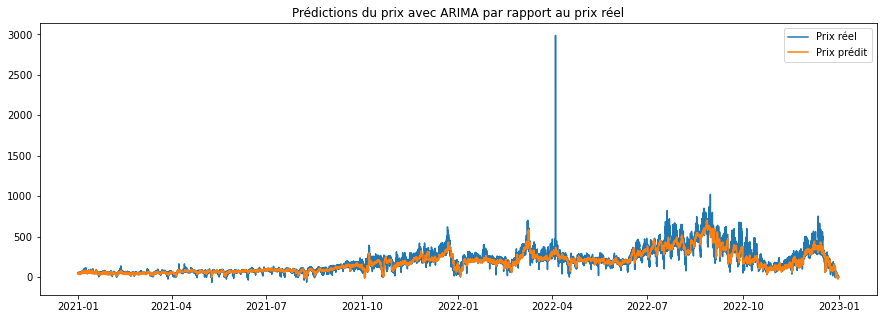

In [12]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.plot(test_data['Date'], predictions, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMA par rapport au prix réel')
plt.show()

In [13]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list = []
for i in range(len(predictions)):
    mae = mean_absolute_error([test_data.iloc[i, 1]], [predictions[i]])
    mae_list.append(mae)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


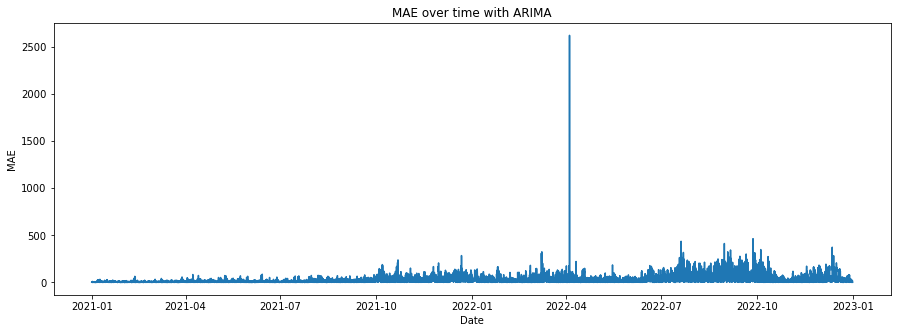

In [14]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], mae_list)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMA')
plt.show()

Le modèle ARIMA-GARCH est souvent utilisé pour modéliser la série temporelle des prix de l'électricité. Les modèles ARIMA sont généralement utilisés pour modéliser les tendances, les saisons et les cycles d'une série temporelle. Cependant, les modèles ARIMA ne prennent pas en compte l'hétéroscédasticité, qui est fréquente dans les séries temporelles de prix de l'électricité, c'est-à-dire la variance variable des erreurs.

D'un autre côté, les modèles GARCH sont utilisés pour modéliser l'hétéroscédasticité conditionnelle, c'est-à-dire la variance variable des erreurs qui dépend de la valeur des erreurs précédentes. Les modèles GARCH peuvent être utilisés pour estimer la volatilité de la série temporelle, ce qui peut être utile pour la prise de décisions en matière de négociation et de gestion des risques.

En combinant les deux modèles, ARIMA et GARCH, on peut obtenir des prévisions plus précises et fiables des prix de l'électricité. Le modèle ARIMA peut être utilisé pour modéliser les tendances et les saisons, tandis que le modèle GARCH peut être utilisé pour modéliser l'hétéroscédasticité conditionnelle et estimer la volatilité future de la série temporelle. Cette combinaison permet de mieux capturer les caractéristiques complexes et dynamiques des prix de l'électricité et d'améliorer la précision des prévisions.

In [15]:
# Create an empty array to store the residuals
residuals = []


# Iterate over each point in the test set
for i in range(len(predictions)):
    # Calculate the residuals
    residuals.append(test_data.iloc[i, 1] - predictions[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am = arch_model(residuals, x=predictions, vol='GARCH', p=1, q=1)
res = am.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts = []
for i in range(0, len(test_data), 24):
    forecast = res.forecast(horizon=24)
    garch_forecasts.extend(forecast.variance.values[-1, :])

print("GARCH forecasts :", garch_forecasts)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 115833.87648356384
Iteration:      2,   Func. Count:     13,   Neg. LLF: 86290.94646110327
Iteration:      3,   Func. Count:     19,   Neg. LLF: 90763.7733950302
Iteration:      4,   Func. Count:     26,   Neg. LLF: 84835.6723410539
Iteration:      5,   Func. Count:     32,   Neg. LLF: 83825.4962314284
Iteration:      6,   Func. Count:     37,   Neg. LLF: 83820.26831318566
Iteration:      7,   Func. Count:     42,   Neg. LLF: 83814.94351536265
Iteration:      8,   Func. Count:     47,   Neg. LLF: 83814.27110218354
Iteration:      9,   Func. Count:     52,   Neg. LLF: 83814.26000442778
Iteration:     10,   Func. Count:     57,   Neg. LLF: 83814.2596629032
Iteration:     11,   Func. Count:     62,   Neg. LLF: 83823.57355376522
Iteration:     12,   Func. Count:     71,   Neg. LLF: 83945.89845219252
Optimization terminated successfully    (Exit mode 0)
            Current function value: 83814.259661188
            Iterations: 14
      

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

GARCH forecasts : [124.42451331425376, 211.98705016285612, 299.5494360110876, 387.11167085920863, 474.67375470747936, 562.2356875561604, 649.7974694055122, 737.359100255795, 824.9205801072694, 912.4819089601956, 1000.043086814834, 1087.604113671445, 1175.1649895302892, 1262.725714391627, 1350.2862882557183, 1437.8467111228238, 1525.4069829932039, 1612.967103867119, 1700.5270737448297, 1788.086892626596, 1875.6465605126787, 1963.2060774033378, 2050.765443298834, 2138.3246581994267, 124.42451331425376, 211.98705016285612, 299.5494360110876, 387.11167085920863, 474.67375470747936, 562.2356875561604, 649.7974694055122, 737.359100255795, 824.9205801072694, 912.4819089601956, 1000.043086814834, 1087.604113671445, 1175.1649895302892, 1262.725714391627, 1350.2862882557183, 1437.8467111228238, 1525.4069829932039, 1612.967103867119, 1700.5270737448297, 1788.086892626596, 1875.6465605126787, 1963.2060774033378, 2050.765443298834, 2138.3246581994267, 124.42451331425376, 211.98705016285612, 299.549

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

Le modèle GARCH peut être utilisé pour estimer la volatilité des résidus de votre modèle ARIMA, ce qui peut aider à mieux comprendre et à améliorer la précision de vos prévisions du prix de l'électricité. En effet, en utilisant les prévisions GARCH pour estimer la volatilité future de l'électricité, vous pouvez prendre en compte les fluctuations imprévisibles de la volatilité et mieux évaluer la fiabilité de vos prévisions de prix.

Par exemple, si le modèle GARCH prévoit une forte augmentation de la volatilité dans un proche avenir, cela peut indiquer une incertitude accrue sur les prévisions de prix de l'électricité, ce qui peut aider à ajuster les attentes et les décisions d'investissement.

En outre, l'utilisation de modèles de volatilité tels que GARCH peut aider à améliorer les performances des modèles de prévision des prix en ajustant les prévisions pour les effets de volatilité, qui peuvent avoir un impact significatif sur les prix de l'électricité.

En résumé, l'utilisation du modèle GARCH peut aider à mieux comprendre et à améliorer la précision de vos prévisions de prix de l'électricité en prenant en compte les fluctuations imprévisibles de la volatilité.

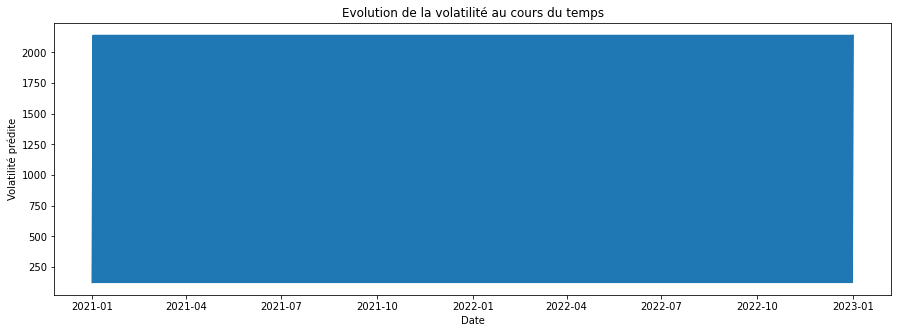

In [16]:
# Plot the volatility over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], garch_forecasts)
plt.xlabel('Date')
plt.ylabel('Volatilité prédite')
plt.title('Evolution de la volatilité au cours du temps')
plt.show()

### Ajustement des prévisions en fonction des effets de volatilité 

Les prévisions ajustées en fonction des effets de volatilité peuvent être obtenues à partir du modèle GARCH. Les prévisions de volatilité du GARCH peuvent être utilisées pour ajuster les prévisions de l'ARIMA en fonction des fluctuations de la volatilité.

En général, on peut ajuster les prévisions de l'ARIMA en multipliant les prévisions par la racine carrée de la volatilité pronostiquée par le modèle GARCH. Cela revient à diviser les prévisions de l'ARIMA par l'écart-type de la série temporelle résiduelle, ce qui normalise les prévisions en fonction des fluctuations de la volatilité.

In [17]:
observations = np.array(garch_forecasts)
# Créer le filtre de Kalman
kf = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means, filtered_state_covariances = kf.filter(observations)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions = filtered_state_means.flatten()

In [18]:
print(filtered_volatility_predictions)

[ 124.42451331  153.99861516  191.55388814 ... 1386.62728992 1449.80337994
 1515.29891281]


In [19]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts = []
for i in range(len(filtered_volatility_predictions)):
    adjusted_forecasts.append(predictions[i] * np.sqrt(filtered_volatility_predictions[i]) * 0.05) #to adjust the scaling factor, decrease of the scaling factor by a factor of 0.05

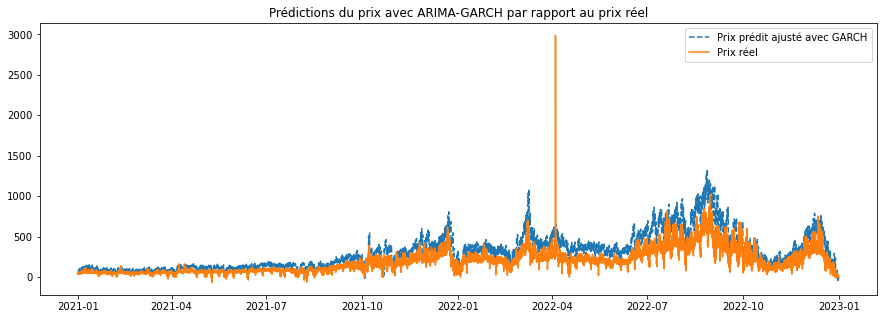

In [20]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data['Date'], adjusted_forecasts, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel")
plt.show()

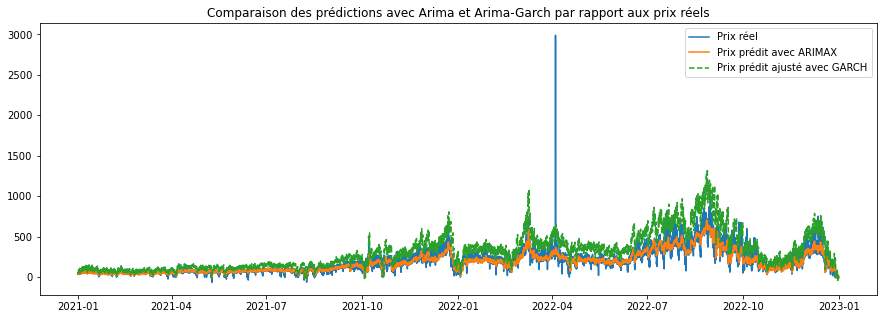

In [21]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data['Date'], adjusted_forecasts, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.legend()
plt.title("Comparaison des prédictions avec Arima et Arima-Garch par rapport aux prix réels")
plt.show()

In [22]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list2 = []
for i in range(len(adjusted_forecasts)):
    mae = mean_absolute_error([test_data.iloc[i, 1]], [adjusted_forecasts[i]])
    mae_list2.append(mae)

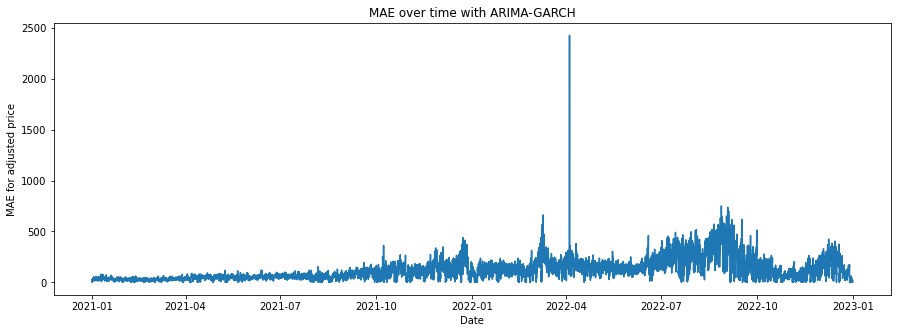

In [23]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], mae_list2)
plt.xlabel('Date')
plt.ylabel('MAE for adjusted price')
plt.title('MAE over time with ARIMA-GARCH')
plt.show()

## Etude de 2019 à 2022 (comparaison entre les données entsoe et les données fournisseurs)

### Données ENTSOE

In [24]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2019-04-15 00:00:00' 
end_date_train2 = '2021-04-15 23:00:00'

start_date_test2 = '2021-04-16 00:00:00'
end_date_test2 = '2022-04-14 23:00:00'

# Sélectionner les lignes entre les bornes de dates
train_data2 = dfb.loc[(dfb['Date'] >= start_date_train2) & (dfb['Date'] <= end_date_train2)]

test_data2 = dfb.loc[(dfb['Date'] >= start_date_test2) & (dfb['Date'] <= end_date_test2)]

In [25]:
train_data2.reset_index(drop=True)

,Date,Prices,Generation forecast,System load forecast
0,2019-04-15 00:00:00,53.97,57280.0,56300.0
1,2019-04-15 01:00:00,42.97,56098.0,54350.0
2,2019-04-15 02:00:00,41.01,54734.0,53650.0
3,2019-04-15 03:00:00,38.90,53711.0,51250.0
4,2019-04-15 04:00:00,37.99,54193.0,50600.0
...,...,...,...,...
17563,2021-04-15 19:00:00,82.89,57828.0,58350.0
17564,2021-04-15 20:00:00,82.90,57035.0,59150.0
17565,2021-04-15 21:00:00,78.00,56825.0,58700.0
17566,2021-04-15 22:00:00,72.25,56324.0,57600.0


In [26]:
test_data2.reset_index(drop=True)

,Date,Prices,Generation forecast,System load forecast
0,2021-04-16 00:00:00,74.52,54932.0,58850.0
1,2021-04-16 01:00:00,69.13,54114.0,56550.0
2,2021-04-16 02:00:00,68.07,53767.0,55950.0
3,2021-04-16 03:00:00,65.87,52883.0,54050.0
4,2021-04-16 04:00:00,62.57,52730.0,53250.0
...,...,...,...,...
8731,2022-04-14 19:00:00,271.07,49972.0,49950.0
8732,2022-04-14 20:00:00,272.31,49951.0,50300.0
8733,2022-04-14 21:00:00,265.46,49095.0,49250.0
8734,2022-04-14 22:00:00,253.68,47860.0,47300.0


In [27]:
# replace missing values with the mean value of the column
test_data2[' Generation forecast'].fillna(test_data2[' Generation forecast'].mean(), inplace=True)
display(test_data2)

# replace missing values with the mean value of the column
train_data2[' Generation forecast'].fillna(train_data2[' Generation forecast'].mean(), inplace=True)
display(train_data2)

C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\2532132216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data2[' Generation forecast'].fillna(test_data2[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
37583,2021-04-16 00:00:00,74.52,54932.0,58850.0
37584,2021-04-16 01:00:00,69.13,54114.0,56550.0
37585,2021-04-16 02:00:00,68.07,53767.0,55950.0
37586,2021-04-16 03:00:00,65.87,52883.0,54050.0
37587,2021-04-16 04:00:00,62.57,52730.0,53250.0
...,...,...,...,...
46314,2022-04-14 19:00:00,271.07,49972.0,49950.0
46315,2022-04-14 20:00:00,272.31,49951.0,50300.0
46316,2022-04-14 21:00:00,265.46,49095.0,49250.0
46317,2022-04-14 22:00:00,253.68,47860.0,47300.0


C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\2532132216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data2[' Generation forecast'].fillna(train_data2[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
20015,2019-04-15 00:00:00,53.97,57280.0,56300.0
20016,2019-04-15 01:00:00,42.97,56098.0,54350.0
20017,2019-04-15 02:00:00,41.01,54734.0,53650.0
20018,2019-04-15 03:00:00,38.90,53711.0,51250.0
20019,2019-04-15 04:00:00,37.99,54193.0,50600.0
...,...,...,...,...
37578,2021-04-15 19:00:00,82.89,57828.0,58350.0
37579,2021-04-15 20:00:00,82.90,57035.0,59150.0
37580,2021-04-15 21:00:00,78.00,56825.0,58700.0
37581,2021-04-15 22:00:00,72.25,56324.0,57600.0


In [28]:
# Set the length of the training set
train_len2 = len(train_data2)
#print(train_len)

# Create an empty array to store the predictions
predictions2 = []

# Iterate over each point in the test set
for i in range(0, len(test_data2), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset2 = train_data2.iloc[:train_len2, :]
    else:
        train_data_subset2 = pd.concat([train_data2.iloc[i:, :], test_data2.iloc[:i, :]], axis=0)
    #print("train data2 :", train_data_subset2)
        
    # Fit the ARIMA model to the training data
    model2 = ARIMA(train_data_subset2.iloc[:, 1], exog=train_data_subset2.iloc[:, 2:], order=(1,1,1))
    result2 = model2.fit()
    
    # Make one-day-ahead forecasts
    forecast2 = result2.forecast(steps=24, exog=test_data2.iloc[i:i+24, 2:])
    print("prédictions2 :", forecast2)
    
    # Store the forecasts in the predictions array
    predictions2.extend(forecast2)
    

C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignore

prédictions2 : 17568    66.412705
17569    64.449547
17570    63.749780
17571    61.843768
17572    61.355446
17573    62.855142
17574    67.083611
17575    71.856030
17576    76.148066
17577    77.621860
17578    76.250449
17579    75.459478
17580    76.097859
17581    75.480814
17582    73.445718
17583    70.709282
17584    67.702883
17585    66.526289
17586    67.683420
17587    69.295076
17588    69.481462
17589    68.375651
17590    67.092494
17591    65.105507
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.318172
17569    66.231744
17570    65.030416
17571    62.995287
17572    62.157285
17573    62.354905
17574    64.739419
17575    66.486984
17576    69.218028
17577    72.278128
17578    72.586839
17579    71.688695
17580    72.650967
17581    72.455640
17582    70.095997
17583    67.503239
17584    64.955496
17585    64.580029
17586    67.178473
17587    68.503658
17588    68.741385
17589    68.903783
17590    69.000294
17591    69.533645
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.681193
17569    65.746932
17570    63.288574
17571    60.911331
17572    59.845549
17573    61.169414
17574    61.664411
17575    62.166721
17576    64.805087
17577    67.953749
17578    69.723140
17579    70.728594
17580    72.037149
17581    70.999979
17582    67.058695
17583    65.752350
17584    63.933051
17585    63.423364
17586    65.990438
17587    67.087572
17588    68.258838
17589    68.880534
17590    69.088559
17591    69.858901
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.559268
17569    75.953088
17570    74.594958
17571    72.952932
17572    72.625848
17573    76.275688
17574    80.852657
17575    87.280573
17576    91.688294
17577    93.180035
17578    92.075869
17579    91.389537
17580    91.439861
17581    90.362188
17582    88.087011
17583    85.463882
17584    83.324598
17585    82.064369
17586    82.561565
17587    83.916427
17588    83.607263
17589    82.408938
17590    81.027847
17591    81.046301
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.466725
17569    75.803059
17570    75.138295
17571    73.818791
17572    73.148502
17573    74.817368
17574    80.152519
17575    86.094791
17576    88.818374
17577    88.522742
17578    88.550109
17579    87.983729
17580    87.806881
17581    86.745359
17582    84.315495
17583    81.688828
17584    80.123038
17585    79.606712
17586    81.564071
17587    84.752424
17588    84.788720
17589    82.904562
17590    80.648603
17591    80.971841
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.060047
17569    68.116506
17570    66.602076
17571    64.870837
17572    64.509368
17573    66.837431
17574    70.569053
17575    74.151086
17576    77.409352
17577    78.712629
17578    78.489003
17579    79.249692
17580    80.700438
17581    80.291517
17582    78.279958
17583    76.757698
17584    75.617673
17585    74.425568
17586    74.886395
17587    76.398428
17588    76.327096
17589    75.462307
17590    74.125773
17591    74.830928
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.923970
17569    67.746295
17570    66.719849
17571    64.433156
17572    63.530008
17573    67.012981
17574    70.410036
17575    73.951020
17576    78.186614
17577    79.635524
17578    80.280175
17579    80.524467
17580    81.388030
17581    80.087636
17582    77.272000
17583    74.325244
17584    71.517157
17585    69.659838
17586    71.237193
17587    73.343981
17588    73.346413
17589    72.940987
17590    72.399826
17591    72.122527
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.177503
17569    66.026796
17570    65.344555
17571    62.683823
17572    63.001975
17573    64.672327
17574    67.775668
17575    71.571678
17576    74.834276
17577    75.107447
17578    74.701102
17579    72.364833
17580    73.039804
17581    71.527953
17582    69.404645
17583    68.658723
17584    66.786476
17585    65.952708
17586    66.846912
17587    69.907650
17588    69.943951
17589    70.046653
17590    69.916366
17591    69.674633
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.210068
17569    58.486960
17570    55.607516
17571    53.636645
17572    52.725688
17573    53.828648
17574    54.394804
17575    55.574866
17576    57.701753
17577    59.165770
17578    58.762491
17579    58.431409
17580    59.603848
17581    58.441973
17582    53.440486
17583    51.288212
17584    51.141111
17585    53.846422
17586    56.081529
17587    58.155712
17588    58.750573
17589    59.528980
17590    59.828933
17591    61.453145
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    61.604215
17569    59.772719
17570    58.019594
17571    55.995355
17572    55.143184
17573    54.949250
17574    56.308026
17575    55.037973
17576    56.887824
17577    57.702279
17578    57.438328
17579    57.620414
17580    57.663400
17581    52.838483
17582    49.189999
17583    47.144813
17584    46.727277
17585    56.688524
17586    59.439150
17587    62.713200
17588    63.646650
17589    63.835757
17590    64.588404
17591    65.533983
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    55.566775
17569    53.601328
17570    52.333276
17571    50.551197
17572    50.134620
17573    53.505800
17574    59.796982
17575    64.075582
17576    66.774585
17577    67.066738
17578    66.428888
17579    66.919980
17580    68.297764
17581    67.683632
17582    65.110269
17583    63.299292
17584    61.358531
17585    61.378659
17586    62.992909
17587    65.119708
17588    64.468196
17589    63.053356
17590    61.706762
17591    61.127117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.805953
17569    56.590466
17570    54.893677
17571    52.496922
17572    52.453618
17573    53.937404
17574    56.948794
17575    59.844215
17576    61.985432
17577    62.991616
17578    63.273198
17579    63.517112
17580    65.009594
17581    63.939505
17582    62.486071
17583    60.624307
17584    58.128756
17585    57.004837
17586    57.730372
17587    58.786088
17588    58.293491
17589    57.469432
17590    56.570536
17591    57.311133
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    54.568276
17569    51.844834
17570    50.887280
17571    49.392475
17572    48.590046
17573    52.552771
17574    55.530912
17575    58.871062
17576    62.225690
17577    63.323010
17578    63.859515
17579    64.156477
17580    64.983563
17581    64.993906
17582    63.254646
17583    61.972666
17584    60.267277
17585    59.188567
17586    59.700240
17587    60.857345
17588    59.497900
17589    57.737315
17590    56.956835
17591    57.336793
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.253564
17569    66.317888
17570    64.935711
17571    62.844608
17572    62.279583
17573    64.998062
17574    69.586371
17575    73.749712
17576    78.089616
17577    80.130572
17578    81.368996
17579    82.303389
17580    82.698935
17581    82.561805
17582    80.770852
17583    78.745393
17584    75.336032
17585    72.946833
17586    74.083707
17587    75.148893
17588    73.903886
17589    73.426319
17590    73.536216
17591    75.004472
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    64.420898
17569    61.223024
17570    60.914032
17571    58.632969
17572    58.103496
17573    60.295673
17574    63.893558
17575    67.287954
17576    71.336347
17577    72.380186
17578    72.162239
17579    72.548882
17580    73.756641
17581    73.633047
17582    72.004623
17583    70.279932
17584    69.108372
17585    68.184157
17586    68.563667
17587    68.968130
17588    67.850909
17589    66.940840
17590    67.547808
17591    69.179889
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    64.093557
17569    60.471176
17570    57.370124
17571    55.369858
17572    53.899987
17573    54.029104
17574    54.410914
17575    53.756900
17576    55.670416
17577    58.488593
17578    59.032557
17579    59.616715
17580    61.632139
17581    61.834550
17582    60.007352
17583    58.579324
17584    57.388552
17585    58.354560
17586    61.540728
17587    63.265058
17588    63.240175
17589    63.153452
17590    63.729911
17591    62.828460
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    57.537992
17569    54.959617
17570    52.916937
17571    50.961872
17572    50.367347
17573    50.197544
17574    50.226956
17575    51.075858
17576    53.989146
17577    58.209129
17578    59.060875
17579    59.068939
17580    59.971210
17581    57.201304
17582    51.177188
17583    48.975222
17584    47.316934
17585    51.707753
17586    55.494659
17587    57.086341
17588    57.004028
17589    56.673593
17590    58.287361
17591    58.783855
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    67.041330
17569    64.520285
17570    62.380719
17571    61.085500
17572    61.093889
17573    66.163058
17574    70.924530
17575    74.804476
17576    78.669756
17577    79.813413
17578    81.584649
17579    83.407281
17580    84.433513
17581    83.497846
17582    81.606217
17583    80.301545
17584    80.178648
17585    79.320574
17586    79.955434
17587    80.032617
17588    78.838080
17589    78.716289
17590    79.111132
17591    81.037807
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    45.948534
17569    41.506181
17570    40.450731
17571    37.514704
17572    36.268658
17573    39.504980
17574    44.559516
17575    50.195139
17576    53.792682
17577    55.548186
17578    56.159124
17579    56.533397
17580    57.119917
17581    56.908591
17582    54.408579
17583    52.294458
17584    50.140804
17585    48.260880
17586    49.135941
17587    49.838728
17588    47.705089
17589    45.546898
17590    45.701616
17591    46.280262
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    68.652098
17569    64.719041
17570    60.642261
17571    58.769328
17572    58.306975
17573    60.545209
17574    65.296732
17575    69.539414
17576    73.957021
17577    76.209169
17578    78.204813
17579    79.239737
17580    80.402378
17581    79.015106
17582    77.838074
17583    75.850037
17584    73.800878
17585    72.555591
17586    73.092260
17587    73.146489
17588    70.860688
17589    69.087414
17590    68.699748
17591    69.309195
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.337385
17569    73.295177
17570    71.408252
17571    69.706777
17572    68.610595
17573    71.850908
17574    76.152532
17575    79.928068
17576    83.372300
17577    84.766245
17578    85.263099
17579    86.268839
17580    88.011854
17581    88.007655
17582    86.329250
17583    84.694820
17584    84.340564
17585    83.889504
17586    84.475580
17587    85.050799
17588    83.691085
17589    81.241658
17590    81.007566
17591    80.698369
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    70.424015
17569    66.642520
17570    65.848755
17571    63.486634
17572    62.973867
17573    66.032818
17574    70.357227
17575    74.005318
17576    76.076831
17577    77.868573
17578    77.764240
17579    78.477306
17580    78.597903
17581    77.394623
17582    74.802734
17583    71.420604
17584    68.741585
17585    67.164707
17586    70.391283
17587    72.031966
17588    70.718418
17589    69.820950
17590    68.757248
17591    69.422537
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.471402
17569    74.270765
17570    71.550086
17571    69.723651
17572    68.890131
17573    69.306427
17574    69.248488
17575    70.281009
17576    73.698189
17577    76.852494
17578    78.624995
17579    80.224771
17580    81.958584
17581    79.544951
17582    74.586300
17583    73.002052
17584    71.288348
17585    71.023199
17586    74.505757
17587    73.971091
17588    71.765916
17589    71.628118
17590    72.753817
17591    73.321891
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    45.045239
17569    40.612999
17570    36.777165
17571    34.706278
17572    33.624656
17573    33.221856
17574    33.066069
17575    34.282513
17576    37.294005
17577    39.977789
17578    41.187178
17579    40.744536
17580    42.119713
17581    41.556832
17582    39.679055
17583    37.641257
17584    36.389120
17585    38.692802
17586    50.259760
17587    52.719374
17588    51.525270
17589    51.638322
17590    52.627738
17591    52.896255
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.389361
17569    47.740406
17570    46.198166
17571    44.965436
17572    44.496032
17573    46.696226
17574    50.819088
17575    54.827784
17576    57.995598
17577    58.716720
17578    58.965597
17579    59.878337
17580    61.534658
17581    60.667832
17582    58.807136
17583    56.628615
17584    54.664011
17585    54.046313
17586    54.580066
17587    55.974666
17588    53.608476
17589    51.998967
17590    52.018746
17591    52.799045
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    63.501912
17569    61.031379
17570    59.301554
17571    57.422352
17572    55.949692
17573    57.994890
17574    62.441326
17575    66.153767
17576    69.286214
17577    71.661138
17578    72.979456
17579    75.101772
17580    76.917314
17581    77.727810
17582    76.136605
17583    74.597895
17584    74.140110
17585    73.617406
17586    73.755329
17587    73.089045
17588    70.455950
17589    68.004752
17590    68.282446
17591    68.575914
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    65.006584
17569    61.495279
17570    60.425685
17571    56.839142
17572    56.036988
17573    57.794102
17574    62.792687
17575    67.121327
17576    70.120473
17577    72.131265
17578    72.850697
17579    73.459669
17580    74.155323
17581    73.983887
17582    72.024153
17583    70.278133
17584    68.395953
17585    67.825307
17586    68.128711
17587    69.009616
17588    67.985249
17589    67.466799
17590    68.168472
17591    69.522046
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.446052
17569    56.900962
17570    55.469436
17571    52.251194
17572    51.577169
17573    51.372390
17574    52.199861
17575    54.276906
17576    57.681295
17577    59.838266
17578    60.650361
17579    62.744348
17580    64.623414
17581    64.147030
17582    61.783443
17583    59.732144
17584    58.211828
17585    57.264882
17586    58.542492
17587    59.109239
17588    58.599721
17589    58.846975
17590    59.355785
17591    59.375423
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.169977
17569    69.244588
17570    67.184017
17571    66.182138
17572    66.647268
17573    68.341761
17574    70.553075
17575    73.805441
17576    77.402725
17577    79.955645
17578    81.393843
17579    82.568851
17580    84.235478
17581    83.773282
17582    80.651091
17583    78.025313
17584    77.190433
17585    79.298557
17586    79.708473
17587    79.847117
17588    78.092661
17589    77.767805
17590    77.854940
17591    78.063774
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.281684
17569    71.736811
17570    69.677405
17571    66.921846
17572    65.872033
17573    65.112402
17574    65.798640
17575    67.982186
17576    70.431989
17577    72.316574
17578    72.425859
17579    73.475922
17580    75.405709
17581    75.182477
17582    73.046618
17583    71.304058
17584    69.686981
17585    70.143259
17586    72.936934
17587    75.458385
17588    74.710057
17589    73.981138
17590    74.137384
17591    74.309628
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    62.248373
17569    59.513896
17570    57.118932
17571    55.191935
17572    53.385317
17573    53.014804
17574    52.268776
17575    52.516511
17576    54.866639
17577    57.412084
17578    59.240208
17579    61.102781
17580    63.294223
17581    60.732315
17582    56.308513
17583    55.337701
17584    55.465485
17585    55.326172
17586    60.396171
17587    65.923576
17588    66.960410
17589    68.111397
17590    69.759989
17591    71.145113
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    60.184584
17569    57.225556
17570    56.826999
17571    54.873497
17572    54.831747
17573    56.486037
17574    62.401797
17575    68.082925
17576    71.218291
17577    72.584182
17578    73.039285
17579    73.212650
17580    74.750321
17581    74.487234
17582    73.035088
17583    71.081409
17584    70.016552
17585    69.214194
17586    68.185983
17587    67.257062
17588    64.451004
17589    62.268745
17590    62.218465
17591    62.069469
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.153175
17569    73.645743
17570    71.930340
17571    69.590780
17572    68.558820
17573    69.501060
17574    73.422982
17575    77.070564
17576    79.039708
17577    80.454209
17578    81.046315
17579    80.676293
17580    81.509406
17581    81.067299
17582    79.683957
17583    78.440405
17584    77.754416
17585    78.274834
17586    79.146643
17587    79.106203
17588    77.082573
17589    76.312638
17590    77.054618
17591    76.944685
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.759871
17569    73.599370
17570    71.704152
17571    68.902891
17572    69.189652
17573    72.481636
17574    77.236730
17575    81.351278
17576    84.712763
17577    86.655810
17578    86.917154
17579    88.553205
17580    89.952757
17581    89.640339
17582    88.317525
17583    86.699473
17584    85.687617
17585    86.328068
17586    87.322281
17587    86.894127
17588    84.069670
17589    82.392226
17590    82.736250
17591    82.418171
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.359623
17569    72.158325
17570    71.950558
17571    71.075834
17572    70.802624
17573    71.257886
17574    72.423365
17575    74.499377
17576    75.573804
17577    75.846963
17578    75.592015
17579    75.300645
17580    75.136749
17581    74.900011
17582    74.189796
17583    73.534214
17584    72.896842
17585    72.350523
17586    72.769367
17587    73.607056
17588    72.896842
17589    72.241259
17590    72.496208
17591    73.352107
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    54.972843
17569    50.850595
17570    48.044868
17571    45.102586
17572    44.694250
17573    47.511686
17574    53.193355
17575    58.767019
17576    62.570952
17577    64.727618
17578    64.780643
17579    63.564993
17580    63.368008
17581    60.666636
17582    59.384025
17583    57.374186
17584    55.369037
17585    59.986190
17586    63.068632
17587    62.279128
17588    59.317197
17589    58.318988
17590    58.967263
17591    58.846358
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    32.472171
17569    25.918692
17570    22.700802
17571    20.459140
17572    21.202153
17573    20.806768
17574    20.590984
17575    22.281868
17576    24.798021
17577    28.763165
17578    30.856636
17579    32.620340
17580    34.122947
17581    32.530217
17582    29.101932
17583    26.758188
17584    25.548878
17585    26.320996
17586    30.559186
17587    31.882401
17588    32.373713
17589    32.188656
17590    33.660925
17591    34.632300
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    61.487675
17569    57.262981
17570    55.360830
17571    51.631239
17572    48.954842
17573    48.090588
17574    47.667520
17575    48.889579
17576    51.122266
17577    53.744258
17578    55.086138
17579    54.447526
17580    54.630551
17581    54.608523
17582    52.420504
17583    50.897042
17584    51.514652
17585    53.232033
17586    61.010285
17587    64.216337
17588    64.456384
17589    64.764983
17590    66.867556
17591    67.151675
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    56.247688
17569    52.751374
17570    49.249707
17571    45.715322
17572    45.744635
17573    45.397054
17574    45.547482
17575    46.449036
17576    49.896802
17577    53.934686
17578    56.120923
17579    57.735331
17580    58.674976
17581    56.819699
17582    55.817558
17583    55.022291
17584    56.053677
17585    58.764737
17586    63.515671
17587    64.398804
17588    63.271498
17589    62.304857
17590    62.729868
17591    63.155380
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    46.932328
17569    45.940630
17570    45.616099
17571    44.850435
17572    44.631955
17573    45.232356
17574    46.505964
17575    48.543739
17576    49.708182
17577    50.108459
17578    50.017487
17579    49.926515
17580    50.017487
17581    50.017487
17582    49.435266
17583    48.671100
17584    48.088879
17585    47.634018
17586    47.925129
17587    48.580128
17588    48.034296
17589    47.615824
17590    47.870546
17591    48.671100
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    64.854418
17569    62.015069
17570    59.522166
17571    58.210647
17572    57.786007
17573    60.651755
17574    65.513307
17575    70.147004
17576    74.169344
17577    76.286783
17578    77.409270
17579    77.946183
17580    78.412146
17581    78.463913
17582    76.018987
17583    72.210311
17584    69.779748
17585    67.939156
17586    68.850075
17587    68.479724
17588    65.413373
17589    64.359744
17590    64.980099
17591    66.369581
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    77.247218
17569    74.184484
17570    71.096047
17571    69.133173
17572    68.747746
17573    71.329177
17574    75.681452
17575    80.339131
17576    84.476683
17577    86.649585
17578    87.534270
17579    88.535552
17580    89.080699
17581    87.918761
17582    86.071155
17583    84.007157
17584    80.473502
17585    81.950166
17586    83.102318
17587    83.340638
17588    80.536026
17589    79.225222
17590    80.213384
17591    81.534321
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.250091
17569    77.031974
17570    76.724046
17571    75.831726
17572    75.423148
17573    75.831596
17574    76.927010
17575    78.690814
17576    79.786229
17577    80.176122
17578    80.009025
17579    79.934760
17580    80.101857
17581    80.027591
17582    79.154973
17583    78.338053
17584    77.762496
17585    77.354036
17586    77.725363
17587    78.245221
17588    77.632531
17589    77.186938
17590    77.521133
17591    78.542283
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.219458
17569    65.672694
17570    63.523240
17571    60.823387
17572    60.029051
17573    59.519435
17574    59.934869
17575    61.683746
17576    64.476860
17577    66.337660
17578    67.886240
17579    68.685380
17580    71.949363
17581    71.228368
17582    67.685511
17583    66.682830
17584    66.883570
17585    68.769078
17586    67.957131
17587    69.608354
17588    68.626008
17589    68.203871
17590    69.518207
17591    69.825488
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.236224
17569    58.268433
17570    57.431373
17571    55.824491
17572    53.789015
17573    53.053738
17574    52.697117
17575    54.081633
17576    57.189769
17577    59.807776
17578    59.363737
17579    57.730470
17580    56.204276
17581    53.610634
17582    50.899699
17583    50.173567
17584    51.043588
17585    56.028753
17586    60.366223
17587    63.147382
17588    62.602220
17589    63.474843
17590    65.688314
17591    66.401373
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.506324
17569    56.949768
17570    55.467676
17571    53.885849
17572    53.526044
17573    57.124447
17574    61.614512
17575    66.092279
17576    69.746465
17577    71.462661
17578    71.118100
17579    71.552796
17580    73.292046
17581    73.646425
17582    72.940159
17583    71.506616
17584    71.714694
17585    72.514212
17586    73.376869
17587    73.620505
17588    71.018657
17589    69.976483
17590    71.337719
17591    71.180406
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    63.735848
17569    60.560522
17570    59.718274
17571    57.796645
17572    57.433699
17573    59.229851
17574    64.510180
17575    68.185989
17576    70.739941
17577    71.576738
17578    71.271178
17579    70.608354
17580    72.373744
17581    73.606009
17582    72.914021
17583    70.925414
17584    69.568411
17585    69.383257
17586    70.491775
17587    70.950960
17588    69.224210
17589    68.044403
17590    68.998408
17591    68.728677
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.457841
17569    55.873980
17570    54.013646
17571    51.111388
17572    51.022716
17573    52.262767
17574    56.748897
17575    61.160092
17576    63.189073
17577    64.196315
17578    62.890670
17579    64.365846
17580    65.852741
17581    65.190252
17582    63.641386
17583    62.259490
17584    62.488392
17585    62.243758
17586    63.918109
17587    63.342652
17588    60.616965
17589    58.443507
17590    58.614709
17591    59.684262
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.037798
17569    56.305641
17570    55.424084
17571    53.382467
17572    51.948648
17573    53.383083
17574    56.312692
17575    61.093305
17576    64.606621
17577    66.842974
17578    68.058815
17579    69.422513
17580    70.931186
17581    70.485708
17582    69.881628
17583    67.631728
17584    65.923806
17585    66.567022
17586    68.109584
17587    68.057793
17588    65.866017
17589    64.332555
17590    64.663682
17591    64.579945
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    67.856126
17569    64.808340
17570    62.416877
17571    59.872191
17572    60.231416
17573    62.753704
17574    68.387172
17575    73.412597
17576    75.998946
17577    76.956917
17578    77.251760
17579    77.397615
17580    78.472607
17581    77.295058
17582    75.364982
17583    74.451847
17584    74.228440
17585    75.191891
17586    77.075941
17587    77.369723
17588    76.362594
17589    75.240503
17590    75.549227
17591    76.168935
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    65.713456
17569    60.522877
17570    57.159540
17571    55.418915
17572    54.807450
17573    54.698409
17574    54.833654
17575    57.210782
17576    61.141749
17577    65.523374
17578    67.630454
17579    68.820836
17580    70.351127
17581    70.033927
17582    68.160818
17583    66.795419
17584    65.688715
17585    64.903629
17586    65.980017
17587    66.071133
17588    64.484237
17589    62.951373
17590    63.381895
17591    64.022504
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    65.305214
17569    61.262188
17570    60.515673
17571    58.131019
17572    57.027092
17573    55.185638
17574    55.649989
17575    56.773003
17576    60.544687
17577    64.110072
17578    67.648972
17579    69.120626
17580    70.594343
17581    70.480395
17582    68.639449
17583    67.333201
17584    67.067504
17585    66.715348
17586    66.608816
17587    69.026594
17588    69.744397
17589    69.060833
17590    70.123208
17591    70.655506
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    65.052016
17569    61.865724
17570    60.521088
17571    59.095909
17572    58.981562
17573    61.598566
17574    67.553803
17575    72.549932
17576    76.544964
17577    78.540304
17578    81.108802
17579    82.210722
17580    83.461080
17581    82.883005
17582    81.009398
17583    79.830331
17584    79.491238
17585    78.990660
17586    78.915040
17587    78.824953
17588    76.308750
17589    74.440927
17590    74.407968
17591    75.885413
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.583626
17569    69.885173
17570    66.949347
17571    65.233568
17572    65.014085
17573    68.011054
17574    72.264364
17575    75.192983
17576    78.754602
17577    81.163825
17578    83.212806
17579    84.699530
17580    86.242913
17581    86.557764
17582    85.528732
17583    83.703748
17584    82.621956
17585    82.816435
17586    82.685810
17587    81.840997
17588    78.951216
17589    77.093699
17590    77.435149
17591    77.928013
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.075872
17569    67.743101
17570    65.444211
17571    62.769825
17572    61.283002
17573    63.476100
17574    68.652557
17575    72.932079
17576    76.962605
17577    79.104745
17578    79.678294
17579    81.622016
17580    83.093838
17581    83.552623
17582    82.455742
17583    80.741070
17584    80.358545
17585    79.886903
17586    80.381676
17587    79.435479
17588    76.035037
17589    74.141036
17590    75.117006
17591    76.148346
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.370340
17569    67.639407
17570    65.589951
17571    63.837093
17572    62.812312
17573    65.048964
17574    70.539221
17575    74.228299
17576    78.003810
17577    79.611071
17578    80.793925
17579    82.211079
17580    83.368936
17581    82.329268
17582    80.843452
17583    79.912980
17584    79.083949
17585    79.271048
17586    80.080758
17587    78.735740
17588    75.997881
17589    74.373531
17590    75.148289
17591    75.071223
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.715582
17569    72.564563
17570    70.294509
17571    68.240043
17572    66.768554
17573    68.085153
17574    73.073866
17575    76.763667
17576    81.102252
17577    83.266070
17578    84.471169
17579    85.618656
17580    86.406809
17581    85.209814
17582    83.406888
17583    82.005640
17584    81.890323
17585    82.146846
17586    83.601975
17587    82.671819
17588    80.339609
17589    78.340524
17590    79.512054
17591    80.358653
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    72.410751
17569    68.924023
17570    67.369731
17571    64.723930
17572    63.158193
17573    62.453584
17574    62.722006
17575    64.692988
17576    67.953049
17577    71.262712
17578    73.046923
17579    72.419298
17580    71.166176
17581    66.819437
17582    64.761128
17583    63.355342
17584    62.712485
17585    66.582976
17586    69.929174
17587    70.047764
17588    68.905904
17589    68.077066
17590    70.471315
17591    72.075437
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    67.967378
17569    64.161713
17570    61.395211
17571    58.245206
17572    56.665805
17573    56.116809
17574    55.962602
17575    57.404762
17576    59.684519
17577    60.321127
17578    61.819955
17579    61.688710
17580    61.808437
17581    60.907108
17582    59.248845
17583    58.620643
17584    60.082417
17585    64.918732
17586    70.482867
17587    72.967322
17588    72.422346
17589    71.221149
17590    73.252852
17591    73.963054
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    70.285916
17569    67.194977
17570    65.646987
17571    63.319113
17572    63.104406
17573    65.786591
17574    70.450580
17575    75.188894
17576    79.622914
17577    80.093813
17578    80.639144
17579    82.037649
17580    83.327858
17581    83.391602
17582    82.172919
17583    81.990704
17584    81.447944
17585    80.918641
17586    81.656044
17587    82.804299
17588    80.120795
17589    78.053979
17590    77.660233
17591    77.288379
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.853530
17569    73.298207
17570    72.019122
17571    70.310755
17572    69.939801
17573    71.565647
17574    75.664807
17575    79.944298
17576    83.721681
17577    85.292453
17578    85.870551
17579    86.568195
17580    87.192326
17581    87.384330
17582    86.539575
17583    86.291996
17584    85.613488
17585    85.748081
17586    86.550697
17587    85.619580
17588    82.818487
17589    80.662108
17590    79.901298
17591    80.824131
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.104074
17569    70.924960
17570    69.763126
17571    67.589560
17572    67.090563
17573    70.003715
17574    73.578824
17575    77.892638
17576    82.384090
17577    84.488697
17578    85.867419
17579    87.042930
17580    88.474360
17581    88.591934
17582    87.808260
17583    87.010166
17584    86.759124
17585    86.616966
17586    86.421468
17587    85.960562
17588    83.115539
17589    81.014540
17590    81.567335
17591    82.776464
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    80.969532
17569    76.659557
17570    75.728792
17571    74.342172
17572    74.131995
17573    75.197785
17574    81.664498
17575    86.878833
17576    90.058859
17577    91.695342
17578    92.530110
17579    92.987610
17580    94.324711
17581    94.630419
17582    93.951806
17583    92.605215
17584    91.430922
17585    91.652907
17586    93.016350
17587    93.469159
17588    90.683146
17589    88.717011
17590    89.297121
17591    88.252207
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    74.042995
17569    70.368101
17570    69.818667
17571    67.904092
17572    66.644042
17573    69.395851
17574    74.872494
17575    79.526353
17576    82.491681
17577    84.701268
17578    85.869542
17579    85.638987
17580    86.797580
17581    86.837383
17582    85.723835
17583    84.382136
17584    82.874092
17585    83.671550
17586    82.729551
17587    81.501089
17588    78.553649
17589    76.356746
17590    76.587499
17591    76.862564
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    72.579717
17569    66.881963
17570    64.523642
17571    62.354703
17572    60.622740
17573    60.705647
17574    63.225533
17575    66.457244
17576    68.996574
17577    72.026310
17578    74.631982
17579    75.229215
17580    75.450460
17581    74.470659
17582    73.047225
17583    71.797171
17584    71.415746
17585    74.250980
17586    76.878669
17587    78.063733
17588    76.290124
17589    75.218848
17590    76.194514
17591    78.275319
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    70.277360
17569    67.232923
17570    65.486467
17571    62.734436
17572    61.381199
17573    60.984433
17574    60.757791
17575    61.543767
17576    63.619820
17577    67.654364
17578    70.432060
17579    71.790535
17580    73.006860
17581    71.320339
17582    69.599915
17583    68.434986
17584    69.516504
17585    70.511868
17586    73.339606
17587    73.634899
17588    72.501551
17589    72.587995
17590    73.685132
17591    74.033152
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.339207
17569    72.098508
17570    71.138715
17571    70.304494
17572    70.107867
17573    72.819164
17574    77.002065
17575    82.971580
17576    88.628594
17577    90.725457
17578    92.703211
17579    94.104581
17580    95.484869
17581    95.521501
17582    93.653146
17583    91.944283
17584    90.846272
17585    91.373506
17586    90.914866
17587    90.970346
17588    88.529018
17589    86.374818
17590    86.229624
17591    86.168506
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    69.280130
17569    65.756942
17570    64.489261
17571    61.931183
17572    62.567239
17573    64.406260
17574    70.564242
17575    75.017986
17576    78.766411
17577    81.501740
17578    82.804987
17579    84.170525
17580    86.061258
17581    86.104150
17582    84.947499
17583    83.811593
17584    82.874001
17585    82.174627
17586    81.752815
17587    81.021265
17588    78.228325
17589    76.962906
17590    77.251282
17591    77.212920
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.797173
17569    72.930527
17570    71.693092
17571    69.538469
17572    68.931906
17573    70.273292
17574    74.004893
17575    79.552674
17576    83.137196
17577    86.376250
17578    87.935010
17579    89.052029
17580    90.062320
17581    89.487711
17582    88.279392
17583    86.836797
17584    86.232765
17585    86.093930
17586    85.983963
17587    84.854777
17588    82.092694
17589    80.632242
17590    81.709568
17591    82.784626
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.769545
17569    74.570862
17570    72.582874
17571    68.959889
17572    68.108489
17573    69.978450
17574    74.968443
17575    80.238110
17576    83.810708
17577    85.959795
17578    87.215616
17579    88.680552
17580    90.175633
17581    89.902752
17582    88.846292
17583    87.986057
17584    86.696613
17585    86.263933
17586    86.199569
17587    85.701797
17588    82.800673
17589    80.862354
17590    81.144266
17591    81.896889
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    82.778215
17569    79.599175
17570    77.843205
17571    75.354480
17572    73.611926
17573    75.537379
17574    80.083775
17575    84.554809
17576    89.086454
17577    92.059299
17578    94.153707
17579    96.121058
17580    97.319602
17581    96.970238
17582    95.700028
17583    94.064343
17584    93.040077
17585    92.173187
17586    91.186751
17587    90.075685
17588    87.685058
17589    85.426228
17590    86.350693
17591    87.565499
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    83.710544
17569    80.641852
17570    77.927210
17571    74.986938
17572    73.146107
17573    72.808842
17574    73.945431
17575    76.106730
17576    79.752897
17577    82.441431
17578    84.999070
17579    85.654184
17580    87.527990
17581    87.191805
17582    85.765033
17583    84.053765
17584    82.435473
17585    82.999653
17586    83.198964
17587    83.377443
17588    81.836186
17589    81.521735
17590    83.765804
17591    85.237929
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    79.029948
17569    74.890729
17570    73.467179
17571    71.152561
17572    69.173372
17573    68.686778
17574    68.269771
17575    69.251625
17576    72.069997
17577    74.716884
17578    75.728348
17579    77.017784
17580    78.517199
17581    78.141634
17582    76.334619
17583    72.467904
17584    71.171103
17585    71.922251
17586    74.617859
17587    77.544171
17588    78.490502
17589    79.229805
17590    80.970214
17591    80.847568
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    80.404720
17569    77.876642
17570    76.907793
17571    75.856359
17572    75.773225
17573    78.302719
17574    82.502903
17575    86.975358
17576    90.618716
17577    93.670572
17578    95.469832
17579    96.887083
17580    98.659484
17581    98.601963
17582    96.730327
17583    95.180140
17584    94.887447
17585    94.830190
17586    94.376380
17587    94.423039
17588    91.126706
17589    88.735830
17590    89.291272
17591    90.739534
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.650646
17569    78.570972
17570    77.054631
17571    75.477462
17572    74.864332
17573    78.010953
17574    82.010000
17575    85.358219
17576    88.242652
17577    91.480259
17578    93.440561
17579    95.488022
17580    97.547547
17581    97.843806
17582    96.370708
17583    94.645790
17584    93.789172
17585    93.536900
17586    93.289809
17587    92.163161
17588    89.279440
17589    86.749584
17590    87.081632
17591    87.675410
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.688683
17569    72.111530
17570    70.489193
17571    68.255102
17572    68.186159
17573    70.583393
17574    75.484393
17575    79.965623
17576    83.868969
17577    86.684014
17578    88.583539
17579    91.277166
17580    93.290993
17581    93.002158
17582    91.175813
17583    89.789466
17584    88.481770
17585    87.263418
17586    86.723367
17587    86.055559
17588    82.574367
17589    79.873299
17590    80.331881
17591    80.112289
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    79.186418
17569    76.351761
17570    74.544954
17571    72.709657
17572    72.310987
17573    73.284076
17574    79.856562
17575    84.248041
17576    87.408112
17577    90.455476
17578    92.183910
17579    94.339639
17580    96.146691
17581    95.879640
17582    94.403449
17583    92.746244
17584    90.700332
17585    89.897710
17586    89.767124
17587    89.212188
17588    85.869583
17589    83.424596
17590    84.611503
17591    84.682649
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    82.526290
17569    78.790092
17570    77.160573
17571    75.544830
17572    74.673074
17573    76.597564
17574    81.792287
17575    86.023949
17576    89.853974
17577    92.171286
17578    94.545858
17579    95.431847
17580    96.256576
17581    96.532718
17582    94.444342
17583    92.692041
17584    90.958090
17585    89.542312
17586    90.243175
17587    89.525897
17588    86.879910
17589    84.895417
17590    85.970533
17591    89.152971
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    88.805532
17569    84.890503
17570    82.310314
17571    80.129006
17572    78.020216
17573    77.655617
17574    77.708805
17575    81.518998
17576    83.880472
17577    86.275368
17578    87.287728
17579    88.171859
17580    90.100198
17581    89.962860
17582    86.609234
17583    86.905179
17584    87.779103
17585    88.704293
17586    89.630377
17587    90.073858
17588    87.999431
17589    86.931700
17590    88.645630
17591    92.028456
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    93.033648
17569    89.570245
17570    87.559552
17571    85.158178
17572    83.384626
17573    83.063410
17574    82.961827
17575    84.298081
17576    84.486035
17577    85.788482
17578    87.271250
17579    89.090741
17580    91.635309
17581    92.279831
17582    91.322071
17583    91.061166
17584    90.345638
17585    90.620728
17586    92.382531
17587    94.106659
17588    93.240276
17589    93.120471
17590    94.556094
17591    96.080471
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     89.218006
17569     86.224712
17570     84.869389
17571     83.174538
17572     82.604376
17573     84.192864
17574     88.074206
17575     93.033300
17576     97.806573
17577    100.116826
17578    102.138605
17579    104.615744
17580    108.176048
17581    109.644517
17582    109.094066
17583    107.864859
17584    106.999725
17585    106.404320
17586    105.534579
17587    104.741644
17588    100.391067
17589     99.089389
17590    101.102023
17591    102.059389
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    87.032120
17569    84.607938
17570    83.493994
17571    81.357717
17572    80.039355
17573    80.992130
17574    84.139135
17575    89.346234
17576    92.700412
17577    94.762979
17578    95.521044
17579    97.021952
17580    99.121706
17581    99.242575
17582    98.115024
17583    96.192119
17584    94.169635
17585    92.974697
17586    91.865682
17587    89.911343
17588    86.643238
17589    84.009025
17590    85.070922
17591    86.951903
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    86.397387
17569    83.186294
17570    81.367311
17571    78.961457
17572    77.516080
17573    78.668062
17574    83.727326
17575    87.176473
17576    90.857084
17577    93.206345
17578    95.293117
17579    96.440782
17580    97.769849
17581    97.276210
17582    95.998274
17583    95.003424
17584    94.218569
17585    94.607326
17586    95.533122
17587    95.325297
17588    92.480670
17589    89.882628
17590    91.145219
17591    92.982217
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     97.173032
17569     93.785949
17570     91.072104
17571     89.130200
17572     88.491253
17573     90.371952
17574     93.859540
17575     98.686151
17576    102.499060
17577    104.544779
17578    106.151026
17579    108.244893
17580    110.446920
17581    109.925281
17582    108.494661
17583    107.294407
17584    105.846782
17585    104.400363
17586    104.318561
17587    103.076918
17588    100.252670
17589     97.922974
17590     99.081435
17591    100.396054
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568     90.802040
17569     85.715116
17570     83.743879
17571     82.194022
17572     81.499784
17573     83.623102
17574     86.886456
17575     91.114217
17576     95.263713
17577     99.022330
17578    100.415305
17579    102.249456
17580    103.024943
17581    102.178157
17582    101.040714
17583     99.573447
17584     97.938345
17585     96.808056
17586     96.632270
17587     95.442117
17588     92.492545
17589     90.771631
17590     90.579515
17591     88.688899
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.574051
17569    78.322743
17570    76.134235
17571    73.353624
17572    72.411172
17573    72.445130
17574    73.024703
17575    74.878419
17576    78.373811
17577    82.244315
17578    84.865762
17579    86.858849
17580    88.494652
17581    88.347512
17582    86.846212
17583    85.638845
17584    85.681302
17585    86.865079
17586    88.487198
17587    88.574376
17588    86.582962
17589    85.271332
17590    86.905182
17591    87.199146
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    88.433961
17569    85.921985
17570    83.746123
17571    81.108898
17572    80.213901
17573    79.582527
17574    79.291660
17575    80.306428
17576    83.590857
17577    87.679549
17578    91.262990
17579    92.955034
17580    94.801779
17581    94.728949
17582    92.896693
17583    91.601246
17584    90.064580
17585    88.797101
17586    90.478457
17587    91.150621
17588    90.444241
17589    90.142146
17590    92.627719
17591    93.518419
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     90.566964
17569     87.701843
17570     86.400681
17571     84.320753
17572     83.678976
17573     86.177004
17574     90.247287
17575     95.116742
17576     99.011473
17577     99.680947
17578    100.758613
17579    102.173702
17580    104.084119
17581    105.020598
17582    104.645053
17583    103.331552
17584    102.438016
17585    103.531314
17586    105.771869
17587    105.860299
17588    103.026721
17589    100.896581
17590    101.139802
17591    101.630528
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     87.932228
17569     84.021755
17570     82.745030
17571     80.507238
17572     80.775398
17573     82.512093
17574     86.207025
17575     90.488920
17576     94.431231
17577     96.623839
17578     97.987895
17579     99.580396
17580    102.547267
17581    103.132842
17582    102.347492
17583    101.357781
17584    100.083554
17585     99.531508
17586    100.021527
17587    100.429912
17588     97.817518
17589     94.935248
17590     96.770400
17591     96.225333
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.580821
17569    76.346274
17570    75.709856
17571    72.008713
17572    69.524340
17573    68.630237
17574    68.463099
17575    70.906951
17576    75.552990
17577    78.787415
17578    81.418456
17579    83.946214
17580    86.965472
17581    87.462326
17582    85.357393
17583    82.827174
17584    81.260798
17585    80.237771
17586    81.303835
17587    81.316348
17588    79.811536
17589    79.320890
17590    80.379202
17591    81.464259
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    70.164339
17569    64.755942
17570    61.812100
17571    59.798456
17572    59.304953
17573    60.206058
17574    65.332675
17575    72.171994
17576    77.346298
17577    80.678739
17578    81.974819
17579    84.373390
17580    85.911052
17581    85.065450
17582    83.547595
17583    82.122886
17584    81.198849
17585    80.188694
17586    79.699293
17587    78.513167
17588    76.253270
17589    74.584198
17590    75.306016
17591    74.425340
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    79.281605
17569    76.033592
17570    74.343418
17571    71.569439
17572    70.527266
17573    72.052918
17574    76.227503
17575    80.172010
17576    83.507809
17577    86.762391
17578    88.395863
17579    90.052974
17580    91.475988
17581    90.987417
17582    89.669375
17583    88.755538
17584    87.877473
17585    87.400922
17586    87.422500
17587    87.046685
17588    83.987394
17589    82.673645
17590    83.467115
17591    82.923939
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.943100
17569    67.547967
17570    66.524573
17571    64.728111
17572    63.886396
17573    64.039307
17574    64.610965
17575    66.440189
17576    70.709996
17577    74.530574
17578    77.341437
17579    79.281674
17580    80.854651
17581    80.720027
17582    77.407837
17583    75.242633
17584    74.167122
17585    75.834284
17586    75.287543
17587    74.024828
17588    71.935210
17589    71.671897
17590    73.615513
17591    75.047028
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    80.859558
17569    77.442816
17570    76.336993
17571    74.307088
17572    73.042288
17573    73.314400
17574    73.260321
17575    74.869648
17576    77.687169
17577    79.161532
17578    81.700101
17579    83.028036
17580    83.355720
17581    82.822879
17582    81.825219
17583    80.978923
17584    80.634100
17585    81.579756
17586    86.450242
17587    86.286577
17588    87.262957
17589    86.975598
17590    87.616110
17591    88.085394
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     85.450282
17569     82.277920
17570     80.464903
17571     79.122615
17572     78.813361
17573     82.141121
17574     86.703809
17575     90.053203
17576     94.282566
17577     97.014008
17578     98.946946
17579    100.792343
17580    102.642466
17581    103.136882
17582    102.269602
17583    101.103053
17584     99.698464
17585     99.377610
17586     99.185049
17587     97.736855
17588     94.637628
17589     92.572423
17590     93.556605
17591     93.461146
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     89.924186
17569     86.438095
17570     84.979246
17571     82.852833
17572     82.485897
17573     84.654088
17574     87.480624
17575     91.716567
17576     96.515545
17577     99.692409
17578    101.266820
17579    103.004816
17580    103.303701
17581    103.223523
17582    102.626572
17583    101.151275
17584     99.481364
17585     99.506997
17586    101.284745
17587    100.655559
17588     98.068080
17589     96.310521
17590     96.924144
17591     97.156391
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.241450
17569    77.252959
17570    75.574001
17571    72.373491
17572    72.393523
17573    73.978015
17574    77.768172
17575    82.341052
17576    86.613956
17577    87.981328
17578    90.723650
17579    93.300462
17580    95.473539
17581    96.286629
17582    95.617550
17583    94.429304
17584    93.831686
17585    94.327704
17586    94.065550
17587    93.826555
17588    90.733690
17589    89.168792
17590    89.570866
17591    89.644780
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    85.548751
17569    81.666079
17570    79.716266
17571    78.097443
17572    77.760253
17573    79.894547
17574    82.395264
17575    87.367371
17576    91.896785
17577    92.847035
17578    94.815297
17579    95.800423
17580    96.968501
17581    97.657782
17582    97.399928
17583    95.671078
17584    94.318473
17585    94.985188
17586    96.191579
17587    95.793819
17588    93.651076
17589    92.278828
17590    93.172599
17591    93.451791
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.227560
17569    66.968293
17570    65.930301
17571    62.604781
17572    62.571574
17573    64.413674
17574    69.427974
17575    72.944676
17576    77.254120
17577    78.348652
17578    79.666552
17579    81.463329
17580    84.577465
17581    84.190196
17582    83.067205
17583    81.884941
17584    80.911815
17585    81.005828
17586    80.904173
17587    80.524996
17588    78.471942
17589    77.473041
17590    77.106540
17591    77.414936
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    81.105691
17569    77.720287
17570    74.832927
17571    72.194449
17572    70.125371
17573    70.051377
17574    70.658639
17575    71.567396
17576    74.064060
17577    77.219707
17578    79.476041
17579    81.065771
17580    82.237181
17581    83.006931
17582    82.018097
17583    81.126695
17584    81.335048
17585    80.681217
17586    80.223221
17587    78.825767
17588    76.933110
17589    75.823070
17590    76.802884
17591    77.610307
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    88.173055
17569    85.845527
17570    82.651858
17571    80.763759
17572    79.775437
17573    79.694029
17574    79.498496
17575    81.025664
17576    84.153772
17577    86.901274
17578    89.702224
17579    92.048642
17580    94.495901
17581    94.793307
17582    93.355629
17583    92.097911
17584    91.177115
17585    91.319908
17586    92.946897
17587    93.531642
17588    93.558249
17589    93.516758
17590    95.166975
17591    94.948235
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    80.972694
17569    77.780813
17570    76.895310
17571    74.957329
17572    75.415628
17573    78.618930
17574    82.159132
17575    87.047773
17576    90.600993
17577    94.064307
17578    96.416127
17579    97.771380
17580    99.267084
17581    99.882077
17582    99.477188
17583    97.915392
17584    96.699379
17585    96.819862
17586    96.746143
17587    95.305699
17588    91.698372
17589    89.923329
17590    89.963612
17591    89.723002
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.419891
17569    72.162827
17570    71.067884
17571    69.104759
17572    68.439774
17573    70.492902
17574    72.355414
17575    75.907352
17576    79.547676
17577    81.711738
17578    82.856921
17579    84.438245
17580    86.767499
17581    87.349979
17582    86.437928
17583    86.455551
17584    85.821122
17585    86.094262
17586    85.885649
17587    85.116272
17588    82.305214
17589    80.095453
17590    80.912284
17591    81.126855
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    74.049393
17569    70.831446
17570    69.418644
17571    66.139202
17572    65.529143
17573    66.623333
17574    70.073066
17575    74.616477
17576    78.324323
17577    82.579623
17578    84.877956
17579    86.582270
17580    87.833173
17581    87.203279
17582    86.914825
17583    84.287466
17584    82.657290
17585    81.778625
17586    84.286320
17587    83.175876
17588    80.626590
17589    78.954164
17590    77.761584
17591    76.301221
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    66.274802
17569    62.786776
17570    60.205632
17571    55.716277
17572    54.998301
17573    57.090893
17574    60.184287
17575    64.301826
17576    67.984119
17577    70.996312
17578    73.117787
17579    75.216295
17580    75.786162
17581    75.856960
17582    74.292116
17583    72.957644
17584    70.906152
17585    69.788988
17586    69.313578
17587    70.734726
17588    68.737783
17589    67.469095
17590    67.641190
17591    67.495499
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    75.810089
17569    73.222732
17570    71.736953
17571    69.336925
17572    68.960114
17573    70.700298
17574    73.968369
17575    79.342945
17576    83.144000
17577    86.077696
17578    86.465502
17579    88.713905
17580    90.968315
17581    92.579271
17582    91.035347
17583    89.328303
17584    87.380805
17585    86.628639
17586    89.388236
17587    87.341750
17588    84.318431
17589    82.420826
17590    83.688382
17591    83.976026
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    59.370170
17569    53.408016
17570    51.043817
17571    46.601352
17572    44.388710
17573    44.482073
17574    44.892174
17575    46.743382
17576    50.071809
17577    51.468654
17578    52.525013
17579    55.614406
17580    57.748594
17581    58.214818
17582    55.164886
17583    52.749167
17584    51.302195
17585    53.377579
17586    59.061496
17587    59.514004
17588    60.201307
17589    59.551980
17590    60.756760
17591    61.472472
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    67.464557
17569    63.440640
17570    61.163866
17571    57.566352
17572    55.706928
17573    55.538765
17574    55.911717
17575    56.884729
17576    60.974916
17577    64.677422
17578    67.673743
17579    69.996092
17580    71.312528
17581    70.578790
17582    67.970626
17583    66.243731
17584    65.562964
17585    66.316571
17586    67.470857
17587    67.479947
17588    66.397038
17589    66.184193
17590    67.314950
17591    67.131856
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    76.329274
17569    72.655353
17570    71.631008
17571    70.106105
17572    69.730438
17573    71.025118
17574    75.372278
17575    78.435260
17576    82.213346
17577    84.134906
17578    85.200619
17579    87.288609
17580    89.128756
17581    89.260666
17582    88.323169
17583    86.384188
17584    85.616416
17585    86.260626
17586    86.121412
17587    85.238754
17588    82.899149
17589    81.757726
17590    82.439433
17591    83.315593
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    85.575583
17569    82.126599
17570    80.182860
17571    77.453122
17572    76.977914
17573    79.242128
17574    80.479949
17575    84.219364
17576    88.712070
17577    90.974805
17578    92.351371
17579    93.992028
17580    95.810930
17581    95.775679
17582    94.353707
17583    93.331911
17584    92.317542
17585    91.631587
17586    92.654390
17587    91.943515
17588    88.706021
17589    87.942135
17590    88.298418
17591    88.117816
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    82.273847
17569    79.008293
17570    77.242159
17571    74.016979
17572    73.157638
17573    74.861031
17574    78.799926
17575    81.955878
17576    85.229846
17577    87.641590
17578    88.223664
17579    89.271497
17580    91.240780
17581    91.315319
17582    90.112007
17583    89.183300
17584    88.401888
17585    88.532261
17586    89.497621
17587    89.692416
17588    87.585026
17589    86.782777
17590    87.597554
17591    88.213396
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    84.609501
17569    79.868271
17570    78.459795
17571    75.839453
17572    74.637047
17573    75.903763
17574    79.545172
17575    82.900416
17576    85.784531
17577    88.283070
17578    90.357999
17579    92.294399
17580    94.768737
17581    95.560786
17582    95.039554
17583    93.846251
17584    92.289847
17585    91.505979
17586    92.284387
17587    91.945073
17588    90.193580
17589    89.739503
17590    90.007085
17591    89.438633
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.538713
17569    55.467142
17570    51.809449
17571    50.426020
17572    50.533873
17573    51.113123
17574    52.758272
17575    57.234959
17576    63.677196
17577    68.982559
17578    71.026437
17579    72.852761
17580    74.525014
17581    72.445710
17582    71.622456
17583    70.421040
17584    66.504728
17585    64.515836
17586    67.109698
17587    70.733355
17588    68.494701
17589    67.639190
17590    67.644746
17591    65.978403
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    61.735026
17569    58.237978
17570    55.533346
17571    53.249277
17572    52.238938
17573    52.145582
17574    53.146041
17575    55.139534
17576    59.231637
17577    63.230955
17578    65.185903
17579    67.405369
17580    69.836806
17581    70.327285
17582    67.980896
17583    65.388979
17584    63.838598
17585    62.493457
17586    64.607635
17587    65.790613
17588    63.178119
17589    62.830379
17590    63.579368
17591    65.898305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    45.261942
17569    39.857426
17570    34.999729
17571    30.925729
17572    28.928453
17573    28.709810
17574    29.354587
17575    29.668823
17576    31.634350
17577    34.404208
17578    37.152846
17579    39.326468
17580    41.470524
17581    41.699766
17582    40.652069
17583    39.443339
17584    38.357586
17585    39.678425
17586    45.419565
17587    47.126467
17588    45.379465
17589    45.043670
17590    45.524949
17591    45.812660
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    54.886523
17569    51.501304
17570    49.195947
17571    47.412480
17572    47.370585
17573    49.422734
17574    52.434552
17575    56.440831
17576    60.095289
17577    62.599579
17578    65.205841
17579    67.438392
17580    69.732329
17581    69.760971
17582    69.794576
17583    68.691972
17584    66.075707
17585    65.772844
17586    65.768023
17587    63.999934
17588    61.442176
17589    60.043117
17590    59.890733
17591    59.364677
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.105265
17569    74.062560
17570    71.943608
17571    70.631494
17572    69.071551
17573    70.083742
17574    73.109239
17575    76.072799
17576    80.748802
17577    84.012370
17578    85.256390
17579    87.614343
17580    89.861705
17581    89.474793
17582    88.395849
17583    86.502619
17584    85.157171
17585    84.974230
17586    85.684586
17587    86.115276
17588    82.829178
17589    82.281171
17590    82.376211
17591    81.220290
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    84.778277
17569    81.683586
17570    79.698047
17571    78.377420
17572    77.873264
17573    78.513729
17574    81.892620
17575    83.980520
17576    88.500072
17577    90.650721
17578    92.795032
17579    94.048923
17580    95.514198
17581    95.836677
17582    95.149528
17583    93.811131
17584    93.622626
17585    93.050801
17586    93.025065
17587    92.588280
17588    89.971972
17589    89.261954
17590    89.758363
17591    90.984688
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     92.937513
17569     89.137985
17570     87.659179
17571     85.358835
17572     85.097142
17573     86.556383
17574     90.799425
17575     92.660038
17576     95.849935
17577     98.133409
17578     99.920601
17579    100.219640
17580    101.658016
17581    102.059867
17582    101.193253
17583    100.495538
17584    101.288710
17585    101.934320
17586    102.911462
17587    101.975712
17588    100.290843
17589     99.691836
17590     99.115003
17591     96.920482
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     97.700107
17569     93.772620
17570     91.803191
17571     89.795190
17572     89.213454
17573     90.656786
17574     93.891148
17575     97.332101
17576    101.128304
17577    103.301354
17578    104.989680
17579    105.602703
17580    107.282483
17581    106.640631
17582    105.862279
17583    104.025240
17584    103.554520
17585    103.884938
17586    104.567270
17587    103.251752
17588    101.240604
17589    100.032609
17590     99.011667
17591     98.277841
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    85.416014
17569    82.129676
17570    81.275174
17571    79.338930
17572    77.552482
17573    77.417680
17574    79.212459
17575    80.228789
17576    83.197888
17577    88.129277
17578    89.562865
17579    90.927384
17580    92.828658
17581    92.211450
17582    91.696152
17583    90.616238
17584    89.502524
17585    89.243096
17586    88.943420
17587    87.514758
17588    86.241860
17589    86.651685
17590    87.178514
17591    86.515731
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    73.354724
17569    70.316774
17570    68.972323
17571    67.341752
17572    65.369328
17573    63.802805
17574    64.002297
17575    64.550937
17576    68.231748
17577    73.132935
17578    77.100287
17579    79.050103
17580    80.330592
17581    78.742516
17582    77.008926
17583    76.471947
17584    77.670008
17585    78.120971
17586    81.414408
17587    81.621820
17588    80.784500
17589    81.044020
17590    80.957719
17591    80.905897
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.244419
17569    65.556464
17570    60.624215
17571    58.552980
17572    57.811342
17573    59.803232
17574    63.747806
17575    69.876515
17576    75.313622
17577    79.678648
17578    81.460809
17579    83.171698
17580    85.388870
17581    85.997487
17582    84.389669
17583    81.866108
17584    80.393796
17585    82.166855
17586    82.593550
17587    80.661760
17588    77.938457
17589    76.601101
17590    76.347614
17591    75.678783
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    79.339089
17569    76.372697
17570    72.982979
17571    70.257415
17572    69.476321
17573    72.766427
17574    74.980348
17575    78.005171
17576    82.146760
17577    85.451241
17578    87.691499
17579    89.701466
17580    92.683381
17581    93.457272
17582    92.998238
17583    91.726753
17584    90.335959
17585    89.722071
17586    88.851846
17587    87.980019
17588    85.767567
17589    84.830124
17590    84.494132
17591    83.649603
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    71.735629
17569    68.383281
17570    66.341352
17571    64.326414
17572    63.868688
17573    65.121113
17574    68.229491
17575    70.892027
17576    74.068179
17577    77.321579
17578    79.187858
17579    80.595015
17580    83.012403
17581    83.297571
17582    82.232541
17583    81.462729
17584    80.488778
17585    79.523312
17586    78.845551
17587    77.666044
17588    75.779778
17589    75.390547
17590    75.007561
17591    74.314048
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.094295
17569    74.648172
17570    73.692670
17571    71.285408
17572    71.102121
17573    73.068677
17574    75.270606
17575    76.990597
17576    81.764228
17577    85.223432
17578    88.517740
17579    90.590301
17580    91.612657
17581    90.827152
17582    89.900543
17583    89.107503
17584    87.849854
17585    87.277427
17586    87.557112
17587    87.575382
17588    85.841572
17589    84.896040
17590    83.634484
17591    82.412894
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     93.733570
17569     90.686997
17570     88.944699
17571     86.290273
17572     85.260356
17573     87.606273
17574     90.118544
17575     93.121044
17576     96.836926
17577    101.035181
17578    103.460758
17579    105.258235
17580    107.066548
17581    106.455453
17582    104.475012
17583    103.223477
17584    101.694334
17585    101.922398
17586    100.576085
17587     99.792770
17588     97.824716
17589     95.727839
17590     95.330825
17591     95.035960
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    100.108284
17569     96.765761
17570     94.703852
17571     92.734445
17572     92.237019
17573     92.216819
17574     92.466245
17575     92.850484
17576     96.350341
17577    100.284876
17578    102.811598
17579    103.986043
17580    105.822568
17581    106.215419
17582    104.806208
17583    104.466953
17584    104.844924
17585    104.639435
17586    105.139872
17587    104.862592
17588    103.096708
17589    101.942407
17590    101.519584
17591    100.715387
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     90.943604
17569     88.137046
17570     87.058549
17571     85.432565
17572     83.873716
17573     83.562804
17574     83.717720
17575     84.010491
17576     87.684720
17577     91.232744
17578     95.146142
17579     97.954119
17580    100.798040
17581     99.823609
17582     97.634977
17583     96.703847
17584     95.194912
17585     94.864448
17586     96.015628
17587     95.008871
17588     93.483924
17589     92.941717
17590     93.755501
17591     95.114766
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    79.228763
17569    76.141973
17570    73.729199
17571    71.948535
17572    70.891313
17573    73.028802
17574    77.443775
17575    80.185077
17576    84.516916
17577    88.205141
17578    90.184233
17579    92.779761
17580    94.651357
17581    94.471827
17582    93.626805
17583    93.004392
17584    91.200532
17585    90.354182
17586    90.385380
17587    89.993736
17588    87.952409
17589    86.304690
17590    85.599879
17591    85.974839
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    77.137510
17569    73.244781
17570    70.059970
17571    66.211051
17572    65.436484
17573    67.417047
17574    73.156113
17575    76.626083
17576    81.055997
17577    85.299457
17578    87.234801
17579    88.842753
17580    91.212472
17581    91.716886
17582    90.201677
17583    88.863911
17584    87.103472
17585    85.502147
17586    86.326062
17587    86.698127
17588    83.889539
17589    83.272373
17590    81.767449
17591    81.047099
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    84.649337
17569    79.268385
17570    75.914718
17571    73.009513
17572    72.143988
17573    75.600491
17574    78.941328
17575    83.048306
17576    86.451246
17577    89.382137
17578    91.186131
17579    91.993024
17580    93.604043
17581    94.018175
17582    92.417272
17583    91.253827
17584    89.522047
17585    88.329544
17586    87.880017
17587    87.782792
17588    85.212632
17589    84.358071
17590    83.632831
17591    83.096394
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     86.878155
17569     83.374209
17570     80.913019
17571     78.436671
17572     78.205708
17573     80.027686
17574     83.963943
17575     87.175323
17576     91.949593
17577     95.846572
17578     97.902012
17579     99.334733
17580    101.618553
17581    102.207669
17582    100.275980
17583     98.236999
17584     96.093930
17585     95.901972
17586     95.556744
17587     94.264786
17588     92.580225
17589     90.983716
17590     90.615487
17591     90.253583
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     90.736489
17569     88.111830
17570     85.659229
17571     82.760327
17572     82.731278
17573     86.150823
17574     89.192042
17575     91.621728
17576     94.973231
17577     98.511261
17578    100.695283
17579    102.518825
17580    104.414126
17581    104.425272
17582    103.279557
17583    101.526704
17584    100.296529
17585    100.225713
17586    100.051099
17587     98.484219
17588     96.907314
17589     95.255889
17590     94.514735
17591     93.837037
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    86.021091
17569    82.862932
17570    80.971174
17571    76.773685
17572    75.420891
17573    75.711064
17574    79.023105
17575    79.921250
17576    84.723514
17577    90.030813
17578    93.070088
17579    94.280231
17580    95.626988
17581    95.438919
17582    94.390586
17583    90.964935
17584    89.678094
17585    90.256828
17586    90.357371
17587    90.921467
17588    89.743800
17589    87.642077
17590    85.937131
17591    86.888881
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    78.055534
17569    75.025461
17570    73.462484
17571    71.274283
17572    69.470346
17573    67.839053
17574    67.136732
17575    67.591062
17576    70.997841
17577    76.425484
17578    81.548141
17579    84.934021
17580    87.541328
17581    86.085808
17582    80.411472
17583    78.807168
17584    77.461662
17585    76.714308
17586    80.235644
17587    81.277220
17588    81.412431
17589    80.482202
17590    80.384711
17591    80.258780
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     83.077757
17569     81.057311
17570     78.978301
17571     77.292084
17572     77.681458
17573     81.053141
17574     86.320280
17575     89.962916
17576     94.750333
17577     98.575871
17578    100.606401
17579    102.550337
17580    103.913143
17581    103.516848
17582    103.004285
17583    101.480135
17584    100.275375
17585     98.930046
17586     99.338948
17587     98.902237
17588     97.137323
17589     95.125984
17590     93.858511
17591     93.767597
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568     93.182179
17569     89.626971
17570     88.760325
17571     87.647128
17572     87.307699
17573     89.603249
17574     95.324691
17575    100.365620
17576    103.578875
17577    106.498147
17578    107.639097
17579    108.815559
17580    109.506013
17581    109.685038
17582    108.512170
17583    106.871725
17584    105.633842
17585    105.044345
17586    105.477762
17587    105.064647
17588    103.440620
17589    101.052502
17590     99.661673
17591    100.053427
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     92.137027
17569     88.174902
17570     85.855233
17571     83.264384
17572     82.666265
17573     84.187961
17574     90.377384
17575     96.522320
17576    101.193152
17577    103.564355
17578    105.029552
17579    106.825292
17580    107.800765
17581    108.047705
17582    106.568700
17583    105.085719
17584    104.291290
17585    103.360924
17586    103.102056
17587    103.577544
17588    102.140142
17589    100.069632
17590     98.669960
17591     98.211509
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     94.210625
17569     89.964930
17570     86.662558
17571     83.206611
17572     82.400358
17573     84.503839
17574     90.850833
17575     98.480731
17576    102.475677
17577    104.017359
17578    104.055042
17579    104.234427
17580    105.405411
17581    104.597493
17582    103.160259
17583    102.075004
17584    102.304105
17585    102.170434
17586    105.238747
17587    104.968340
17588    104.193758
17589    102.401540
17590    100.437770
17591     99.566537
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    105.901444
17569    102.042866
17570     99.399068
17571     97.212027
17572     96.819622
17573     99.168502
17574    104.472412
17575    107.880575
17576    110.580193
17577    110.330099
17578    110.754500
17579    110.578424
17580    111.929618
17581    110.988303
17582    109.627922
17583    108.343764
17584    108.654154
17585    109.907784
17586    111.789451
17587    112.146215
17588    111.914257
17589    108.012075
17590    106.891757
17591    106.069228
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    110.696163
17569    107.065256
17570    105.597953
17571    103.494572
17572    101.641248
17573    102.052570
17574    104.332067
17575    105.151061
17576    107.530382
17577    110.937055
17578    112.703711
17579    113.993699
17580    115.099865
17581    114.492899
17582    112.700681
17583    112.627341
17584    112.603395
17585    113.340614
17586    113.694323
17587    114.198684
17588    112.599355
17589    111.982829
17590    110.639137
17591    110.397549
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    105.923382
17569    102.565854
17570    101.034014
17571     98.716063
17572     97.612938
17573     97.755235
17574     98.164526
17575     98.354100
17576    101.361078
17577    104.718111
17578    107.261333
17579    109.939149
17580    113.255454
17581    112.470239
17582    110.273408
17583    108.965184
17584    111.026720
17585    110.612455
17586    113.898651
17587    114.281160
17588    113.912219
17589    113.415006
17590    112.860894
17591    112.300683
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    106.342913
17569    102.567459
17570    101.664908
17571    100.142876
17572     99.654062
17573    104.210295
17574    110.784115
17575    115.332882
17576    119.221732
17577    121.277377
17578    122.558232
17579    124.208874
17580    124.857058
17581    125.300940
17582    123.748813
17583    123.340809
17584    123.763106
17585    123.390913
17586    123.876899
17587    123.088863
17588    122.193226
17589    121.123785
17590    120.280965
17591    120.806743
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568     97.549183
17569     93.115747
17570     91.927779
17571     89.763514
17572     89.147823
17573     91.913579
17574     96.485328
17575    101.683236
17576    104.809583
17577    106.707903
17578    107.823261
17579    107.431599
17580    108.498832
17581    109.300147
17582    108.599628
17583    107.119935
17584    107.230775
17585    107.696495
17586    108.428905
17587    108.718378
17588    107.765186
17589    106.660217
17590    104.135483
17591    103.248458
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568     98.901077
17569     95.219905
17570     92.663937
17571     89.861921
17572     89.465832
17573     92.304525
17574     99.667857
17575    104.540970
17576    107.403700
17577    108.352140
17578    107.708836
17579    107.623824
17580    109.380287
17581    109.043890
17582    107.970410
17583    106.332026
17584    105.810531
17585    108.347525
17586    108.763090
17587    109.363407
17588    108.144010
17589    105.614513
17590    100.704667
17591     99.789370
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    101.530256
17569     96.684864
17570     94.829359
17571     93.584391
17572     92.469425
17573     95.740482
17574    103.338693
17575    108.559432
17576    111.811364
17577    112.810229
17578    113.046293
17579    114.008501
17580    116.070279
17581    116.513348
17582    115.532183
17583    114.357884
17584    113.628179
17585    112.781438
17586    113.180264
17587    113.101498
17588    112.743609
17589    109.721219
17590    107.355401
17591    105.653505
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    114.594049
17569    111.285762
17570    109.285653
17571    108.083074
17572    108.219888
17573    111.081581
17574    118.513895
17575    123.624795
17576    126.163339
17577    127.889360
17578    128.470691
17579    129.119455
17580    130.208267
17581    130.515169
17582    129.944765
17583    129.239449
17584    129.494403
17585    128.069452
17586    127.577060
17587    126.437827
17588    126.181526
17589    120.902531
17590    117.763988
17591    117.092009
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    124.563944
17569    118.513642
17570    115.895306
17571    113.124600
17572    111.580585
17573    112.136111
17574    115.652893
17575    120.094571
17576    122.922531
17577    127.372781
17578    129.289935
17579    130.785176
17580    130.204974
17581    129.038844
17582    127.121780
17583    124.854076
17584    124.094507
17585    126.501249
17586    128.315076
17587    128.112770
17588    127.015694
17589    125.574815
17590    124.293784
17591    123.113951
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    108.104769
17569    103.990610
17570    101.239090
17571     99.629378
17572     98.920257
17573     98.868879
17574     99.650802
17575    100.157712
17576    104.372708
17577    108.946302
17578    111.437405
17579    113.721861
17580    116.337302
17581    116.340362
17582    114.688402
17583    113.594776
17584    112.433454
17585    112.829763
17586    115.927850
17587    117.196273
17588    117.208982
17589    116.417863
17590    115.078434
17591    113.903558
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    113.953204
17569    110.708766
17570    109.595688
17571    107.724225
17572    108.000790
17573    113.253044
17574    121.116897
17575    126.558064
17576    128.986208
17577    132.302883
17578    132.884909
17579    134.725137
17580    136.032311
17581    135.891138
17582    134.706369
17583    134.030808
17584    133.072285
17585    131.705780
17586    131.939822
17587    132.498362
17588    132.783785
17589    130.363172
17590    128.677809
17591    127.551859
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    120.711594
17569    116.538071
17570    114.993228
17571    113.247455
17572    113.030675
17573    116.255269
17574    124.678190
17575    130.371833
17576    132.715959
17577    133.148095
17578    133.176447
17579    133.660701
17580    134.346424
17581    134.280306
17582    133.499765
17583    133.635711
17584    133.229383
17585    133.618767
17586    133.346596
17587    134.106610
17588    133.450906
17589    129.032064
17590    124.941024
17591    123.676534
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    106.827876
17569    101.667080
17570     98.620726
17571     96.270911
17572     96.740106
17573    100.647138
17574    109.381730
17575    114.520853
17576    116.897861
17577    118.300280
17578    118.810246
17579    119.979572
17580    121.381536
17581    121.758732
17582    120.457082
17583    119.546002
17584    118.371349
17585    117.392478
17586    118.410331
17587    118.753267
17588    116.988075
17589    114.852660
17590    113.250671
17591    112.077954
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    140.706290
17569    137.265043
17570    136.222208
17571    133.470206
17572    133.330709
17573    136.267110
17574    147.590519
17575    152.703846
17576    155.217386
17577    156.904902
17578    158.454754
17579    159.474021
17580    160.771390
17581    160.368394
17582    159.577357
17583    157.995596
17584    156.927980
17585    155.871650
17586    156.102108
17587    156.380994
17588    156.169321
17589    153.840929
17590    148.877106
17591    148.397763
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    125.972683
17569    121.143397
17570    117.157227
17571    114.457914
17572    114.704123
17573    119.547667
17574    127.011081
17575    131.972807
17576    134.806561
17577    137.621386
17578    139.462654
17579    140.085112
17580    139.385499
17581    138.223482
17582    137.033072
17583    135.628276
17584    134.854594
17585    135.117773
17586    135.311525
17587    135.615859
17588    135.480509
17589    131.986490
17590    129.985717
17591    127.649533
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    144.298474
17569    139.907929
17570    136.484423
17571    134.471650
17572    133.201690
17573    133.861896
17574    137.551621
17575    141.110075
17576    143.009923
17577    146.203537
17578    144.995969
17579    145.157350
17580    148.553616
17581    147.470435
17582    144.510061
17583    142.472169
17584    141.280936
17585    143.236635
17586    145.685368
17587    147.619942
17588    148.048503
17589    146.184121
17590    142.537613
17591    143.489058
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    130.279691
17569    127.728237
17570    126.892295
17571    124.862191
17572    124.177584
17573    124.023541
17574    124.647263
17575    125.374461
17576    126.507235
17577    128.264308
17578    132.017451
17579    136.007523
17580    137.669260
17581    137.254673
17582    135.257667
17583    134.310945
17584    134.217432
17585    134.173059
17586    138.125978
17587    141.727976
17588    142.351500
17589    140.198128
17590    139.294939
17591    138.840374
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    123.730320
17569    120.435186
17570    119.372493
17571    117.184015
17572    117.459517
17573    122.651704
17574    132.301338
17575    138.929188
17576    141.844918
17577    146.437121
17578    147.480368
17579    148.211995
17580    148.556653
17581    148.247244
17582    147.056732
17583    146.152579
17584    145.702455
17585    145.687139
17586    146.459341
17587    148.312209
17588    147.637499
17589    144.678704
17590    141.150942
17591    140.225874
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    122.515004
17569    117.199029
17570    115.720691
17571    113.078535
17572    112.676545
17573    115.755018
17574    123.194870
17575    130.254571
17576    131.818881
17577    133.409449
17578    134.208469
17579    132.040210
17580    132.907635
17581    132.576173
17582    131.150950
17583    129.995973
17584    129.878238
17585    129.724941
17586    131.111945
17587    133.475947
17588    133.321249
17589    129.556348
17590    124.537298
17591    123.274161
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    121.885721
17569    118.251512
17570    115.805968
17571    114.763245
17572    115.547074
17573    117.818587
17574    129.529166
17575    135.580566
17576    137.626873
17577    139.385862
17578    140.171711
17579    140.526908
17580    138.440155
17581    137.252786
17582    134.786770
17583    133.630120
17584    131.992381
17585    134.691328
17586    134.680633
17587    135.990903
17588    135.566856
17589    131.411468
17590    125.802630
17591    125.539273
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    133.064816
17569    129.661244
17570    128.281654
17571    126.471977
17572    125.797782
17573    127.238107
17574    131.998265
17575    139.111297
17576    141.907166
17577    143.818916
17578    146.032336
17579    148.153514
17580    149.759256
17581    149.642690
17582    147.717030
17583    144.566121
17584    143.558328
17585    142.807473
17586    142.124387
17587    143.673873
17588    143.755347
17589    140.723606
17590    139.519452
17591    139.691037
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    154.638912
17569    150.703147
17570    148.678084
17571    145.993708
17572    145.550341
17573    148.048247
17574    156.741033
17575    163.230459
17576    166.829716
17577    168.925951
17578    170.102796
17579    171.074167
17580    172.872678
17581    171.868223
17582    169.255248
17583    166.995491
17584    164.711735
17585    165.350019
17586    166.845508
17587    167.181853
17588    166.835111
17589    163.194014
17590    161.209944
17591    160.472879
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    158.949602
17569    154.102453
17570    152.275859
17571    150.960516
17572    150.205579
17573    150.402603
17574    151.837304
17575    154.269857
17576    157.444287
17577    160.616281
17578    160.926402
17579    162.241525
17580    165.391723
17581    164.228943
17582    162.125309
17583    160.317463
17584    159.975158
17585    163.135319
17586    166.783222
17587    169.142472
17588    169.262771
17589    166.945361
17590    166.231956
17591    165.248546
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    151.073604
17569    146.102814
17570    144.060218
17571    140.962247
17572    139.169681
17573    138.868794
17574    139.688795
17575    140.656209
17576    141.788902
17577    144.724137
17578    146.134414
17579    147.857664
17580    149.977069
17581    149.135290
17582    148.291389
17583    148.471104
17584    148.962979
17585    151.897587
17586    156.431627
17587    158.347599
17588    158.764486
17589    156.207381
17590    154.553090
17591    154.061264
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    130.406239
17569    126.034985
17570    125.498658
17571    124.541162
17572    125.544613
17573    129.752398
17574    141.320989
17575    146.812413
17576    149.917637
17577    151.576145
17578    153.215142
17579    154.188294
17580    152.157138
17581    151.048898
17582    148.367877
17583    146.343495
17584    147.318259
17585    149.555272
17586    149.767417
17587    150.414323
17588    147.050147
17589    142.429169
17590    139.041660
17591    136.627062
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    137.157091
17569    135.095231
17570    133.477478
17571    132.067057
17572    132.016253
17573    134.191692
17574    145.370179
17575    152.774314
17576    156.543721
17577    158.456561
17578    159.459928
17579    159.030486
17580    159.869342
17581    159.940581
17582    157.797289
17583    157.221928
17584    156.785093
17585    156.460082
17586    159.498550
17587    162.276870
17588    161.380748
17589    156.277982
17590    150.380290
17591    148.838075
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    126.590456
17569    122.582539
17570    122.173634
17571    121.819916
17572    122.221085
17573    124.323162
17574    131.592040
17575    137.257006
17576    140.683830
17577    143.035750
17578    143.395279
17579    145.072560
17580    146.537840
17581    144.088791
17582    142.364049
17583    140.896048
17584    139.093501
17585    137.593265
17586    138.336860
17587    139.284188
17588    137.088857
17589    133.728604
17590    132.437648
17591    133.158715
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    175.124045
17569    170.514837
17570    169.174777
17571    166.312036
17572    166.496241
17573    169.036410
17574    177.438664
17575    185.721991
17576    187.764171
17577    190.748419
17578    192.769931
17579    193.948170
17580    195.179076
17581    193.865773
17582    192.347314
17583    190.359629
17584    188.479767
17585    188.008051
17586    188.857247
17587    191.224567
17588    188.556261
17589    184.894399
17590    181.615874
17591    182.221248
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    142.182352
17569    138.445185
17570    136.882755
17571    135.094659
17572    134.501766
17573    136.859754
17574    142.875002
17575    153.220099
17576    155.427101
17577    156.679423
17578    157.779608
17579    158.342476
17580    158.455335
17581    156.999209
17582    153.951916
17583    151.296897
17584    150.264826
17585    150.509780
17586    152.573057
17587    154.451448
17588    152.082058
17589    148.004189
17590    146.497007
17591    146.532333
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    168.099664
17569    163.604745
17570    162.089390
17571    160.545767
17572    158.911598
17573    159.420415
17574    163.083552
17575    167.386021
17576    172.195667
17577    177.228500
17578    177.248936
17579    176.340758
17580    176.509461
17581    177.103131
17582    175.094892
17583    174.464792
17584    172.161798
17585    171.500756
17586    171.666298
17587    174.702930
17588    173.924503
17589    169.647365
17590    168.029614
17591    167.684070
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    37.981358
17569    32.791691
17570    31.661420
17571    28.992714
17572    27.982572
17573    27.421813
17574    27.764510
17575    34.239914
17576    37.498854
17577    41.666478
17578    46.787316
17579    49.317811
17580    51.987327
17581    50.326982
17582    46.125027
17583    43.562932
17584    41.487978
17585    41.752794
17586    46.558682
17587    51.389518
17588    51.854472
17589    47.569965
17590    45.659758
17591    46.723550
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    134.127856
17569    133.359824
17570    132.714478
17571    131.861471
17572    132.127822
17573    134.156218
17574    146.901740
17575    157.353377
17576    160.926687
17577    163.523808
17578    166.293668
17579    165.476636
17580    165.883540
17581    165.464778
17582    162.661004
17583    160.328875
17584    160.417634
17585    163.591226
17586    165.136902
17587    168.325730
17588    166.038262
17589    160.075841
17590    154.672534
17591    153.568967
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    123.042371
17569    119.218800
17570    117.474013
17571    116.574019
17572    116.588084
17573    119.873909
17574    127.637462
17575    136.015826
17576    138.495231
17577    138.881182
17578    139.128423
17579    139.760143
17580    141.061678
17581    139.182408
17582    137.114007
17583    134.760568
17584    134.695757
17585    136.127232
17586    136.443210
17587    138.505394
17588    135.596009
17589    125.741282
17590    124.190424
17591    123.722249
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     88.638706
17569     83.566225
17570     82.704414
17571     81.385245
17572     80.941222
17573     82.289739
17574     90.649377
17575    100.628179
17576    103.267486
17577    105.038732
17578    106.904180
17579    108.612608
17580    110.227151
17581    108.852614
17582    106.656156
17583    106.905628
17584    105.544256
17585    105.416336
17586    107.705857
17587    110.548704
17588    106.351978
17589     99.310966
17590     96.964170
17591     98.775323
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    191.554106
17569    187.063600
17570    183.934862
17571    181.913036
17572    183.707026
17573    187.577087
17574    197.205858
17575    206.008551
17576    207.426114
17577    208.864072
17578    209.921486
17579    209.886170
17580    208.103258
17581    207.569535
17582    204.692959
17583    202.914000
17584    200.619555
17585    200.574593
17586    205.149976
17587    208.640776
17588    208.235097
17589    202.480572
17590    196.542579
17591    198.516666
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    252.605960
17569    247.923533
17570    244.510390
17571    241.766006
17572    241.152178
17573    245.683838
17574    254.288223
17575    262.915610
17576    267.504998
17577    266.245919
17578    265.667201
17579    264.295816
17580    263.067031
17581    262.907035
17582    260.087993
17583    257.564126
17584    257.875313
17585    258.639767
17586    259.700727
17587    262.912120
17588    261.286035
17589    256.533285
17590    254.008710
17591    255.422090
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    129.696473
17569    122.728893
17570    120.044374
17571    116.934560
17572    115.774125
17573    116.286263
17574    120.536464
17575    124.736018
17576    126.866391
17577    130.421850
17578    132.065483
17579    132.743691
17580    133.359160
17581    133.152666
17582    130.101327
17583    127.333564
17584    126.101592
17585    127.126117
17586    131.284038
17587    135.091112
17588    134.426036
17589    129.841441
17590    128.911373
17591    130.612185
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    192.434112
17569    189.247326
17570    187.611495
17571    185.237904
17572    184.339030
17573    184.595462
17574    185.638380
17575    188.392097
17576    189.995752
17577    193.113355
17578    196.098210
17579    198.929559
17580    200.815391
17581    199.921447
17582    197.618966
17583    195.875460
17584    195.203111
17585    196.481346
17586    199.642884
17587    204.045892
17588    204.236960
17589    200.568590
17590    198.858700
17591    198.880171
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    148.877256
17569    144.961340
17570    142.871764
17571    140.170262
17572    140.139130
17573    144.943769
17574    157.942526
17575    166.097993
17576    169.578898
17577    171.285018
17578    171.476024
17579    169.533546
17580    169.542088
17581    169.521264
17582    167.920874
17583    165.750392
17584    163.929779
17585    164.727018
17586    165.423875
17587    169.812199
17588    166.970281
17589    161.108331
17590    157.540849
17591    155.659782
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    171.584943
17569    167.986965
17570    165.343340
17571    162.885645
17572    162.443695
17573    164.643557
17574    175.019380
17575    183.616972
17576    186.603146
17577    187.975544
17578    190.323560
17579    191.731230
17580    189.422753
17581    188.445545
17582    185.391437
17583    182.979432
17584    181.438078
17585    183.547283
17586    184.693116
17587    188.677018
17588    186.341616
17589    181.748997
17590    177.368078
17591    178.040620
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    146.014782
17569    140.531383
17570    138.763573
17571    136.903672
17572    136.122121
17573    138.547036
17574    149.848251
17575    156.921629
17576    160.772656
17577    162.009298
17578    163.217738
17579    164.132527
17580    164.492660
17581    164.083406
17582    162.112072
17583    160.176799
17584    158.316183
17585    159.158554
17586    159.870095
17587    164.008779
17588    160.684367
17589    155.552705
17590    153.155954
17591    150.754379
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    185.625974
17569    181.536883
17570    179.787160
17571    176.624973
17572    176.435721
17573    179.009387
17574    190.332093
17575    198.098469
17576    201.456421
17577    202.917102
17578    204.189238
17579    205.033833
17580    203.932533
17581    202.810630
17582    200.192798
17583    196.822079
17584    194.245732
17585    193.954459
17586    195.585595
17587    199.687178
17588    198.094631
17589    193.119342
17590    190.464371
17591    190.493703
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    198.427036
17569    195.801080
17570    192.157161
17571    189.728968
17572    188.388581
17573    192.718895
17574    202.314906
17575    209.120878
17576    211.407980
17577    212.349677
17578    212.694012
17579    213.518574
17580    213.428522
17581    213.075631
17582    210.277943
17583    207.598482
17584    206.255640
17585    206.282574
17586    208.029057
17587    212.994303
17588    212.370940
17589    206.660288
17590    203.110577
17591    202.835039
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    210.429573
17569    207.000493
17570    205.392347
17571    202.791742
17572    200.728384
17573    201.490012
17574    204.371958
17575    209.313500
17576    213.914474
17577    216.826852
17578    217.252440
17579    218.603482
17580    218.855708
17581    218.243962
17582    214.881184
17583    212.536971
17584    210.264362
17585    211.544541
17586    216.175074
17587    220.204896
17588    218.539067
17589    213.883654
17590    211.417190
17591    212.352190
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    195.561106
17569    190.018398
17570    187.981219
17571    183.956457
17572    182.803812
17573    182.895671
17574    184.811058
17575    186.895785
17576    189.689269
17577    193.370753
17578    195.759603
17579    198.035093
17580    199.333140
17581    199.043630
17582    195.244026
17583    192.307230
17584    190.148021
17585    192.554025
17586    197.777423
17587    201.973846
17588    202.116655
17589    197.588882
17590    195.931487
17591    197.726128
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    189.442293
17569    187.491007
17570    186.493371
17571    184.063972
17572    183.925057
17573    186.780065
17574    198.832280
17575    207.940476
17576    212.590832
17577    213.191569
17578    214.555038
17579    215.570789
17580    213.715443
17581    211.787654
17582    208.671654
17583    206.968114
17584    206.043698
17585    208.189690
17586    213.321732
17587    217.901391
17588    213.659884
17589    207.606536
17590    202.483795
17591    200.465834
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    143.050985
17569    137.931711
17570    136.479689
17571    134.669889
17572    133.999505
17573    135.859820
17574    145.960094
17575    154.690969
17576    158.182107
17577    159.112093
17578    158.992866
17579    160.792378
17580    161.386435
17581    158.844059
17582    156.198575
17583    153.875358
17584    151.493338
17585    150.022685
17586    151.791934
17587    157.388217
17588    153.695246
17589    145.972645
17590    141.761316
17591    143.802596
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    49.006158
17569    40.423776
17570    37.823215
17571    38.343110
17572    37.432079
17573    39.596545
17574    46.573626
17575    58.438709
17576    62.082794
17577    63.808155
17578    64.553346
17579    66.699276
17580    66.384955
17581    63.656376
17582    60.500785
17583    58.777533
17584    56.886906
17585    56.848200
17586    62.330964
17587    66.434637
17588    62.281117
17589    55.071435
17590    53.958024
17591    54.380747
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    42.376884
17569    30.790867
17570    27.999408
17571    25.980681
17572    24.401376
17573    28.650688
17574    36.596308
17575    48.876165
17576    52.632235
17577    53.171722
17578    53.978232
17579    55.055670
17580    55.548501
17581    55.151863
17582    51.755667
17583    48.805958
17584    45.820111
17585    44.926698
17586    48.866843
17587    54.444489
17588    50.733851
17589    44.830556
17590    43.192666
17591    43.254110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    184.965297
17569    177.706508
17570    174.732017
17571    172.947348
17572    172.799503
17573    175.932183
17574    187.640519
17575    199.576655
17576    203.033117
17577    204.890551
17578    207.173214
17579    207.616192
17580    207.430545
17581    206.962388
17582    203.518484
17583    198.809912
17584    197.714534
17585    200.283414
17586    203.191855
17587    207.378011
17588    205.746896
17589    200.410000
17590    197.767078
17591    197.491691
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    204.066722
17569    199.451503
17570    196.051403
17571    193.219365
17572    192.109779
17573    192.498628
17574    194.517501
17575    199.133038
17576    200.849546
17577    203.191318
17578    206.592786
17579    206.974757
17580    206.287555
17581    205.502919
17582    202.139462
17583    198.491349
17584    197.521326
17585    202.669467
17586    205.677530
17587    211.358491
17588    209.369806
17589    204.947114
17590    203.946469
17591    204.348333
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    182.002482
17569    174.994000
17570    173.358261
17571    170.295336
17572    168.649535
17573    168.920583
17574    172.584512
17575    174.988232
17576    177.847721
17577    180.391848
17578    182.969405
17579    184.030611
17580    185.025453
17581    181.067387
17582    177.031504
17583    173.839514
17584    173.706546
17585    177.353577
17586    184.253485
17587    191.360877
17588    191.529485
17589    188.703497
17590    187.196417
17591    186.298104
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    181.618195
17569    176.006930
17570    173.226381
17571    171.217802
17572    171.165747
17573    174.971081
17574    187.386781
17575    195.891269
17576    199.529222
17577    201.599994
17578    203.671493
17579    204.909717
17580    205.601583
17581    205.080846
17582    203.348124
17583    200.819957
17584    198.983658
17585    198.693777
17586    202.507264
17587    207.668110
17588    203.449528
17589    197.353543
17590    194.888117
17591    194.499133
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    199.331571
17569    192.361908
17570    190.592324
17571    186.416069
17572    185.947649
17573    188.556279
17574    197.986209
17575    203.974321
17576    209.084012
17577    211.081392
17578    213.390512
17579    213.496901
17580    214.034096
17581    213.494315
17582    210.535074
17583    207.870437
17584    205.966083
17585    205.015684
17586    207.500191
17587    213.394677
17588    210.081209
17589    204.507689
17590    202.544860
17591    201.492663
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    201.649991
17569    197.100370
17570    193.934064
17571    190.674229
17572    189.232857
17573    193.282467
17574    205.470520
17575    215.187975
17576    218.323371
17577    220.158911
17578    221.382438
17579    221.427323
17580    220.872486
17581    220.451087
17582    218.534138
17583    214.777089
17584    211.186766
17585    209.455766
17586    213.417192
17587    219.750058
17588    216.358192
17589    209.673384
17590    208.104513
17591    208.509307
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    189.576448
17569    186.233300
17570    183.565168
17571    180.281268
17572    179.673412
17573    183.566477
17574    195.015320
17575    204.038195
17576    208.819025
17577    210.325143
17578    210.582082
17579    209.673758
17580    209.561379
17581    208.055243
17582    204.817384
17583    201.904232
17584    199.372030
17585    200.997731
17586    204.335583
17587    209.984775
17588    207.967310
17589    198.367044
17590    195.264678
17591    194.993559
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    163.140495
17569    160.325093
17570    157.778525
17571    154.048762
17572    154.347164
17573    156.956318
17574    167.165843
17575    175.478056
17576    181.751335
17577    181.748271
17578    180.725176
17579    179.559184
17580    179.930692
17581    177.601028
17582    174.124591
17583    171.788783
17584    170.173361
17585    169.147447
17586    173.278703
17587    178.715798
17588    175.280971
17589    169.597537
17590    168.144908
17591    166.216933
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    150.823023
17569    144.835480
17570    141.548146
17571    139.405788
17572    139.044812
17573    140.113508
17574    142.650632
17575    146.681203
17576    150.068826
17577    154.215758
17578    157.524545
17579    159.645683
17580    160.920720
17581    158.004122
17582    152.860061
17583    149.315007
17584    146.902472
17585    146.664610
17586    151.916974
17587    156.025949
17588    154.487581
17589    150.380587
17590    148.402668
17591    150.062319
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    121.973085
17569    113.978732
17570    112.954332
17571    112.707614
17572    109.974277
17573    108.599710
17574    109.795036
17575    112.081659
17576    114.248388
17577    117.408657
17578    123.039925
17579    127.145478
17580    128.621215
17581    128.952277
17582    127.785831
17583    124.730038
17584    122.568330
17585    120.732454
17586    122.554400
17587    128.608515
17588    130.418791
17589    127.969908
17590    123.395717
17591    121.105835
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    115.664573
17569    111.089186
17570    108.743964
17571    108.563742
17572    105.165119
17573    103.901890
17574    104.953911
17575    108.286609
17576    110.951935
17577    115.708434
17578    119.689662
17579    122.606403
17580    124.949348
17581    126.654419
17582    124.971052
17583    120.102081
17584    117.658955
17585    119.407948
17586    126.528705
17587    133.411914
17588    134.635306
17589    131.916408
17590    127.051845
17591    126.317229
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    143.314344
17569    140.643479
17570    137.606131
17571    136.734458
17572    135.156980
17573    135.205905
17574    141.256589
17575    151.507134
17576    159.863735
17577    164.918472
17578    166.696033
17579    167.148139
17580    167.987426
17581    168.622039
17582    167.341167
17583    165.934267
17584    165.392993
17585    165.825032
17586    168.876693
17587    174.088899
17588    172.272129
17589    165.169903
17590    159.180413
17591    155.572134
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    175.075477
17569    167.791619
17570    164.043583
17571    162.578555
17572    160.207151
17573    160.457693
17574    163.936266
17575    175.561277
17576    181.628087
17577    185.907228
17578    188.192983
17579    188.120752
17580    188.195713
17581    187.603955
17582    186.506004
17583    183.788747
17584    181.819344
17585    181.437626
17586    185.274730
17587    190.581956
17588    190.082516
17589    182.678015
17590    176.916942
17591    173.855419
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    161.146083
17569    155.153164
17570    150.318404
17571    147.387577
17572    144.563883
17573    144.450888
17574    151.827534
17575    161.108185
17576    169.730395
17577    173.406653
17578    176.039988
17579    176.119240
17580    176.584143
17581    174.788284
17582    173.310385
17583    170.885010
17584    167.043476
17585    165.709534
17586    168.493501
17587    176.607604
17588    177.280651
17589    171.999995
17590    165.206011
17591    164.871105
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    174.411812
17569    164.357264
17570    159.408190
17571    155.075011
17572    151.975831
17573    152.027119
17574    156.326815
17575    169.766628
17576    177.134828
17577    182.441481
17578    185.581465
17579    185.678358
17580    184.788600
17581    184.887168
17582    182.853266
17583    179.713017
17584    176.872017
17585    174.968127
17586    178.325846
17587    183.485106
17588    184.113124
17589    177.907736
17590    172.479568
17591    171.279319
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    185.592555
17569    180.166026
17570    177.804970
17571    175.151041
17572    170.288485
17573    164.567666
17574    164.184532
17575    166.760260
17576    171.506827
17577    174.922731
17578    181.250954
17579    185.379448
17580    185.454171
17581    187.584176
17582    182.696050
17583    177.524969
17584    174.660006
17585    176.042915
17586    181.341951
17587    191.373083
17588    190.517852
17589    187.563667
17590    181.337933
17591    178.955802
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    165.981786
17569    154.181112
17570    151.468439
17571    149.916175
17572    146.646410
17573    145.298786
17574    145.744996
17575    147.740553
17576    148.429856
17577    149.958889
17578    153.063881
17579    156.289624
17580    158.197701
17581    158.041978
17582    155.680365
17583    152.122822
17584    149.853980
17585    151.760511
17586    159.638372
17587    168.948857
17588    171.517725
17589    169.308484
17590    166.139497
17591    164.482597
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    178.740286
17569    175.749600
17570    173.181304
17571    170.832198
17572    168.198160
17573    168.690579
17574    173.514566
17575    185.258963
17576    193.715933
17577    198.179538
17578    199.482050
17579    199.712239
17580    199.717785
17581    199.720741
17582    198.809823
17583    197.208182
17584    195.394842
17585    195.996892
17586    202.411666
17587    207.255296
17588    206.450674
17589    195.783626
17590    188.633740
17591    186.595138
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    183.360667
17569    171.236651
17570    165.767156
17571    163.597807
17572    160.196773
17573    160.713413
17574    165.286335
17575    180.300934
17576    188.257656
17577    191.349179
17578    192.791326
17579    191.236616
17580    191.373222
17581    191.779622
17582    191.010772
17583    188.082823
17584    185.136067
17585    183.120839
17586    189.138636
17587    196.666324
17588    195.879607
17589    188.735920
17590    181.730281
17591    180.666083
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    190.114841
17569    188.099203
17570    184.806966
17571    182.018709
17572    179.852807
17573    179.590669
17574    184.686197
17575    192.194343
17576    200.975212
17577    204.756078
17578    207.041911
17579    205.937594
17580    205.266700
17581    203.968673
17582    200.577810
17583    197.993120
17584    198.031971
17585    199.966530
17586    206.832289
17587    212.018625
17588    211.629231
17589    203.687203
17590    195.079271
17591    192.350303
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    196.716512
17569    190.825809
17570    186.831092
17571    182.350930
17572    179.698818
17573    178.478057
17574    180.425070
17575    187.509367
17576    191.786992
17577    194.500562
17578    197.641909
17579    197.624652
17580    197.746881
17581    199.080066
17582    197.295946
17583    193.043442
17584    189.830526
17585    189.771162
17586    196.347814
17587    203.522765
17588    203.124719
17589    197.974277
17590    193.563400
17591    191.186169
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    173.900116
17569    166.807779
17570    162.399576
17571    159.244462
17572    157.667949
17573    158.032225
17574    161.501970
17575    171.060191
17576    178.668156
17577    181.848411
17578    182.910706
17579    182.285449
17580    183.163979
17581    184.000587
17582    182.658136
17583    179.568992
17584    176.484193
17585    175.016897
17586    179.162633
17587    185.683903
17588    186.293197
17589    182.048735
17590    179.032792
17591    176.422287
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    166.714851
17569    161.506294
17570    154.616971
17571    148.992428
17572    145.102685
17573    142.765589
17574    143.923048
17575    147.119876
17576    153.689445
17577    162.521003
17578    168.670847
17579    170.433072
17580    171.291841
17581    173.039178
17582    172.853667
17583    168.719925
17584    165.207937
17585    163.647725
17586    167.301761
17587    171.537769
17588    170.297129
17589    165.569809
17590    160.167227
17591    160.311670
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    175.984562
17569    171.284538
17570    163.890541
17571    160.708465
17572    157.863344
17573    155.737146
17574    155.712917
17575    156.740823
17576    159.019696
17577    162.626375
17578    167.097462
17579    170.839425
17580    173.082663
17581    175.447813
17582    173.850015
17583    170.320046
17584    168.175409
17585    169.283183
17586    176.856009
17587    182.349281
17588    184.190785
17589    180.950330
17590    176.406805
17591    175.259621
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    172.255637
17569    166.260375
17570    163.593129
17571    162.782878
17572    160.325330
17573    160.321260
17574    167.936674
17575    181.391086
17576    190.761583
17577    195.633221
17578    197.255048
17579    197.546484
17580    198.625176
17581    198.725469
17582    197.993063
17583    195.510568
17584    197.409812
17585    199.531014
17586    203.185260
17587    206.685875
17588    204.520949
17589    194.445457
17590    186.582156
17591    183.623438
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    190.118179
17569    181.001104
17570    176.251768
17571    171.799587
17572    169.366137
17573    168.770569
17574    177.209267
17575    184.730671
17576    194.665317
17577    200.982842
17578    203.684388
17579    203.855701
17580    204.057333
17581    202.650752
17582    201.611583
17583    200.133164
17584    198.043061
17585    199.931004
17586    203.322466
17587    207.336147
17588    205.355226
17589    195.876212
17590    189.784270
17591    187.791936
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    189.786011
17569    184.727857
17570    176.444511
17571    173.583508
17572    169.020566
17573    168.142683
17574    171.152516
17575    186.091646
17576    194.091647
17577    198.556395
17578    199.647671
17579    200.047504
17580    200.098017
17581    199.292275
17582    197.142854
17583    193.889209
17584    190.895373
17585    191.190351
17586    198.070999
17587    202.899242
17588    199.945779
17589    195.312602
17590    191.037699
17591    189.692799
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    213.139579
17569    207.179530
17570    200.288572
17571    196.393162
17572    192.142795
17573    191.368605
17574    198.170445
17575    209.909719
17576    220.255752
17577    224.488871
17578    224.889048
17579    224.862195
17580    223.906694
17581    224.146114
17582    222.513241
17583    219.063159
17584    216.024334
17585    215.351947
17586    222.857501
17587    228.922660
17588    229.383414
17589    224.310128
17590    218.845557
17591    215.404692
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    237.603530
17569    231.999662
17570    226.903416
17571    224.355026
17572    221.680305
17573    221.581239
17574    224.007711
17575    234.601952
17576    243.983977
17577    246.244219
17578    247.726787
17579    246.696698
17580    246.327147
17581    245.697111
17582    244.726152
17583    241.553175
17584    237.818350
17585    236.072255
17586    241.084032
17587    245.133207
17588    246.757616
17589    241.541693
17590    236.636828
17591    233.882588
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    225.784847
17569    221.318252
17570    217.060187
17571    213.842645
17572    211.025214
17573    209.253921
17574    210.015446
17575    213.339432
17576    215.857968
17577    219.429183
17578    223.065844
17579    225.458425
17580    225.884552
17581    227.753594
17582    226.523760
17583    221.228081
17584    216.950168
17585    215.197948
17586    220.497851
17587    226.728533
17588    228.442785
17589    224.429643
17590    219.131294
17591    218.120807
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    240.255910
17569    238.413912
17570    234.226397
17571    229.373152
17572    225.033579
17573    224.012423
17574    223.479283
17575    225.409248
17576    227.668520
17577    230.023402
17578    231.786257
17579    234.238664
17580    236.496230
17581    239.511860
17582    238.429440
17583    233.913611
17584    231.506139
17585    232.649232
17586    239.577469
17587    246.555516
17588    248.661820
17589    245.858409
17590    240.999640
17591    240.122817
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    210.011266
17569    205.965811
17570    203.646337
17571    202.538093
17572    199.858992
17573    200.256376
17574    204.308440
17575    216.100589
17576    226.003362
17577    230.246512
17578    232.618397
17579    233.761850
17580    234.199919
17581    234.694711
17582    234.641814
17583    232.235595
17584    230.326791
17585    230.028126
17586    234.258070
17587    238.046428
17588    238.254236
17589    230.658841
17590    224.125378
17591    219.201529
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    227.489291
17569    221.140916
17570    217.255010
17571    215.916812
17572    213.779971
17573    213.795822
17574    215.814143
17575    226.272620
17576    237.477229
17577    241.164942
17578    243.290971
17579    243.516786
17580    243.463908
17581    244.443546
17582    242.637376
17583    240.371342
17584    237.656694
17585    238.062983
17586    242.658287
17587    246.731612
17588    246.365601
17589    239.216757
17590    231.267048
17591    226.235073
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    232.459505
17569    227.315988
17570    223.586306
17571    221.974848
17572    219.368220
17573    219.348132
17574    222.151678
17575    230.501746
17576    243.292380
17577    245.993783
17578    246.538044
17579    245.952687
17580    245.093918
17581    244.295498
17582    242.666511
17583    239.666945
17584    238.274833
17585    237.960129
17586    246.197606
17587    251.281765
17588    252.284558
17589    243.593812
17590    232.681829
17591    228.471923
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    242.812413
17569    234.244253
17570    230.466721
17571    227.522565
17572    224.786874
17573    223.409505
17574    225.751214
17575    239.353278
17576    252.286176
17577    257.792224
17578    259.410231
17579    256.562959
17580    256.919295
17581    257.730838
17582    257.056639
17583    254.998462
17584    252.226475
17585    251.057960
17586    255.826794
17587    262.332483
17588    262.150456
17589    253.119728
17590    242.178625
17591    238.484258
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    259.046289
17569    254.100479
17570    250.087781
17571    247.641697
17572    243.639277
17573    243.396341
17574    246.569617
17575    256.228528
17576    267.347268
17577    273.349073
17578    276.520452
17579    276.787719
17580    278.053012
17581    277.960409
17582    276.843313
17583    274.324716
17584    271.635271
17585    270.529741
17586    272.442126
17587    276.095904
17588    275.208982
17589    269.279163
17590    264.086952
17591    261.608877
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    258.306561
17569    253.761638
17570    244.925358
17571    240.693448
17572    237.103259
17573    236.059587
17574    236.292410
17575    239.983321
17576    248.491377
17577    254.845814
17578    259.763309
17579    262.450650
17580    263.730264
17581    264.738551
17582    264.717976
17583    260.492908
17584    258.354975
17585    256.885253
17586    261.048252
17587    264.126134
17588    263.197459
17589    256.849103
17590    251.386924
17591    250.335934
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    216.134691
17569    211.794587
17570    207.099544
17571    205.252547
17572    202.633472
17573    203.383918
17574    204.607362
17575    206.504813
17576    207.889865
17577    209.971279
17578    216.504517
17579    221.757152
17580    224.738227
17581    226.298815
17582    224.188469
17583    218.879851
17584    215.588671
17585    216.271824
17586    223.525625
17587    228.575089
17588    229.874694
17589    224.568279
17590    220.670402
17591    217.041673
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    209.440534
17569    203.643363
17570    200.736686
17571    200.591522
17572    198.248960
17573    198.046889
17574    204.247043
17575    216.885326
17576    231.027518
17577    237.263342
17578    239.275645
17579    239.345747
17580    238.859861
17581    237.000107
17582    234.702003
17583    231.535840
17584    229.095149
17585    230.106985
17586    239.538640
17587    242.924358
17588    240.334001
17589    228.675167
17590    220.307409
17591    216.627358
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    257.099663
17569    254.884933
17570    252.311826
17571    250.565653
17572    248.450336
17573    249.212698
17574    253.637652
17575    266.168950
17576    279.377262
17577    284.049183
17578    286.795984
17579    285.600627
17580    285.916156
17581    284.550867
17582    283.128935
17583    278.453437
17584    273.676475
17585    272.796850
17586    277.094747
17587    280.721855
17588    280.270147
17589    273.339426
17590    266.075237
17591    264.041367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    232.075889
17569    227.414986
17570    223.116680
17571    221.319734
17572    216.952802
17573    216.516926
17574    220.709064
17575    230.957764
17576    242.162423
17577    249.446420
17578    250.715413
17579    248.736175
17580    248.576059
17581    247.032112
17582    245.293859
17583    241.989518
17584    239.864054
17585    237.534189
17586    240.004680
17587    243.742065
17588    243.817076
17589    236.720197
17590    227.642939
17591    223.810133
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    266.495813
17569    260.874620
17570    255.233964
17571    254.068498
17572    250.892711
17573    248.975815
17574    253.474748
17575    264.726187
17576    279.181796
17577    285.636228
17578    288.242246
17579    288.811718
17580    288.509968
17581    288.698606
17582    287.499427
17583    284.214455
17584    281.568280
17585    281.656699
17586    288.136428
17587    292.254573
17588    292.906507
17589    285.000916
17590    275.308604
17591    272.600888
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    266.414326
17569    258.052463
17570    252.127080
17571    249.576801
17572    247.525556
17573    246.323224
17574    252.645945
17575    263.106054
17576    276.735868
17577    281.884755
17578    284.447322
17579    284.917260
17580    284.518915
17581    285.651254
17582    284.456407
17583    281.118506
17584    278.771548
17585    277.926619
17586    279.454696
17587    283.066129
17588    282.104031
17589    274.764185
17590    268.255306
17591    264.297115
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    231.324503
17569    224.495002
17570    213.670555
17571    210.194271
17572    207.527892
17573    205.394681
17574    205.164830
17575    207.844908
17576    214.272048
17577    218.555127
17578    224.355782
17579    227.822645
17580    229.523839
17581    229.934802
17582    228.201128
17583    223.960406
17584    220.939891
17585    221.291148
17586    228.202209
17587    232.849983
17588    232.975933
17589    225.381299
17590    218.582798
17591    216.165812
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    225.686115
17569    221.632470
17570    215.909338
17571    212.715307
17572    209.050116
17573    205.984346
17574    206.463046
17575    209.225398
17576    215.276630
17577    219.406500
17578    225.250510
17579    229.566006
17580    231.732106
17581    234.839881
17582    234.042986
17583    229.240872
17584    226.099067
17585    225.633798
17586    231.099164
17587    235.136252
17588    236.937939
17589    232.965518
17590    228.948546
17591    226.736352
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    245.376618
17569    244.758519
17570    240.139847
17571    236.986000
17572    233.194518
17573    231.355355
17574    238.155486
17575    249.099139
17576    264.356841
17577    270.650354
17578    272.459421
17579    272.405896
17580    274.228678
17581    273.562207
17582    272.382068
17583    269.764901
17584    267.449294
17585    267.655534
17586    271.783279
17587    276.823727
17588    276.952714
17589    266.468916
17590    259.869958
17591    255.620818
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    231.551906
17569    226.298211
17570    222.871549
17571    220.082631
17572    215.903033
17573    214.538747
17574    216.866796
17575    226.267765
17576    238.244213
17577    241.455154
17578    242.572164
17579    242.847869
17580    244.163449
17581    245.342074
17582    244.432907
17583    241.612469
17584    239.750410
17585    241.905497
17586    246.951629
17587    251.662996
17588    250.204595
17589    238.601874
17590    231.904367
17591    229.757048
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    223.123194
17569    214.609980
17570    212.009594
17571    211.100027
17572    206.988279
17573    205.362640
17574    207.900147
17575    220.104705
17576    235.945924
17577    236.377317
17578    238.387000
17579    238.101969
17580    239.313704
17581    239.472112
17582    237.427940
17583    234.787571
17584    232.221889
17585    231.121380
17586    235.665903
17587    240.561110
17588    241.640752
17589    233.531825
17590    226.340879
17591    221.116094
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    237.136886
17569    229.283155
17570    225.396270
17571    223.210540
17572    219.557834
17573    219.961659
17574    226.706895
17575    241.694316
17576    254.491238
17577    260.145748
17578    261.705195
17579    262.261970
17580    262.949962
17581    262.702465
17582    261.148497
17583    257.315790
17584    254.649478
17585    253.768340
17586    258.213820
17587    261.206073
17588    259.886539
17589    253.070436
17590    244.186681
17591    240.020525
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    226.411858
17569    222.215487
17570    219.414022
17571    217.123431
17572    213.837891
17573    213.099812
17574    217.933399
17575    233.025864
17576    244.327330
17577    249.335160
17578    251.937436
17579    253.499146
17580    253.703489
17581    254.879022
17582    254.173574
17583    249.375623
17584    246.198660
17585    247.331034
17586    252.357746
17587    253.006554
17588    251.674992
17589    240.833192
17590    234.357540
17591    229.288380
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    234.938261
17569    228.050475
17570    223.119055
17571    219.341560
17572    213.902705
17573    211.931213
17574    212.326289
17575    213.993074
17576    222.805352
17577    226.420712
17578    230.783818
17579    234.345953
17580    235.388438
17581    236.837615
17582    234.753488
17583    230.317559
17584    227.658187
17585    226.335057
17586    231.487217
17587    235.620016
17588    236.774943
17589    231.337346
17590    226.822673
17591    226.289161
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    241.230058
17569    238.470704
17570    234.475416
17571    227.545239
17572    222.809877
17573    220.858724
17574    220.712675
17575    222.428867
17576    225.018285
17577    229.846269
17578    234.819550
17579    238.357784
17580    240.035767
17581    242.170231
17582    238.391288
17583    231.833092
17584    228.249391
17585    230.070900
17586    238.552759
17587    243.507829
17588    245.013942
17589    241.157418
17590    235.397823
17591    233.755498
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    246.578258
17569    236.274690
17570    233.992006
17571    232.625292
17572    230.111823
17573    230.364093
17574    239.055224
17575    252.375284
17576    264.255403
17577    270.753974
17578    272.789605
17579    272.286580
17580    272.600604
17581    272.706641
17582    270.467513
17583    266.000546
17584    262.411666
17585    262.284430
17586    269.445325
17587    277.095762
17588    277.663817
17589    268.047328
17590    260.277466
17591    257.359701
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    285.763555
17569    280.975455
17570    277.590049
17571    274.274253
17572    270.370489
17573    269.132018
17574    272.830803
17575    284.251085
17576    294.904023
17577    301.353837
17578    302.356579
17579    303.224700
17580    304.729366
17581    305.679099
17582    304.319015
17583    299.978626
17584    295.457343
17585    295.685952
17586    301.463377
17587    306.068942
17588    302.447090
17589    294.143486
17590    287.157042
17591    285.350885
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    292.713918
17569    288.087926
17570    282.290871
17571    278.977809
17572    274.826533
17573    273.761038
17574    278.581145
17575    290.002176
17576    303.124865
17577    309.887499
17578    310.205691
17579    309.123619
17580    309.947872
17581    311.111355
17582    307.744208
17583    302.289111
17584    299.145341
17585    299.412879
17586    306.431763
17587    312.583956
17588    312.163008
17589    303.940155
17590    296.060541
17591    293.123389
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    308.846751
17569    300.374726
17570    296.158380
17571    292.136286
17572    288.752280
17573    287.257620
17574    294.182428
17575    307.387245
17576    318.464224
17577    326.262681
17578    329.325335
17579    330.518146
17580    330.916793
17581    330.744233
17582    329.005877
17583    325.314760
17584    322.201732
17585    323.551955
17586    327.822044
17587    332.643996
17588    331.428743
17589    322.190611
17590    315.984552
17591    313.958571
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    280.481767
17569    264.648049
17570    256.580403
17571    255.332389
17572    253.634140
17573    253.658432
17574    257.408788
17575    274.016701
17576    285.500537
17577    290.982783
17578    293.706739
17579    295.481260
17580    297.173691
17581    298.008192
17582    294.329717
17583    290.460698
17584    286.568272
17585    286.313846
17586    290.952198
17587    295.264662
17588    294.700677
17589    287.549196
17590    282.216643
17591    280.580943
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    293.933292
17569    283.263699
17570    276.062666
17571    269.495261
17572    265.621103
17573    264.550388
17574    265.143515
17575    266.543334
17576    274.156628
17577    279.045685
17578    284.349072
17579    288.346500
17580    288.147800
17581    288.268505
17582    286.181126
17583    280.732132
17584    276.299827
17585    274.406678
17586    281.542093
17587    286.721991
17588    288.016711
17589    284.570532
17590    280.363246
17591    279.820414
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    320.885734
17569    319.141666
17570    313.103219
17571    311.547596
17572    307.486637
17573    306.067760
17574    305.494412
17575    304.958738
17576    307.612786
17577    311.238893
17578    316.715212
17579    323.482825
17580    326.513529
17581    327.855170
17582    324.163490
17583    316.909493
17584    310.720300
17585    313.672516
17586    319.017901
17587    326.278000
17588    330.245384
17589    323.586978
17590    318.720952
17591    316.848639
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    321.130404
17569    314.278836
17570    308.232707
17571    306.657614
17572    303.982366
17573    303.288516
17574    307.300904
17575    321.226192
17576    330.186656
17577    336.992543
17578    341.905834
17579    343.692006
17580    343.495654
17581    344.038407
17582    342.859190
17583    340.072055
17584    339.216790
17585    340.655489
17586    344.873119
17587    349.932002
17588    348.247673
17589    339.534914
17590    331.500490
17591    328.980629
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    343.187147
17569    337.882039
17570    334.553225
17571    331.364138
17572    324.884358
17573    324.796850
17574    330.694069
17575    342.457431
17576    355.994572
17577    364.203457
17578    365.283922
17579    365.013318
17580    365.428701
17581    365.031063
17582    362.879528
17583    358.173237
17584    355.994534
17585    354.679592
17586    362.653023
17587    368.177566
17588    367.376904
17589    360.849777
17590    349.963677
17591    346.909053
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    395.333099
17569    388.377967
17570    382.152399
17571    380.780398
17572    376.593184
17573    375.545517
17574    377.952317
17575    391.608976
17576    404.586773
17577    412.650181
17578    414.418577
17579    414.509676
17580    412.737989
17581    414.755292
17582    410.077812
17583    405.243670
17584    402.139771
17585    400.920422
17586    407.418954
17587    412.416337
17588    413.764043
17589    406.683486
17590    398.371182
17591    395.916444
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    374.703277
17569    366.688916
17570    361.441899
17571    359.198771
17572    355.102564
17573    353.019734
17574    355.179982
17575    367.685119
17576    375.903966
17577    383.264784
17578    386.629221
17579    386.620167
17580    385.313928
17581    385.187431
17582    382.804638
17583    377.420323
17584    372.723886
17585    371.689236
17586    375.734724
17587    381.881184
17588    383.758990
17589    376.986746
17590    371.691450
17591    367.551826
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    387.368304
17569    376.788235
17570    370.515859
17571    367.556301
17572    361.593048
17573    360.337335
17574    362.660547
17575    375.980217
17576    381.762600
17577    385.920053
17578    389.614129
17579    392.968836
17580    393.855899
17581    394.636432
17582    390.630526
17583    385.376076
17584    381.359992
17585    379.120630
17586    383.281713
17587    386.989876
17588    386.779487
17589    382.014392
17590    374.551321
17591    372.149759
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    294.809203
17569    287.314291
17570    281.349285
17571    278.639008
17572    273.980005
17573    271.026548
17574    270.216040
17575    270.291172
17576    273.868799
17577    277.636411
17578    279.922527
17579    286.841452
17580    291.026854
17581    295.392851
17582    292.582352
17583    285.756479
17584    282.200207
17585    283.467701
17586    289.103655
17587    294.036820
17588    296.380924
17589    293.559396
17590    290.085884
17591    290.261299
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    228.009361
17569    227.363195
17570    222.707884
17571    215.215846
17572    210.348345
17573    209.181761
17574    209.062888
17575    210.868483
17576    212.509806
17577    219.682007
17578    228.401563
17579    236.461428
17580    240.119101
17581    243.452466
17582    242.595064
17583    235.425021
17584    231.035945
17585    229.683966
17586    233.795681
17587    240.627805
17588    242.328670
17589    240.041471
17590    234.943737
17591    233.114548
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    181.731172
17569    180.812077
17570    175.393750
17571    168.972885
17572    165.630363
17573    165.345822
17574    167.811765
17575    181.027040
17576    191.788543
17577    196.746068
17578    200.019043
17579    205.575450
17580    209.009480
17581    212.243358
17582    213.732179
17583    213.520129
17584    211.316295
17585    212.248862
17586    215.371495
17587    217.295015
17588    213.999324
17589    203.670453
17590    197.937433
17591    193.841014
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    108.038179
17569    104.301669
17570     98.100596
17571     94.283107
17572     89.289287
17573     87.419132
17574     90.680824
17575     98.679872
17576    103.171362
17577    114.358434
17578    117.327839
17579    118.478734
17580    118.823388
17581    120.838259
17582    117.766366
17583    112.271972
17584    109.034376
17585    110.950948
17586    117.971263
17587    124.246386
17588    124.536731
17589    117.999699
17590    108.145852
17591    104.218587
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    128.489896
17569    125.356236
17570    122.051048
17571    119.131434
17572    115.254057
17573    112.791425
17574    115.748162
17575    129.361118
17576    136.406381
17577    145.520837
17578    150.133656
17579    152.853104
17580    155.370345
17581    159.092591
17582    154.858387
17583    148.423317
17584    145.458103
17585    146.279151
17586    150.593910
17587    156.284847
17588    154.841774
17589    143.537067
17590    130.487937
17591    127.024543
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    106.681063
17569    104.543024
17570    100.385942
17571     94.575844
17572     86.386885
17573     85.496758
17574     86.740658
17575     93.376622
17576    101.743391
17577    110.055191
17578    114.437825
17579    117.355560
17580    119.207464
17581    122.529629
17582    121.078420
17583    115.720619
17584    111.323519
17585    108.783333
17586    112.783904
17587    118.686333
17588    121.396066
17589    115.839647
17590    106.047497
17591    104.576811
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    156.758332
17569    152.562135
17570    147.292144
17571    143.961171
17572    137.341913
17573    134.307038
17574    135.474989
17575    143.595324
17576    155.142743
17577    159.601156
17578    166.200634
17579    168.345674
17580    172.055707
17581    174.791146
17582    172.487286
17583    157.570762
17584    148.764627
17585    146.339776
17586    154.400211
17587    166.918400
17588    167.949798
17589    160.629412
17590    152.204176
17591    152.038235
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    134.367440
17569    127.159109
17570    120.675869
17571    113.335188
17572    103.742328
17573    100.693120
17574    100.000586
17575    100.774167
17576    104.764376
17577    108.650104
17578    113.110207
17579    118.304095
17580    123.146991
17581    128.024157
17582    128.928538
17583    128.209820
17584    128.160304
17585    125.588786
17586    132.791161
17587    139.532135
17588    141.981657
17589    138.400500
17590    132.699886
17591    128.812417
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     99.277704
17569     90.597352
17570     81.658935
17571     78.682275
17572     71.467726
17573     71.125656
17574     72.375141
17575     75.815932
17576     77.613774
17577     83.186649
17578     91.475290
17579     98.860403
17580    104.439309
17581    107.217443
17582    106.430803
17583     97.151659
17584     93.154820
17585     93.851422
17586    107.743880
17587    115.451049
17588    118.003073
17589    109.931753
17590    103.193723
17591     99.609009
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    46.533638
17569    40.546920
17570    37.790684
17571    32.781806
17572    28.548933
17573    26.398057
17574    30.784325
17575    47.013232
17576    64.443921
17577    69.992050
17578    71.575041
17579    73.685437
17580    75.128184
17581    76.309198
17582    75.611186
17583    71.842956
17584    67.740763
17585    65.591648
17586    70.777194
17587    78.449719
17588    79.628433
17589    70.646632
17590    61.913829
17591    57.721521
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    117.337117
17569    112.648954
17570    108.938306
17571    106.622048
17572    103.771878
17573    102.360556
17574    106.274896
17575    122.757695
17576    135.737912
17577    146.789670
17578    149.223345
17579    151.405028
17580    151.634724
17581    149.220143
17582    145.047972
17583    142.537328
17584    139.818797
17585    138.865714
17586    142.683559
17587    149.884868
17588    149.646765
17589    138.925211
17590    128.157640
17591    121.083205
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    134.476656
17569    133.688194
17570    130.053849
17571    128.770277
17572    124.020143
17573    123.271847
17574    125.616919
17575    136.179046
17576    151.772184
17577    160.232740
17578    161.970922
17579    164.226186
17580    166.591655
17581    169.449679
17582    168.690303
17583    163.953727
17584    159.403302
17585    157.372700
17586    161.047159
17587    169.456455
17588    171.712191
17589    163.296145
17590    157.178726
17591    155.328729
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    204.842932
17569    194.577760
17570    186.725788
17571    182.014891
17572    178.870605
17573    177.524044
17574    181.239957
17575    196.665482
17576    207.409478
17577    215.620968
17578    219.020377
17579    219.618743
17580    220.756875
17581    221.436659
17582    221.415708
17583    217.420427
17584    214.224298
17585    212.910301
17586    217.402158
17587    224.401356
17588    226.812926
17589    219.639170
17590    213.719967
17591    210.356306
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    212.439709
17569    205.502048
17570    202.347510
17571    197.773828
17572    190.803848
17573    189.425979
17574    196.964554
17575    210.397777
17576    225.758598
17577    232.547660
17578    232.479734
17579    232.198122
17580    232.119598
17581    232.475112
17582    229.913561
17583    225.189525
17584    221.355115
17585    220.737189
17586    227.149836
17587    234.150768
17588    233.367783
17589    225.091658
17590    217.641669
17591    215.821619
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    218.110289
17569    208.369808
17570    202.591677
17571    195.959323
17572    188.864808
17573    186.161754
17574    187.986068
17575    191.803986
17576    198.997924
17577    204.807924
17578    211.092147
17579    214.513490
17580    217.312026
17581    219.441017
17582    217.086672
17583    212.200143
17584    209.555066
17585    208.406030
17586    210.720802
17587    220.912073
17588    219.801186
17589    211.270462
17590    206.031489
17591    203.865557
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    125.486747
17569    118.303611
17570    112.006751
17571    108.753068
17572    102.416214
17573     99.359123
17574     99.618330
17575    101.300462
17576    103.148676
17577    105.493104
17578    108.414474
17579    113.082318
17580    115.892686
17581    121.367435
17582    118.438871
17583    113.222322
17584    110.377208
17585    114.675165
17586    124.856668
17587    133.088342
17588    134.445834
17589    129.508671
17590    122.715834
17591    119.810673
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    219.898781
17569    215.664260
17570    210.793271
17571    207.393733
17572    204.168543
17573    204.833374
17574    215.746053
17575    227.045868
17576    243.553587
17577    249.719668
17578    252.022444
17579    252.909987
17580    251.851422
17581    252.760237
17582    251.612799
17583    247.636722
17584    244.644922
17585    245.086925
17586    250.367063
17587    256.564790
17588    256.362807
17589    247.516330
17590    236.890930
17591    233.061473
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    211.526662
17569    202.946748
17570    197.667212
17571    195.758192
17572    192.727270
17573    191.557344
17574    197.216735
17575    209.368877
17576    221.731546
17577    226.913393
17578    227.337659
17579    228.757146
17580    229.234408
17581    229.567943
17582    228.104438
17583    223.294756
17584    221.356686
17585    219.181201
17586    221.133277
17587    228.732176
17588    230.514767
17589    221.285054
17590    214.078071
17591    209.415339
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    231.552585
17569    224.223396
17570    219.955787
17571    218.283465
17572    214.219167
17573    215.743976
17574    221.280834
17575    236.198447
17576    247.661654
17577    254.740802
17578    256.523289
17579    256.239452
17580    256.605377
17581    254.185920
17582    252.557221
17583    248.755548
17584    245.568250
17585    243.380788
17586    246.820628
17587    253.517873
17588    254.505722
17589    245.210119
17590    237.388723
17591    233.865076
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    212.303454
17569    208.205900
17570    203.224556
17571    201.629259
17572    196.983753
17573    196.046320
17574    199.515395
17575    212.856702
17576    223.576892
17577    234.769116
17578    232.486420
17579    232.533395
17580    233.243338
17581    231.281721
17582    228.067021
17583    223.895676
17584    219.894294
17585    219.221119
17586    223.090745
17587    233.380162
17588    234.390998
17589    225.068261
17590    216.241505
17591    214.371560
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    215.046157
17569    207.274324
17570    204.615884
17571    200.434830
17572    195.933181
17573    195.799251
17574    202.316262
17575    211.299151
17576    225.157117
17577    233.955210
17578    238.642346
17579    236.592465
17580    234.180647
17581    231.667084
17582    226.368321
17583    221.529064
17584    216.018840
17585    215.907318
17586    220.681037
17587    229.289666
17588    230.732375
17589    222.666882
17590    214.155375
17591    212.119338
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    216.323889
17569    210.589683
17570    203.006451
17571    199.593097
17572    194.772463
17573    191.822515
17574    193.478349
17575    200.166947
17576    206.497354
17577    212.905537
17578    218.502607
17579    223.750982
17580    225.306030
17581    227.208520
17582    223.306626
17583    214.120487
17584    210.889123
17585    210.138710
17586    216.161033
17587    223.836859
17588    224.168211
17589    217.069089
17590    211.411914
17591    210.466715
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    224.647553
17569    221.972038
17570    217.132512
17571    211.061203
17572    202.973621
17573    198.929183
17574    201.296090
17575    204.147669
17576    207.843133
17577    212.345098
17578    218.739467
17579    225.013124
17580    227.534822
17581    230.213766
17582    226.803621
17583    218.453050
17584    212.918661
17585    211.764254
17586    220.155905
17587    231.660204
17588    235.612115
17589    231.120627
17590    225.536998
17591    221.037258
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    225.046425
17569    222.090391
17570    218.685510
17571    216.640257
17572    211.758273
17573    210.607772
17574    217.175005
17575    225.528726
17576    238.720777
17577    246.990897
17578    251.884737
17579    253.262665
17580    252.081179
17581    251.963157
17582    247.917083
17583    241.198894
17584    237.267974
17585    234.892902
17586    237.415583
17587    249.218838
17588    251.631755
17589    241.087754
17590    233.143479
17591    228.744544
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    247.106586
17569    243.428541
17570    239.666228
17571    236.617503
17572    231.654804
17573    230.319251
17574    236.903550
17575    248.086334
17576    264.093752
17577    272.984442
17578    274.168734
17579    274.880160
17580    271.427436
17581    270.132273
17582    267.547522
17583    261.750265
17584    257.789458
17585    257.362352
17586    263.251562
17587    271.862377
17588    271.140671
17589    260.184725
17590    251.176534
17591    245.823117
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    225.095268
17569    217.693957
17570    214.149825
17571    211.186475
17572    202.976645
17573    202.232191
17574    208.221038
17575    220.319671
17576    235.375318
17577    244.284390
17578    244.455607
17579    242.793558
17580    244.130600
17581    243.013292
17582    240.258315
17583    234.103126
17584    230.128528
17585    228.211288
17586    233.967264
17587    246.763541
17588    248.432221
17589    236.666707
17590    227.476393
17591    224.289896
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    205.678523
17569    201.857501
17570    196.854192
17571    193.486822
17572    188.749948
17573    187.605368
17574    194.315764
17575    205.281119
17576    218.470930
17577    228.382301
17578    231.937792
17579    231.536099
17580    231.660532
17581    227.979097
17582    226.172000
17583    221.876498
17584    216.090302
17585    214.726619
17586    220.365289
17587    229.982767
17588    231.913049
17589    222.465413
17590    212.784340
17591    207.622116
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    204.608773
17569    197.380065
17570    192.949630
17571    189.847811
17572    184.377678
17573    182.627158
17574    189.994446
17575    201.324292
17576    215.002946
17577    224.982146
17578    226.107768
17579    223.889180
17580    222.860532
17581    222.258385
17582    217.406582
17583    211.897706
17584    205.912849
17585    203.334056
17586    209.333746
17587    220.004657
17588    220.735947
17589    211.800230
17590    202.810581
17591    199.211058
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    205.355081
17569    201.182563
17570    195.122184
17571    191.045306
17572    185.462148
17573    183.132183
17574    182.855725
17575    189.372623
17576    196.462669
17577    200.703301
17578    206.417671
17579    211.151024
17580    212.131108
17581    213.263891
17582    209.406013
17583    201.453032
17584    194.087343
17585    196.495603
17586    198.512879
17587    207.021579
17588    211.802683
17589    203.260402
17590    197.128176
17591    193.463575
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    201.722422
17569    197.233872
17570    193.765896
17571    189.976970
17572    183.585904
17573    180.544917
17574    180.240803
17575    182.686270
17576    186.035052
17577    190.965110
17578    198.291770
17579    204.731125
17580    209.707137
17581    212.846156
17582    210.289886
17583    201.862427
17584    196.530387
17585    196.221543
17586    202.501124
17587    212.333571
17588    218.091303
17589    212.348155
17590    206.417300
17591    203.043787
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    200.503918
17569    197.138645
17570    193.287438
17571    191.352968
17572    188.158337
17573    187.475434
17574    194.559615
17575    208.684197
17576    223.709115
17577    237.742441
17578    241.051079
17579    240.654607
17580    234.830399
17581    231.898990
17582    227.380444
17583    222.010240
17584    219.103578
17585    218.817748
17586    229.317082
17587    238.524491
17588    240.479021
17589    226.383611
17590    214.789619
17591    209.846423
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    230.087372
17569    224.450280
17570    221.892254
17571    220.259470
17572    216.447006
17573    215.753393
17574    222.175557
17575    236.490136
17576    257.675622
17577    264.524116
17578    267.153647
17579    267.502448
17580    265.114063
17581    260.621646
17582    256.948753
17583    251.913930
17584    248.630951
17585    251.037963
17586    254.546077
17587    261.154471
17588    262.675608
17589    249.981604
17590    235.446750
17591    228.222426
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    233.385942
17569    227.651613
17570    223.764518
17571    222.195046
17572    217.785239
17573    216.390009
17574    222.249930
17575    236.207241
17576    254.424942
17577    266.252310
17578    268.581246
17579    266.012150
17580    263.498751
17581    259.925669
17582    255.431908
17583    249.282365
17584    243.528896
17585    243.377505
17586    250.855829
17587    264.400163
17588    266.259811
17589    251.020075
17590    239.191532
17591    235.457242
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    243.120660
17569    236.041259
17570    232.292797
17571    230.916358
17572    224.339285
17573    223.885591
17574    231.075849
17575    246.073916
17576    266.243023
17577    278.172827
17578    278.966884
17579    273.409577
17580    270.809109
17581    268.871109
17582    263.832901
17583    257.690795
17584    251.077779
17585    248.361012
17586    252.573694
17587    271.277040
17588    271.238208
17589    258.955218
17590    245.286118
17591    240.820703
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    241.434434
17569    236.500584
17570    232.469539
17571    231.746958
17572    225.352236
17573    224.655568
17574    230.339057
17575    240.585785
17576    260.632371
17577    267.439639
17578    267.983717
17579    264.688633
17580    259.495948
17581    257.675570
17582    256.760639
17583    251.605508
17584    244.699606
17585    242.939433
17586    247.314560
17587    255.607937
17588    257.900942
17589    249.674752
17590    244.074238
17591    242.071649
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    227.571780
17569    219.612599
17570    210.496455
17571    205.652962
17572    197.551016
17573    192.749785
17574    193.757893
17575    198.417302
17576    211.010300
17577    218.040621
17578    225.399197
17579    230.254692
17580    230.464275
17581    231.738787
17582    228.114642
17583    216.869403
17584    209.379399
17585    204.956420
17586    208.454486
17587    226.118525
17588    230.364136
17589    225.466825
17590    217.654129
17591    216.137860
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    236.047675
17569    227.781797
17570    222.047353
17571    218.348672
17572    211.977437
17573    208.532229
17574    210.626492
17575    214.531055
17576    218.906298
17577    222.077565
17578    226.521565
17579    230.988953
17580    233.492382
17581    237.115628
17582    233.023585
17583    224.826480
17584    218.984061
17585    220.013381
17586    221.779979
17587    232.799992
17588    237.791222
17589    234.559278
17590    228.676739
17591    225.417577
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    222.184291
17569    213.863497
17570    211.410822
17571    211.088910
17572    203.819575
17573    204.642307
17574    209.352241
17575    229.107567
17576    250.543661
17577    256.887795
17578    259.895390
17579    262.378579
17580    262.997968
17581    264.670493
17582    262.871398
17583    256.932529
17584    252.671362
17585    249.923572
17586    250.755467
17587    259.295316
17588    260.745049
17589    251.904240
17590    242.406398
17591    235.651394
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    218.225383
17569    207.105591
17570    199.744492
17571    195.632866
17572    190.966161
17573    188.556741
17574    192.574031
17575    211.943179
17576    229.647818
17577    236.849094
17578    240.001602
17579    241.720848
17580    241.903427
17581    241.381887
17582    239.771249
17583    232.381542
17584    226.620850
17585    224.476486
17586    230.597794
17587    241.517494
17588    245.650150
17589    239.181291
17590    227.554228
17591    221.622341
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    206.272546
17569    196.715120
17570    190.561402
17571    188.023298
17572    183.945585
17573    182.389219
17574    186.422659
17575    198.851237
17576    209.301583
17577    214.548413
17578    216.970234
17579    216.624240
17580    216.660292
17581    216.841615
17582    214.799271
17583    209.231006
17584    203.884300
17585    201.920904
17586    206.775485
17587    216.628074
17588    219.674712
17589    210.408432
17590    201.109245
17591    196.701110
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    199.402081
17569    196.376268
17570    188.730539
17571    183.840284
17572    176.780466
17573    173.555871
17574    180.360941
17575    198.348872
17576    211.144245
17577    217.521547
17578    219.611416
17579    218.183817
17580    219.394025
17581    218.286333
17582    216.654009
17583    212.504138
17584    208.621679
17585    206.772738
17586    210.385542
17587    220.170694
17588    223.810527
17589    216.826303
17590    205.150302
17591    202.336785
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    204.543155
17569    196.519821
17570    190.850689
17571    186.781957
17572    178.848200
17573    176.503068
17574    184.690739
17575    200.444026
17576    218.191021
17577    225.770961
17578    229.702549
17579    228.483230
17580    226.668720
17581    227.405321
17582    223.029311
17583    215.844625
17584    210.890751
17585    211.998013
17586    216.329300
17587    223.771075
17588    227.450349
17589    220.859556
17590    210.730791
17591    206.366332
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    210.912245
17569    204.481570
17570    198.882652
17571    194.923640
17572    188.179855
17573    183.899351
17574    183.954012
17575    188.824981
17576    193.397448
17577    198.071438
17578    205.913071
17579    211.846951
17580    210.881968
17581    210.130581
17582    209.454446
17583    202.202241
17584    192.418180
17585    189.661782
17586    199.448253
17587    211.716376
17588    220.098595
17589    214.645875
17590    206.909501
17591    206.015881
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    177.177641
17569    163.359364
17570    155.027178
17571    151.986255
17572    143.518927
17573    139.356207
17574    139.354922
17575    141.690993
17576    149.945154
17577    153.326532
17578    164.760742
17579    171.542428
17580    174.892031
17581    177.736296
17582    175.885854
17583    165.198616
17584    159.204214
17585    156.212947
17586    157.508916
17587    176.284684
17588    182.266149
17589    177.402765
17590    169.221259
17591    167.264800
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    143.576064
17569    137.653615
17570    136.527156
17571    135.684811
17572    131.417718
17573    133.151069
17574    140.332467
17575    153.516509
17576    164.713379
17577    169.717514
17578    172.330442
17579    171.782361
17580    170.913900
17581    170.481975
17582    168.067529
17583    161.965940
17584    156.616573
17585    156.677858
17586    157.504392
17587    166.398281
17588    174.748772
17589    167.941982
17590    159.641503
17591    156.590755
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    198.163793
17569    191.146646
17570    186.721199
17571    183.166576
17572    179.672466
17573    179.519065
17574    187.219878
17575    197.876987
17576    212.892558
17577    218.041566
17578    219.986924
17579    219.099093
17580    216.463999
17581    216.292256
17582    213.944916
17583    207.734636
17584    201.327327
17585    197.243765
17586    196.970258
17587    207.729027
17588    214.780218
17589    206.973319
17590    197.765495
17591    195.775976
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    208.144982
17569    204.003231
17570    200.886182
17571    198.405717
17572    193.992981
17573    191.965411
17574    195.723681
17575    206.413815
17576    223.294600
17577    228.174531
17578    228.638368
17579    226.437702
17580    224.104367
17581    222.764590
17582    219.517956
17583    212.934686
17584    209.833960
17585    206.235853
17586    206.452173
17587    220.281636
17588    228.851255
17589    220.980756
17590    208.013089
17591    206.900195
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    216.567902
17569    213.421312
17570    209.576151
17571    207.259675
17572    203.745373
17573    204.107704
17574    207.136920
17575    217.882396
17576    231.300685
17577    236.032145
17578    237.662905
17579    234.769070
17580    234.474248
17581    233.426381
17582    231.319551
17583    224.280645
17584    221.162910
17585    220.593691
17586    221.214291
17587    232.398055
17588    238.362096
17589    229.881238
17590    220.830914
17591    220.036947
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    211.321114
17569    206.476482
17570    201.432441
17571    197.587244
17572    192.530419
17573    191.590354
17574    197.104198
17575    208.455988
17576    224.580819
17577    233.845667
17578    237.922479
17579    238.559722
17580    234.721626
17581    232.464268
17582    229.048441
17583    221.254602
17584    215.754293
17585    213.161256
17586    218.372282
17587    229.312292
17588    234.461709
17589    223.911241
17590    215.802138
17591    214.005367
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    201.701099
17569    189.408020
17570    184.165454
17571    180.919910
17572    176.947711
17573    173.912277
17574    174.734569
17575    180.639829
17576    186.466945
17577    193.226340
17578    201.113374
17579    201.906043
17580    201.230162
17581    199.983714
17582    196.839337
17583    188.905879
17584    180.364798
17585    177.608061
17586    182.270277
17587    194.613168
17588    205.954514
17589    201.478706
17590    192.360634
17591    192.138532
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    203.553130
17569    198.217480
17570    191.450712
17571    187.399369
17572    180.996053
17573    176.741614
17574    177.687653
17575    179.091796
17576    183.262015
17577    184.909563
17578    193.323085
17579    195.795575
17580    196.723475
17581    197.434619
17582    190.820101
17583    185.023330
17584    180.631699
17585    180.036483
17586    181.021109
17587    190.400220
17588    204.011450
17589    200.375165
17590    194.195671
17591    192.890407
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    131.721237
17569    126.760460
17570    119.780482
17571    114.512025
17572    109.856422
17573    108.197596
17574    112.618535
17575    133.314891
17576    147.758064
17577    155.004392
17578    158.516184
17579    157.414659
17580    157.072026
17581    157.188573
17582    154.183710
17583    148.310480
17584    143.573716
17585    142.873326
17586    144.087220
17587    156.136277
17588    165.312142
17589    159.622293
17590    147.397916
17591    143.109171
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    198.118757
17569    190.649400
17570    185.417211
17571    181.794916
17572    177.630194
17573    175.384461
17574    178.848158
17575    194.540938
17576    212.858262
17577    220.095461
17578    224.608944
17579    223.726879
17580    215.604979
17581    213.592811
17582    211.864519
17583    205.351625
17584    202.012585
17585    202.271897
17586    205.259570
17587    218.425096
17588    229.536823
17589    219.770623
17590    212.270864
17591    207.830923
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    167.976950
17569    153.569069
17570    144.581979
17571    136.641585
17572    127.673606
17573    124.618936
17574    126.950922
17575    139.474107
17576    161.346613
17577    166.014619
17578    168.791561
17579    166.446174
17580    164.003268
17581    162.746388
17582    162.042136
17583    158.162199
17584    153.909251
17585    152.391155
17586    153.031353
17587    161.178098
17588    169.610374
17589    158.894413
17590    151.293699
17591    146.666417
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    149.158085
17569    142.798091
17570    135.656535
17571    130.727062
17572    125.950667
17573    124.219846
17574    130.089923
17575    143.982552
17576    161.146135
17577    170.067679
17578    173.179176
17579    171.194882
17580    169.254683
17581    168.789343
17582    166.492838
17583    160.678834
17584    156.087669
17585    155.713535
17586    155.708815
17587    171.950938
17588    180.582906
17589    171.231000
17590    159.486102
17591    157.454045
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    148.690421
17569    132.961334
17570    129.313499
17571    126.616459
17572    119.441923
17573    115.313762
17574    119.669630
17575    139.274586
17576    154.868954
17577    162.291110
17578    164.446242
17579    163.679113
17580    160.310394
17581    159.570588
17582    155.213924
17583    148.846230
17584    143.356982
17585    139.201101
17586    141.847262
17587    153.663384
17588    158.777210
17589    151.698209
17590    141.970260
17591    136.817113
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    147.864215
17569    140.116457
17570    132.584025
17571    126.224407
17572    120.795308
17573    116.946218
17574    114.515983
17575    122.651689
17576    130.048259
17577    138.677950
17578    146.191527
17579    148.450906
17580    146.844941
17581    150.498442
17582    147.506554
17583    137.441682
17584    133.759751
17585    132.100319
17586    135.644676
17587    143.799712
17588    152.671389
17589    145.277098
17590    138.182975
17591    139.652214
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    163.983543
17569    162.505723
17570    157.109879
17571    153.103574
17572    144.646331
17573    141.162033
17574    140.102717
17575    141.749361
17576    143.460975
17577    148.004702
17578    156.746454
17579    162.329767
17580    166.060391
17581    167.589966
17582    163.993881
17583    156.082783
17584    151.097028
17585    148.749850
17586    153.586305
17587    166.977278
17588    176.378066
17589    170.311120
17590    161.039753
17591    158.168324
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568     81.906210
17569     77.913955
17570     74.990613
17571     72.424439
17572     67.748872
17573     66.427017
17574     73.059553
17575     90.513268
17576    107.637603
17577    117.651214
17578    124.422571
17579    122.566169
17580    121.084925
17581    120.407933
17582    116.554074
17583    109.040400
17584    103.193676
17585    101.731515
17586    105.139380
17587    120.155316
17588    125.825718
17589    117.882516
17590    107.718834
17591    103.246432
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    176.238569
17569    167.763833
17570    160.489987
17571    157.228994
17572    152.376274
17573    149.977056
17574    156.744128
17575    172.438748
17576    183.022372
17577    188.613601
17578    192.316099
17579    195.281182
17580    194.905254
17581    192.030998
17582    190.595355
17583    184.296785
17584    177.670498
17585    174.474511
17586    174.427446
17587    188.268773
17588    198.851907
17589    191.074371
17590    181.127632
17591    178.212121
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    184.687212
17569    174.985958
17570    169.288014
17571    163.542281
17572    156.418793
17573    154.406614
17574    161.024216
17575    177.055246
17576    189.101944
17577    193.428629
17578    197.811518
17579    197.190454
17580    194.317971
17581    191.504997
17582    190.556836
17583    184.988118
17584    177.538324
17585    175.097563
17586    182.256269
17587    192.622732
17588    201.874584
17589    190.910881
17590    177.889078
17591    177.041968
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    190.491409
17569    179.599878
17570    176.148603
17571    172.564135
17572    164.297254
17573    161.711241
17574    167.478644
17575    182.326685
17576    197.953219
17577    206.193282
17578    210.452805
17579    212.308407
17580    210.402932
17581    213.196377
17582    209.059469
17583    202.955187
17584    194.792480
17585    192.462471
17586    194.453293
17587    205.286877
17588    212.870458
17589    206.931157
17590    197.724598
17591    192.866953
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    191.990250
17569    184.626160
17570    175.222915
17571    170.922510
17572    165.461649
17573    163.651321
17574    168.343894
17575    187.793943
17576    203.472812
17577    210.512845
17578    214.638199
17579    213.473298
17580    212.283277
17581    212.754493
17582    210.905482
17583    203.824570
17584    196.901846
17585    193.080073
17586    192.235499
17587    203.062697
17588    211.908158
17589    206.205857
17590    195.402232
17591    193.817298
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    271.625347
17569    267.271224
17570    262.642942
17571    259.806710
17572    256.825638
17573    254.274077
17574    256.551937
17575    259.836745
17576    265.200541
17577    271.875723
17578    278.362337
17579    280.322335
17580    279.074475
17581    273.561034
17582    268.139509
17583    259.887497
17584    259.599895
17585    263.906312
17586    269.640997
17587    283.099783
17588    293.603556
17589    284.431741
17590    276.668488
17591    276.162729
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    243.813890
17569    229.644821
17570    223.041921
17571    221.330570
17572    212.626403
17573    209.091621
17574    210.211049
17575    212.272476
17576    220.212408
17577    223.431924
17578    227.652467
17579    226.541032
17580    225.660889
17581    225.548113
17582    220.487300
17583    210.289831
17584    206.695508
17585    204.325779
17586    219.731247
17587    233.090184
17588    243.572042
17589    238.943934
17590    229.759279
17591    228.961548
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    245.801363
17569    237.926706
17570    233.197730
17571    230.817432
17572    226.954877
17573    227.983514
17574    241.798171
17575    260.757523
17576    278.176636
17577    282.317308
17578    282.196177
17579    277.039932
17580    271.762047
17581    269.969747
17582    267.232784
17583    259.432953
17584    256.370477
17585    256.435594
17586    264.237090
17587    274.460862
17588    285.034783
17589    276.628798
17590    264.776857
17591    262.129425
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    266.915488
17569    259.069439
17570    252.258071
17571    249.652485
17572    244.383727
17573    241.457590
17574    245.279225
17575    258.277368
17576    275.190412
17577    279.301905
17578    280.610036
17579    277.950259
17580    273.901092
17581    272.749095
17582    270.117548
17583    265.115216
17584    263.345764
17585    264.181171
17586    272.792430
17587    279.282842
17588    288.065163
17589    280.287395
17590    266.421502
17591    260.798184
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    262.760235
17569    254.499594
17570    250.276190
17571    248.609156
17572    244.010610
17573    243.905100
17574    249.312257
17575    262.855792
17576    277.838143
17577    283.667197
17578    277.392976
17579    270.923967
17580    268.536470
17581    265.445095
17582    262.090947
17583    258.204091
17584    256.322358
17585    259.245241
17586    268.810823
17587    280.067827
17588    287.749430
17589    276.349213
17590    262.012128
17591    256.174709
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    262.680736
17569    253.222041
17570    249.817815
17571    248.388833
17572    243.788171
17573    243.478075
17574    251.591070
17575    265.114310
17576    279.560390
17577    283.467271
17578    278.925680
17579    277.424441
17580    276.589587
17581    278.356789
17582    275.077616
17583    268.458914
17584    265.989442
17585    268.531196
17586    276.204838
17587    285.405213
17588    291.951633
17589    281.156955
17590    269.223132
17591    260.902355
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    331.753488
17569    321.021323
17570    318.422077
17571    317.849204
17572    314.379230
17573    313.767756
17574    322.553129
17575    342.586844
17576    352.611767
17577    355.722738
17578    350.278634
17579    344.219215
17580    342.381476
17581    342.312391
17582    338.611050
17583    333.371931
17584    331.661963
17585    333.323255
17586    344.058715
17587    354.319888
17588    360.748967
17589    353.750802
17590    341.982153
17591    336.019901
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    384.436706
17569    378.351525
17570    372.077712
17571    366.483827
17572    359.552990
17573    356.815791
17574    360.386748
17575    368.283364
17576    370.858678
17577    374.314836
17578    378.987942
17579    376.838939
17580    374.097632
17581    376.796504
17582    371.960947
17583    365.190935
17584    362.018930
17585    366.113681
17586    375.300681
17587    384.726409
17588    391.911606
17589    389.743342
17590    381.516373
17591    378.963966
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    367.447277
17569    357.013655
17570    351.757502
17571    345.183354
17572    339.661866
17573    338.220578
17574    340.170514
17575    342.074383
17576    343.646096
17577    346.714697
17578    358.005189
17579    356.696095
17580    358.311278
17581    361.628839
17582    359.783469
17583    351.514572
17584    347.179659
17585    346.313528
17586    355.692992
17587    365.597560
17588    376.587653
17589    375.441036
17590    371.027574
17591    368.621113
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    412.480871
17569    410.437507
17570    406.993255
17571    405.092345
17572    401.754700
17573    402.166813
17574    413.679732
17575    429.198223
17576    442.968910
17577    448.674591
17578    451.425233
17579    450.124731
17580    450.897823
17581    447.644934
17582    443.547673
17583    437.536739
17584    431.613572
17585    428.320804
17586    436.437999
17587    443.855153
17588    452.813882
17589    446.795130
17590    437.175696
17591    434.213303
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    416.142206
17569    403.590657
17570    399.252383
17571    397.599921
17572    393.518910
17573    394.327496
17574    402.225079
17575    424.585007
17576    439.342326
17577    441.064993
17578    437.352455
17579    434.148114
17580    428.837169
17581    425.952367
17582    419.273809
17583    411.862998
17584    408.267944
17585    407.475266
17586    414.347527
17587    425.091332
17588    432.228365
17589    426.660941
17590    415.314650
17591    408.864286
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    579.522081
17569    572.299041
17570    566.143616
17571    565.307458
17572    561.344850
17573    561.406803
17574    569.576023
17575    589.560647
17576    603.927801
17577    607.131725
17578    600.277770
17579    591.338727
17580    584.532022
17581    582.541474
17582    577.341256
17583    572.893988
17584    572.226382
17585    573.769937
17586    583.175781
17587    599.193764
17588    609.844740
17589    600.161942
17590    583.820662
17591    579.999150
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    448.215653
17569    435.463247
17570    430.504087
17571    424.354901
17572    419.474099
17573    420.255209
17574    425.876107
17575    443.383583
17576    459.181375
17577    461.664895
17578    459.619399
17579    456.060179
17580    451.997340
17581    445.904279
17582    442.273135
17583    434.889212
17584    428.602054
17585    427.455913
17586    438.960205
17587    450.894363
17588    460.872482
17589    454.413058
17590    442.181347
17591    436.512853
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    308.949574
17569    289.783673
17570    280.568071
17571    277.934853
17572    271.180975
17573    271.446321
17574    276.889996
17575    294.631998
17576    309.375024
17577    315.218687
17578    316.212737
17579    316.560221
17580    313.713185
17581    314.578210
17582    310.277567
17583    300.487426
17584    297.367755
17585    301.141781
17586    306.880016
17587    315.450946
17588    328.400589
17589    323.208075
17590    312.962191
17591    304.032348
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    362.777905
17569    354.977825
17570    349.686785
17571    340.577064
17572    329.395056
17573    321.669945
17574    322.080956
17575    329.705179
17576    336.423875
17577    340.327191
17578    344.499541
17579    346.160795
17580    346.356869
17581    342.830580
17582    338.501309
17583    331.820950
17584    330.772542
17585    331.180395
17586    342.982580
17587    355.595774
17588    368.166029
17589    362.940867
17590    355.124782
17591    353.046487
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    266.630428
17569    249.954590
17570    244.055554
17571    238.610767
17572    231.073640
17573    229.899308
17574    230.199400
17575    233.664321
17576    234.247221
17577    238.335450
17578    243.779733
17579    247.537607
17580    249.083533
17581    251.183967
17582    248.352646
17583    240.915685
17584    237.105998
17585    237.885282
17586    245.893020
17587    260.299193
17588    274.213459
17589    274.654456
17590    268.135879
17591    261.431754
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    315.274071
17569    315.478257
17570    312.599813
17571    307.699627
17572    297.880594
17573    296.556769
17574    306.035564
17575    323.665114
17576    336.206499
17577    342.610073
17578    344.195103
17579    341.094576
17580    337.933059
17581    336.090845
17582    331.307350
17583    323.864474
17584    320.911899
17585    322.039125
17586    330.337848
17587    349.105762
17588    358.481683
17589    346.300240
17590    331.926643
17591    326.055814
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    294.938542
17569    283.880492
17570    279.062585
17571    274.574595
17572    270.501695
17573    270.275098
17574    277.689857
17575    293.821074
17576    311.189921
17577    316.284001
17578    314.748538
17579    309.356746
17580    306.220168
17581    303.606600
17582    300.169193
17583    296.428619
17584    293.378268
17585    293.361664
17586    300.701306
17587    311.817823
17588    320.577397
17589    310.989038
17590    294.965824
17591    288.631310
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    277.045842
17569    272.691552
17570    267.967608
17571    263.807592
17572    260.519864
17573    260.448035
17574    267.636368
17575    280.814510
17576    292.977231
17577    297.418343
17578    299.676004
17579    296.597379
17580    296.518042
17581    296.405035
17582    294.336392
17583    288.745151
17584    282.841480
17585    279.157087
17586    277.535864
17587    287.680829
17588    296.296852
17589    289.126948
17590    277.735922
17591    275.223521
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    273.444845
17569    263.036827
17570    255.704888
17571    253.360181
17572    244.426463
17573    241.021923
17574    249.768067
17575    269.957812
17576    283.138654
17577    294.201418
17578    294.110444
17579    288.515960
17580    286.319276
17581    286.055936
17582    283.547890
17583    279.840737
17584    275.181887
17585    279.853301
17586    281.213530
17587    291.449767
17588    303.833061
17589    295.108995
17590    283.018876
17591    278.492614
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    241.148789
17569    228.868404
17570    220.972079
17571    218.093548
17572    213.267499
17573    213.653060
17574    227.670610
17575    243.282148
17576    258.498284
17577    263.180228
17578    264.266687
17579    258.426843
17580    255.255810
17581    255.322939
17582    249.067364
17583    245.186074
17584    241.849054
17585    244.211728
17586    253.961320
17587    263.743912
17588    273.176140
17589    264.046039
17590    250.664020
17591    245.370231
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    231.847812
17569    221.748696
17570    218.332071
17571    210.174999
17572    201.809580
17573    199.403402
17574    201.573858
17575    205.509020
17576    209.115748
17577    215.431165
17578    221.145945
17579    222.797325
17580    223.887549
17581    222.065409
17582    217.458957
17583    207.948328
17584    203.103412
17585    201.207381
17586    197.768792
17587    210.928861
17588    226.157095
17589    226.626777
17590    218.419347
17591    217.001629
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    248.224042
17569    242.766836
17570    237.854076
17571    231.821817
17572    224.564271
17573    221.378976
17574    222.114975
17575    226.562108
17576    228.632179
17577    233.973238
17578    239.188690
17579    242.414954
17580    245.059134
17581    246.887483
17582    241.509971
17583    233.068560
17584    228.828553
17585    227.181258
17586    229.327299
17587    240.598232
17588    257.621363
17589    260.483977
17590    256.365595
17591    253.570378
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    249.583525
17569    245.019397
17570    238.838064
17571    235.030964
17572    227.865189
17573    227.657815
17574    240.272529
17575    255.992250
17576    266.805446
17577    271.613849
17578    271.382735
17579    271.301002
17580    270.076181
17581    271.440252
17582    267.414364
17583    260.996782
17584    257.412568
17585    260.444554
17586    258.321805
17587    269.543778
17588    278.722089
17589    271.307025
17590    260.817696
17591    257.436305
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    236.086746
17569    219.965279
17570    211.045318
17571    207.242047
17572    204.067574
17573    209.616269
17574    219.417594
17575    234.450104
17576    245.255921
17577    251.020056
17578    248.623904
17579    245.908709
17580    239.972322
17581    238.040076
17582    235.131140
17583    229.106852
17584    230.936908
17585    229.569405
17586    232.596405
17587    244.290963
17588    255.139083
17589    244.978835
17590    232.843331
17591    228.569913
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    234.916565
17569    225.515516
17570    221.446753
17571    217.916568
17572    211.631555
17573    211.961846
17574    223.402806
17575    239.764599
17576    249.991609
17577    253.610759
17578    248.601735
17579    245.389572
17580    243.387333
17581    242.542478
17582    238.313146
17583    232.574754
17584    228.460701
17585    234.072564
17586    234.762751
17587    246.548565
17588    258.295417
17589    249.139764
17590    232.532355
17591    228.256955
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    241.957392
17569    231.521081
17570    224.936811
17571    218.163809
17572    215.678991
17573    215.891152
17574    230.928332
17575    246.676068
17576    257.613093
17577    262.689641
17578    260.990709
17579    260.516353
17580    261.024784
17581    261.413070
17582    258.004572
17583    250.728061
17584    243.839550
17585    246.625221
17586    245.437476
17587    257.030669
17588    270.514665
17589    260.320870
17590    247.052919
17591    243.294317
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    235.760866
17569    229.161743
17570    224.993869
17571    222.850529
17572    218.685679
17573    217.937702
17574    224.922257
17575    238.344491
17576    249.672685
17577    255.277841
17578    253.167018
17579    253.000948
17580    253.981682
17581    254.294202
17582    252.331177
17583    247.289405
17584    238.974316
17585    237.510921
17586    236.164654
17587    240.061371
17588    252.566557
17589    245.469551
17590    237.293714
17591    233.012433
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    274.578740
17569    265.363205
17570    262.948694
17571    259.389318
17572    251.680244
17573    247.770360
17574    249.894135
17575    253.996662
17576    256.292216
17577    264.547910
17578    270.110900
17579    271.271770
17580    270.872232
17581    268.764054
17582    263.114636
17583    256.486232
17584    250.553472
17585    248.140519
17586    257.225249
17587    265.308026
17588    275.465389
17589    275.387946
17590    266.373774
17591    265.191681
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    245.912530
17569    241.202742
17570    236.199472
17571    233.991977
17572    226.726425
17573    225.204595
17574    227.242521
17575    230.497580
17576    230.499864
17577    234.716936
17578    231.683579
17579    234.243252
17580    238.300383
17581    234.312331
17582    219.746136
17583    214.662224
17584    210.732812
17585    212.357986
17586    227.347163
17587    235.074273
17588    240.109035
17589    239.027314
17590    234.411759
17591    234.536725
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    228.350589
17569    222.547975
17570    219.109218
17571    214.115041
17572    212.775390
17573    219.349328
17574    232.328381
17575    253.290260
17576    263.787082
17577    261.812600
17578    258.298113
17579    258.370698
17580    257.253330
17581    251.366633
17582    245.324210
17583    240.609572
17584    235.781278
17585    237.692442
17586    242.231747
17587    252.302973
17588    253.645338
17589    246.633618
17590    240.930369
17591    237.576993
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    237.857512
17569    231.842688
17570    228.555362
17571    221.806964
17572    219.975369
17573    225.290507
17574    244.000640
17575    261.187218
17576    270.094652
17577    271.908084
17578    271.681465
17579    267.893548
17580    267.346074
17581    261.501351
17582    256.317249
17583    250.469715
17584    245.746281
17585    244.723603
17586    252.079295
17587    259.912977
17588    258.333343
17589    250.352525
17590    243.801391
17591    245.840025
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    258.146418
17569    251.906826
17570    246.554946
17571    241.054734
17572    239.415875
17573    248.450406
17574    263.575553
17575    276.761232
17576    282.623830
17577    288.731222
17578    292.009116
17579    290.593705
17580    291.705871
17581    286.891726
17582    281.521275
17583    276.457581
17584    273.100283
17585    271.448431
17586    275.406839
17587    280.480131
17588    279.327056
17589    274.495745
17590    269.551814
17591    270.508866
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    254.698016
17569    241.608156
17570    237.927814
17571    233.134207
17572    232.955043
17573    238.878622
17574    261.722467
17575    274.287140
17576    287.141683
17577    293.579632
17578    302.485305
17579    305.101147
17580    306.851360
17581    299.249353
17582    289.093838
17583    282.733423
17584    278.596213
17585    281.582562
17586    284.278417
17587    288.948769
17588    291.401495
17589    285.751758
17590    281.548378
17591    280.778418
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    310.105547
17569    307.647687
17570    300.426106
17571    294.870192
17572    293.825524
17573    302.493528
17574    324.585634
17575    344.862081
17576    352.012315
17577    359.538613
17578    360.762767
17579    356.472714
17580    353.279690
17581    351.612101
17582    347.613100
17583    341.645168
17584    336.706627
17585    334.124383
17586    337.741682
17587    339.808262
17588    341.981086
17589    336.840607
17590    335.048628
17591    344.993587
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    255.409127
17569    243.464712
17570    235.315697
17571    226.842856
17572    222.203665
17573    223.164831
17574    235.446398
17575    240.482884
17576    248.798452
17577    259.888766
17578    264.067137
17579    262.804335
17580    265.713843
17581    261.659156
17582    251.375850
17583    243.468337
17584    238.591488
17585    234.601605
17586    242.513177
17587    249.128378
17588    249.027997
17589    245.704305
17590    244.961704
17591    252.027431
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    292.609002
17569    282.110271
17570    278.398006
17571    272.083918
17572    268.095396
17573    266.466200
17574    272.072370
17575    275.867339
17576    283.522201
17577    293.705578
17578    300.690701
17579    303.798348
17580    302.130337
17581    294.921566
17582    282.950139
17583    276.932660
17584    272.485460
17585    273.855669
17586    285.450442
17587    295.536083
17588    302.035033
17589    298.833210
17590    297.722011
17591    305.473413
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    279.455861
17569    264.491544
17570    258.654369
17571    252.971979
17572    251.826812
17573    263.650192
17574    285.252218
17575    305.892269
17576    312.467747
17577    313.752326
17578    311.454892
17579    307.759782
17580    305.309231
17581    299.960423
17582    295.122117
17583    288.571414
17584    281.057988
17585    276.461904
17586    282.407725
17587    291.119686
17588    291.922098
17589    287.371757
17590    280.078112
17591    277.014463
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    269.605596
17569    286.994364
17570    270.345844
17571    272.165236
17572    265.035782
17573    274.060198
17574    288.954114
17575    305.833925
17576    314.057895
17577    316.882138
17578    309.981213
17579    308.512068
17580    307.352896
17581    302.528035
17582    296.236092
17583    291.514656
17584    286.402141
17585    284.170923
17586    284.747019
17587    289.342016
17588    289.921886
17589    286.568146
17590    280.910657
17591    279.425866
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    277.955025
17569    274.272884
17570    271.664363
17571    269.094545
17572    266.962331
17573    271.067661
17574    283.494066
17575    299.543947
17576    309.118463
17577    312.191215
17578    309.321254
17579    310.392545
17580    310.022237
17581    304.912358
17582    301.448574
17583    299.517739
17584    297.126438
17585    294.493477
17586    300.434298
17587    305.025279
17588    307.289419
17589    305.716040
17590    300.278132
17591    300.626382
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    218.683501
17569    216.249343
17570    207.211240
17571    205.381412
17572    203.602623
17573    208.236063
17574    223.218159
17575    243.604804
17576    256.742467
17577    258.265895
17578    256.242213
17579    247.337617
17580    246.114842
17581    244.832069
17582    238.403112
17583    230.365470
17584    224.958485
17585    223.466060
17586    229.257033
17587    241.030943
17588    242.693806
17589    238.008220
17590    232.985117
17591    230.804712
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    191.076057
17569    197.096313
17570    182.886439
17571    180.570374
17572    175.847055
17573    186.525498
17574    202.731611
17575    215.244833
17576    222.973725
17577    231.317491
17578    231.643965
17579    231.997457
17580    232.235980
17581    227.533789
17582    222.740098
17583    213.566372
17584    208.664715
17585    214.133834
17586    221.635686
17587    225.692258
17588    226.357319
17589    222.352491
17590    216.246591
17591    213.622577
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    233.401356
17569    226.122918
17570    219.540128
17571    212.396891
17572    210.472000
17573    210.095461
17574    214.502372
17575    218.814070
17576    227.220504
17577    238.488543
17578    242.617240
17579    240.738769
17580    241.637076
17581    234.716226
17582    224.533340
17583    215.711933
17584    212.639922
17585    215.088728
17586    224.370501
17587    228.873444
17588    234.627924
17589    234.310129
17590    232.441798
17591    232.167490
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    286.189158
17569    279.800534
17570    277.215836
17571    272.365313
17572    269.006920
17573    269.464456
17574    272.908591
17575    276.120933
17576    279.775973
17577    286.592260
17578    286.690158
17579    282.567754
17580    283.806234
17581    274.533186
17582    264.684432
17583    256.294820
17584    250.756247
17585    249.711013
17586    266.703991
17587    278.884316
17588    284.975007
17589    286.272293
17590    283.635422
17591    287.578571
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    197.661889
17569    197.623301
17570    189.948454
17571    189.730730
17572    188.680887
17573    200.060081
17574    221.535699
17575    236.792200
17576    242.617100
17577    245.325116
17578    240.420805
17579    229.312371
17580    230.281990
17581    224.253434
17582    216.103125
17583    211.077206
17584    206.439281
17585    211.502584
17586    222.702027
17587    232.170354
17588    231.098439
17589    225.720282
17590    219.539695
17591    214.423486
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provide

prédictions2 : 17568    195.773537
17569    193.321339
17570    185.271730
17571    182.116222
17572    181.878187
17573    188.443036
17574    209.604715
17575    220.237157
17576    227.345566
17577    230.405915
17578    230.175324
17579    227.776053
17580    227.324629
17581    225.661635
17582    221.558602
17583    217.605246
17584    214.269231
17585    210.935136
17586    213.935287
17587    218.049720
17588    217.146936
17589    214.706915
17590    208.078459
17591    206.863848
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prédictions2 : 17568    243.962399
17569    241.358038
17570    234.712616
17571    227.213551
17572    224.713082
17573    230.902032
17574    240.609833
17575    249.256585
17576    254.691939
17577    257.596009
17578    257.644138
17579    255.265563
17580    255.188932
17581    252.917128
17582    247.988413
17583    244.429311
17584    239.465423
17585    239.603705
17586    246.262394
17587    251.371196
17588    251.175944
17589    246.789484
17590    238.949198
17591    237.492619
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prédictions2 : 17568    223.599273
17569    219.783475
17570    212.894139
17571    210.323059
17572    209.511815
17573    216.255248
17574    228.587034
17575    237.889437
17576    243.717220
17577    246.070806
17578    246.998895
17579    241.838332
17580    243.494108
17581    241.603849
17582    237.332263
17583    232.197437
17584    227.801782
17585    233.942589
17586    239.039541
17587    240.908972
17588    241.079154
17589    237.160278
17590    231.197837
17591    230.156308
Name: predicted_mean, dtype: float64


C:\Users\sokhn\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


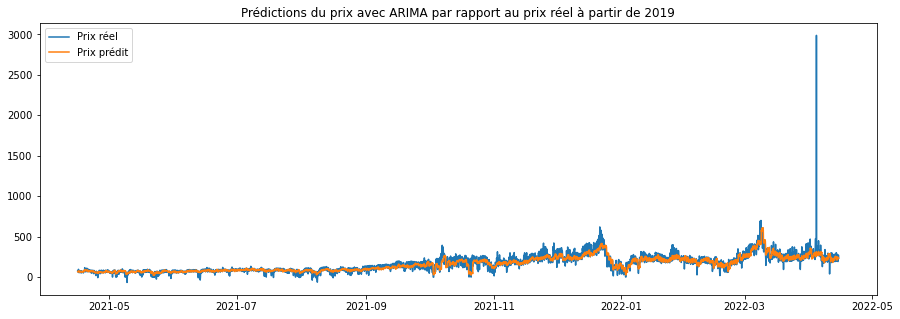

In [29]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.plot(test_data2['Date'], predictions2, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMA par rapport au prix réel à partir de 2019')
plt.show()

In [30]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list3 = []
for i in range(len(predictions2)):
    mae3 = mean_absolute_error([test_data2.iloc[i, 1]], [predictions2[i]])
    mae_list3.append(mae3)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


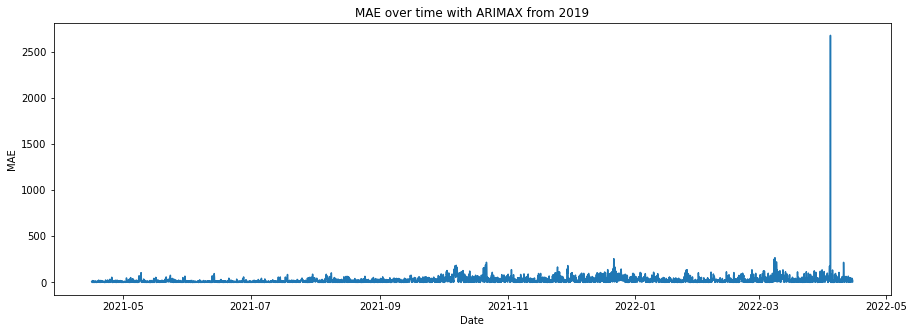

In [31]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data2['Date'], mae_list3)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMAX from 2019')
plt.show()

In [32]:
# Create an empty array to store the residuals
residuals2 = []


# Iterate over each point in the test set
for i in range(len(predictions2)):
    # Calculate the residuals
    residuals2.append(test_data2.iloc[i, 1] - predictions2[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am2 = arch_model(residuals2, x=predictions2, vol='GARCH', p=1, q=1)
res2 = am2.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts2 = []
for i in range(0, len(test_data2), 24):
    forecast2 = res2.forecast(horizon=24)
    garch_forecasts2.extend(forecast2.variance.values[-1, :])

print("GARCH forecasts2 :", garch_forecasts2)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 416946.71950537513
Iteration:      2,   Func. Count:     12,   Neg. LLF: 41472.83978563282
Iteration:      3,   Func. Count:     18,   Neg. LLF: 135022.3182009607
Iteration:      4,   Func. Count:     24,   Neg. LLF: 40584.97607156361
Iteration:      5,   Func. Count:     30,   Neg. LLF: 40187.16587108094
Iteration:      6,   Func. Count:     35,   Neg. LLF: 40264.09512305419
Iteration:      7,   Func. Count:     41,   Neg. LLF: 40901.2894429747
Iteration:      8,   Func. Count:     47,   Neg. LLF: 40069.597391916956
Iteration:      9,   Func. Count:     52,   Neg. LLF: 40052.08238582073
Iteration:     10,   Func. Count:     57,   Neg. LLF: 40047.45392630225
Iteration:     11,   Func. Count:     62,   Neg. LLF: 40046.931991373
Iteration:     12,   Func. Count:     67,   Neg. LLF: 40046.91797475685
Iteration:     13,   Func. Count:     72,   Neg. LLF: 40046.91786304227
Iteration:     14,   Func. Count:     76,   Neg. LLF: 40046.91785

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this messa

GARCH forecasts2 : [226.66673983799956, 327.1335622670776, 427.6003846961557, 528.0672071252338, 628.5340295543119, 729.00085198339, 829.467674412468, 929.9344968415462, 1030.4013192706243, 1130.8681416997024, 1231.3349641287805, 1331.8017865578586, 1432.268608986937, 1532.7354314160152, 1633.2022538450935, 1733.6690762741719, 1834.1358987032504, 1934.6027211323285, 2035.069543561407, 2135.5363659904856, 2236.003188419564, 2336.4700108486422, 2436.9368332777203, 2537.4036557067993, 226.66673983799956, 327.1335622670776, 427.6003846961557, 528.0672071252338, 628.5340295543119, 729.00085198339, 829.467674412468, 929.9344968415462, 1030.4013192706243, 1130.8681416997024, 1231.3349641287805, 1331.8017865578586, 1432.268608986937, 1532.7354314160152, 1633.2022538450935, 1733.6690762741719, 1834.1358987032504, 1934.6027211323285, 2035.069543561407, 2135.5363659904856, 2236.003188419564, 2336.4700108486422, 2436.9368332777203, 2537.4036557067993, 226.66673983799956, 327.1335622670776, 427.600

C:\Users\sokhn\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [33]:
observations2 = np.array(garch_forecasts2)
# Créer le filtre de Kalman
kf2 = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations2[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means2, filtered_state_covariances2 = kf2.filter(observations2)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions2 = filtered_state_means2.flatten()

print(filtered_volatility_predictions2)

[ 226.66673984  260.59924278  303.68916446 ... 1674.90274346 1747.39117679
 1822.54105221]


In [34]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts2 = []
for i in range(len(filtered_volatility_predictions2)):
    adjusted_forecasts2.append(predictions2[i] * np.sqrt(filtered_volatility_predictions2[i]) * 0.04) #to adjust the scaling factor, decrease of the scaling factor by a factor of 0.05

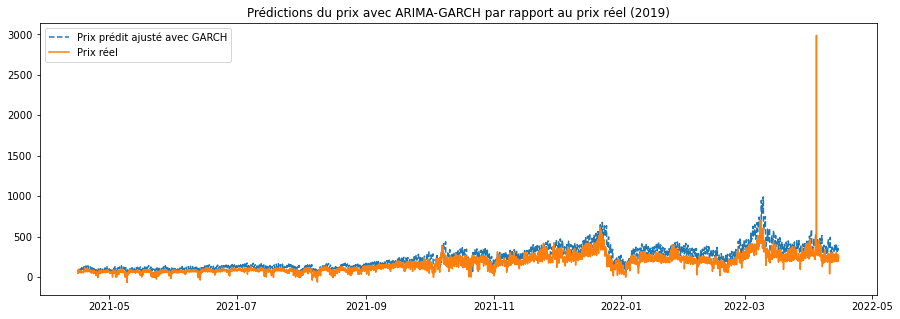

In [35]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data2['Date'], adjusted_forecasts2, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (2019)")
plt.show()

### Données Fournisseur

Objectif : comparer les prédictions fournisseurs avec les prédictions du modèle ARIMA-GARCH et aussi avec les données réels (ENTSOE)

In [36]:
# Load the dataset into a Pandas DataFrame
df_v = pd.read_csv('FR_fournisseur.csv')
df_v

,Date_Chicago,price_prediction_J1
0,2019-04-15 00:00:00,61.173
1,2019-04-15 01:00:00,63.837
2,2019-04-15 02:00:00,64.166
3,2019-04-15 03:00:00,61.356
4,2019-04-15 04:00:00,55.703
...,...,...
26488,2022-04-14 19:00:00,209.105
26489,2022-04-14 20:00:00,201.155
26490,2022-04-14 21:00:00,200.503
26491,2022-04-14 22:00:00,206.363


In [37]:
dfb2 = df_v

In [38]:
dfb2

,Date_Chicago,price_prediction_J1
0,2019-04-15 00:00:00,61.173
1,2019-04-15 01:00:00,63.837
2,2019-04-15 02:00:00,64.166
3,2019-04-15 03:00:00,61.356
4,2019-04-15 04:00:00,55.703
...,...,...
26488,2022-04-14 19:00:00,209.105
26489,2022-04-14 20:00:00,201.155
26490,2022-04-14 21:00:00,200.503
26491,2022-04-14 22:00:00,206.363


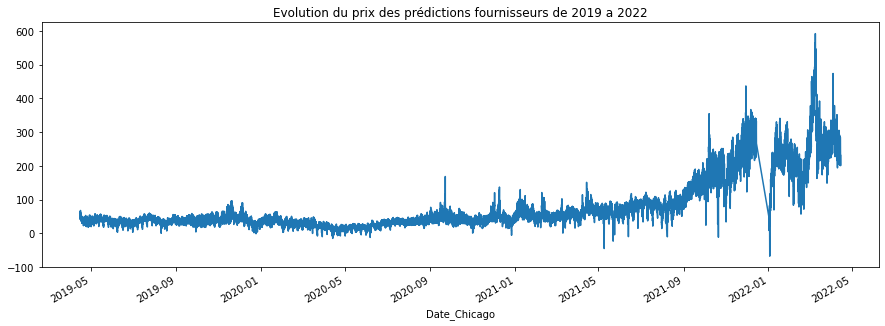

In [39]:
df_date2 = df_v

# Convertir la colonne Date en datetime
df_date2['Date_Chicago'] = pd.to_datetime(df_date2['Date_Chicago'])

# Définir la colonne Date comme index du dataframe
df_date2.set_index('Date_Chicago', inplace=True)

# Définir la taille de la figure
plt.figure(figsize=(15, 5))

# Tracer les données en utilisant la méthode plot() de pandas
df_date2['price_prediction_J1'].plot()

# Ajouter un titre au graphique
plt.title('Evolution du prix des prédictions fournisseurs de 2019 a 2022')

# Afficher le graphique
plt.show()

In [45]:
dfb2 = dfb2.reset_index()
dfb2

,Date_Chicago,price_prediction_J1
0,2019-04-15 00:00:00,61.173
1,2019-04-15 01:00:00,63.837
2,2019-04-15 02:00:00,64.166
3,2019-04-15 03:00:00,61.356
4,2019-04-15 04:00:00,55.703
...,...,...
26488,2022-04-14 19:00:00,209.105
26489,2022-04-14 20:00:00,201.155
26490,2022-04-14 21:00:00,200.503
26491,2022-04-14 22:00:00,206.363


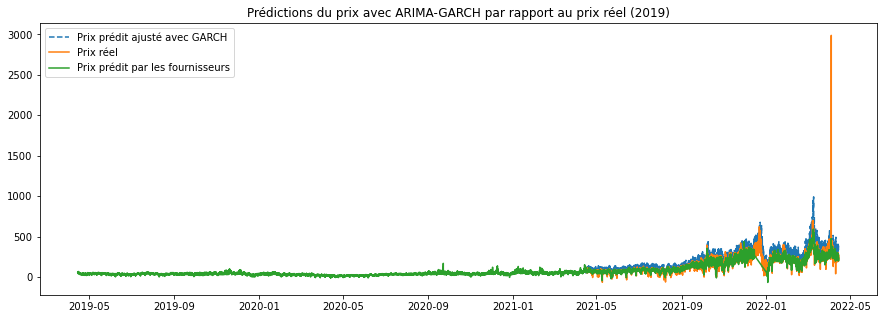

In [46]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data2['Date'], adjusted_forecasts2, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.plot(dfb2['Date_Chicago'], dfb2['price_prediction_J1'], label='Prix prédit par les fournisseurs')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (2019)")
plt.show()

In [47]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2019-04-15 00:00:00' 
end_date_train2 = '2021-04-15 23:00:00'

start_date_test2 = '2021-04-16 00:00:00'
end_date_test2 = '2022-04-14 23:00:00'

# Sélectionner les lignes entre les bornes de dates

test_data_v = dfb2.loc[(dfb2['Date_Chicago'] >= start_date_test2) & (dfb2['Date_Chicago'] <= end_date_test2)]

In [52]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list_f = []
for i in range(len(adjusted_forecasts2)):
    maef = mean_absolute_error([test_data2.iloc[i, 1]], [adjusted_forecasts2[i]])
    mae_list_f.append(maef)

mae_list_a = []
for i in range(len(predictions2)):
    mae3 = mean_absolute_error([test_data2.iloc[i, 1]], [predictions2[i]])
    mae_list_a.append(mae3)
    
mae_list_e = []
for i in range(len(test_data_v)):
    maee = mean_absolute_error([test_data2.iloc[i, 1]], [test_data_v.iloc[i, 1]])
    mae_list_e.append(maee)
    
# Imprimer la liste des MAE
print("MAE moyenne pour les prédictions ARIMA-GARCH par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_f))
print("MAE moyenne pour les prédictions ARIMAX par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_a))
print("MAE moyenne pour les prédictions fournisseurs par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_e))

MAE moyenne pour les prédictions ARIMA-GARCH par rapport aux données réels (ENTSOE) : 76.8086441522601
MAE moyenne pour les prédictions ARIMAX par rapport aux données réels (ENTSOE) : 26.264020802363785
MAE moyenne pour les prédictions fournisseurs par rapport aux données réels (ENTSOE) : 53.97541666666667


In [ ]:
stop

# -----------------------------------------------------------

In [ ]:
dfb2 = dfb2.reset_index()

In [ ]:
dfb2.columns

In [ ]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2019-04-15 00:00:00' 
end_date_train2 = '2021-04-15 23:00:00'

start_date_test2 = '2021-04-16 00:00:00'
end_date_test2 = '2022-04-14 23:00:00'

# Sélectionner les lignes entre les bornes de dates

test_data_v = dfb2.loc[(dfb2['Date_Chicago'] >= start_date_test2) & (dfb2['Date_Chicago'] <= end_date_test2)]

In [ ]:
test_data_v

In [ ]:
# Set the length of the training set
train_len4 = len(train_data_v)
#print(train_len)

# Create an empty array to store the predictions
predictions_v = []

# Iterate over each point in the test set
for i in range(0, len(test_data_v), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset3 = train_data_v.iloc[:train_len4, :]
    else:
        train_data_subset3 = pd.concat([train_data_v.iloc[i:, :], test_data_v.iloc[:i, :]], axis=0)
    #print("train data2 :", train_data_subset2)
        
    # Fit the ARIMA model to the training data
    model3 = ARIMA(train_data_subset3.iloc[:, 1], order=(1,1,1))
    result3 = model3.fit()
    
    # Make one-day-ahead forecasts
    forecast3 = result3.forecast(steps=24)
    print("prédictions_v :", forecast3)
    
    # Store the forecasts in the predictions array
    predictions_v.extend(forecast3)

In [ ]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data_v['Date_Chicago'], test_data_v.iloc[:, 1], label='Prix réel')
plt.plot(test_data_v['Date_Chicago'], predictions_v, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMA par rapport au prix réel (données fournisseurs)')
plt.show()

In [ ]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list4 = []
for i in range(len(predictions_v)):
    mae4 = mean_absolute_error([test_data_v.iloc[i, 1]], [predictions_v[i]])
    mae_list4.append(mae4)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


In [ ]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data_v['Date_Chicago'], mae_list4)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMA (suppliers data)')
plt.show()

In [ ]:
# Create an empty array to store the residuals
residuals3 = []


# Iterate over each point in the test set
for i in range(len(predictions_v)):
    # Calculate the residuals
    residuals3.append(test_data_v.iloc[i, 1] - predictions_v[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am3 = arch_model(residuals3, x=predictions_v, vol='GARCH', p=1, q=1)
res3 = am3.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts3 = []
for i in range(0, len(test_data_v), 24):
    forecast3 = res3.forecast(horizon=24)
    garch_forecasts3.extend(forecast3.variance.values[-1, :])

print("GARCH forecasts3 :", garch_forecasts3)

In [ ]:
observations3 = np.array(garch_forecasts3)
# Créer le filtre de Kalman
kf3 = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations3[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means3, filtered_state_covariances3 = kf3.filter(observations3)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions3 = filtered_state_means3.flatten()

print(filtered_volatility_predictions3)

In [ ]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts3 = []
for i in range(len(filtered_volatility_predictions3)):
    adjusted_forecasts3.append(predictions_v[i] * np.sqrt(filtered_volatility_predictions3[i]) * 0.02) #to adjust the scaling factor, decrease of the scaling factor by a factor of 0.05

In [ ]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data_v['Date_Chicago'], test_data_v.iloc[:, 1], label='Prix réel')
plt.plot(test_data_v['Date_Chicago'], adjusted_forecasts3, label='Prix prédit ajusté avec GARCH')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (données fournisseurs)")
plt.show()

In [ ]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list_f = []
for i in range(len(adjusted_forecasts3)):
    maef = mean_absolute_error([test_data_v.iloc[i, 1]], [adjusted_forecasts3[i]])
    mae_list_f.append(maef)
    
mae_list_e = []
for i in range(len(adjusted_forecasts2)):
    maee = mean_absolute_error([test_data2.iloc[i, 1]], [adjusted_forecasts2[i]])
    mae_list_e.append(maee)
    
# Imprimer la liste des MAE
print("MAE moyenne pour ARIMA-GARCH (ENTSOE) :", statistics.mean(mae_list_e))
print("MAE moyenne pour ARIMA-GARCH (fournisseurs) :", statistics.mean(mae_list_f))
